In [13]:
# Run this at the start
import xml.etree.ElementTree as ET
from ultralytics import YOLO
from pathlib import Path
import random
import shutil
import cv2
import itertools
import os
import shutil
import matplotlib.pyplot as plt
import albumentations as A
import csv
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import os
import shutil
import random

# Paths
yolo_folder = '/home/student/Desktop/current_model_ai/obj_train_data'               # YOLO labels from CVAT
images_folder = '/home/student/Desktop/current_model_ai/ImagesTotal'                # Image folder
output_folder = '/home/student/Desktop/current_model_ai'                            # Output folder

# Create and clean output directories
for subset in ['train', 'val', 'test']:
    images_path = os.path.join(output_folder, subset, 'images')
    labels_path = os.path.join(output_folder, subset, 'labels')

    os.makedirs(images_path, exist_ok=True)
    os.makedirs(labels_path, exist_ok=True)

    # Clear old image files
    for file in os.listdir(images_path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            os.remove(os.path.join(images_path, file))

    # Clear old label files
    for file in os.listdir(labels_path):
        if file.endswith(".txt"):
            os.remove(os.path.join(labels_path, file))

# Match label files with image files
data_pairs = []

print("Searching for matching images and labels...")
for label_file in os.listdir(yolo_folder):
    if label_file.endswith(".txt"):
        label_path = os.path.join(yolo_folder, label_file)

        image_found = False
        base_name = os.path.splitext(label_file)[0]

        for ext in ['.jpg', '.jpeg', '.png']:
            img_name = base_name + ext
            img_path = os.path.join(images_folder, img_name)
            if os.path.exists(img_path):
                data_pairs.append((img_path, label_path))
                print(f"Matched: {img_name} <-> {label_file}")
                image_found = True
                break

        if not image_found:
            print(f"No image found for label: {label_file}")

print(f"\nTotal valid image-label pairs found: {len(data_pairs)}")

# Shuffle and split data
random.shuffle(data_pairs)
total = len(data_pairs)
train_end = int(0.7 * total)
val_end = int(0.9 * total)

train_data = data_pairs[:train_end]
val_data = data_pairs[train_end:val_end]
test_data = data_pairs[val_end:]

# Copy files to split directories
def save_split(split_name, data):
    img_dir = os.path.join(output_folder, split_name, 'images')
    label_dir = os.path.join(output_folder, split_name, 'labels')
    print(f"\nSaving {split_name} set...")

    for img_path, label_path in data:
        shutil.copy(img_path, os.path.join(img_dir, os.path.basename(img_path)))
        shutil.copy(label_path, os.path.join(label_dir, os.path.basename(label_path)))

    print(f"{len(data)} samples saved to {split_name}/images and {split_name}/labels.")

# Save splits
save_split('train', train_data)
save_split('val', val_data)
save_split('test', test_data)

print("\nDataset split completed successfully.")

Searching for matching images and labels...
Matched: rotated_180_387.png <-> rotated_180_387.txt
Matched: rotated_270_85.png <-> rotated_270_85.txt
Matched: rotated_90_343.png <-> rotated_90_343.txt
Matched: rotated_180_51.png <-> rotated_180_51.txt
Matched: rotated_90_166.png <-> rotated_90_166.txt
Matched: rotated_180_350.png <-> rotated_180_350.txt
Matched: rotated_180_232.png <-> rotated_180_232.txt
Matched: rotated_90_323.png <-> rotated_90_323.txt
Matched: rotated_90_245.png <-> rotated_90_245.txt
Matched: rotated_90_203.png <-> rotated_90_203.txt
Matched: Flipped_horizontal_64.png <-> Flipped_horizontal_64.txt
Matched: rotated_270_99.png <-> rotated_270_99.txt
Matched: rotated_270_409.png <-> rotated_270_409.txt
Matched: rotated_270_167.png <-> rotated_270_167.txt
Matched: rotated_90_336.png <-> rotated_90_336.txt
Matched: rotated_270_387.png <-> rotated_270_387.txt
Matched: rotated_270_162.png <-> rotated_270_162.txt
Matched: rotated_180_355.png <-> rotated_180_355.txt
Matched:

In [15]:
data_yaml = '/home/student/Desktop/current_model_ai/data.yaml'
project_root = '/home/student/Desktop/current_model_ai/training_results_v2'
csv_path = '/home/student/Desktop/current_model_ai/training_results_v2/model_selection_metrics.csv'

# Clean project folder
if os.path.exists(project_root):
    shutil.rmtree(project_root)

os.makedirs(project_root, exist_ok=True)

# Phase 1: Model selection
models = ['yolo11n.pt', 'yolo11s.pt', 'yolo11m.pt', 'yolo11l.pt', 'yolo11x.pt']
model_metrics = {}

print("\n🔍 Phase 1: Model selection\n")

for model_name in models:
    name = os.path.splitext(model_name)[0] + '_baseline'
    print(f"Training {model_name}...")
    
    # Train model
    model = YOLO(model_name)
    model.train(data=data_yaml, epochs=30, imgsz=640, batch=8,
                name=name, project=project_root, patience=10, verbose=False)

    # Evaluate
    results = model.val(data=data_yaml)

    # Extract metrics
    metrics = {
        'Box(P)': float(results.box.p),
        'Recall': float(results.box.r),
        'mAP50': float(results.box.map50),
        'mAP50-95': float(results.box.map)
    }
    model_metrics[model_name] = metrics

    print(f"✅ {model_name}: {metrics}")

# Write metrics to CSV

with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Header
    writer.writerow(['Model', 'Box(P)', 'Recall', 'mAP50', 'mAP50-95'])
    # Data rows
    for model_name, metrics in model_metrics.items():
        writer.writerow([model_name] + list(metrics.values()))

# Identify best model
best_model = max(model_metrics, key=lambda m: model_metrics[m]['mAP50'])
print(f"\n🏆 Best model: {best_model} with mAP50 = {model_metrics[best_model]['mAP50']:.3f}")



🔍 Phase 1: Model selection

Training yolo11n.pt...
New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.133 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0

train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2361.7±2027.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results_v2/yolo11n_baseline/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results_v2/yolo11n_baseline
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.38G      2.397      3.556      1.785         29        640: 100%|██████████| 148/148 [00:07<00:00, 19.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.19it/s]

                   all        338        510      0.467      0.386      0.377      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.38G      2.023      2.181      1.561         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.25it/s]

                   all        338        510      0.455      0.659      0.507      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.38G       1.96      1.928      1.527         25        640: 100%|██████████| 148/148 [00:06<00:00, 23.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.27it/s]

                   all        338        510       0.48      0.602      0.501       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.38G       1.96      1.728      1.532         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.19it/s]

                   all        338        510      0.412      0.622      0.447      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.38G      1.925      1.635      1.516         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.86it/s]

                   all        338        510      0.618      0.764      0.719      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.38G      1.902      1.561      1.515         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.40it/s]

                   all        338        510      0.651      0.733      0.731      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.38G      1.885      1.458      1.518         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.76it/s]

                   all        338        510      0.594       0.68      0.628       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.38G      1.841      1.409      1.514         27        640: 100%|██████████| 148/148 [00:06<00:00, 22.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.07it/s]

                   all        338        510      0.678       0.71      0.737      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.38G      1.881      1.358      1.508         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.43it/s]

                   all        338        510      0.554       0.68      0.609      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.38G      1.836      1.333       1.47         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.95it/s]

                   all        338        510      0.807       0.78      0.812       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.38G      1.835      1.336       1.49         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.818      0.824      0.871      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.38G      1.825      1.278      1.483         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.38it/s]

                   all        338        510      0.835      0.778      0.857      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.38G      1.799      1.233      1.475         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.23it/s]

                   all        338        510      0.871      0.863      0.895      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.38G      1.814      1.197       1.48         26        640: 100%|██████████| 148/148 [00:06<00:00, 23.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.911      0.825      0.906      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.38G      1.803      1.192      1.455         30        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.39it/s]

                   all        338        510      0.868      0.829      0.863       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.38G      1.798      1.215      1.463         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.93it/s]

                   all        338        510       0.85      0.803      0.873      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.38G      1.786      1.213      1.456         24        640: 100%|██████████| 148/148 [00:06<00:00, 23.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.03it/s]

                   all        338        510      0.882      0.833      0.866      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.38G      1.766      1.132      1.444         27        640: 100%|██████████| 148/148 [00:06<00:00, 23.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.46it/s]

                   all        338        510      0.893      0.849      0.895      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.38G      1.746      1.119      1.455         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.67it/s]

                   all        338        510      0.912      0.855      0.926      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.38G      1.762      1.133      1.443         26        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.81it/s]

                   all        338        510      0.929      0.869      0.933      0.396


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.38G      1.727      1.067       1.53         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.41it/s]

                   all        338        510      0.913      0.892      0.917      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.38G      1.737      1.016      1.555         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.13it/s]

                   all        338        510      0.915      0.881      0.938      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.38G      1.705      1.003      1.534         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.61it/s]

                   all        338        510      0.931      0.876      0.946       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.38G      1.708     0.9844      1.544         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.23it/s]

                   all        338        510      0.931      0.896       0.95      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.38G      1.715     0.9798      1.545         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.90it/s]

                   all        338        510      0.924      0.886      0.945      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.38G      1.704     0.9369      1.548         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.24it/s]

                   all        338        510      0.926      0.894      0.945      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.38G      1.683     0.9147       1.53         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.933      0.924      0.964      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.38G      1.684     0.9049      1.517         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.33it/s]

                   all        338        510      0.942      0.889      0.952      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.38G      1.664     0.8933      1.513         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.43it/s]

                   all        338        510      0.945      0.918      0.963      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.38G      1.679     0.9004      1.515         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.34it/s]

                   all        338        510      0.932       0.92      0.958      0.443



30 epochs completed in 0.061 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results_v2/yolo11n_baseline/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results_v2/yolo11n_baseline/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results_v2/yolo11n_baseline/weights/best.pt...
Ultralytics 8.3.133 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 24.51it/s]


                   all        338        510      0.935      0.924      0.958      0.444
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results_v2/yolo11n_baseline
Ultralytics 8.3.133 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7723.3±1304.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 38.38it/s]


                   all        338        510      0.929       0.92      0.958      0.443
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results_v2/yolo11n_baseline2
✅ yolo11n.pt: {'Box(P)': 0.9291307548595145, 'Recall': 0.9196078431372549, 'mAP50': 0.9579468990965304, 'mAP50-95': 0.4434679493013755}
Training yolo11s.pt...


/tmp/ipykernel_82169/3214593140.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_82169/3214593140.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),
100%|██████████| 18.4M/18.4M [00:00<00:00, 72.7MB/s]


New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.133 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11s_ba

train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3322.6±2960.4 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results_v2/yolo11s_baseline/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results_v2/yolo11s_baseline
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       2.2G      2.325      4.307      1.906         29        640: 100%|██████████| 148/148 [00:10<00:00, 14.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 18.71it/s]


                   all        338        510      0.219      0.249      0.125     0.0333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.65G      2.071      1.775      1.675         17        640: 100%|██████████| 148/148 [00:09<00:00, 15.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 21.06it/s]

                   all        338        510      0.317      0.461      0.245     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.68G      2.005      1.686      1.645         25        640: 100%|██████████| 148/148 [00:09<00:00, 15.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 21.30it/s]

                   all        338        510       0.47      0.692      0.522      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.72G      2.013      1.605      1.641         19        640: 100%|██████████| 148/148 [00:09<00:00, 15.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 21.45it/s]

                   all        338        510      0.432      0.645      0.514       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.76G      1.984      1.572      1.631         13        640: 100%|██████████| 148/148 [00:09<00:00, 15.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 21.50it/s]

                   all        338        510      0.251      0.504      0.215     0.0677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.8G      1.915      1.507      1.576         10        640: 100%|██████████| 148/148 [00:09<00:00, 15.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 20.56it/s]

                   all        338        510      0.546      0.698      0.631      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.84G       1.91      1.487      1.582         21        640: 100%|██████████| 148/148 [00:09<00:00, 15.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.30it/s]

                   all        338        510      0.848      0.804      0.869      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.84G       1.88      1.411      1.574         27        640: 100%|██████████| 148/148 [00:09<00:00, 15.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.04it/s]

                   all        338        510      0.721      0.739       0.78      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.84G      1.903       1.38      1.565         21        640: 100%|██████████| 148/148 [00:09<00:00, 15.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.17it/s]

                   all        338        510      0.713      0.702      0.793      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.84G      1.852      1.309      1.529         19        640: 100%|██████████| 148/148 [00:09<00:00, 15.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.22it/s]

                   all        338        510      0.731      0.702      0.728      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.84G      1.863      1.337      1.557         17        640: 100%|██████████| 148/148 [00:09<00:00, 15.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.33it/s]

                   all        338        510      0.715      0.694      0.674      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.84G      1.852      1.269      1.542         15        640: 100%|██████████| 148/148 [00:09<00:00, 15.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.26it/s]

                   all        338        510      0.859      0.798      0.851      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.84G      1.828      1.226       1.53         18        640: 100%|██████████| 148/148 [00:09<00:00, 15.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.40it/s]

                   all        338        510      0.703        0.7      0.675      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.88G      1.831      1.203      1.514         26        640: 100%|██████████| 148/148 [00:09<00:00, 16.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.20it/s]

                   all        338        510      0.875      0.833      0.873      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.88G      1.824      1.198        1.5         30        640: 100%|██████████| 148/148 [00:09<00:00, 15.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.24it/s]

                   all        338        510      0.893      0.799      0.871      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.88G      1.829      1.171       1.52         20        640: 100%|██████████| 148/148 [00:09<00:00, 15.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.26it/s]

                   all        338        510      0.873      0.759      0.822      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.88G      1.809      1.159      1.501         24        640: 100%|██████████| 148/148 [00:09<00:00, 15.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.19it/s]

                   all        338        510      0.873      0.806      0.874      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.88G      1.778      1.118      1.484         27        640: 100%|██████████| 148/148 [00:09<00:00, 15.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.08it/s]

                   all        338        510      0.879      0.875      0.891      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.88G      1.767      1.086      1.497         19        640: 100%|██████████| 148/148 [00:09<00:00, 15.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.36it/s]

                   all        338        510      0.921      0.849      0.923      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.88G      1.767      1.091      1.479         26        640: 100%|██████████| 148/148 [00:09<00:00, 15.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.23it/s]

                   all        338        510      0.914      0.873       0.92      0.417


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.88G      1.744      1.038      1.599         12        640: 100%|██████████| 148/148 [00:09<00:00, 15.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.24it/s]

                   all        338        510      0.909       0.82      0.886      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.92G      1.752     0.9943      1.606         10        640: 100%|██████████| 148/148 [00:09<00:00, 16.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.39it/s]

                   all        338        510       0.93      0.845      0.903      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.92G      1.723     0.9499      1.585         13        640: 100%|██████████| 148/148 [00:09<00:00, 15.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.30it/s]

                   all        338        510      0.909      0.876      0.899      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.92G      1.716     0.9636      1.584         11        640: 100%|██████████| 148/148 [00:09<00:00, 15.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.34it/s]

                   all        338        510       0.92      0.903      0.934      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.92G      1.707     0.9456      1.566         13        640: 100%|██████████| 148/148 [00:09<00:00, 15.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.44it/s]

                   all        338        510      0.933      0.922      0.948      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.92G      1.702      0.929       1.58         11        640: 100%|██████████| 148/148 [00:09<00:00, 16.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.41it/s]

                   all        338        510      0.942      0.851      0.933      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.92G      1.687     0.9172      1.568         14        640: 100%|██████████| 148/148 [00:09<00:00, 15.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.23it/s]

                   all        338        510      0.945       0.91      0.957      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.92G      1.687     0.8949       1.55         11        640: 100%|██████████| 148/148 [00:09<00:00, 15.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.42it/s]

                   all        338        510      0.941      0.894      0.948      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.92G      1.661     0.8907      1.542         12        640: 100%|██████████| 148/148 [00:09<00:00, 15.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.33it/s]

                   all        338        510      0.917      0.908      0.946      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.92G      1.657     0.8739      1.526         15        640: 100%|██████████| 148/148 [00:09<00:00, 15.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 21.49it/s]

                   all        338        510      0.933      0.906      0.953      0.422



30 epochs completed in 0.089 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results_v2/yolo11s_baseline/weights/last.pt, 19.2MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results_v2/yolo11s_baseline/weights/best.pt, 19.2MB

Validating /home/student/Desktop/current_model_ai/training_results_v2/yolo11s_baseline/weights/best.pt...
Ultralytics 8.3.133 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 19.04it/s]


                   all        338        510      0.933      0.906      0.953      0.421
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results_v2/yolo11s_baseline
Ultralytics 8.3.133 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6732.1±2534.7 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.66it/s]


                   all        338        510      0.934      0.906      0.953       0.42
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results_v2/yolo11s_baseline2
✅ yolo11s.pt: {'Box(P)': 0.934307916685657, 'Recall': 0.9058823529411765, 'mAP50': 0.9530266674804015, 'mAP50-95': 0.42038029872503724}
Training yolo11m.pt...


/tmp/ipykernel_82169/3214593140.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_82169/3214593140.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),
100%|██████████| 38.8M/38.8M [00:00<00:00, 82.2MB/s]


New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.133 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11m_ba

train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2375.1±1682.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results_v2/yolo11m_baseline/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results_v2/yolo11m_baseline
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.24G      2.335      2.509      1.938         29        640: 100%|██████████| 148/148 [00:19<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.10it/s]

                   all        338        510     0.0357      0.147    0.00969    0.00251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      5.04G      2.131      1.909      1.724         17        640: 100%|██████████| 148/148 [00:18<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.04it/s]

                   all        338        510      0.233      0.396      0.168     0.0506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       5.1G      2.071      1.915       1.69         25        640: 100%|██████████| 148/148 [00:18<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.70it/s]

                   all        338        510      0.185      0.331      0.138     0.0413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      5.17G      2.056      1.741       1.68         19        640: 100%|██████████| 148/148 [00:18<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.99it/s]

                   all        338        510      0.396      0.688      0.523      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.24G      1.988      1.683      1.637         13        640: 100%|██████████| 148/148 [00:18<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.04it/s]

                   all        338        510      0.365      0.639      0.371      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.24G      1.932      1.558      1.592         10        640: 100%|██████████| 148/148 [00:18<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.99it/s]

                   all        338        510       0.49      0.816      0.654      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      5.24G      1.918      1.524      1.593         21        640: 100%|██████████| 148/148 [00:18<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.08it/s]

                   all        338        510      0.595      0.712      0.593      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.24G      1.876      1.462      1.577         27        640: 100%|██████████| 148/148 [00:18<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.07it/s]

                   all        338        510      0.585      0.711      0.613      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      5.24G      1.895      1.461      1.567         21        640: 100%|██████████| 148/148 [00:18<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.01it/s]

                   all        338        510      0.796      0.769      0.829      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30       5.3G      1.863       1.37      1.534         19        640: 100%|██████████| 148/148 [00:18<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.06it/s]

                   all        338        510      0.838      0.827      0.868      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30       5.3G      1.848      1.363      1.544         17        640: 100%|██████████| 148/148 [00:18<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.05it/s]

                   all        338        510      0.777      0.676      0.721      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30       5.3G      1.865      1.329      1.555         15        640: 100%|██████████| 148/148 [00:18<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.05it/s]

                   all        338        510      0.732      0.655      0.725      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30       5.3G       1.82      1.329      1.519         18        640: 100%|██████████| 148/148 [00:18<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.00it/s]

                   all        338        510      0.693      0.686      0.652      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30       5.3G      1.818      1.281      1.506         26        640: 100%|██████████| 148/148 [00:18<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.00it/s]

                   all        338        510      0.892      0.833      0.905      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30       5.3G      1.826      1.252      1.501         30        640: 100%|██████████| 148/148 [00:18<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.03it/s]

                   all        338        510      0.828      0.754      0.815      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30       5.3G      1.819      1.255      1.515         20        640: 100%|██████████| 148/148 [00:18<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.73it/s]

                   all        338        510      0.815      0.769      0.826      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30       5.3G      1.791      1.245      1.495         24        640: 100%|██████████| 148/148 [00:18<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.58it/s]

                   all        338        510      0.891      0.782      0.877      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30       5.3G      1.801      1.182      1.501         27        640: 100%|██████████| 148/148 [00:17<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.59it/s]

                   all        338        510      0.896      0.825      0.887       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30       5.3G      1.766      1.162      1.496         19        640: 100%|██████████| 148/148 [00:18<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.12it/s]

                   all        338        510      0.863      0.824       0.87      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30       5.3G      1.769      1.148       1.48         26        640: 100%|██████████| 148/148 [00:18<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.07it/s]

                   all        338        510       0.93      0.864      0.927      0.403


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30       5.3G       1.74      1.128      1.598         12        640: 100%|██████████| 148/148 [00:18<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.08it/s]

                   all        338        510      0.884      0.865      0.888      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30       5.3G      1.736      1.072        1.6         10        640: 100%|██████████| 148/148 [00:18<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.08it/s]

                   all        338        510      0.924      0.861      0.905      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30       5.3G       1.72      1.054      1.586         13        640: 100%|██████████| 148/148 [00:18<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.04it/s]

                   all        338        510      0.909      0.892      0.889      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30       5.3G      1.707      1.031      1.582         11        640: 100%|██████████| 148/148 [00:18<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.02it/s]

                   all        338        510      0.919      0.886      0.927      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       5.3G      1.701      1.005      1.568         13        640: 100%|██████████| 148/148 [00:18<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.04it/s]

                   all        338        510      0.908      0.867      0.919      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       5.3G      1.706     0.9751      1.587         11        640: 100%|██████████| 148/148 [00:18<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.08it/s]

                   all        338        510      0.938       0.89      0.937      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30       5.3G      1.677     0.9526      1.562         14        640: 100%|██████████| 148/148 [00:18<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.94it/s]

                   all        338        510      0.927      0.916      0.939      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30       5.3G      1.681     0.9434      1.545         11        640: 100%|██████████| 148/148 [00:18<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.02it/s]

                   all        338        510      0.934      0.882      0.935      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30       5.3G      1.663     0.9363      1.546         12        640: 100%|██████████| 148/148 [00:18<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.05it/s]

                   all        338        510      0.932      0.884      0.947      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30       5.3G      1.658     0.9332      1.529         15        640: 100%|██████████| 148/148 [00:18<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 12.94it/s]

                   all        338        510       0.94      0.887      0.941      0.426



30 epochs completed in 0.173 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results_v2/yolo11m_baseline/weights/last.pt, 40.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results_v2/yolo11m_baseline/weights/best.pt, 40.5MB

Validating /home/student/Desktop/current_model_ai/training_results_v2/yolo11m_baseline/weights/best.pt...
Ultralytics 8.3.133 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 13.05it/s]


                   all        338        510       0.94      0.887      0.941      0.427
Speed: 0.1ms preprocess, 3.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results_v2/yolo11m_baseline
Ultralytics 8.3.133 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7134.2±951.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:02<00:00, 15.96it/s]


                   all        338        510       0.94      0.886      0.941      0.425
Speed: 0.2ms preprocess, 5.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results_v2/yolo11m_baseline2
✅ yolo11m.pt: {'Box(P)': 0.9395465729480155, 'Recall': 0.8862745098039215, 'mAP50': 0.9414551908257539, 'mAP50-95': 0.42537811851752305}
Training yolo11l.pt...


/tmp/ipykernel_82169/3214593140.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_82169/3214593140.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),
100%|██████████| 49.0M/49.0M [00:00<00:00, 83.7MB/s]


New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.133 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11l_ba

train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2462.6±1971.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results_v2/yolo11l_baseline/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results_v2/yolo11l_baseline
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      5.32G      2.347      2.444      1.942         29        640: 100%|██████████| 148/148 [00:25<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.44it/s]

                   all        338        510     0.0162      0.282    0.00813    0.00217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      5.97G       2.16      1.932      1.747         17        640: 100%|██████████| 148/148 [00:23<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.04it/s]

                   all        338        510      0.267       0.53      0.264     0.0842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         6G      2.069       1.79      1.691         25        640: 100%|██████████| 148/148 [00:23<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.93it/s]

                   all        338        510          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      6.07G      2.035      1.699      1.673         19        640: 100%|██████████| 148/148 [00:23<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.93it/s]

                   all        338        510      0.395       0.69      0.445      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      6.17G      1.986      1.653      1.635         13        640: 100%|██████████| 148/148 [00:23<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.42it/s]

                   all        338        510      0.483      0.584      0.503        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      6.26G      1.947      1.585      1.605         10        640: 100%|██████████| 148/148 [00:23<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.08it/s]

                   all        338        510      0.472      0.553      0.481      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.26G      1.943      1.539        1.6         21        640: 100%|██████████| 148/148 [00:23<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.77it/s]

                   all        338        510      0.617      0.698      0.688      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      6.26G      1.901      1.485      1.589         27        640: 100%|██████████| 148/148 [00:23<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.56it/s]

                   all        338        510      0.705      0.802      0.759        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.26G      1.907      1.464      1.571         21        640: 100%|██████████| 148/148 [00:23<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.14it/s]

                   all        338        510      0.609      0.564       0.57      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.26G      1.892      1.402      1.554         19        640: 100%|██████████| 148/148 [00:23<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.94it/s]

                   all        338        510      0.781      0.773      0.811      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      6.26G      1.885      1.434       1.57         17        640: 100%|██████████| 148/148 [00:23<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.94it/s]

                   all        338        510      0.793      0.765      0.799      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.26G      1.866      1.351      1.552         15        640: 100%|██████████| 148/148 [00:23<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.99it/s]

                   all        338        510      0.705       0.76      0.733      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.26G      1.832      1.316      1.533         18        640: 100%|██████████| 148/148 [00:23<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.01it/s]

                   all        338        510      0.781      0.729      0.764      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.26G      1.802       1.29      1.504         26        640: 100%|██████████| 148/148 [00:23<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.01it/s]

                   all        338        510      0.798      0.759      0.835      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.26G      1.832       1.28       1.51         30        640: 100%|██████████| 148/148 [00:23<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.13it/s]

                   all        338        510      0.839      0.748      0.814      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      6.26G      1.816      1.274      1.513         20        640: 100%|██████████| 148/148 [00:23<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.86it/s]

                   all        338        510       0.88      0.778      0.865      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      6.26G      1.797      1.236      1.492         24        640: 100%|██████████| 148/148 [00:23<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.93it/s]

                   all        338        510      0.884      0.769      0.844      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      6.26G      1.782      1.193      1.489         27        640: 100%|██████████| 148/148 [00:23<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.92it/s]

                   all        338        510      0.914       0.82        0.9      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      6.26G      1.762      1.179      1.494         19        640: 100%|██████████| 148/148 [00:23<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.12it/s]

                   all        338        510      0.889      0.855      0.908      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      6.26G      1.757      1.169      1.475         26        640: 100%|██████████| 148/148 [00:23<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.00it/s]

                   all        338        510      0.899      0.825      0.878      0.385


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.26G      1.734      1.101      1.592         12        640: 100%|██████████| 148/148 [00:23<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.85it/s]

                   all        338        510      0.888      0.837      0.888      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.26G      1.754      1.067      1.611         10        640: 100%|██████████| 148/148 [00:23<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.04it/s]

                   all        338        510      0.926      0.809      0.911      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.26G      1.721       1.06      1.589         13        640: 100%|██████████| 148/148 [00:23<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.11it/s]

                   all        338        510      0.916      0.875      0.917      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.26G      1.713      1.061      1.581         11        640: 100%|██████████| 148/148 [00:23<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.10it/s]

                   all        338        510      0.933      0.896      0.933      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.26G      1.713     0.9995      1.574         13        640: 100%|██████████| 148/148 [00:23<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.91it/s]

                   all        338        510      0.924      0.885      0.928      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.26G      1.701     0.9856      1.584         11        640: 100%|██████████| 148/148 [00:23<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.48it/s]

                   all        338        510      0.944      0.873      0.935      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.26G      1.689      0.969      1.572         14        640: 100%|██████████| 148/148 [00:23<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.10it/s]

                   all        338        510      0.939      0.912      0.943      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.26G      1.673     0.9584      1.542         11        640: 100%|██████████| 148/148 [00:23<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.94it/s]

                   all        338        510      0.924      0.903      0.944      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.26G      1.663     0.9374      1.546         12        640: 100%|██████████| 148/148 [00:23<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 11.01it/s]

                   all        338        510      0.946       0.89      0.944      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.26G      1.656     0.9268       1.53         15        640: 100%|██████████| 148/148 [00:23<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.98it/s]

                   all        338        510      0.937      0.904      0.948      0.426



30 epochs completed in 0.217 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results_v2/yolo11l_baseline/weights/last.pt, 51.2MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results_v2/yolo11l_baseline/weights/best.pt, 51.2MB

Validating /home/student/Desktop/current_model_ai/training_results_v2/yolo11l_baseline/weights/best.pt...
Ultralytics 8.3.133 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00, 10.80it/s]


                   all        338        510      0.937      0.903      0.948      0.426
Speed: 0.1ms preprocess, 4.1ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results_v2/yolo11l_baseline
Ultralytics 8.3.133 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6084.1±2622.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:03<00:00, 14.07it/s]


                   all        338        510      0.937      0.906      0.948      0.426
Speed: 0.2ms preprocess, 7.0ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results_v2/yolo11l_baseline2
✅ yolo11l.pt: {'Box(P)': 0.9367871747261157, 'Recall': 0.9058823529411765, 'mAP50': 0.9477877064248593, 'mAP50-95': 0.4264987842544553}
Training yolo11x.pt...


/tmp/ipykernel_82169/3214593140.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_82169/3214593140.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),
100%|██████████| 109M/109M [00:01<00:00, 77.6MB/s] 


New https://pypi.org/project/ultralytics/8.3.146 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.133 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11x_ba

train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1905.5±1307.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results_v2/yolo11x_baseline/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results_v2/yolo11x_baseline
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      8.09G       2.36      3.148      1.976         29        640: 100%|██████████| 148/148 [00:41<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  7.07it/s]

                   all        338        510    0.00098    0.00196   0.000418   0.000126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      8.38G      2.199      2.178      1.786         17        640: 100%|██████████| 148/148 [00:39<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  7.39it/s]

                   all        338        510          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      8.38G      2.092      2.055        1.7         25        640: 100%|██████████| 148/148 [00:39<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.75it/s]


                   all        338        510      0.289      0.549      0.284      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      8.21G      2.075      1.872       1.69         19        640: 100%|██████████| 148/148 [00:39<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.90it/s]

                   all        338        510      0.364      0.562      0.364      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      8.39G      2.016      1.777      1.649         13        640: 100%|██████████| 148/148 [00:38<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.87it/s]

                   all        338        510      0.415      0.635      0.448      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       8.2G       1.96      1.662      1.617         10        640: 100%|██████████| 148/148 [00:38<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.92it/s]

                   all        338        510      0.442      0.681      0.499      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      8.39G      1.954      1.622      1.616         21        640: 100%|██████████| 148/148 [00:39<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.80it/s]

                   all        338        510      0.545      0.643      0.575      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30       8.2G      1.902      1.531      1.592         27        640: 100%|██████████| 148/148 [00:38<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.89it/s]

                   all        338        510      0.608      0.744      0.687       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      8.39G      1.918      1.511      1.577         21        640: 100%|██████████| 148/148 [00:39<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.46it/s]

                   all        338        510      0.674       0.71      0.735      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30       8.2G      1.884      1.486      1.549         19        640: 100%|██████████| 148/148 [00:38<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.89it/s]

                   all        338        510      0.624      0.771      0.666      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      8.39G      1.859        1.5      1.556         17        640: 100%|██████████| 148/148 [00:38<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.87it/s]

                   all        338        510      0.764      0.737      0.794      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30       8.2G      1.866      1.412      1.556         15        640: 100%|██████████| 148/148 [00:38<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.86it/s]

                   all        338        510      0.667       0.71       0.73      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      8.39G      1.844       1.38      1.541         18        640: 100%|██████████| 148/148 [00:38<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.84it/s]

                   all        338        510       0.73      0.757      0.751        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30       8.2G      1.861      1.361      1.535         26        640: 100%|██████████| 148/148 [00:38<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.88it/s]

                   all        338        510      0.812       0.83      0.849      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30       8.4G      1.837      1.362      1.509         30        640: 100%|██████████| 148/148 [00:38<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.89it/s]

                   all        338        510      0.751      0.705      0.783      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30       8.2G       1.83      1.331      1.525         20        640: 100%|██████████| 148/148 [00:38<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.91it/s]

                   all        338        510      0.821      0.771       0.86      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      8.39G      1.807       1.29      1.506         24        640: 100%|██████████| 148/148 [00:38<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.93it/s]

                   all        338        510      0.831       0.78      0.838      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30       8.2G      1.817      1.283      1.509         27        640: 100%|██████████| 148/148 [00:38<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.92it/s]

                   all        338        510       0.86      0.782      0.852      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      8.39G      1.769       1.25        1.5         19        640: 100%|██████████| 148/148 [00:39<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.85it/s]

                   all        338        510      0.831      0.841      0.898      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30       8.2G      1.792      1.249      1.494         26        640: 100%|██████████| 148/148 [00:38<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.84it/s]

                   all        338        510      0.869      0.778      0.835      0.333


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      8.37G       1.73      1.151      1.595         12        640: 100%|██████████| 148/148 [00:38<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.84it/s]

                   all        338        510      0.876      0.861      0.884      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30       8.2G      1.763      1.117      1.617         10        640: 100%|██████████| 148/148 [00:39<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.72it/s]

                   all        338        510      0.906      0.829      0.907       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      8.39G       1.73      1.105      1.595         13        640: 100%|██████████| 148/148 [00:39<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.86it/s]

                   all        338        510      0.894      0.882      0.905      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30       8.2G      1.725      1.095      1.594         11        640: 100%|██████████| 148/148 [00:38<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.91it/s]

                   all        338        510      0.901      0.873        0.9      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      8.39G      1.731      1.044      1.587         13        640: 100%|██████████| 148/148 [00:39<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.60it/s]

                   all        338        510      0.879      0.837      0.886      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       8.2G       1.72      1.019      1.597         11        640: 100%|██████████| 148/148 [00:39<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.79it/s]

                   all        338        510      0.923      0.857      0.929      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      8.39G      1.703      1.004      1.582         14        640: 100%|██████████| 148/148 [00:39<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.93it/s]

                   all        338        510      0.917      0.862      0.929      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30       8.2G      1.698     0.9971      1.558         11        640: 100%|██████████| 148/148 [00:38<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.93it/s]

                   all        338        510      0.929       0.87      0.926      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      8.39G      1.668     0.9822      1.554         12        640: 100%|██████████| 148/148 [00:38<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.92it/s]

                   all        338        510      0.903      0.909      0.945      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30       8.2G      1.672     0.9736       1.54         15        640: 100%|██████████| 148/148 [00:38<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  6.78it/s]

                   all        338        510      0.923      0.898      0.939      0.422



30 epochs completed in 0.363 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results_v2/yolo11x_baseline/weights/last.pt, 114.4MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results_v2/yolo11x_baseline/weights/best.pt, 114.4MB

Validating /home/student/Desktop/current_model_ai/training_results_v2/yolo11x_baseline/weights/best.pt...
Ultralytics 8.3.133 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11x summary (fused): 190 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:03<00:00,  7.21it/s]


                   all        338        510      0.903      0.909      0.945      0.427
Speed: 0.1ms preprocess, 7.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results_v2/yolo11x_baseline
Ultralytics 8.3.133 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11x summary (fused): 190 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6777.6±2007.7 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:05<00:00,  8.54it/s]


                   all        338        510      0.904      0.908      0.944      0.429
Speed: 0.2ms preprocess, 13.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results_v2/yolo11x_baseline2
✅ yolo11x.pt: {'Box(P)': 0.9043046189820665, 'Recall': 0.9079245299461245, 'mAP50': 0.9442518295546489, 'mAP50-95': 0.4285447061472409}

🏆 Best model: yolo11n.pt with mAP50 = 0.958


/tmp/ipykernel_82169/3214593140.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_82169/3214593140.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


In [3]:
# Plot bar chart for this model
fig, ax = plt.subplots()
ax.bar(keys, values, color=['red', 'green', 'blue', 'purple'])
ax.set_title(f"{model_name} Performance")
ax.set_ylim(0, 1)
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
plt.tight_layout()
plt.savefig(os.path.join(project_root, f"{model_name}_metrics.png"))
plt.close()

In [ ]:
project_root = '/home/student/Desktop/current_model_ai/training_results'
data_yaml = '/home/student/Desktop/current_model_ai/data.yaml'
best_model = 'yolo11n.pt'

# Phase 2: Epoch + Batch optimization
epoch_values = [30, 50, 70, 100, 150]
batch_values = [4, 8, 16, 32]
epoch_batch_scores = []
csv_path = '/home/student/Desktop/current_model_ai/training_results_v2/epoch_batch_selection_metrics.csv'

print("\n⚙️ Phase 2: Epoch + Batch optimization\n")

# Create CSV and write header
with open(csv_path, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Run Name', 'Epochs', 'Batch Size', 'Box(P)', 'Recall', 'mAP@0.5', 'mAP@0.5:0.95'])

    for epochs, batch in itertools.product(epoch_values, batch_values):
        run_name = f'{os.path.splitext(best_model)[0]}_e{epochs}_b{batch}'
        run_dir = os.path.join(project_root, run_name)
        os.makedirs(run_dir, exist_ok=True)  # <-- Add this line
        print(f"Training {run_name}...")

        model = YOLO(best_model)
        model.train(
            data=data_yaml,
            epochs=epochs,
            imgsz=640,
            batch=batch,
            name=run_name,
            project=project_root,
            patience=10,
            verbose=False
        )

        results = model.val(data=data_yaml)

        metrics = {
            'Box(P)': float(results.box.p),
            'Recall': float(results.box.r),
            'mAP50': float(results.box.map50),
            'mAP50-95': float(results.box.map)
        }

        # Save for best config selection
        epoch_batch_scores.append((epochs, batch, metrics['mAP50']))

        # Write to CSV
        writer.writerow([
            run_name, epochs, batch,
            metrics['Box(P)'], metrics['Recall'],
            metrics['mAP50'], metrics['mAP50-95']
        ])

        print(f"🧪 e={epochs}, b={batch} → {metrics}")

# Pick best configuration
best_epochs, best_batch, _ = max(epoch_batch_scores, key=lambda x: x[2])
print(f"\n✅ Best config: epochs={best_epochs}, batch={best_batch}")


⚙️ Phase 2: Epoch + Batch optimization

Training yolo11n_e30_b4...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11n_e30_b43, nbs=64, nms=False, opset=No

train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1088.0±172.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b43/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b43
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30     0.646G      2.352       3.55      1.768          9        640: 100%|██████████| 296/296 [00:10<00:00, 27.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 38.68it/s]

                   all        338        510      0.373       0.42      0.314      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30     0.781G      2.036      2.233       1.54          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.68it/s]

                   all        338        510      0.367      0.604      0.362      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30     0.795G      1.988      1.976      1.507         14        640: 100%|██████████| 296/296 [00:09<00:00, 30.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.85it/s]

                   all        338        510      0.492       0.62      0.535       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30     0.795G      1.972       1.86      1.491         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.70it/s]

                   all        338        510      0.617      0.629      0.632      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30     0.795G      1.916       1.67      1.495          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.14it/s]

                   all        338        510      0.576      0.638       0.63      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30     0.807G      1.891      1.576      1.477         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.91it/s]

                   all        338        510       0.68        0.7      0.714      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30     0.822G      1.921      1.551      1.512         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.00it/s]

                   all        338        510      0.713      0.737      0.761      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30     0.836G      1.905      1.443      1.506          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.89it/s]

                   all        338        510       0.77      0.686      0.756      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30     0.852G      1.889      1.492      1.456         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.87it/s]

                   all        338        510      0.705       0.69      0.768      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30     0.867G      1.824      1.398      1.429          8        640: 100%|██████████| 296/296 [00:09<00:00, 29.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.22it/s]

                   all        338        510      0.856      0.793      0.868      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30     0.867G      1.843      1.373      1.497          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.55it/s]

                   all        338        510      0.784      0.788      0.849      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30     0.867G      1.825      1.316      1.465          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.55it/s]

                   all        338        510      0.851      0.824      0.826      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30     0.867G      1.825      1.304      1.471          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.34it/s]

                   all        338        510      0.804      0.827      0.842      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30     0.867G      1.806      1.336      1.429         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.37it/s]

                   all        338        510      0.793      0.767      0.824      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30     0.867G      1.811      1.296      1.434         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.78it/s]

                   all        338        510      0.893      0.861      0.902      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30     0.867G      1.802      1.216      1.463         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.55it/s]

                   all        338        510      0.902      0.793      0.879      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30     0.867G      1.757      1.204      1.428         13        640: 100%|██████████| 296/296 [00:09<00:00, 30.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.86it/s]

                   all        338        510       0.92      0.845      0.895      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30     0.867G       1.79      1.211      1.412         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.38it/s]

                   all        338        510      0.785      0.823      0.855      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30     0.867G      1.771      1.219      1.436         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.19it/s]

                   all        338        510      0.916      0.855      0.913      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30     0.867G      1.767      1.169       1.42          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.81it/s]

                   all        338        510      0.919      0.821      0.903      0.378


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30     0.867G      1.737       1.09      1.495          5        640: 100%|██████████| 296/296 [00:09<00:00, 30.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.08it/s]

                   all        338        510      0.921      0.873      0.923      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30     0.867G      1.721      1.056      1.482          5        640: 100%|██████████| 296/296 [00:09<00:00, 30.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.28it/s]

                   all        338        510      0.946      0.869      0.934      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30     0.867G      1.704      1.039      1.486          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.96it/s]

                   all        338        510      0.936      0.871      0.947      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30     0.867G      1.709      1.031      1.487          5        640: 100%|██████████| 296/296 [00:09<00:00, 31.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.87it/s]

                   all        338        510      0.921      0.874      0.927      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30     0.867G      1.699     0.9966      1.483          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.42it/s]

                   all        338        510      0.919      0.888      0.935      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30     0.867G      1.696      0.985      1.505          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.12it/s]

                   all        338        510      0.909      0.901      0.942      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30     0.867G      1.685     0.9814      1.493          5        640: 100%|██████████| 296/296 [00:09<00:00, 30.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.83it/s]

                   all        338        510       0.93      0.888      0.943      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30     0.867G      1.684     0.9575      1.463          4        640: 100%|██████████| 296/296 [00:09<00:00, 30.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.36it/s]

                   all        338        510      0.923       0.89       0.94      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30     0.867G      1.667      0.953       1.46          8        640: 100%|██████████| 296/296 [00:09<00:00, 31.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 51.65it/s]

                   all        338        510       0.93       0.92      0.946      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30     0.867G      1.663     0.9386      1.459          7        640: 100%|██████████| 296/296 [00:09<00:00, 31.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 51.22it/s]

                   all        338        510      0.937      0.914      0.949      0.434



30 epochs completed in 0.090 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b43/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b43/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b43/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 53.41it/s]


                   all        338        510      0.934      0.915      0.949      0.433
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b43
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 8053.1±1165.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:01<00:00, 83.50it/s]


                   all        338        510      0.933      0.914      0.949      0.434
Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b432
🧪 e=30, b=4 → {'Box(P)': 0.9328092789126388, 'Recall': 0.9137254901960784, 'mAP50': 0.9487736090334152, 'mAP50-95': 0.43371171376401624}
Training yolo11n_e30_b8...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipu

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7523.8±1193.1 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3222.9±2186.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b83/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b83
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.21G      2.397      3.556      1.785         29        640: 100%|██████████| 148/148 [00:06<00:00, 21.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 23.13it/s]


                   all        338        510      0.467      0.386      0.377      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      1.38G      2.023      2.181      1.561         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.80it/s]

                   all        338        510      0.455      0.659      0.507      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.38G       1.96      1.928      1.527         25        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510       0.48      0.602      0.501       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.38G       1.96      1.728      1.532         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510      0.412      0.622      0.447      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.38G      1.925      1.635      1.516         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.17it/s]

                   all        338        510      0.618      0.764      0.719      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      1.38G      1.902      1.561      1.515         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.651      0.733      0.731      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.38G      1.885      1.458      1.518         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510      0.594       0.68      0.628       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30       1.4G      1.841      1.409      1.514         27        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510      0.678       0.71      0.737      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.41G      1.881      1.358      1.508         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.554       0.68      0.609      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.43G      1.836      1.333       1.47         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510      0.807       0.78      0.812       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.43G      1.835      1.336       1.49         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.93it/s]

                   all        338        510      0.818      0.824      0.871      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.43G      1.825      1.278      1.483         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.835      0.778      0.857      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      1.43G      1.799      1.233      1.475         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510      0.871      0.863      0.895      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      1.43G      1.814      1.197       1.48         26        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.911      0.825      0.906      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.43G      1.803      1.192      1.455         30        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.868      0.829      0.863       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      1.43G      1.798      1.215      1.463         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]

                   all        338        510       0.85      0.803      0.873      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      1.43G      1.786      1.213      1.456         24        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510      0.882      0.833      0.866      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.43G      1.766      1.132      1.444         27        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.893      0.849      0.895      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.43G      1.746      1.119      1.455         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.912      0.855      0.926      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      1.43G      1.762      1.133      1.443         26        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.63it/s]

                   all        338        510      0.929      0.869      0.933      0.396


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.43G      1.727      1.067       1.53         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510      0.913      0.892      0.917      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.43G      1.737      1.016      1.555         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.915      0.881      0.938      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.43G      1.705      1.003      1.534         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.931      0.876      0.946       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.43G      1.708     0.9844      1.544         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.931      0.896       0.95      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      1.43G      1.715     0.9798      1.545         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.924      0.886      0.945      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.43G      1.704     0.9369      1.548         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.21it/s]

                   all        338        510      0.926      0.894      0.945      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.43G      1.683     0.9147       1.53         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.933      0.924      0.964      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      1.43G      1.684     0.9049      1.517         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.942      0.889      0.952      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.43G      1.664     0.8933      1.513         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.945      0.918      0.963      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      1.43G      1.679     0.9004      1.515         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.27it/s]

                   all        338        510      0.932       0.92      0.958      0.443



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b83/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b83/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b83/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.49it/s]


                   all        338        510      0.935      0.924      0.958      0.444
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b83
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7372.9±894.1 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 38.74it/s]


                   all        338        510      0.929       0.92      0.958      0.443
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b832
🧪 e=30, b=8 → {'Box(P)': 0.9291307548595145, 'Recall': 0.9196078431372549, 'mAP50': 0.9579468990965304, 'mAP50-95': 0.4434679493013755}
Training yolo11n_e30_b16...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flip

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7184.8±1205.6 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2640.7±2045.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b162/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b162
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.35G      2.452      3.703      1.849         38        640: 100%|██████████| 74/74 [00:05<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.96it/s]

                   all        338        510    0.00458       0.91      0.279     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.65G      2.008      2.222      1.549         41        640: 100%|██████████| 74/74 [00:05<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.15it/s]


                   all        338        510       0.26      0.387      0.212     0.0603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.65G      1.957      1.922      1.528         33        640: 100%|██████████| 74/74 [00:05<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.84it/s]

                   all        338        510      0.456      0.567      0.453      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.66G      1.937      1.712      1.519         32        640: 100%|██████████| 74/74 [00:05<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.83it/s]

                   all        338        510      0.667      0.601      0.623      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.66G      1.907      1.581      1.502         47        640: 100%|██████████| 74/74 [00:05<00:00, 14.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.21it/s]

                   all        338        510      0.489      0.535      0.424      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.66G      1.878      1.473       1.48         36        640: 100%|██████████| 74/74 [00:05<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.15it/s]

                   all        338        510       0.62      0.582      0.559      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.66G      1.879      1.465      1.483         47        640: 100%|██████████| 74/74 [00:05<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.24it/s]

                   all        338        510      0.668      0.769      0.729      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.68G      1.856      1.394      1.509         52        640: 100%|██████████| 74/74 [00:05<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.03it/s]

                   all        338        510      0.655       0.69      0.705      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.69G      1.839      1.357      1.466         41        640: 100%|██████████| 74/74 [00:05<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.34it/s]

                   all        338        510      0.742      0.741      0.717      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.71G      1.846      1.306      1.476         59        640: 100%|██████████| 74/74 [00:05<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.47it/s]

                   all        338        510      0.747      0.796      0.795      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.71G      1.805      1.288      1.468         30        640: 100%|██████████| 74/74 [00:05<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.39it/s]

                   all        338        510      0.816      0.758       0.84      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.71G      1.798      1.276      1.463         34        640: 100%|██████████| 74/74 [00:05<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.40it/s]

                   all        338        510       0.87      0.827      0.869      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.71G      1.771      1.189      1.437         39        640: 100%|██████████| 74/74 [00:05<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.46it/s]

                   all        338        510      0.848      0.798      0.864      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.71G      1.795      1.203      1.455         36        640: 100%|██████████| 74/74 [00:05<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.47it/s]

                   all        338        510      0.836      0.841      0.844       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.71G      1.764      1.185       1.43         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.47it/s]

                   all        338        510      0.877      0.827      0.901      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.71G      1.777      1.185      1.433         45        640: 100%|██████████| 74/74 [00:05<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.02it/s]

                   all        338        510      0.892      0.869      0.889      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.71G      1.766      1.138      1.446         35        640: 100%|██████████| 74/74 [00:05<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.50it/s]

                   all        338        510      0.833      0.792      0.861      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.71G      1.755      1.137      1.436         50        640: 100%|██████████| 74/74 [00:05<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.46it/s]

                   all        338        510      0.881      0.829      0.879      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.71G      1.752       1.13      1.429         44        640: 100%|██████████| 74/74 [00:05<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.57it/s]

                   all        338        510      0.902      0.813      0.891      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.71G      1.748      1.113      1.424         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.33it/s]

                   all        338        510      0.866      0.848      0.883      0.372


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.71G      1.735      1.074      1.527         22        640: 100%|██████████| 74/74 [00:05<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.02it/s]

                   all        338        510      0.855      0.876      0.902      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.71G      1.713      1.011      1.539         21        640: 100%|██████████| 74/74 [00:05<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.32it/s]

                   all        338        510      0.884      0.867      0.908      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.71G       1.71     0.9771      1.542         25        640: 100%|██████████| 74/74 [00:05<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.23it/s]

                   all        338        510      0.878      0.829      0.881       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.71G       1.72     0.9639      1.545         25        640: 100%|██████████| 74/74 [00:05<00:00, 13.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.57it/s]

                   all        338        510      0.918      0.908      0.947      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.71G      1.712     0.9285      1.543         24        640: 100%|██████████| 74/74 [00:05<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.09it/s]

                   all        338        510       0.93       0.89      0.944      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.71G      1.687     0.9493      1.547         25        640: 100%|██████████| 74/74 [00:05<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.06it/s]

                   all        338        510      0.924      0.861      0.933      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.71G      1.657     0.9172       1.51         27        640: 100%|██████████| 74/74 [00:05<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.75it/s]

                   all        338        510      0.923      0.916      0.954      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.71G      1.663     0.8878      1.498         28        640: 100%|██████████| 74/74 [00:05<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.95it/s]

                   all        338        510      0.927      0.912      0.948      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.71G      1.664     0.8761      1.516         24        640: 100%|██████████| 74/74 [00:05<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.38it/s]

                   all        338        510      0.948      0.925      0.962      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.71G      1.656     0.8808      1.517         28        640: 100%|██████████| 74/74 [00:05<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.31it/s]

                   all        338        510      0.933      0.933      0.965       0.44



30 epochs completed in 0.053 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b162/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b162/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b162/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.85it/s]


                   all        338        510      0.948      0.925      0.963      0.442
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b162
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7372.1±612.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


                   all        338        510      0.948      0.926      0.966      0.443
Speed: 0.3ms preprocess, 1.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b1622
🧪 e=30, b=16 → {'Box(P)': 0.947826661471222, 'Recall': 0.9261554320453697, 'mAP50': 0.9656312626887565, 'mAP50-95': 0.4434561298968883}
Training yolo11n_e30_b32...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, fli

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7789.8±1452.3 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2626.8±2131.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b322/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b322
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       4.5G      2.652      4.213      1.959         78        640: 100%|██████████| 37/37 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.34it/s]


                   all        338        510    0.00424      0.843     0.0114    0.00376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.93G      2.019      2.287      1.496         93        640: 100%|██████████| 37/37 [00:05<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.50it/s]


                   all        338        510       0.66      0.191      0.381      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.93G       1.93      1.913      1.472         68        640: 100%|██████████| 37/37 [00:05<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.64it/s]


                   all        338        510      0.495     0.0529      0.105     0.0329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.93G      1.936      1.756      1.503         61        640: 100%|██████████| 37/37 [00:05<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.43it/s]


                   all        338        510      0.621      0.614      0.607      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.93G      1.927      1.639      1.501         82        640: 100%|██████████| 37/37 [00:05<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.79it/s]


                   all        338        510      0.544      0.496      0.473      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.93G      1.888      1.459      1.472         61        640: 100%|██████████| 37/37 [00:05<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.92it/s]

                   all        338        510      0.741      0.702       0.73      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.93G      1.901      1.478      1.475         77        640: 100%|██████████| 37/37 [00:05<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.92it/s]

                   all        338        510      0.652      0.547      0.602      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.93G      1.877      1.407      1.481         76        640: 100%|██████████| 37/37 [00:05<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.03it/s]

                   all        338        510      0.577        0.5      0.513      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.93G      1.852      1.333      1.463         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.96it/s]

                   all        338        510      0.724      0.643      0.691      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.93G      1.837      1.317       1.46         83        640: 100%|██████████| 37/37 [00:05<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.80it/s]

                   all        338        510      0.684      0.595      0.644      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.95G      1.833      1.307      1.471         68        640: 100%|██████████| 37/37 [00:05<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.94it/s]

                   all        338        510      0.809      0.706      0.778      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.95G      1.819      1.302      1.453         74        640: 100%|██████████| 37/37 [00:05<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.95it/s]

                   all        338        510      0.753      0.699      0.755      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.95G      1.818      1.225      1.468         66        640: 100%|██████████| 37/37 [00:05<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.98it/s]

                   all        338        510      0.851      0.869      0.891      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.95G      1.788      1.213      1.434         76        640: 100%|██████████| 37/37 [00:05<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.98it/s]

                   all        338        510      0.564      0.551      0.519      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.95G      1.774      1.185      1.422         85        640: 100%|██████████| 37/37 [00:05<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.59it/s]

                   all        338        510       0.88      0.831      0.899      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.95G      1.767      1.164      1.427         91        640: 100%|██████████| 37/37 [00:05<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.99it/s]

                   all        338        510      0.828       0.81      0.843      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.95G      1.749      1.149      1.423         65        640: 100%|██████████| 37/37 [00:05<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.84it/s]

                   all        338        510       0.91      0.849      0.922      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.95G      1.774      1.117      1.425         70        640: 100%|██████████| 37/37 [00:05<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.91it/s]

                   all        338        510      0.857      0.814      0.894      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.95G      1.747      1.116      1.421         70        640: 100%|██████████| 37/37 [00:05<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.91it/s]

                   all        338        510        0.9      0.853      0.901      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.95G      1.744      1.077      1.408         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.98it/s]

                   all        338        510      0.895      0.837      0.913      0.389


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.95G      1.728      1.067      1.546         41        640: 100%|██████████| 37/37 [00:06<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.88it/s]

                   all        338        510      0.792      0.809      0.776      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.95G      1.717      1.016      1.548         44        640: 100%|██████████| 37/37 [00:05<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.02it/s]

                   all        338        510      0.898      0.892      0.918      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.95G       1.71      1.021      1.531         44        640: 100%|██████████| 37/37 [00:05<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.05it/s]

                   all        338        510      0.927      0.882      0.943      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.95G      1.697     0.9998      1.526         45        640: 100%|██████████| 37/37 [00:05<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.17it/s]

                   all        338        510      0.932      0.917      0.944      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.95G      1.708     0.9598      1.517         54        640: 100%|██████████| 37/37 [00:05<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.16it/s]

                   all        338        510      0.938        0.9      0.953      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.95G      1.696     0.9564      1.538         51        640: 100%|██████████| 37/37 [00:05<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.85it/s]

                   all        338        510      0.944      0.926      0.958      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.95G      1.683     0.9446      1.515         52        640: 100%|██████████| 37/37 [00:05<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.82it/s]

                   all        338        510      0.945       0.91      0.956      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.95G      1.658     0.9112      1.511         53        640: 100%|██████████| 37/37 [00:05<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.15it/s]

                   all        338        510      0.965      0.923      0.966      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.95G      1.663     0.9015      1.515         44        640: 100%|██████████| 37/37 [00:05<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.17it/s]

                   all        338        510      0.946      0.933      0.962      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.95G      1.661     0.8857      1.507         57        640: 100%|██████████| 37/37 [00:05<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.29it/s]

                   all        338        510      0.934      0.927       0.96      0.434



30 epochs completed in 0.055 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b322/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b322/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b322/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


                   all        338        510      0.934      0.927       0.96      0.434
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b322
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 8278.1±1161.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.79it/s]


                   all        338        510      0.933      0.927      0.961      0.435
Speed: 0.5ms preprocess, 1.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e30_b3222
🧪 e=30, b=32 → {'Box(P)': 0.9327932931747539, 'Recall': 0.9274509803921569, 'mAP50': 0.9609736645145867, 'mAP50-95': 0.4351756067259882}
Training yolo11n_e50_b4...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flip

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7288.9±1361.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3397.4±2985.4 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b42/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b42
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.31G      2.352       3.55      1.768          9        640: 100%|██████████| 296/296 [00:10<00:00, 27.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 46.02it/s]


                   all        338        510      0.373       0.42      0.314      0.105

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.33G      2.044      2.215      1.552          9        640: 100%|██████████| 296/296 [00:09<00:00, 29.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 46.16it/s]

                   all        338        510      0.495      0.592      0.496      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.34G      2.001      1.964       1.55         14        640: 100%|██████████| 296/296 [00:09<00:00, 29.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 46.74it/s]

                   all        338        510       0.57      0.703      0.652       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.36G      1.995      1.818      1.575         12        640: 100%|██████████| 296/296 [00:09<00:00, 29.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.29it/s]

                   all        338        510      0.494      0.625      0.543      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.37G      1.897      1.654      1.541          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.62it/s]

                   all        338        510      0.219      0.392      0.161     0.0445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.37G      1.938      1.572      1.573         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.32it/s]

                   all        338        510      0.703      0.741      0.744      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.37G      1.951      1.621      1.603         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.33it/s]

                   all        338        510      0.661      0.618       0.67      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.37G      1.929      1.537      1.577          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.95it/s]

                   all        338        510      0.778      0.743      0.803      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.37G      1.903      1.472      1.549         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.02it/s]

                   all        338        510      0.779      0.741      0.798      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.38G      1.841      1.375      1.514          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.34it/s]

                   all        338        510        0.8      0.741      0.831      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       1.4G      1.852       1.42      1.538          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.60it/s]

                   all        338        510      0.753      0.729      0.796      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       1.4G      1.844      1.367       1.53          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.27it/s]

                   all        338        510      0.838      0.808      0.844      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       1.4G       1.84       1.35      1.533          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.32it/s]

                   all        338        510      0.778      0.811      0.842       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       1.4G      1.838      1.328       1.52         12        640: 100%|██████████| 296/296 [00:09<00:00, 29.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.61it/s]

                   all        338        510      0.834      0.773       0.84      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       1.4G      1.823      1.311      1.505         10        640: 100%|██████████| 296/296 [00:09<00:00, 29.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 46.96it/s]

                   all        338        510      0.882      0.846      0.909      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       1.4G      1.832      1.288      1.516         12        640: 100%|██████████| 296/296 [00:10<00:00, 29.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.32it/s]

                   all        338        510      0.915      0.786      0.881      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       1.4G      1.804       1.26      1.502         13        640: 100%|██████████| 296/296 [00:10<00:00, 29.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.70it/s]

                   all        338        510      0.824      0.814      0.859      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       1.4G      1.809       1.26      1.502         11        640: 100%|██████████| 296/296 [00:09<00:00, 29.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.86it/s]

                   all        338        510      0.905      0.837        0.9      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       1.4G      1.824      1.253      1.534         10        640: 100%|██████████| 296/296 [00:09<00:00, 29.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.74it/s]

                   all        338        510      0.887      0.835      0.895      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       1.4G       1.82      1.191      1.514          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 46.87it/s]

                   all        338        510       0.83      0.769      0.856      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       1.4G      1.811      1.253      1.501         14        640: 100%|██████████| 296/296 [00:09<00:00, 30.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 46.72it/s]

                   all        338        510      0.886      0.859      0.914      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       1.4G       1.78      1.212      1.486          6        640: 100%|██████████| 296/296 [00:10<00:00, 29.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.83it/s]

                   all        338        510      0.904      0.776      0.875      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       1.4G       1.78      1.163      1.479         11        640: 100%|██████████| 296/296 [00:09<00:00, 29.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.56it/s]

                   all        338        510      0.905      0.824      0.908      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       1.4G      1.804      1.161      1.504         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.86it/s]

                   all        338        510      0.893      0.816       0.89      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       1.4G      1.756      1.159      1.477          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.14it/s]

                   all        338        510      0.913      0.907      0.938      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       1.4G      1.782      1.125      1.513         18        640: 100%|██████████| 296/296 [00:09<00:00, 30.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 46.03it/s]

                   all        338        510      0.895      0.824      0.888       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       1.4G       1.76      1.113      1.478          6        640: 100%|██████████| 296/296 [00:09<00:00, 29.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.62it/s]

                   all        338        510      0.905      0.861      0.913      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       1.4G      1.757      1.097      1.496          3        640: 100%|██████████| 296/296 [00:09<00:00, 29.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.60it/s]

                   all        338        510       0.92      0.882      0.932      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       1.4G      1.741      1.085      1.461          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.00it/s]

                   all        338        510      0.919      0.849       0.92       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       1.4G      1.733      1.094      1.481         14        640: 100%|██████████| 296/296 [00:09<00:00, 29.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.10it/s]

                   all        338        510      0.925      0.869      0.927      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       1.4G      1.736      1.087      1.464          7        640: 100%|██████████| 296/296 [00:09<00:00, 29.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.61it/s]

                   all        338        510       0.92      0.876      0.929      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       1.4G      1.735      1.059      1.465         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.15it/s]

                   all        338        510      0.937      0.875      0.941      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       1.4G      1.754      1.061       1.49         15        640: 100%|██████████| 296/296 [00:09<00:00, 30.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.11it/s]

                   all        338        510      0.928      0.894      0.948      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       1.4G      1.718      1.044      1.463          9        640: 100%|██████████| 296/296 [00:09<00:00, 29.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.05it/s]

                   all        338        510      0.928      0.891      0.941      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       1.4G      1.735      1.034      1.454         10        640: 100%|██████████| 296/296 [00:09<00:00, 29.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.55it/s]

                   all        338        510      0.915      0.892      0.918      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       1.4G      1.717      1.028      1.455         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.93it/s]

                   all        338        510      0.915      0.882      0.927      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       1.4G      1.719      1.029      1.447          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.11it/s]

                   all        338        510      0.932      0.904       0.95      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       1.4G      1.713     0.9898      1.433         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.92it/s]

                   all        338        510      0.937       0.89      0.949      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       1.4G      1.718       1.02      1.436         11        640: 100%|██████████| 296/296 [00:10<00:00, 29.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.59it/s]

                   all        338        510      0.923      0.902      0.936      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       1.4G      1.688      1.014      1.444         13        640: 100%|██████████| 296/296 [00:09<00:00, 30.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.77it/s]

                   all        338        510      0.918      0.895      0.929      0.415


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       1.4G      1.672     0.9646      1.552          5        640: 100%|██████████| 296/296 [00:09<00:00, 30.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.15it/s]

                   all        338        510      0.923      0.894      0.936      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       1.4G      1.661     0.9239      1.527          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.95it/s]

                   all        338        510      0.936       0.91      0.953      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       1.4G      1.672     0.8834       1.54          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.78it/s]

                   all        338        510      0.935       0.91      0.946      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       1.4G      1.657     0.9062      1.519          7        640: 100%|██████████| 296/296 [00:09<00:00, 30.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.07it/s]

                   all        338        510      0.936      0.916      0.949      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       1.4G      1.646     0.8845      1.506          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.78it/s]

                   all        338        510      0.938      0.908      0.958      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       1.4G      1.651     0.8528      1.512          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.49it/s]

                   all        338        510       0.94      0.902      0.955      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       1.4G      1.642     0.8657      1.512          5        640: 100%|██████████| 296/296 [00:09<00:00, 29.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.04it/s]

                   all        338        510      0.943        0.9      0.948      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       1.4G      1.624     0.8489      1.507          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.11it/s]

                   all        338        510      0.951      0.904      0.953      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       1.4G      1.621     0.8574      1.508          5        640: 100%|██████████| 296/296 [00:09<00:00, 30.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.42it/s]

                   all        338        510      0.951      0.906      0.955      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       1.4G      1.634     0.8534      1.513          5        640: 100%|██████████| 296/296 [00:09<00:00, 30.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.95it/s]

                   all        338        510      0.949      0.902      0.957      0.433



50 epochs completed in 0.152 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b42/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b42/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b42/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.59it/s]


                   all        338        510      0.951      0.906      0.955      0.433
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b42
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6551.9±2603.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:00<00:00, 86.19it/s]


                   all        338        510      0.951      0.906      0.956      0.435
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b422
🧪 e=50, b=4 → {'Box(P)': 0.9508718567560356, 'Recall': 0.9058823529411765, 'mAP50': 0.9560648836560633, 'mAP50-95': 0.4345205024056054}
Training yolo11n_e50_b8...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7381.6±1364.5 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3446.9±3126.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b82/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b82
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.24G      2.397      3.556      1.785         29        640: 100%|██████████| 148/148 [00:06<00:00, 21.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.80it/s]

                   all        338        510      0.467      0.386      0.377      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       1.4G      2.025      2.168      1.553         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.57it/s]

                   all        338        510      0.515      0.639      0.557      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       1.4G      1.974      1.918      1.546         25        640: 100%|██████████| 148/148 [00:06<00:00, 23.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.27it/s]

                   all        338        510      0.577      0.571      0.587      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       1.4G      1.972      1.714      1.555         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.52it/s]

                   all        338        510      0.623      0.651      0.671      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       1.4G       1.94      1.655      1.549         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.03it/s]

                   all        338        510       0.55      0.653      0.583       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       1.4G      1.911      1.531      1.529         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.23it/s]

                   all        338        510      0.585      0.684      0.653      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       1.4G      1.883       1.46      1.544         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510      0.789      0.727      0.788      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       1.4G      1.875      1.407      1.544         27        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.51it/s]

                   all        338        510      0.706      0.651      0.697      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.41G      1.891      1.356       1.53         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.84it/s]

                   all        338        510      0.674      0.763      0.775      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.43G      1.858       1.33      1.512         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.833      0.843      0.883      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.44G      1.839       1.38      1.503         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.53it/s]

                   all        338        510      0.844      0.773      0.861      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.44G      1.821      1.272      1.494         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]

                   all        338        510      0.786        0.8       0.84      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.44G      1.832       1.27      1.496         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.06it/s]

                   all        338        510      0.756      0.716      0.742      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.44G      1.828      1.225      1.491         26        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.86it/s]

                   all        338        510      0.853      0.847       0.86      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.44G      1.818      1.207      1.476         30        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.49it/s]

                   all        338        510      0.844       0.82      0.852       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.44G      1.849      1.225      1.517         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.64it/s]

                   all        338        510      0.813      0.724      0.827      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.44G      1.802      1.234      1.478         24        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.70it/s]

                   all        338        510       0.88      0.765      0.877      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.44G      1.793      1.186      1.483         27        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510      0.841      0.797      0.838      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.44G      1.766      1.168      1.476         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.19it/s]

                   all        338        510      0.876      0.818      0.878      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.44G      1.794      1.154      1.475         26        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.66it/s]

                   all        338        510      0.894      0.814      0.876      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.44G      1.757      1.143      1.457         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.58it/s]

                   all        338        510      0.922      0.849      0.928      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.44G      1.769       1.12      1.468         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.14it/s]

                   all        338        510      0.907       0.82      0.893      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.44G      1.789      1.152      1.474         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.84it/s]

                   all        338        510       0.88      0.855      0.896      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.44G      1.763      1.112      1.463         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.79it/s]

                   all        338        510      0.906      0.891      0.917      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.44G      1.758      1.091      1.458         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.39it/s]

                   all        338        510      0.932       0.86      0.917      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.44G      1.766      1.111      1.471         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510      0.849      0.875       0.88      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.44G      1.723      1.109      1.449         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.04it/s]

                   all        338        510      0.899      0.863      0.904      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.44G      1.752      1.091      1.461         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.02it/s]

                   all        338        510      0.925      0.866      0.938      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.44G      1.706      1.026      1.438         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.58it/s]

                   all        338        510      0.922      0.871      0.938      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.44G      1.715       1.06      1.455         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.74it/s]

                   all        338        510      0.916      0.838      0.914      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.44G      1.731      1.035      1.422         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.871      0.855      0.878      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.44G       1.73      1.053      1.435         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.74it/s]

                   all        338        510      0.918      0.853      0.909       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.44G      1.707      1.024       1.44         24        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.915      0.857       0.91      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.44G      1.723      1.018      1.445         26        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.88it/s]

                   all        338        510      0.939      0.877      0.937      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.44G      1.713       1.02      1.416          9        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.95it/s]

                   all        338        510      0.902      0.865       0.93      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.44G      1.727      1.017      1.449         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.03it/s]

                   all        338        510      0.928      0.888      0.941      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.44G       1.71     0.9903      1.423         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.51it/s]

                   all        338        510      0.929      0.925      0.938      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.44G      1.686     0.9792      1.406         32        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.72it/s]

                   all        338        510      0.928      0.896      0.939      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.44G      1.713     0.9734      1.423         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.60it/s]

                   all        338        510      0.903      0.892      0.943      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.44G      1.676     0.9939      1.408         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.92it/s]

                   all        338        510      0.927      0.894       0.93      0.414


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.44G      1.659     0.9225      1.541         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.927      0.904      0.948      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.44G      1.664     0.9025       1.53         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510      0.937      0.904      0.943      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.44G      1.657     0.8815      1.532         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.03it/s]

                   all        338        510       0.93      0.906      0.941      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.44G      1.653     0.8892      1.514         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510       0.94      0.912      0.944      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.44G      1.632      0.863        1.5         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.77it/s]

                   all        338        510       0.94      0.914      0.948      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.44G      1.634     0.8461       1.51         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.30it/s]

                   all        338        510      0.945      0.902      0.944      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.44G      1.634     0.8506      1.513         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.60it/s]

                   all        338        510      0.946      0.921      0.953      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.44G      1.617     0.8332       1.51         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.942      0.918      0.943      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.44G      1.604     0.8235        1.5         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.92it/s]

                   all        338        510      0.947       0.92      0.953      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.44G      1.612     0.8297      1.502         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.945      0.915      0.955      0.424



50 epochs completed in 0.099 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b82/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b82/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b82/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 23.61it/s]


                   all        338        510       0.94      0.914      0.948      0.429
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b82
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6417.4±2183.7 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 39.35it/s]


                   all        338        510      0.938       0.92      0.949      0.429
Speed: 0.2ms preprocess, 1.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b822
🧪 e=50, b=8 → {'Box(P)': 0.9375264435737556, 'Recall': 0.9196078431372549, 'mAP50': 0.9486368776973779, 'mAP50-95': 0.4290448676867168}
Training yolo11n_e50_b16...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flip

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7687.3±1551.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3070.8±2855.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b162/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b162
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.38G      2.452      3.703      1.849         38        640: 100%|██████████| 74/74 [00:06<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.90it/s]


                   all        338        510    0.00458       0.91      0.279     0.0957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.68G      1.998      2.209      1.543         41        640: 100%|██████████| 74/74 [00:05<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.26it/s]


                   all        338        510      0.414       0.48      0.363      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.68G      2.001       1.93      1.592         33        640: 100%|██████████| 74/74 [00:05<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.78it/s]


                   all        338        510      0.394      0.318      0.257     0.0804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.68G      1.959      1.697      1.548         32        640: 100%|██████████| 74/74 [00:05<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.45it/s]

                   all        338        510      0.411      0.365      0.295      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.68G      1.938      1.627      1.543         47        640: 100%|██████████| 74/74 [00:05<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.82it/s]

                   all        338        510      0.613      0.637      0.652      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.68G      1.886      1.457      1.512         36        640: 100%|██████████| 74/74 [00:05<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.97it/s]

                   all        338        510      0.651      0.541      0.561      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.68G      1.903      1.461      1.519         47        640: 100%|██████████| 74/74 [00:05<00:00, 13.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.88it/s]

                   all        338        510      0.662      0.639      0.665      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.68G      1.892      1.377      1.563         52        640: 100%|██████████| 74/74 [00:05<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.12it/s]

                   all        338        510      0.824      0.734      0.827      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.69G      1.875      1.337      1.525         41        640: 100%|██████████| 74/74 [00:05<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.47it/s]

                   all        338        510      0.763      0.778      0.803      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.71G      1.859      1.332      1.514         59        640: 100%|██████████| 74/74 [00:05<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.23it/s]

                   all        338        510      0.739      0.786       0.76      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.72G      1.847      1.305      1.512         30        640: 100%|██████████| 74/74 [00:05<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.50it/s]

                   all        338        510       0.78      0.735       0.78      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.72G      1.829      1.252      1.512         34        640: 100%|██████████| 74/74 [00:05<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.54it/s]

                   all        338        510      0.814      0.716       0.78      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.72G      1.812      1.229      1.483         39        640: 100%|██████████| 74/74 [00:05<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.39it/s]

                   all        338        510      0.887      0.799      0.865       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.72G      1.819      1.226      1.484         36        640: 100%|██████████| 74/74 [00:05<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.40it/s]

                   all        338        510      0.683      0.635      0.643      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.72G      1.792      1.176      1.466         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.35it/s]

                   all        338        510      0.899      0.838      0.913      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.72G      1.808      1.188      1.479         45        640: 100%|██████████| 74/74 [00:05<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.34it/s]

                   all        338        510      0.884      0.776      0.875      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.72G      1.804      1.164       1.48         35        640: 100%|██████████| 74/74 [00:05<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.48it/s]

                   all        338        510      0.848      0.804      0.868      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.72G      1.771       1.12      1.459         50        640: 100%|██████████| 74/74 [00:05<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.78it/s]

                   all        338        510      0.865      0.859      0.878      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.72G      1.793        1.1       1.48         44        640: 100%|██████████| 74/74 [00:05<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.47it/s]

                   all        338        510      0.917      0.802      0.908      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.72G      1.784      1.121      1.472         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.10it/s]

                   all        338        510      0.889      0.837      0.897      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.72G      1.776      1.083      1.447         44        640: 100%|██████████| 74/74 [00:05<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.38it/s]

                   all        338        510      0.906      0.886      0.917      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.72G      1.779      1.137      1.458         40        640: 100%|██████████| 74/74 [00:05<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.49it/s]

                   all        338        510      0.898       0.88      0.908      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.72G      1.756      1.118      1.453         37        640: 100%|██████████| 74/74 [00:05<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.48it/s]

                   all        338        510      0.899      0.873      0.898       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.72G      1.769      1.084       1.46         48        640: 100%|██████████| 74/74 [00:05<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.37it/s]

                   all        338        510      0.925       0.82      0.916      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.72G      1.759      1.079      1.458         33        640: 100%|██████████| 74/74 [00:05<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.37it/s]

                   all        338        510      0.895      0.861        0.9      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.72G       1.77      1.062      1.461         50        640: 100%|██████████| 74/74 [00:05<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.37it/s]

                   all        338        510      0.921       0.87      0.929      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.72G      1.737      1.044      1.434         63        640: 100%|██████████| 74/74 [00:05<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.63it/s]

                   all        338        510      0.912      0.853      0.919      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.72G      1.745      1.041      1.452         36        640: 100%|██████████| 74/74 [00:05<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.93it/s]

                   all        338        510      0.905      0.878      0.921      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.72G      1.748      1.005      1.436         40        640: 100%|██████████| 74/74 [00:05<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.59it/s]

                   all        338        510      0.915        0.9      0.931      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.72G      1.735      1.045      1.455         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.45it/s]

                   all        338        510      0.934      0.904      0.939      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.72G      1.728      1.008      1.417         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.48it/s]

                   all        338        510       0.91      0.904      0.918        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.72G      1.709     0.9982      1.425         27        640: 100%|██████████| 74/74 [00:05<00:00, 13.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.52it/s]

                   all        338        510       0.92      0.886      0.928      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.72G      1.721     0.9824      1.436         31        640: 100%|██████████| 74/74 [00:05<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.39it/s]

                   all        338        510      0.933      0.878      0.931      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.72G      1.699     0.9826      1.413         42        640: 100%|██████████| 74/74 [00:05<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.79it/s]

                   all        338        510      0.918      0.882      0.908      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.72G      1.708     0.9738      1.408         33        640: 100%|██████████| 74/74 [00:05<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.78it/s]

                   all        338        510      0.938      0.897      0.935      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.72G      1.708     0.9673      1.425         42        640: 100%|██████████| 74/74 [00:05<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.55it/s]

                   all        338        510      0.931      0.906      0.939      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.72G      1.697     0.9464      1.407         39        640: 100%|██████████| 74/74 [00:05<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.58it/s]

                   all        338        510      0.941      0.909      0.942      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.72G       1.67     0.9158      1.393         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.54it/s]

                   all        338        510      0.921      0.886      0.928      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.72G      1.691     0.9476      1.411         37        640: 100%|██████████| 74/74 [00:05<00:00, 13.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.21it/s]

                   all        338        510      0.916      0.914      0.932      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.72G      1.681     0.9293      1.408         38        640: 100%|██████████| 74/74 [00:05<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.59it/s]

                   all        338        510      0.926      0.896      0.943      0.422


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.72G      1.678     0.9001      1.556         21        640: 100%|██████████| 74/74 [00:05<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.43it/s]

                   all        338        510      0.925      0.898      0.939      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.72G      1.666     0.8859       1.52         26        640: 100%|██████████| 74/74 [00:05<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.56it/s]

                   all        338        510      0.918      0.896      0.909      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.72G      1.649     0.8682      1.529         22        640: 100%|██████████| 74/74 [00:05<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.58it/s]

                   all        338        510       0.92        0.9      0.918      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.72G      1.642     0.8714      1.505         21        640: 100%|██████████| 74/74 [00:05<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.61it/s]

                   all        338        510      0.933       0.91      0.933      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.72G      1.625     0.8643      1.511         22        640: 100%|██████████| 74/74 [00:05<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.33it/s]

                   all        338        510      0.918      0.908      0.932      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.72G      1.636     0.8323      1.512         19        640: 100%|██████████| 74/74 [00:05<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.65it/s]

                   all        338        510      0.949      0.915      0.953      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.72G      1.625     0.8265      1.506         26        640: 100%|██████████| 74/74 [00:05<00:00, 13.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.29it/s]

                   all        338        510      0.945      0.916       0.95      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.72G      1.601     0.8125      1.502         24        640: 100%|██████████| 74/74 [00:05<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.76it/s]

                   all        338        510      0.942      0.921      0.949      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.72G      1.622     0.8044      1.499         23        640: 100%|██████████| 74/74 [00:05<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.31it/s]

                   all        338        510      0.931      0.914      0.944       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.72G      1.617     0.8048      1.501         21        640: 100%|██████████| 74/74 [00:05<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.88it/s]

                   all        338        510      0.934      0.916      0.944      0.421



50 epochs completed in 0.089 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b162/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b162/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b162/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.12it/s]


                   all        338        510      0.939      0.922      0.949      0.427
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b162
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6631.4±2665.7 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 17.47it/s]


                   all        338        510      0.936      0.924      0.949      0.426
Speed: 0.3ms preprocess, 1.1ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b1622
🧪 e=50, b=16 → {'Box(P)': 0.936423239095044, 'Recall': 0.9241745214131614, 'mAP50': 0.9493447545051382, 'mAP50-95': 0.425984036180065}
Training yolo11n_e50_b32...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flip

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7360.5±1906.6 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2220.9±1785.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b322/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b322
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.48G      2.652      4.213      1.959         78        640: 100%|██████████| 37/37 [00:05<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.63it/s]


                   all        338        510    0.00424      0.843     0.0114    0.00376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.91G      2.015      2.284       1.49         93        640: 100%|██████████| 37/37 [00:05<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.46it/s]


                   all        338        510      0.148      0.164       0.14     0.0464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.91G      1.917      1.908      1.453         68        640: 100%|██████████| 37/37 [00:05<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.78it/s]


                   all        338        510      0.409     0.0667      0.133     0.0311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.91G      1.955       1.77      1.511         61        640: 100%|██████████| 37/37 [00:05<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.09it/s]

                   all        338        510      0.414      0.465       0.37      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.91G      1.915      1.657      1.446         82        640: 100%|██████████| 37/37 [00:05<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.20it/s]

                   all        338        510      0.277      0.312       0.21     0.0628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.91G      1.902      1.495      1.468         61        640: 100%|██████████| 37/37 [00:05<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.96it/s]

                   all        338        510      0.654      0.696      0.644      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.91G      1.916      1.493      1.476         77        640: 100%|██████████| 37/37 [00:05<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.11it/s]

                   all        338        510      0.424      0.467      0.396      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.91G      1.866      1.417      1.448         76        640: 100%|██████████| 37/37 [00:05<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.87it/s]

                   all        338        510      0.828      0.767      0.838      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.91G      1.855      1.328      1.451         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.16it/s]

                   all        338        510      0.719      0.631      0.683      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.91G      1.846      1.304      1.442         83        640: 100%|██████████| 37/37 [00:05<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.16it/s]

                   all        338        510      0.758      0.765      0.772      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.93G      1.845      1.404      1.466         68        640: 100%|██████████| 37/37 [00:05<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.15it/s]

                   all        338        510      0.414      0.522      0.378      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.94G      1.859      1.374      1.456         74        640: 100%|██████████| 37/37 [00:05<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.17it/s]

                   all        338        510      0.667       0.49      0.533      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.94G      1.818      1.273      1.438         66        640: 100%|██████████| 37/37 [00:05<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.13it/s]

                   all        338        510       0.79      0.773      0.827      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.94G       1.82      1.242      1.435         76        640: 100%|██████████| 37/37 [00:05<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.85it/s]

                   all        338        510       0.72      0.712      0.719      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.94G      1.804       1.24      1.424         85        640: 100%|██████████| 37/37 [00:05<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.98it/s]

                   all        338        510      0.798       0.72      0.774      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.94G        1.8      1.198      1.416         91        640: 100%|██████████| 37/37 [00:05<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.13it/s]

                   all        338        510      0.791      0.833      0.794      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.94G      1.789      1.164      1.418         65        640: 100%|██████████| 37/37 [00:05<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.14it/s]

                   all        338        510       0.89       0.82      0.886      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.94G      1.813      1.184       1.42         70        640: 100%|██████████| 37/37 [00:05<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.25it/s]

                   all        338        510      0.852      0.816      0.886      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.94G      1.772      1.189      1.415         70        640: 100%|██████████| 37/37 [00:05<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.22it/s]

                   all        338        510      0.813      0.666      0.758      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.94G      1.784      1.133      1.401         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.02it/s]

                   all        338        510      0.882      0.807      0.864      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.94G      1.766      1.136      1.383         76        640: 100%|██████████| 37/37 [00:05<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.18it/s]

                   all        338        510      0.874      0.857      0.888      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.94G      1.754      1.126      1.394         67        640: 100%|██████████| 37/37 [00:05<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.15it/s]

                   all        338        510      0.838      0.727      0.813      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.94G      1.769      1.084      1.406         95        640: 100%|██████████| 37/37 [00:05<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.18it/s]

                   all        338        510      0.895      0.855      0.904      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.94G      1.757      1.077      1.414         75        640: 100%|██████████| 37/37 [00:05<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.16it/s]

                   all        338        510      0.924      0.783      0.886      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.94G      1.741      1.076        1.4         69        640: 100%|██████████| 37/37 [00:05<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.97it/s]

                   all        338        510      0.912      0.897      0.938      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.94G      1.747      1.078      1.388         86        640: 100%|██████████| 37/37 [00:05<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.21it/s]

                   all        338        510       0.87      0.857      0.904      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.94G      1.741      1.081      1.395         91        640: 100%|██████████| 37/37 [00:05<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.03it/s]

                   all        338        510      0.914      0.857      0.912      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.94G      1.723      1.055      1.394         63        640: 100%|██████████| 37/37 [00:05<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.13it/s]

                   all        338        510      0.878      0.831       0.91      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.94G      1.712      1.013      1.371         71        640: 100%|██████████| 37/37 [00:05<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.26it/s]

                   all        338        510      0.935      0.829      0.895      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.94G       1.73      1.027      1.391         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.16it/s]

                   all        338        510      0.921      0.871      0.935      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.94G      1.738      1.004      1.387         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.32it/s]

                   all        338        510       0.91      0.875      0.911      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.94G      1.703      0.977      1.378         70        640: 100%|██████████| 37/37 [00:05<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.15it/s]

                   all        338        510      0.907      0.875      0.904      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.94G      1.707     0.9797      1.372         82        640: 100%|██████████| 37/37 [00:05<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.20it/s]

                   all        338        510      0.894      0.925      0.932      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.94G      1.706      1.004      1.367         61        640: 100%|██████████| 37/37 [00:05<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.13it/s]

                   all        338        510      0.916       0.91      0.949      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.94G      1.715     0.9816      1.369         88        640: 100%|██████████| 37/37 [00:05<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.11it/s]

                   all        338        510      0.901      0.872      0.908      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.94G      1.693     0.9766       1.38         77        640: 100%|██████████| 37/37 [00:05<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.14it/s]

                   all        338        510      0.908      0.912      0.938      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.94G      1.702     0.9476      1.371         77        640: 100%|██████████| 37/37 [00:05<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.16it/s]

                   all        338        510      0.933      0.905      0.945      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.94G      1.705     0.9317      1.375         87        640: 100%|██████████| 37/37 [00:05<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.26it/s]

                   all        338        510      0.897        0.9      0.928      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.94G      1.659     0.9397      1.352         63        640: 100%|██████████| 37/37 [00:05<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.11it/s]

                   all        338        510      0.934      0.912      0.952      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.94G      1.687     0.9315      1.376         84        640: 100%|██████████| 37/37 [00:05<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.14it/s]

                   all        338        510      0.929      0.933      0.946      0.414


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.94G      1.662     0.9243      1.471         47        640: 100%|██████████| 37/37 [00:06<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.06it/s]

                   all        338        510      0.935        0.9      0.948      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.94G      1.651     0.8769      1.456         54        640: 100%|██████████| 37/37 [00:05<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.01it/s]

                   all        338        510      0.917      0.888      0.927      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.94G      1.668     0.8722      1.466         45        640: 100%|██████████| 37/37 [00:05<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.19it/s]

                   all        338        510      0.921      0.908      0.956      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.94G      1.641     0.8609      1.457         46        640: 100%|██████████| 37/37 [00:05<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.22it/s]

                   all        338        510      0.911      0.901      0.936      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.94G      1.639      0.841      1.452         46        640: 100%|██████████| 37/37 [00:05<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.31it/s]

                   all        338        510       0.94      0.908      0.958      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.94G       1.63     0.8404      1.451         45        640: 100%|██████████| 37/37 [00:05<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all        338        510      0.911      0.914      0.948      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.94G      1.625     0.8334       1.46         54        640: 100%|██████████| 37/37 [00:05<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.33it/s]

                   all        338        510      0.934       0.92      0.964      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.94G      1.619     0.8148      1.451         44        640: 100%|██████████| 37/37 [00:05<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.29it/s]

                   all        338        510      0.931      0.924      0.961      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.94G      1.624     0.8122      1.448         43        640: 100%|██████████| 37/37 [00:05<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.18it/s]

                   all        338        510       0.94      0.921      0.966      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.94G      1.609     0.8012       1.44         49        640: 100%|██████████| 37/37 [00:05<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.29it/s]

                   all        338        510      0.926      0.933      0.959      0.436



50 epochs completed in 0.090 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b322/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b322/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b322/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


                   all        338        510       0.94      0.922      0.966      0.439
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b322
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6449.7±2362.6 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.95it/s]


                   all        338        510       0.94      0.922      0.966      0.435
Speed: 0.5ms preprocess, 1.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e50_b3222
🧪 e=50, b=32 → {'Box(P)': 0.9399650872963937, 'Recall': 0.9215686274509803, 'mAP50': 0.9657790295643572, 'mAP50-95': 0.4347486424194475}
Training yolo11n_e70_b4...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flip

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6242.2±2007.3 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2492.0±2064.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b42/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b42
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      1.35G      2.352       3.55      1.768          9        640: 100%|██████████| 296/296 [00:10<00:00, 27.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 46.69it/s]

                   all        338        510      0.373       0.42      0.314      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      1.36G      2.042      2.235      1.553          9        640: 100%|██████████| 296/296 [00:09<00:00, 29.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 46.42it/s]

                   all        338        510       0.57        0.6      0.584       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      1.38G      1.992      1.915      1.547         14        640: 100%|██████████| 296/296 [00:09<00:00, 30.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 45.91it/s]

                   all        338        510      0.421      0.604      0.444      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      1.39G       1.97      1.806      1.537         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.06it/s]

                   all        338        510      0.516      0.656       0.52       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70       1.4G      1.911      1.655      1.525          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.62it/s]

                   all        338        510       0.56      0.676      0.567      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70       1.4G      1.931      1.571      1.537         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.30it/s]

                   all        338        510      0.737      0.693      0.752      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70       1.4G       1.97      1.589      1.593         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.77it/s]

                   all        338        510      0.681      0.773      0.745      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70       1.4G      1.944      1.479      1.587          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.14it/s]

                   all        338        510       0.76      0.773      0.784       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70       1.4G      1.904      1.431      1.559         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.78it/s]

                   all        338        510      0.793      0.767      0.807       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      1.42G      1.863      1.374      1.518          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.52it/s]

                   all        338        510      0.809      0.766      0.789      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      1.43G      1.887      1.407      1.554          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 46.74it/s]

                   all        338        510      0.825       0.71       0.82      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      1.43G      1.866      1.374      1.522          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.84it/s]

                   all        338        510      0.807      0.773      0.812      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      1.43G       1.85      1.297      1.525          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.89it/s]

                   all        338        510      0.825      0.761      0.812       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      1.43G      1.852      1.348      1.509         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.35it/s]

                   all        338        510      0.847      0.741       0.85      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      1.43G      1.833      1.309      1.496         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.38it/s]

                   all        338        510      0.873      0.808      0.889      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      1.43G      1.869      1.289      1.535         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.09it/s]

                   all        338        510      0.854      0.754      0.833      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      1.43G      1.806      1.273      1.504         13        640: 100%|██████████| 296/296 [00:09<00:00, 30.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.24it/s]

                   all        338        510      0.834      0.786      0.851      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      1.43G      1.819      1.228      1.498         11        640: 100%|██████████| 296/296 [00:10<00:00, 29.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.48it/s]

                   all        338        510      0.858      0.786      0.844      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      1.43G      1.816      1.235      1.515         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.96it/s]

                   all        338        510      0.914      0.858      0.916      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      1.43G      1.846      1.254      1.524          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.69it/s]

                   all        338        510       0.85      0.791      0.849      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      1.43G      1.798      1.257       1.48         14        640: 100%|██████████| 296/296 [00:09<00:00, 30.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.88it/s]

                   all        338        510      0.897      0.823      0.897      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      1.43G      1.807       1.22      1.487          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.03it/s]

                   all        338        510      0.881      0.826      0.871      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      1.43G       1.79      1.188      1.487         11        640: 100%|██████████| 296/296 [00:09<00:00, 29.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.63it/s]

                   all        338        510      0.904      0.814      0.891      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      1.43G      1.833      1.182      1.519         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.70it/s]

                   all        338        510      0.909       0.82      0.894        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      1.43G      1.775      1.163      1.485          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.75it/s]

                   all        338        510      0.905       0.88       0.91      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      1.43G       1.79      1.124      1.513         18        640: 100%|██████████| 296/296 [00:10<00:00, 28.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.32it/s]

                   all        338        510      0.875      0.866      0.876      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      1.43G      1.785      1.138      1.481          6        640: 100%|██████████| 296/296 [00:09<00:00, 29.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.09it/s]

                   all        338        510      0.914       0.83      0.897      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      1.43G       1.79       1.14      1.496          3        640: 100%|██████████| 296/296 [00:09<00:00, 30.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.12it/s]

                   all        338        510      0.903      0.877      0.914      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      1.43G      1.745      1.132      1.459          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.67it/s]

                   all        338        510      0.914      0.847      0.923      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      1.43G      1.771      1.097      1.492         14        640: 100%|██████████| 296/296 [00:09<00:00, 30.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.46it/s]

                   all        338        510      0.891      0.862      0.908      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      1.43G      1.757      1.107      1.468          7        640: 100%|██████████| 296/296 [00:09<00:00, 29.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.85it/s]

                   all        338        510      0.884      0.869      0.888       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      1.43G      1.754      1.095      1.471         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.62it/s]


                   all        338        510      0.927      0.842      0.922       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      1.43G      1.776      1.088      1.497         15        640: 100%|██████████| 296/296 [00:09<00:00, 30.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.36it/s]

                   all        338        510      0.931       0.88       0.93      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      1.43G      1.736      1.094      1.467          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.11it/s]

                   all        338        510      0.932      0.876      0.924      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      1.43G      1.766      1.064      1.467         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.66it/s]

                   all        338        510      0.911      0.861      0.905      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      1.43G      1.733      1.035      1.468         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.20it/s]

                   all        338        510      0.914      0.888      0.935      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      1.43G      1.754      1.087      1.456          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.12it/s]

                   all        338        510      0.913      0.892      0.922      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      1.43G      1.734      1.006      1.445         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.93it/s]

                   all        338        510      0.933      0.851      0.935      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      1.43G      1.729      1.063      1.446         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.84it/s]

                   all        338        510      0.914      0.871      0.934      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      1.43G      1.735      1.044      1.465         13        640: 100%|██████████| 296/296 [00:09<00:00, 30.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.71it/s]

                   all        338        510      0.913      0.841      0.902      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      1.43G      1.708      1.049      1.448          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.74it/s]

                   all        338        510      0.929      0.894      0.932      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      1.43G      1.723      1.023      1.459         13        640: 100%|██████████| 296/296 [00:09<00:00, 30.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.54it/s]

                   all        338        510      0.926      0.873      0.923      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      1.43G      1.714      1.035      1.465          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.44it/s]

                   all        338        510      0.907       0.89      0.928       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      1.43G      1.742       1.02      1.473          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.34it/s]

                   all        338        510      0.923      0.888      0.936      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      1.43G      1.728      1.029      1.455          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.22it/s]

                   all        338        510      0.923      0.869      0.911      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      1.43G        1.7     0.9869      1.438         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.44it/s]

                   all        338        510      0.931       0.88      0.941       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      1.43G       1.72      1.019      1.459         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.32it/s]

                   all        338        510      0.929      0.882      0.921      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      1.43G      1.685      1.022      1.434         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.64it/s]

                   all        338        510      0.914      0.875      0.918      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      1.43G      1.721      1.007      1.453          7        640: 100%|██████████| 296/296 [00:09<00:00, 30.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.73it/s]

                   all        338        510      0.944      0.864      0.936      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      1.43G      1.675     0.9809      1.434         15        640: 100%|██████████| 296/296 [00:09<00:00, 30.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.95it/s]

                   all        338        510       0.91      0.888      0.923      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      1.43G      1.689     0.9569      1.414         13        640: 100%|██████████| 296/296 [00:09<00:00, 29.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.99it/s]

                   all        338        510      0.943      0.875      0.937      0.413
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 41, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



51 epochs completed in 0.154 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b42/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b42/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b42/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 51.52it/s]


                   all        338        510      0.928      0.894      0.932      0.423
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b42
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6971.6±821.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:00<00:00, 86.26it/s]


                   all        338        510      0.925      0.894      0.932      0.423
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b422
🧪 e=70, b=4 → {'Box(P)': 0.9253135890443916, 'Recall': 0.8941176470588236, 'mAP50': 0.9320713395698706, 'mAP50-95': 0.42289299707772254}
Training yolo11n_e70_b8...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipu

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7512.5±1367.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3197.6±2760.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b82/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b82
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      1.17G      2.397      3.556      1.785         29        640: 100%|██████████| 148/148 [00:06<00:00, 21.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.07it/s]

                   all        338        510      0.467      0.386      0.377      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      1.29G      2.032       2.17      1.571         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.63it/s]

                   all        338        510      0.402      0.594      0.443      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70       1.3G      1.976      1.923      1.552         25        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.82it/s]

                   all        338        510      0.542      0.731      0.636      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      1.32G      1.958      1.709       1.56         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.472      0.599      0.501      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      1.32G      1.948      1.626      1.548         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510      0.686      0.704      0.737      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      1.32G      1.896      1.517      1.529         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.714      0.771      0.801       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      1.32G      1.897      1.466      1.541         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510      0.677      0.671      0.705       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      1.32G      1.849      1.439      1.506         27        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.667      0.606       0.65      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      1.33G      1.887      1.406      1.519         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.99it/s]

                   all        338        510      0.729      0.752      0.783      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      1.34G      1.897      1.357      1.515         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.31it/s]

                   all        338        510      0.707      0.675      0.716      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      1.36G      1.869      1.373       1.55         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.792      0.756       0.83      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      1.36G      1.856      1.285      1.538         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.804      0.778      0.804      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      1.36G      1.861      1.302       1.53         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.09it/s]

                   all        338        510      0.713      0.737      0.738      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      1.36G      1.816      1.253      1.494         26        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.808      0.768      0.822      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      1.36G      1.854      1.222      1.507         30        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.17it/s]

                   all        338        510      0.852      0.833      0.847       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      1.36G      1.857      1.255       1.53         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.09it/s]

                   all        338        510      0.805      0.635      0.768      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      1.36G      1.825      1.249      1.506         24        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.92it/s]

                   all        338        510      0.872      0.788      0.893      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      1.36G      1.822      1.211      1.504         27        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510      0.864      0.824      0.873      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      1.36G      1.784      1.166        1.5         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.70it/s]

                   all        338        510      0.897      0.841      0.924       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      1.36G      1.826      1.204        1.5         26        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510      0.859        0.8      0.884      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      1.36G      1.773       1.18      1.473         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510      0.934      0.828      0.918      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      1.36G      1.787      1.164      1.487         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.57it/s]

                   all        338        510      0.903      0.862      0.909      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      1.36G      1.787      1.151       1.48         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.34it/s]

                   all        338        510       0.91      0.824      0.871      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      1.36G      1.785      1.132      1.485         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.64it/s]

                   all        338        510       0.91      0.855      0.914      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      1.36G      1.776       1.12      1.475         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510      0.929       0.88      0.932      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      1.36G      1.791      1.147      1.489         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.62it/s]

                   all        338        510      0.736      0.694      0.687       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      1.36G      1.731       1.13       1.46         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.14it/s]

                   all        338        510      0.932      0.871      0.929      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      1.36G      1.762      1.118       1.48         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.93it/s]

                   all        338        510      0.889      0.873      0.902      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      1.36G      1.731      1.089      1.455         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.85it/s]

                   all        338        510      0.908      0.827      0.903      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      1.36G      1.738        1.1      1.476         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.923      0.843      0.922      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      1.36G      1.757      1.074      1.445         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.834      0.835      0.844      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      1.36G      1.759      1.102      1.459         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.29it/s]

                   all        338        510      0.905      0.843      0.893      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      1.36G      1.736      1.063      1.456         24        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.71it/s]

                   all        338        510      0.909      0.857      0.917      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      1.36G      1.733      1.059      1.457         26        640: 100%|██████████| 148/148 [00:06<00:00, 23.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.87it/s]

                   all        338        510      0.919      0.869      0.926      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      1.36G       1.73       1.05      1.433          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510       0.94      0.865      0.939      0.405
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 25, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



35 epochs completed in 0.069 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b82/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b82/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b82/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 23.64it/s]


                   all        338        510      0.929       0.88      0.931      0.417
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b82
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5542.1±2567.6 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 38.65it/s]


                   all        338        510      0.928      0.884      0.934      0.419
Speed: 0.3ms preprocess, 1.0ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b822
🧪 e=70, b=8 → {'Box(P)': 0.927955387776128, 'Recall': 0.88394198614628, 'mAP50': 0.9341415443904824, 'mAP50-95': 0.41880214002771454}
Training yolo11n_e70_b16...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7224.7±1197.4 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2514.1±1906.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b162/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b162
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70       2.3G      2.452      3.703      1.849         38        640: 100%|██████████| 74/74 [00:05<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.52it/s]


                   all        338        510    0.00458       0.91      0.279     0.0957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      2.62G      1.997      2.219       1.54         41        640: 100%|██████████| 74/74 [00:05<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.37it/s]


                   all        338        510      0.377      0.478      0.357      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      2.64G      1.969      1.921      1.539         33        640: 100%|██████████| 74/74 [00:05<00:00, 13.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.60it/s]


                   all        338        510      0.433      0.506      0.433      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      2.65G          2      1.743      1.587         32        640: 100%|██████████| 74/74 [00:05<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.89it/s]

                   all        338        510      0.372      0.363      0.259     0.0678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      2.67G      1.932       1.59       1.55         47        640: 100%|██████████| 74/74 [00:05<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.79it/s]

                   all        338        510      0.516      0.543      0.476      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      2.67G      1.896      1.429      1.533         36        640: 100%|██████████| 74/74 [00:05<00:00, 13.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.76it/s]

                   all        338        510      0.646      0.563      0.572      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      2.67G      1.874      1.449      1.511         47        640: 100%|██████████| 74/74 [00:05<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.94it/s]

                   all        338        510      0.734      0.708       0.75      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      2.67G      1.919      1.419      1.574         52        640: 100%|██████████| 74/74 [00:05<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.14it/s]

                   all        338        510       0.84      0.792      0.844      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      2.67G      1.897      1.364      1.538         41        640: 100%|██████████| 74/74 [00:05<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.94it/s]

                   all        338        510      0.599      0.649      0.596      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      2.68G      1.874      1.326       1.52         59        640: 100%|██████████| 74/74 [00:05<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.99it/s]

                   all        338        510      0.726       0.71      0.692      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      2.69G      1.831      1.329      1.506         30        640: 100%|██████████| 74/74 [00:05<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.34it/s]

                   all        338        510      0.753      0.775      0.774      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      2.69G      1.835        1.3      1.503         34        640: 100%|██████████| 74/74 [00:05<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.32it/s]

                   all        338        510        0.8      0.768        0.8      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      2.69G      1.797      1.241      1.473         39        640: 100%|██████████| 74/74 [00:05<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.61it/s]

                   all        338        510      0.808      0.749      0.814      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      2.69G      1.842      1.242      1.503         36        640: 100%|██████████| 74/74 [00:05<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.95it/s]

                   all        338        510      0.814       0.78      0.812      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      2.69G      1.806       1.22      1.486         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.83it/s]

                   all        338        510      0.885      0.822      0.883      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      2.69G      1.825      1.203      1.495         45        640: 100%|██████████| 74/74 [00:05<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.29it/s]

                   all        338        510      0.881       0.81      0.866      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      2.69G      1.823      1.189      1.498         35        640: 100%|██████████| 74/74 [00:05<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.93it/s]

                   all        338        510      0.806      0.756      0.752      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      2.69G      1.793      1.151      1.486         50        640: 100%|██████████| 74/74 [00:05<00:00, 13.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.83it/s]

                   all        338        510       0.85      0.824       0.87      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      2.69G      1.827      1.128      1.507         44        640: 100%|██████████| 74/74 [00:05<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.67it/s]

                   all        338        510      0.882      0.775      0.883      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      2.69G      1.793      1.147      1.485         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.35it/s]

                   all        338        510       0.91      0.794      0.897      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      2.69G      1.775      1.102      1.457         44        640: 100%|██████████| 74/74 [00:05<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.34it/s]

                   all        338        510      0.903      0.886      0.929      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      2.69G      1.783      1.132      1.474         40        640: 100%|██████████| 74/74 [00:05<00:00, 13.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.17it/s]

                   all        338        510      0.828      0.801      0.787      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      2.69G       1.78      1.121      1.484         37        640: 100%|██████████| 74/74 [00:05<00:00, 13.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.26it/s]

                   all        338        510      0.883      0.851      0.902      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      2.69G      1.785      1.096      1.485         48        640: 100%|██████████| 74/74 [00:05<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.36it/s]

                   all        338        510       0.88      0.865      0.907      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      2.69G      1.754      1.055      1.467         33        640: 100%|██████████| 74/74 [00:05<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.32it/s]

                   all        338        510      0.885      0.833      0.887      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      2.69G      1.775      1.084      1.471         50        640: 100%|██████████| 74/74 [00:05<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.28it/s]

                   all        338        510      0.882      0.865      0.905        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      2.69G      1.761      1.058      1.454         63        640: 100%|██████████| 74/74 [00:05<00:00, 13.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.51it/s]

                   all        338        510      0.889      0.828      0.892      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70       2.7G      1.767      1.061       1.47         36        640: 100%|██████████| 74/74 [00:05<00:00, 13.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.36it/s]

                   all        338        510      0.913      0.869      0.914      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70       2.7G      1.765      1.013       1.45         40        640: 100%|██████████| 74/74 [00:05<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.50it/s]

                   all        338        510      0.915      0.887       0.92        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70       2.7G      1.757      1.048       1.48         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.77it/s]

                   all        338        510      0.906       0.89      0.923      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70       2.7G      1.756      1.042      1.436         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.88it/s]

                   all        338        510      0.915      0.878      0.916       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70       2.7G      1.736      1.025      1.443         27        640: 100%|██████████| 74/74 [00:05<00:00, 13.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.98it/s]

                   all        338        510       0.89      0.875      0.922      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70       2.7G      1.743      1.016      1.456         31        640: 100%|██████████| 74/74 [00:05<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.27it/s]

                   all        338        510      0.911      0.865      0.923      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70       2.7G      1.724      1.017      1.438         42        640: 100%|██████████| 74/74 [00:05<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.33it/s]

                   all        338        510       0.92      0.926      0.942      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70       2.7G      1.735      1.013       1.43         33        640: 100%|██████████| 74/74 [00:05<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.62it/s]

                   all        338        510      0.911      0.873      0.931      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70       2.7G      1.724      1.019      1.435         42        640: 100%|██████████| 74/74 [00:05<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.54it/s]

                   all        338        510      0.933      0.868      0.933      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70       2.7G      1.717     0.9809      1.422         39        640: 100%|██████████| 74/74 [00:05<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.23it/s]

                   all        338        510      0.916      0.888      0.933       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70       2.7G       1.69     0.9569      1.414         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.25it/s]

                   all        338        510      0.933       0.85      0.929      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70       2.7G      1.726     0.9826      1.434         37        640: 100%|██████████| 74/74 [00:05<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.98it/s]

                   all        338        510      0.924      0.856      0.928      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70       2.7G       1.71     0.9692      1.423         38        640: 100%|██████████| 74/74 [00:05<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.38it/s]

                   all        338        510      0.921      0.837      0.913      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70       2.7G      1.708     0.9691      1.423         37        640: 100%|██████████| 74/74 [00:05<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.84it/s]

                   all        338        510      0.921      0.902      0.946      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70       2.7G      1.703     0.9398      1.438         37        640: 100%|██████████| 74/74 [00:05<00:00, 13.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.56it/s]

                   all        338        510      0.934      0.904      0.937      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70       2.7G      1.678     0.9632      1.428         32        640: 100%|██████████| 74/74 [00:05<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.30it/s]

                   all        338        510      0.916      0.894       0.92      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70       2.7G      1.712     0.9495      1.431         30        640: 100%|██████████| 74/74 [00:05<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.42it/s]

                   all        338        510      0.891      0.838      0.891      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70       2.7G      1.683     0.9421      1.406         42        640: 100%|██████████| 74/74 [00:05<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.53it/s]

                   all        338        510      0.932      0.912       0.93      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70       2.7G       1.71     0.9245      1.428         35        640: 100%|██████████| 74/74 [00:05<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.51it/s]

                   all        338        510      0.928      0.884      0.925      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70       2.7G       1.72     0.9413      1.433         33        640: 100%|██████████| 74/74 [00:05<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.57it/s]

                   all        338        510      0.901      0.892      0.917      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70       2.7G      1.704      0.953      1.437         33        640: 100%|██████████| 74/74 [00:05<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.05it/s]

                   all        338        510      0.928      0.918      0.952      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70       2.7G      1.687     0.9346      1.416         37        640: 100%|██████████| 74/74 [00:05<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.93it/s]

                   all        338        510      0.942      0.918      0.954      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70       2.7G      1.648      0.942      1.399         38        640: 100%|██████████| 74/74 [00:05<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.08it/s]

                   all        338        510      0.935      0.888      0.936      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70       2.7G      1.683     0.9384      1.414         42        640: 100%|██████████| 74/74 [00:05<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.28it/s]

                   all        338        510      0.919      0.906      0.933      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70       2.7G      1.656      0.916      1.401         53        640: 100%|██████████| 74/74 [00:05<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.39it/s]

                   all        338        510      0.918      0.894       0.92      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70       2.7G      1.647     0.9168      1.391         51        640: 100%|██████████| 74/74 [00:05<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.69it/s]

                   all        338        510      0.916      0.912      0.942      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70       2.7G      1.668     0.8926      1.403         35        640: 100%|██████████| 74/74 [00:05<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.30it/s]

                   all        338        510      0.919      0.912      0.927      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70       2.7G      1.654     0.9209      1.403         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.28it/s]

                   all        338        510      0.919      0.909      0.945      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70       2.7G      1.655      0.876      1.406         38        640: 100%|██████████| 74/74 [00:05<00:00, 13.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.87it/s]

                   all        338        510      0.941      0.916       0.95      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70       2.7G      1.634     0.8662      1.372         39        640: 100%|██████████| 74/74 [00:05<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.63it/s]

                   all        338        510      0.929      0.918      0.932       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70       2.7G      1.626     0.8785      1.395         37        640: 100%|██████████| 74/74 [00:05<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.52it/s]

                   all        338        510      0.932      0.924       0.95       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70       2.7G      1.629     0.8775        1.4         48        640: 100%|██████████| 74/74 [00:05<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.39it/s]

                   all        338        510      0.914      0.912      0.934      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70       2.7G      1.625     0.8518      1.404         35        640: 100%|██████████| 74/74 [00:05<00:00, 13.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.99it/s]

                   all        338        510      0.936      0.915      0.948      0.418


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70       2.7G      1.649     0.8287      1.524         26        640: 100%|██████████| 74/74 [00:05<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.62it/s]

                   all        338        510      0.935      0.918      0.964      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70       2.7G      1.624      0.826      1.515         20        640: 100%|██████████| 74/74 [00:05<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.43it/s]

                   all        338        510      0.925      0.904      0.939      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70       2.7G      1.609     0.7954      1.497         20        640: 100%|██████████| 74/74 [00:05<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.02it/s]

                   all        338        510      0.916      0.921      0.961       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70       2.7G      1.604     0.7975      1.508         17        640: 100%|██████████| 74/74 [00:05<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.39it/s]

                   all        338        510      0.908      0.934      0.965      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70       2.7G      1.581     0.7928      1.482         20        640: 100%|██████████| 74/74 [00:05<00:00, 13.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.10it/s]

                   all        338        510      0.914      0.916       0.96       0.42
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 55, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



65 epochs completed in 0.115 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b162/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b162/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b162/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.91it/s]


                   all        338        510      0.919      0.909      0.946      0.422
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b162
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7172.8±478.1 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 17.23it/s]


                   all        338        510      0.922      0.909      0.945       0.42
Speed: 0.3ms preprocess, 1.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b1622
🧪 e=70, b=16 → {'Box(P)': 0.922420009517933, 'Recall': 0.9092301117815585, 'mAP50': 0.9454707196348444, 'mAP50-95': 0.4198483237426017}
Training yolo11n_e70_b32...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, fli

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7707.7±1485.3 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2554.5±1961.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b322/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b322
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      4.48G      2.652      4.213      1.959         78        640: 100%|██████████| 37/37 [00:05<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.57it/s]


                   all        338        510    0.00424      0.843     0.0114    0.00376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      4.91G      2.005      2.272      1.481         93        640: 100%|██████████| 37/37 [00:05<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.59it/s]


                   all        338        510      0.795     0.0683      0.276     0.0842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      4.91G      1.946      1.949      1.459         68        640: 100%|██████████| 37/37 [00:05<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.10it/s]


                   all        338        510      0.587      0.142      0.235     0.0761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      4.91G       1.96       1.79      1.475         61        640: 100%|██████████| 37/37 [00:05<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.02it/s]

                   all        338        510      0.542      0.443       0.46      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      4.91G      1.932      1.643      1.493         82        640: 100%|██████████| 37/37 [00:05<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.72it/s]


                   all        338        510      0.563      0.641      0.568       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      4.91G      1.926      1.526      1.479         61        640: 100%|██████████| 37/37 [00:05<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.22it/s]

                   all        338        510      0.685      0.761      0.761      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      4.91G      1.913      1.487      1.503         77        640: 100%|██████████| 37/37 [00:05<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.87it/s]

                   all        338        510      0.696      0.678      0.692      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      4.91G      1.873      1.408      1.489         76        640: 100%|██████████| 37/37 [00:05<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.89it/s]

                   all        338        510      0.714      0.706      0.757      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      4.91G      1.856      1.344      1.463         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.00it/s]

                   all        338        510      0.822      0.778      0.839      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      4.93G      1.854      1.316      1.437         83        640: 100%|██████████| 37/37 [00:05<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.09it/s]

                   all        338        510      0.607      0.661      0.647      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      4.94G      1.865      1.397       1.45         68        640: 100%|██████████| 37/37 [00:05<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.87it/s]

                   all        338        510      0.601      0.571      0.539      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      4.96G      1.847      1.349      1.432         74        640: 100%|██████████| 37/37 [00:05<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.91it/s]

                   all        338        510       0.79      0.741      0.802      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      4.96G      1.822      1.264      1.441         66        640: 100%|██████████| 37/37 [00:05<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.10it/s]

                   all        338        510      0.767      0.761      0.728      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      4.96G      1.822      1.257       1.44         76        640: 100%|██████████| 37/37 [00:05<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.00it/s]

                   all        338        510      0.682      0.653      0.637      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      4.96G      1.804      1.239      1.413         85        640: 100%|██████████| 37/37 [00:05<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.32it/s]

                   all        338        510      0.731      0.703      0.758      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      4.96G      1.798      1.215      1.415         91        640: 100%|██████████| 37/37 [00:05<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.15it/s]

                   all        338        510      0.692      0.684      0.641      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      4.96G      1.788       1.17      1.406         65        640: 100%|██████████| 37/37 [00:05<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.15it/s]

                   all        338        510      0.907       0.84      0.914      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      4.96G      1.812      1.202      1.422         70        640: 100%|██████████| 37/37 [00:05<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.25it/s]

                   all        338        510      0.759      0.739      0.792      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      4.96G       1.79      1.194      1.425         70        640: 100%|██████████| 37/37 [00:05<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.44it/s]

                   all        338        510      0.882      0.818      0.889      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      4.96G      1.784      1.151      1.406         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.46it/s]

                   all        338        510      0.849      0.771      0.861      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      4.96G      1.783      1.134      1.401         76        640: 100%|██████████| 37/37 [00:05<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.42it/s]

                   all        338        510      0.847      0.831      0.884      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      4.96G      1.766      1.138      1.399         67        640: 100%|██████████| 37/37 [00:05<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.38it/s]

                   all        338        510      0.885      0.847      0.901      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      4.96G      1.784      1.107      1.422         95        640: 100%|██████████| 37/37 [00:05<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.50it/s]

                   all        338        510      0.835      0.802      0.855      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      4.96G      1.762      1.101      1.421         75        640: 100%|██████████| 37/37 [00:05<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.52it/s]

                   all        338        510      0.852        0.8       0.83      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      4.96G      1.757      1.092      1.412         69        640: 100%|██████████| 37/37 [00:05<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.37it/s]

                   all        338        510      0.868      0.818      0.878      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      4.96G      1.754      1.107      1.406         86        640: 100%|██████████| 37/37 [00:05<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]

                   all        338        510       0.89      0.902      0.909      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      4.96G      1.743      1.101      1.392         91        640: 100%|██████████| 37/37 [00:05<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.47it/s]

                   all        338        510      0.913      0.876      0.938      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      4.96G      1.722      1.068      1.399         63        640: 100%|██████████| 37/37 [00:05<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.47it/s]

                   all        338        510      0.825      0.833       0.84      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      4.96G      1.718      1.036      1.382         71        640: 100%|██████████| 37/37 [00:05<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.55it/s]

                   all        338        510      0.872      0.802      0.871      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      4.96G       1.73      1.066      1.406         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.38it/s]

                   all        338        510      0.895      0.881      0.919      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      4.96G      1.747      1.019      1.393         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.43it/s]

                   all        338        510      0.925      0.875      0.931      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      4.96G      1.703      1.012      1.383         70        640: 100%|██████████| 37/37 [00:05<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.51it/s]

                   all        338        510      0.897      0.871      0.923      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      4.96G      1.733       1.01        1.4         82        640: 100%|██████████| 37/37 [00:05<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.41it/s]

                   all        338        510      0.914       0.88      0.933      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      4.96G      1.732      1.031      1.394         61        640: 100%|██████████| 37/37 [00:05<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.50it/s]

                   all        338        510      0.902      0.917      0.945      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      4.96G      1.732      1.005      1.391         88        640: 100%|██████████| 37/37 [00:05<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.20it/s]

                   all        338        510      0.847      0.836      0.856       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      4.96G      1.712      1.016      1.395         77        640: 100%|██████████| 37/37 [00:05<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.25it/s]

                   all        338        510      0.928      0.886      0.929      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      4.96G      1.722          1      1.385         77        640: 100%|██████████| 37/37 [00:05<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.37it/s]

                   all        338        510      0.937      0.875      0.928      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      4.96G      1.713      0.996      1.383         87        640: 100%|██████████| 37/37 [00:05<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.47it/s]

                   all        338        510      0.933      0.884      0.937      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      4.96G      1.683     0.9693      1.372         63        640: 100%|██████████| 37/37 [00:05<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]

                   all        338        510      0.897      0.914      0.933       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      4.96G      1.708      0.968      1.389         84        640: 100%|██████████| 37/37 [00:05<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.30it/s]

                   all        338        510       0.91      0.892      0.935      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      4.96G      1.705     0.9796      1.383         85        640: 100%|██████████| 37/37 [00:05<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.44it/s]

                   all        338        510      0.902      0.846      0.894      0.351
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 31, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



41 epochs completed in 0.073 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b322/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b322/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b322/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


                   all        338        510      0.923      0.875       0.93      0.421
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b322
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6487.0±1962.1 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.87it/s]


                   all        338        510      0.929      0.878      0.933      0.418
Speed: 0.5ms preprocess, 1.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e70_b3222
🧪 e=70, b=32 → {'Box(P)': 0.9294493478469263, 'Recall': 0.8782811824410093, 'mAP50': 0.9334043278305388, 'mAP50-95': 0.417809963691115}
Training yolo11n_e100_b4...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, fli

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7576.0±1397.5 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2469.5±2128.9 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b42/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b42
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.31G      2.352       3.55      1.768          9        640: 100%|██████████| 296/296 [00:10<00:00, 27.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 46.90it/s]

                   all        338        510      0.373       0.42      0.314      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.33G      2.046      2.223      1.566          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.55it/s]

                   all        338        510      0.618      0.618      0.639      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.34G      2.002      1.914      1.549         14        640: 100%|██████████| 296/296 [00:09<00:00, 30.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.27it/s]

                   all        338        510      0.515      0.604      0.536      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.36G      1.982      1.849      1.516         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.80it/s]

                   all        338        510      0.514      0.572      0.558      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.36G      1.906      1.655        1.5          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.20it/s]

                   all        338        510      0.591      0.658      0.603      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.36G       1.92       1.59      1.523         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.16it/s]

                   all        338        510      0.776      0.769      0.814      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.36G       1.96      1.628      1.573         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.04it/s]

                   all        338        510      0.655      0.727      0.724      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.37G      1.937      1.494      1.556          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.83it/s]

                   all        338        510      0.599      0.739      0.646      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.38G      1.897       1.47      1.533         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.59it/s]

                   all        338        510      0.727      0.724      0.769      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       1.4G      1.854       1.41      1.505          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.70it/s]

                   all        338        510      0.851      0.831      0.882      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.41G       1.87      1.421      1.526          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.24it/s]

                   all        338        510      0.826      0.746      0.803      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.41G      1.856       1.35      1.505          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.79it/s]

                   all        338        510      0.816      0.851      0.854      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.41G      1.831      1.338      1.493          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.46it/s]

                   all        338        510       0.76      0.775      0.782      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.41G      1.851      1.334      1.496         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.31it/s]

                   all        338        510       0.87      0.786      0.854      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.41G      1.844      1.318      1.483         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.73it/s]

                   all        338        510      0.879      0.839        0.9      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.41G      1.849      1.321      1.514         12        640: 100%|██████████| 296/296 [00:09<00:00, 29.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.59it/s]

                   all        338        510      0.887       0.82      0.869       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.41G      1.801      1.263      1.457         13        640: 100%|██████████| 296/296 [00:09<00:00, 30.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.05it/s]

                   all        338        510      0.897      0.831      0.908      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.41G      1.826      1.279      1.476         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.77it/s]

                   all        338        510      0.803      0.822      0.848      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.41G      1.834      1.255      1.508         10        640: 100%|██████████| 296/296 [00:09<00:00, 29.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 42.60it/s]

                   all        338        510      0.878      0.827      0.892      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.41G      1.832      1.222      1.479          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.03it/s]

                   all        338        510      0.854      0.851      0.866      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.41G      1.795      1.226       1.46         14        640: 100%|██████████| 296/296 [00:09<00:00, 30.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.05it/s]

                   all        338        510      0.896      0.858      0.922      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.41G      1.804      1.213      1.474          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.04it/s]

                   all        338        510      0.877      0.818      0.903      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.41G      1.802      1.183      1.477         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.85it/s]

                   all        338        510      0.912      0.855      0.911      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.41G      1.818      1.183      1.492         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.75it/s]

                   all        338        510      0.912      0.832      0.912      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.41G      1.757      1.171      1.457          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.54it/s]

                   all        338        510       0.89      0.882      0.927      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.41G      1.818      1.139      1.512         18        640: 100%|██████████| 296/296 [00:09<00:00, 30.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.10it/s]

                   all        338        510      0.887      0.871      0.897      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.41G      1.786      1.157      1.481          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.08it/s]

                   all        338        510      0.943      0.835      0.919      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.41G      1.771      1.146      1.469          3        640: 100%|██████████| 296/296 [00:09<00:00, 30.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.72it/s]

                   all        338        510      0.901       0.91      0.941      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.41G      1.759      1.141      1.452          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.53it/s]

                   all        338        510      0.906      0.855      0.919      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.41G      1.778      1.117       1.48         14        640: 100%|██████████| 296/296 [00:09<00:00, 30.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.97it/s]

                   all        338        510      0.877      0.876      0.889      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.41G      1.769      1.127      1.461          7        640: 100%|██████████| 296/296 [00:09<00:00, 30.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.39it/s]

                   all        338        510      0.897      0.893      0.921      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.41G      1.771      1.103      1.467         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.39it/s]

                   all        338        510      0.897       0.82      0.914      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.41G      1.789      1.111      1.497         15        640: 100%|██████████| 296/296 [00:09<00:00, 30.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.64it/s]

                   all        338        510      0.905      0.857      0.915        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.41G      1.748      1.107      1.464          9        640: 100%|██████████| 296/296 [00:09<00:00, 29.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.54it/s]

                   all        338        510      0.927      0.876      0.935      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.41G      1.791      1.092      1.471         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.66it/s]

                   all        338        510       0.92      0.882      0.919      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.41G      1.742      1.059      1.454         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.23it/s]

                   all        338        510      0.896       0.91      0.914      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.41G      1.758       1.11      1.445          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.39it/s]

                   all        338        510      0.933      0.894      0.934      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.41G      1.744      1.045      1.429         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.95it/s]

                   all        338        510      0.919      0.895      0.928      0.401
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 28, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



38 epochs completed in 0.114 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b42/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b42/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b42/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.61it/s]


                   all        338        510      0.901       0.91      0.941      0.411
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b42
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5800.8±2961.6 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:00<00:00, 86.33it/s]


                   all        338        510      0.901       0.91      0.941      0.412
Speed: 0.2ms preprocess, 1.0ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b422
🧪 e=100, b=4 → {'Box(P)': 0.9009803200452715, 'Recall': 0.9099004324809861, 'mAP50': 0.940920563948048, 'mAP50-95': 0.41165444248110744}
Training yolo11n_e100_b8...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, fl

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6889.3±2247.7 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2032.4±1408.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b82/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b82
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.19G      2.397      3.556      1.785         29        640: 100%|██████████| 148/148 [00:07<00:00, 21.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.40it/s]

                   all        338        510      0.467      0.386      0.377      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.35G      2.021      2.179      1.561         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.65it/s]

                   all        338        510      0.561      0.678      0.582      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.36G      1.978       1.93      1.494         25        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.91it/s]

                   all        338        510      0.513      0.539      0.516      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.37G      1.958      1.702      1.519         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.67it/s]

                   all        338        510      0.458      0.489      0.458       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.38G      1.948      1.645      1.512         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.61it/s]

                   all        338        510      0.653      0.684      0.707      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.38G      1.905      1.559      1.504         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.688      0.691      0.738      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.38G      1.895      1.492      1.506         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.48it/s]

                   all        338        510       0.66      0.608      0.583        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.38G      1.875      1.466      1.487         27        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.766      0.729      0.771      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.38G      1.901      1.405       1.52         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.73it/s]

                   all        338        510      0.703      0.762      0.773      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       1.4G      1.874      1.354      1.495         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.705      0.798      0.791       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.41G       1.84      1.373       1.48         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.783      0.729      0.759      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.41G      1.848      1.295      1.492         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.733      0.737      0.767      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.41G      1.846      1.281      1.483         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.29it/s]

                   all        338        510      0.563      0.624      0.544      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.41G      1.841      1.316      1.457         26        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.782      0.635      0.706       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.41G      1.844       1.24      1.468         30        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.00it/s]

                   all        338        510       0.82      0.769      0.816      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.41G      1.833      1.269       1.48         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.788      0.767      0.823      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.41G      1.824       1.27      1.469         24        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.55it/s]

                   all        338        510      0.879      0.802      0.866      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.41G      1.804      1.198      1.472         27        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.855      0.822      0.874       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.41G      1.802      1.179      1.495         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.72it/s]

                   all        338        510      0.888      0.825        0.9      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.41G      1.812      1.192       1.48         26        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.70it/s]

                   all        338        510       0.78      0.806      0.822      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.41G      1.771      1.189      1.442         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.90it/s]

                   all        338        510       0.88      0.814      0.861      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.41G      1.781      1.145      1.465         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.02it/s]

                   all        338        510      0.863      0.788       0.85      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.41G        1.8      1.152      1.474         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.09it/s]

                   all        338        510       0.92      0.877      0.901      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.41G      1.786      1.123      1.466         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510      0.915      0.903      0.924      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.41G      1.777       1.12       1.46         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.34it/s]

                   all        338        510      0.925      0.853      0.915        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.41G       1.77      1.115      1.468         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.78it/s]

                   all        338        510      0.869      0.914      0.897      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.41G      1.748      1.128      1.451         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.69it/s]

                   all        338        510      0.891      0.853      0.898      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.41G       1.76      1.126      1.462         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.43it/s]

                   all        338        510      0.845      0.843      0.876      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.41G      1.737      1.066      1.442         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.891      0.776      0.889      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.41G      1.755      1.092      1.473         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.921      0.876      0.924      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.41G       1.76      1.062      1.434         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.32it/s]

                   all        338        510      0.902      0.882      0.907      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.41G      1.762      1.078      1.445         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.83it/s]

                   all        338        510      0.915      0.906       0.94      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.41G      1.759      1.077       1.45         24        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.17it/s]

                   all        338        510      0.926      0.839      0.914      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.41G      1.755      1.063       1.45         26        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510       0.91      0.853      0.909        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.41G      1.743      1.061      1.422          9        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.933      0.878      0.939      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.41G      1.746      1.067      1.449         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.934      0.906       0.94      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.41G      1.765      1.013      1.446         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.86it/s]

                   all        338        510       0.92      0.902      0.934      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.41G      1.737       1.02       1.42         32        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.63it/s]

                   all        338        510      0.912      0.892      0.941      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.41G      1.747      1.026      1.428         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.37it/s]

                   all        338        510      0.917      0.867      0.939      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.41G      1.736      1.014      1.438         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510      0.918      0.888      0.934      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.41G      1.723     0.9992      1.432         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510       0.93      0.912      0.931      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.41G      1.743     0.9947      1.452         29        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.936      0.885      0.914      0.389
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 32, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



42 epochs completed in 0.083 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b82/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b82/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b82/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.04it/s]


                   all        338        510      0.915      0.906       0.94      0.417
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b82
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5897.5±2616.4 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 39.02it/s]


                   all        338        510      0.916      0.906       0.94      0.417
Speed: 0.2ms preprocess, 1.0ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b822
🧪 e=100, b=8 → {'Box(P)': 0.9156179339909719, 'Recall': 0.9058823529411765, 'mAP50': 0.9400226368815782, 'mAP50-95': 0.4172385580857366}
Training yolo11n_e100_b16...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, 

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7073.7±1465.4 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3122.0±3127.9 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b162/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b162
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.35G      2.452      3.703      1.849         38        640: 100%|██████████| 74/74 [00:06<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.86it/s]


                   all        338        510    0.00458       0.91      0.279     0.0957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.65G      2.002      2.217      1.553         41        640: 100%|██████████| 74/74 [00:05<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.32it/s]


                   all        338        510      0.376      0.529      0.355      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.65G      1.973      1.977      1.541         33        640: 100%|██████████| 74/74 [00:05<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.89it/s]


                   all        338        510      0.207      0.296      0.153     0.0474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.66G      1.975      1.713      1.556         32        640: 100%|██████████| 74/74 [00:05<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.13it/s]


                   all        338        510      0.673      0.702      0.705      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.68G      1.918      1.577      1.547         47        640: 100%|██████████| 74/74 [00:05<00:00, 13.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.31it/s]

                   all        338        510      0.626      0.653      0.602      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.68G      1.883      1.464      1.506         36        640: 100%|██████████| 74/74 [00:05<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.68it/s]

                   all        338        510      0.351      0.339      0.254      0.077



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.68G      1.895      1.468       1.51         47        640: 100%|██████████| 74/74 [00:05<00:00, 13.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.49it/s]

                   all        338        510      0.684       0.71      0.685      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.68G      1.867      1.397      1.536         52        640: 100%|██████████| 74/74 [00:05<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.51it/s]

                   all        338        510      0.763      0.729      0.769      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.68G      1.856      1.358      1.506         41        640: 100%|██████████| 74/74 [00:05<00:00, 13.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.44it/s]

                   all        338        510       0.78      0.774      0.818      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.69G      1.881      1.344      1.518         59        640: 100%|██████████| 74/74 [00:05<00:00, 13.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.39it/s]

                   all        338        510      0.721      0.658      0.714      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.71G      1.869      1.322      1.523         30        640: 100%|██████████| 74/74 [00:05<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.19it/s]

                   all        338        510      0.654      0.669      0.605        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.72G      1.822      1.334      1.485         34        640: 100%|██████████| 74/74 [00:05<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.56it/s]

                   all        338        510       0.88      0.798      0.894      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.72G      1.804      1.228      1.473         39        640: 100%|██████████| 74/74 [00:05<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.57it/s]

                   all        338        510      0.759      0.641      0.698      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.72G      1.838      1.288      1.495         36        640: 100%|██████████| 74/74 [00:05<00:00, 13.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.84it/s]

                   all        338        510      0.846      0.802      0.849      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.72G       1.79       1.21       1.46         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.36it/s]

                   all        338        510      0.908      0.798      0.882      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.72G      1.826      1.228      1.483         45        640: 100%|██████████| 74/74 [00:05<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.23it/s]

                   all        338        510      0.857      0.888      0.888      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.72G       1.81      1.209      1.483         35        640: 100%|██████████| 74/74 [00:05<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.53it/s]

                   all        338        510      0.835      0.759      0.826      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.72G      1.816      1.151      1.488         50        640: 100%|██████████| 74/74 [00:05<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.24it/s]

                   all        338        510      0.854      0.825      0.874      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.72G      1.813      1.156      1.486         44        640: 100%|██████████| 74/74 [00:05<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.98it/s]

                   all        338        510      0.896      0.788      0.881      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.72G      1.801      1.165      1.484         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.28it/s]

                   all        338        510       0.82      0.816      0.864      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.72G      1.787      1.143      1.461         44        640: 100%|██████████| 74/74 [00:05<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.94it/s]

                   all        338        510      0.904      0.859      0.907      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.72G      1.773      1.146      1.461         40        640: 100%|██████████| 74/74 [00:05<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.58it/s]

                   all        338        510        0.8       0.79      0.776      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.72G      1.788      1.143      1.484         37        640: 100%|██████████| 74/74 [00:05<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.69it/s]

                   all        338        510      0.881      0.846      0.889      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.72G      1.788      1.101      1.481         48        640: 100%|██████████| 74/74 [00:05<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.38it/s]

                   all        338        510      0.917      0.848      0.921        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.72G      1.777       1.08      1.473         33        640: 100%|██████████| 74/74 [00:05<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.45it/s]

                   all        338        510      0.905      0.845      0.907      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.72G      1.776      1.117      1.461         50        640: 100%|██████████| 74/74 [00:05<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.28it/s]

                   all        338        510      0.899        0.8      0.893      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.72G      1.771      1.096       1.45         63        640: 100%|██████████| 74/74 [00:05<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.51it/s]

                   all        338        510      0.922      0.827       0.92        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.72G      1.784      1.081      1.471         36        640: 100%|██████████| 74/74 [00:05<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.28it/s]

                   all        338        510      0.885      0.858      0.901      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.72G      1.774      1.085      1.449         40        640: 100%|██████████| 74/74 [00:05<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.31it/s]

                   all        338        510      0.925      0.871      0.918      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.72G      1.759      1.087      1.466         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.34it/s]

                   all        338        510      0.771      0.784      0.734      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.72G      1.764      1.081      1.428         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.30it/s]

                   all        338        510      0.916      0.888      0.919        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.72G       1.75      1.073      1.442         27        640: 100%|██████████| 74/74 [00:05<00:00, 13.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.50it/s]

                   all        338        510      0.901      0.853      0.898      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.72G      1.764       1.06       1.46         31        640: 100%|██████████| 74/74 [00:05<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.83it/s]

                   all        338        510       0.87      0.835      0.889      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.72G      1.736       1.07      1.439         42        640: 100%|██████████| 74/74 [00:05<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.88it/s]

                   all        338        510       0.91      0.874      0.925      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.72G      1.743      1.051      1.428         33        640: 100%|██████████| 74/74 [00:05<00:00, 13.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.01it/s]

                   all        338        510       0.88      0.845      0.901       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.72G      1.728      1.023      1.441         42        640: 100%|██████████| 74/74 [00:05<00:00, 13.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.36it/s]

                   all        338        510      0.898      0.779      0.875      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.72G      1.734      1.014      1.432         39        640: 100%|██████████| 74/74 [00:05<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.48it/s]

                   all        338        510      0.897      0.903       0.93      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.72G      1.708     0.9953      1.418         43        640: 100%|██████████| 74/74 [00:05<00:00, 13.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.05it/s]

                   all        338        510      0.923      0.902      0.928      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.72G       1.75      1.038      1.446         37        640: 100%|██████████| 74/74 [00:05<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.96it/s]

                   all        338        510      0.913      0.876      0.923      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.72G      1.744      1.013      1.437         38        640: 100%|██████████| 74/74 [00:05<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.14it/s]

                   all        338        510        0.9      0.863      0.913      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.72G      1.742      1.029      1.436         37        640: 100%|██████████| 74/74 [00:05<00:00, 14.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.04it/s]

                   all        338        510      0.916      0.898      0.935      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.72G      1.725      1.007      1.442         37        640: 100%|██████████| 74/74 [00:05<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.09it/s]

                   all        338        510       0.91       0.88      0.922      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.72G      1.704       1.02      1.436         32        640: 100%|██████████| 74/74 [00:05<00:00, 13.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.00it/s]

                   all        338        510      0.919      0.865      0.933       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.72G      1.723      1.006      1.431         30        640: 100%|██████████| 74/74 [00:05<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.07it/s]

                   all        338        510      0.891      0.849      0.879      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.72G      1.703     0.9979      1.415         42        640: 100%|██████████| 74/74 [00:05<00:00, 14.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.82it/s]

                   all        338        510      0.926      0.873       0.92      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.72G      1.739     0.9714      1.435         35        640: 100%|██████████| 74/74 [00:05<00:00, 14.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.03it/s]

                   all        338        510      0.908      0.882       0.92      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.72G      1.705     0.9743      1.425         33        640: 100%|██████████| 74/74 [00:05<00:00, 14.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.13it/s]

                   all        338        510      0.891      0.829      0.881      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.72G      1.727     0.9849      1.447         33        640: 100%|██████████| 74/74 [00:05<00:00, 13.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.10it/s]

                   all        338        510       0.93      0.892      0.933      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.72G      1.716      1.004      1.429         37        640: 100%|██████████| 74/74 [00:05<00:00, 14.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.01it/s]

                   all        338        510      0.922      0.886      0.936      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.72G      1.686     0.9789      1.413         38        640: 100%|██████████| 74/74 [00:05<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.10it/s]

                   all        338        510       0.93      0.894      0.941      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.72G       1.71     0.9788      1.422         42        640: 100%|██████████| 74/74 [00:05<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.11it/s]

                   all        338        510      0.915      0.902      0.942      0.421
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 41, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



51 epochs completed in 0.090 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b162/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b162/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b162/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.36it/s]


                   all        338        510      0.916      0.898      0.934      0.429
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b162
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6719.6±2152.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 17.40it/s]


                   all        338        510      0.917      0.898      0.935      0.428
Speed: 0.3ms preprocess, 1.1ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b1622
🧪 e=100, b=16 → {'Box(P)': 0.9173746620795946, 'Recall': 0.8980392156862745, 'mAP50': 0.9353304136354186, 'mAP50-95': 0.4283665505168527}
Training yolo11n_e100_b32...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7430.9±1528.5 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2503.8±2115.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b322/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b322
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.49G      2.652      4.213      1.959         78        640: 100%|██████████| 37/37 [00:05<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.89it/s]


                   all        338        510    0.00424      0.843     0.0114    0.00376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.93G      2.008      2.294       1.46         93        640: 100%|██████████| 37/37 [00:05<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.90it/s]


                   all        338        510      0.804     0.0887      0.256     0.0866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.93G      1.944      1.958      1.465         68        640: 100%|██████████| 37/37 [00:05<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.94it/s]


                   all        338        510      0.377      0.322      0.243     0.0726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.93G      1.917      1.778      1.446         61        640: 100%|██████████| 37/37 [00:05<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.35it/s]

                   all        338        510      0.397       0.41      0.302     0.0962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.93G      1.907       1.68      1.441         82        640: 100%|██████████| 37/37 [00:05<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.15it/s]

                   all        338        510      0.538      0.543      0.476      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.93G      1.877      1.494      1.436         61        640: 100%|██████████| 37/37 [00:05<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.43it/s]

                   all        338        510      0.527      0.576      0.497      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.93G      1.912       1.51      1.482         77        640: 100%|██████████| 37/37 [00:05<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.39it/s]

                   all        338        510      0.503        0.6      0.489       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.93G      1.867      1.426      1.459         76        640: 100%|██████████| 37/37 [00:05<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.47it/s]

                   all        338        510      0.653      0.625      0.679      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.93G      1.879      1.339      1.461         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.46it/s]

                   all        338        510      0.757      0.745      0.766      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.93G      1.847      1.308      1.448         83        640: 100%|██████████| 37/37 [00:05<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.32it/s]

                   all        338        510      0.605      0.573      0.581      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.93G      1.844      1.329      1.462         68        640: 100%|██████████| 37/37 [00:05<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.32it/s]

                   all        338        510      0.564      0.594      0.495      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.94G      1.844      1.334      1.432         74        640: 100%|██████████| 37/37 [00:05<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.43it/s]

                   all        338        510      0.677      0.698      0.711      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.94G      1.831      1.262      1.425         66        640: 100%|██████████| 37/37 [00:05<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.49it/s]

                   all        338        510      0.342      0.427      0.292      0.079



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.94G      1.826      1.261       1.44         76        640: 100%|██████████| 37/37 [00:05<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.46it/s]

                   all        338        510       0.54      0.586       0.53      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.94G      1.812      1.228      1.422         85        640: 100%|██████████| 37/37 [00:05<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.38it/s]

                   all        338        510      0.856      0.769      0.854      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.94G      1.802      1.228      1.419         91        640: 100%|██████████| 37/37 [00:05<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.54it/s]

                   all        338        510      0.502      0.524      0.444      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.94G      1.801       1.19      1.418         65        640: 100%|██████████| 37/37 [00:05<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.49it/s]

                   all        338        510        0.9      0.855       0.92      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.94G      1.828      1.194      1.426         70        640: 100%|██████████| 37/37 [00:05<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.13it/s]

                   all        338        510      0.825       0.82      0.885      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.94G       1.79      1.205      1.435         70        640: 100%|██████████| 37/37 [00:05<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.49it/s]

                   all        338        510      0.879      0.758      0.857      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.94G      1.785      1.163      1.415         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.34it/s]

                   all        338        510      0.858      0.808      0.865      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.94G      1.786      1.149      1.405         76        640: 100%|██████████| 37/37 [00:05<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]

                   all        338        510      0.872      0.822      0.889      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.94G      1.783      1.143      1.409         67        640: 100%|██████████| 37/37 [00:05<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.44it/s]

                   all        338        510      0.899      0.839      0.904      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.94G      1.801       1.15      1.423         95        640: 100%|██████████| 37/37 [00:05<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.52it/s]

                   all        338        510      0.877      0.804      0.851      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.94G      1.792      1.131      1.435         75        640: 100%|██████████| 37/37 [00:05<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.49it/s]

                   all        338        510      0.883      0.785      0.856      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.94G      1.782      1.133      1.421         69        640: 100%|██████████| 37/37 [00:05<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.48it/s]

                   all        338        510      0.694      0.682      0.718      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.94G      1.775      1.123      1.422         86        640: 100%|██████████| 37/37 [00:05<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.40it/s]

                   all        338        510      0.843      0.867      0.889      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.94G      1.757      1.108      1.413         91        640: 100%|██████████| 37/37 [00:05<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.13it/s]

                   all        338        510      0.894      0.861      0.929      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.94G      1.736      1.081        1.4         63        640: 100%|██████████| 37/37 [00:05<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.09it/s]

                   all        338        510      0.777      0.689       0.77      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.94G      1.755      1.058      1.397         71        640: 100%|██████████| 37/37 [00:05<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.07it/s]

                   all        338        510      0.887      0.861      0.891      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.94G      1.747      1.088      1.413         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.24it/s]

                   all        338        510      0.868       0.81      0.893      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.94G      1.765      1.063      1.409         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.50it/s]

                   all        338        510      0.859      0.851      0.861      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.94G      1.737      1.027      1.404         70        640: 100%|██████████| 37/37 [00:05<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]

                   all        338        510      0.884      0.794      0.887      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.94G      1.759      1.046      1.412         82        640: 100%|██████████| 37/37 [00:05<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]

                   all        338        510      0.824      0.824       0.79      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.94G      1.757      1.078      1.404         61        640: 100%|██████████| 37/37 [00:05<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.42it/s]

                   all        338        510      0.913      0.903      0.932      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.94G      1.758      1.037      1.403         88        640: 100%|██████████| 37/37 [00:05<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.01it/s]

                   all        338        510      0.877      0.859      0.886      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.94G      1.735      1.088      1.402         77        640: 100%|██████████| 37/37 [00:05<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]

                   all        338        510      0.913      0.849      0.917      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.94G      1.739      1.024      1.388         77        640: 100%|██████████| 37/37 [00:05<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.50it/s]

                   all        338        510      0.903      0.884      0.934      0.393
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 27, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



37 epochs completed in 0.065 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b322/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b322/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b322/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


                   all        338        510      0.892      0.859      0.926      0.411
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b322
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7607.8±1195.0 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.21it/s]


                   all        338        510      0.894      0.861      0.928      0.409
Speed: 0.5ms preprocess, 1.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e100_b3222
🧪 e=100, b=32 → {'Box(P)': 0.8941153921177029, 'Recall': 0.860982032603986, 'mAP50': 0.9283766451025501, 'mAP50-95': 0.4087114681887627}
Training yolo11n_e150_b4...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, f

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7344.9±1229.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2438.5±1915.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b42/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b42
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.33G      2.352       3.55      1.768          9        640: 100%|██████████| 296/296 [00:10<00:00, 27.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.09it/s]

                   all        338        510      0.373       0.42      0.314      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.35G       2.04      2.219      1.534          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 46.29it/s]

                   all        338        510      0.549      0.578      0.559      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.36G      2.011      1.918      1.569         14        640: 100%|██████████| 296/296 [00:09<00:00, 30.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 47.35it/s]

                   all        338        510      0.639      0.718      0.682      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.38G       1.99      1.825       1.51         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.73it/s]

                   all        338        510      0.485      0.488      0.473      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.39G      1.905      1.679      1.499          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.99it/s]


                   all        338        510      0.492      0.647      0.495      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.39G      1.909      1.562      1.507         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.02it/s]

                   all        338        510      0.737      0.752      0.797      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.39G      1.955      1.601       1.55         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.13it/s]

                   all        338        510      0.681       0.71      0.752      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.39G      1.938      1.545      1.547          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.02it/s]

                   all        338        510      0.786      0.751      0.813      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      1.39G       1.88      1.438      1.502         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.60it/s]

                   all        338        510      0.852      0.812      0.851      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150       1.4G      1.898      1.428      1.529          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.03it/s]

                   all        338        510      0.796      0.734      0.825      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.42G      1.894      1.434      1.555          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.38it/s]

                   all        338        510      0.606      0.701      0.682      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.42G      1.884       1.43      1.533          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.43it/s]

                   all        338        510        0.8      0.776      0.854      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.42G      1.852      1.326      1.509          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.08it/s]


                   all        338        510      0.802      0.786       0.78      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.42G      1.853      1.351      1.505         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.41it/s]

                   all        338        510      0.872      0.804      0.874       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.42G      1.836      1.345      1.497         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.42it/s]

                   all        338        510      0.891      0.743      0.847      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.42G      1.872      1.336      1.522         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.45it/s]

                   all        338        510      0.891      0.769      0.872      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.42G       1.82       1.29      1.479         13        640: 100%|██████████| 296/296 [00:09<00:00, 31.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.79it/s]

                   all        338        510      0.834      0.814       0.87      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.42G      1.835      1.285      1.479         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.30it/s]

                   all        338        510      0.821      0.808      0.834       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.42G      1.824      1.273      1.502         10        640: 100%|██████████| 296/296 [00:09<00:00, 31.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.85it/s]

                   all        338        510      0.888      0.826      0.892      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.42G      1.841      1.289        1.5          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.87it/s]

                   all        338        510      0.814      0.716      0.807      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.42G      1.801      1.271      1.462         14        640: 100%|██████████| 296/296 [00:09<00:00, 31.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.87it/s]

                   all        338        510       0.89      0.853      0.905       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.42G      1.829       1.25      1.484          6        640: 100%|██████████| 296/296 [00:09<00:00, 31.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.29it/s]

                   all        338        510      0.852      0.812      0.871      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.42G        1.8      1.221      1.472         11        640: 100%|██████████| 296/296 [00:09<00:00, 30.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 51.12it/s]

                   all        338        510      0.915      0.818        0.9      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.42G      1.819      1.207      1.492         12        640: 100%|██████████| 296/296 [00:09<00:00, 31.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.77it/s]

                   all        338        510      0.916       0.83      0.887      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.42G       1.78      1.226      1.454          8        640: 100%|██████████| 296/296 [00:09<00:00, 31.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.43it/s]

                   all        338        510      0.892      0.859      0.917      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.42G      1.796      1.184      1.482         18        640: 100%|██████████| 296/296 [00:09<00:00, 30.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.98it/s]

                   all        338        510      0.899      0.869      0.909      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.42G      1.796      1.184      1.472          6        640: 100%|██████████| 296/296 [00:09<00:00, 31.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 51.02it/s]

                   all        338        510      0.899      0.843        0.9      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.42G      1.778      1.199      1.475          3        640: 100%|██████████| 296/296 [00:09<00:00, 31.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.97it/s]

                   all        338        510      0.899      0.863      0.906      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.42G      1.754       1.17      1.438          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.14it/s]

                   all        338        510      0.918      0.827      0.905      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.42G      1.793      1.157      1.475         14        640: 100%|██████████| 296/296 [00:09<00:00, 31.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 51.25it/s]

                   all        338        510      0.882      0.845      0.869      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.42G      1.753      1.188       1.44          7        640: 100%|██████████| 296/296 [00:09<00:00, 30.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.22it/s]

                   all        338        510      0.836      0.847      0.866      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.42G      1.763      1.143      1.446         11        640: 100%|██████████| 296/296 [00:09<00:00, 31.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 51.00it/s]

                   all        338        510      0.879      0.831      0.886      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.42G      1.804      1.155       1.49         15        640: 100%|██████████| 296/296 [00:09<00:00, 31.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 51.05it/s]

                   all        338        510       0.92      0.853      0.915      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.42G      1.761      1.161       1.46          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.56it/s]

                   all        338        510      0.879      0.855      0.885      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.42G      1.774      1.128       1.45         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 51.52it/s]

                   all        338        510      0.884       0.88      0.926      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.42G      1.748      1.082       1.45         11        640: 100%|██████████| 296/296 [00:09<00:00, 31.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.76it/s]

                   all        338        510      0.917      0.908       0.94      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.42G      1.782      1.117      1.463          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.47it/s]

                   all        338        510      0.923       0.89      0.927      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.42G      1.746      1.097      1.428         12        640: 100%|██████████| 296/296 [00:09<00:00, 31.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.98it/s]

                   all        338        510      0.919      0.888      0.934      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.42G      1.765      1.112      1.444         11        640: 100%|██████████| 296/296 [00:09<00:00, 31.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.14it/s]

                   all        338        510      0.903      0.843      0.911      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.42G      1.753      1.109      1.473         13        640: 100%|██████████| 296/296 [00:09<00:00, 31.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 51.21it/s]

                   all        338        510      0.875      0.797      0.874      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.42G      1.756      1.145      1.459          6        640: 100%|██████████| 296/296 [00:09<00:00, 30.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.65it/s]

                   all        338        510      0.919      0.869      0.916      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.42G      1.745        1.1      1.455         13        640: 100%|██████████| 296/296 [00:09<00:00, 30.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 51.26it/s]

                   all        338        510      0.921      0.888      0.923      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.42G      1.744      1.123       1.46          9        640: 100%|██████████| 296/296 [00:09<00:00, 31.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 51.01it/s]

                   all        338        510      0.915      0.839      0.911      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.42G      1.767      1.104      1.478          9        640: 100%|██████████| 296/296 [00:09<00:00, 31.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.14it/s]

                   all        338        510      0.922      0.884      0.934       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.42G      1.741      1.115      1.451          8        640: 100%|██████████| 296/296 [00:09<00:00, 30.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.49it/s]

                   all        338        510      0.917      0.882      0.911      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.42G      1.744      1.069      1.447         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.24it/s]

                   all        338        510      0.928      0.853      0.921      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.42G       1.75      1.121      1.453         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.24it/s]

                   all        338        510      0.916        0.9      0.914      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.42G      1.717      1.107      1.427         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.93it/s]

                   all        338        510      0.936      0.873      0.924      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.42G      1.759      1.082      1.458          7        640: 100%|██████████| 296/296 [00:09<00:00, 30.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.63it/s]

                   all        338        510      0.936      0.892      0.942       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.42G      1.715      1.077      1.439         15        640: 100%|██████████| 296/296 [00:09<00:00, 30.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.70it/s]

                   all        338        510      0.925      0.873      0.913      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.42G      1.732      1.035      1.426         13        640: 100%|██████████| 296/296 [00:09<00:00, 31.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.57it/s]

                   all        338        510      0.918      0.886      0.928       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.42G      1.715       1.04       1.45         20        640: 100%|██████████| 296/296 [00:09<00:00, 30.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 51.11it/s]

                   all        338        510      0.917      0.867      0.935      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.42G      1.732      1.056      1.444         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.96it/s]

                   all        338        510      0.923      0.865      0.913      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.42G      1.734      1.082      1.442         13        640: 100%|██████████| 296/296 [00:09<00:00, 30.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 51.20it/s]

                   all        338        510      0.923      0.861      0.927      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.42G      1.727       1.07      1.455         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 48.92it/s]

                   all        338        510      0.948      0.861      0.921      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.42G      1.721      1.061      1.435         12        640: 100%|██████████| 296/296 [00:09<00:00, 30.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.14it/s]

                   all        338        510      0.933      0.892      0.932      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.42G      1.716      1.044      1.436          9        640: 100%|██████████| 296/296 [00:09<00:00, 30.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.86it/s]

                   all        338        510       0.93      0.889      0.931      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.42G      1.731      1.037       1.46          7        640: 100%|██████████| 296/296 [00:09<00:00, 30.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.03it/s]

                   all        338        510      0.929      0.897      0.933      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.42G      1.711     0.9903      1.451         10        640: 100%|██████████| 296/296 [00:09<00:00, 30.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 49.46it/s]

                   all        338        510      0.917      0.894      0.928        0.4
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 49, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



59 epochs completed in 0.175 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b42/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b42/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b42/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:00<00:00, 50.59it/s]


                   all        338        510      0.938      0.894      0.945      0.422
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b42
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6728.4±2530.4 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 85/85 [00:00<00:00, 85.98it/s]


                   all        338        510      0.939      0.894      0.945       0.42
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b422
🧪 e=150, b=4 → {'Box(P)': 0.9385011215433535, 'Recall': 0.8941176470588236, 'mAP50': 0.944806576785442, 'mAP50-95': 0.4198928512670861}
Training yolo11n_e150_b8...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, fli

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6919.7±1435.1 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2132.8±1736.6 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b82/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b82
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      1.21G      2.397      3.556      1.785         29        640: 100%|██████████| 148/148 [00:06<00:00, 21.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.06it/s]

                   all        338        510      0.467      0.386      0.377      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      1.37G      2.023      2.178      1.563         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.21it/s]

                   all        338        510      0.484      0.574      0.526      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      1.37G      1.958      1.918      1.537         25        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.74it/s]


                   all        338        510      0.528      0.545      0.511      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      1.39G      1.973      1.713      1.553         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.598      0.624      0.611      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      1.39G      1.949      1.654      1.542         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.17it/s]

                   all        338        510      0.546      0.672      0.632      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      1.39G      1.908      1.536      1.538         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510      0.646      0.696      0.706      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      1.39G      1.906      1.465      1.553         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]

                   all        338        510      0.582      0.533      0.553      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      1.39G      1.874       1.46      1.541         27        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.76it/s]

                   all        338        510      0.559      0.608      0.583      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150       1.4G      1.927      1.431      1.544         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.64it/s]

                   all        338        510      0.703      0.724      0.721      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      1.41G      1.869      1.355      1.497         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.19it/s]

                   all        338        510      0.729       0.76      0.767      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      1.43G      1.845      1.344      1.508         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.02it/s]

                   all        338        510      0.869       0.82      0.887       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      1.43G      1.845       1.32      1.506         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.754      0.759      0.792      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      1.43G      1.852      1.305      1.507         18        640: 100%|██████████| 148/148 [00:05<00:00, 25.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.666      0.684       0.59      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      1.43G      1.848      1.307      1.503         26        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.47it/s]

                   all        338        510      0.889      0.805      0.888      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      1.43G      1.838      1.256      1.488         30        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.06it/s]

                   all        338        510       0.89      0.826      0.869      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      1.43G      1.858      1.237      1.521         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.801      0.804      0.839       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      1.43G      1.826      1.249      1.505         24        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510      0.863      0.838      0.892      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      1.43G      1.814      1.224      1.499         27        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.886      0.808      0.884      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      1.43G      1.793      1.193      1.492         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.55it/s]

                   all        338        510      0.907      0.805        0.9      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      1.43G      1.807      1.211      1.484         26        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.865      0.853      0.875      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      1.43G      1.802      1.203      1.475         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.899      0.849      0.917      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      1.43G      1.786      1.163      1.481         20        640: 100%|██████████| 148/148 [00:05<00:00, 25.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.881      0.856      0.889      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      1.43G      1.827      1.206      1.497         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.88it/s]

                   all        338        510       0.89       0.79      0.857      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      1.43G      1.791      1.163      1.478         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510      0.921      0.849      0.919      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      1.43G      1.775      1.153      1.469         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.925      0.876      0.924      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      1.43G      1.786       1.15       1.49         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.50it/s]

                   all        338        510        0.9      0.812      0.881      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      1.43G       1.76      1.154      1.478         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.876      0.837      0.891      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      1.43G      1.784       1.13       1.49         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.83it/s]

                   all        338        510      0.911      0.869      0.905      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      1.43G      1.739      1.089      1.458         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.38it/s]

                   all        338        510      0.867      0.824      0.884      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      1.43G      1.769      1.108      1.483         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.81it/s]

                   all        338        510      0.914      0.874      0.925      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      1.43G      1.783       1.09      1.458         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.50it/s]

                   all        338        510      0.881      0.837      0.879      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      1.43G      1.775      1.109      1.468         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510      0.928      0.881      0.932       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      1.43G      1.773      1.087      1.478         24        640: 100%|██████████| 148/148 [00:05<00:00, 25.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.903      0.855      0.913      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      1.43G      1.767      1.126      1.473         26        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.916      0.898      0.924      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      1.43G      1.757      1.082      1.447          9        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.52it/s]

                   all        338        510      0.912      0.871      0.929        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      1.43G      1.787      1.067      1.495         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510       0.91      0.814      0.915      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      1.43G      1.763      1.054      1.456         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.908      0.876      0.922      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      1.43G       1.72      1.066      1.429         32        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.929      0.896      0.934      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      1.43G      1.762      1.065      1.459         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.01it/s]

                   all        338        510      0.943      0.853       0.93      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      1.43G      1.752      1.063      1.459         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.904      0.885       0.93      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      1.43G      1.721      1.039      1.446         21        640: 100%|██████████| 148/148 [00:05<00:00, 25.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.928      0.882      0.934      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      1.43G      1.762      1.055      1.471         29        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510       0.95      0.882      0.932      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      1.43G      1.734      1.034      1.465         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.936      0.855      0.934      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      1.43G      1.737      1.076      1.461         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.925      0.891      0.933      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      1.43G       1.74      1.031      1.454         31        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.939      0.884      0.938       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      1.43G      1.713      1.015      1.431         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510      0.936      0.884      0.935      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      1.43G      1.756      1.048      1.468         20        640: 100%|██████████| 148/148 [00:05<00:00, 25.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510      0.927      0.893      0.932      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      1.43G      1.736      1.006      1.469         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.925      0.869      0.905        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      1.43G      1.729      1.002      1.454         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.922      0.894      0.935      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      1.43G      1.723      1.031      1.444         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.06it/s]

                   all        338        510      0.935      0.916      0.932      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      1.43G      1.721     0.9858      1.435         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510      0.899       0.89      0.922      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      1.43G      1.713     0.9936      1.444         39        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.66it/s]

                   all        338        510      0.933      0.896      0.938      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      1.43G      1.712     0.9702      1.441         33        640: 100%|██████████| 148/148 [00:05<00:00, 25.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.54it/s]

                   all        338        510      0.943      0.886       0.93      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      1.43G      1.714     0.9554      1.446         27        640: 100%|██████████| 148/148 [00:05<00:00, 25.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.929      0.896      0.928      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      1.43G      1.736      1.002      1.461         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.926      0.896      0.918      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      1.43G      1.718       0.96      1.437         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.952      0.929      0.947      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      1.43G      1.715     0.9519      1.436         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.60it/s]

                   all        338        510      0.925      0.898      0.938      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      1.43G      1.731     0.9788      1.457         23        640: 100%|██████████| 148/148 [00:05<00:00, 25.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.12it/s]

                   all        338        510      0.927      0.894      0.938      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      1.43G      1.687     0.9603      1.429         21        640: 100%|██████████| 148/148 [00:05<00:00, 25.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.66it/s]

                   all        338        510      0.884      0.886      0.892      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      1.43G      1.699     0.9628      1.449         22        640: 100%|██████████| 148/148 [00:05<00:00, 25.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.919      0.917      0.926      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      1.43G      1.677      0.974      1.409         28        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510       0.95       0.89      0.937       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      1.43G      1.699     0.9499      1.433         27        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.06it/s]

                   all        338        510       0.92      0.912       0.94      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      1.43G      1.704     0.9717      1.411         26        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510       0.94      0.902      0.952      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      1.43G      1.679       0.95      1.436         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.936      0.898       0.93      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      1.43G      1.702     0.9504      1.426         26        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.63it/s]

                   all        338        510       0.92      0.918      0.942      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      1.43G      1.685     0.9479      1.428         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510      0.924      0.902       0.94      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      1.43G      1.686     0.9324      1.413         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.934      0.906      0.935      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      1.43G      1.709     0.9388      1.433         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.10it/s]

                   all        338        510      0.936      0.891      0.944      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      1.43G      1.697     0.9407      1.432         26        640: 100%|██████████| 148/148 [00:05<00:00, 25.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.931      0.904      0.943      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      1.43G      1.676     0.9244      1.412         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510      0.921      0.896      0.934      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      1.43G      1.697     0.9295      1.419         29        640: 100%|██████████| 148/148 [00:05<00:00, 24.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510      0.915      0.908      0.929      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      1.43G      1.649     0.9258      1.392         25        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.32it/s]

                   all        338        510      0.942       0.92      0.949       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      1.43G      1.661     0.8896        1.4         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.59it/s]

                   all        338        510      0.927      0.908      0.947      0.415
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 63, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



73 epochs completed in 0.140 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b82/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b82/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b82/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 24.19it/s]


                   all        338        510       0.94      0.902      0.952      0.422
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b82
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7691.3±733.6 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 41.02it/s]


                   all        338        510      0.938        0.9       0.95      0.424
Speed: 0.2ms preprocess, 1.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b822
🧪 e=150, b=8 → {'Box(P)': 0.937696182120508, 'Recall': 0.9, 'mAP50': 0.9495786038802028, 'mAP50-95': 0.42425877354149993}
Training yolo11n_e150_b16...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, for

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7040.2±1644.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2463.9±1955.8 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b162/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b162
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      2.36G      2.452      3.703      1.849         38        640: 100%|██████████| 74/74 [00:05<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 14.99it/s]


                   all        338        510    0.00458       0.91      0.279     0.0957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      2.66G      2.002       2.21      1.558         41        640: 100%|██████████| 74/74 [00:05<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.45it/s]

                   all        338        510      0.433      0.471      0.393      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.66G      1.969       1.93       1.55         33        640: 100%|██████████| 74/74 [00:05<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.44it/s]


                   all        338        510      0.429      0.388      0.321      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      2.67G      1.968      1.693      1.582         32        640: 100%|██████████| 74/74 [00:05<00:00, 14.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.63it/s]

                   all        338        510      0.411      0.549      0.369      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      2.68G      1.942       1.58      1.569         47        640: 100%|██████████| 74/74 [00:05<00:00, 13.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.16it/s]

                   all        338        510      0.521      0.569      0.497      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      2.68G      1.901      1.446      1.536         36        640: 100%|██████████| 74/74 [00:05<00:00, 14.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.85it/s]

                   all        338        510       0.56       0.59      0.552      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      2.68G      1.937      1.478      1.565         47        640: 100%|██████████| 74/74 [00:05<00:00, 14.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.06it/s]

                   all        338        510        0.6      0.659      0.621      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      2.68G      1.903      1.435      1.577         52        640: 100%|██████████| 74/74 [00:05<00:00, 14.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.28it/s]

                   all        338        510      0.722      0.663      0.697      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      2.68G      1.892      1.398      1.532         41        640: 100%|██████████| 74/74 [00:05<00:00, 14.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.69it/s]

                   all        338        510      0.739      0.728      0.772      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      2.69G      1.875      1.337       1.53         59        640: 100%|██████████| 74/74 [00:05<00:00, 14.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.39it/s]

                   all        338        510      0.733       0.73      0.748      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      2.71G      1.839      1.312       1.51         30        640: 100%|██████████| 74/74 [00:05<00:00, 14.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.80it/s]

                   all        338        510      0.724      0.718      0.738      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      2.71G       1.86      1.338      1.535         34        640: 100%|██████████| 74/74 [00:05<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.10it/s]

                   all        338        510      0.767      0.808      0.819      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.71G      1.808      1.227      1.492         39        640: 100%|██████████| 74/74 [00:05<00:00, 14.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.96it/s]

                   all        338        510      0.841      0.841      0.875      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      2.71G      1.836      1.265      1.499         36        640: 100%|██████████| 74/74 [00:05<00:00, 14.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.26it/s]

                   all        338        510      0.851      0.796       0.84      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      2.71G      1.812      1.202      1.486         43        640: 100%|██████████| 74/74 [00:05<00:00, 14.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.82it/s]

                   all        338        510      0.803      0.745      0.772      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      2.71G       1.83      1.217        1.5         45        640: 100%|██████████| 74/74 [00:05<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.90it/s]

                   all        338        510      0.851      0.829      0.882      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      2.71G      1.817      1.209      1.498         35        640: 100%|██████████| 74/74 [00:05<00:00, 14.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.24it/s]

                   all        338        510       0.88      0.832      0.881      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      2.71G      1.812      1.186      1.497         50        640: 100%|██████████| 74/74 [00:05<00:00, 14.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.18it/s]

                   all        338        510      0.788       0.71      0.736      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      2.71G      1.815      1.154      1.496         44        640: 100%|██████████| 74/74 [00:05<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.38it/s]

                   all        338        510      0.887      0.818      0.889      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      2.71G      1.828      1.153      1.504         43        640: 100%|██████████| 74/74 [00:05<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.12it/s]

                   all        338        510      0.852      0.821      0.865      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.71G      1.788       1.13      1.465         44        640: 100%|██████████| 74/74 [00:05<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.07it/s]

                   all        338        510      0.872      0.782      0.872      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      2.71G      1.796      1.177      1.483         40        640: 100%|██████████| 74/74 [00:05<00:00, 14.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.57it/s]

                   all        338        510      0.701      0.707      0.656       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      2.71G      1.797      1.171      1.494         37        640: 100%|██████████| 74/74 [00:05<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.59it/s]

                   all        338        510      0.902      0.845       0.88      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      2.71G        1.8      1.122      1.493         48        640: 100%|██████████| 74/74 [00:05<00:00, 14.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.36it/s]

                   all        338        510      0.894       0.81      0.901      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      2.71G       1.78       1.09      1.483         33        640: 100%|██████████| 74/74 [00:05<00:00, 14.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.03it/s]

                   all        338        510      0.858      0.845      0.865      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      2.71G        1.8      1.102      1.487         50        640: 100%|██████████| 74/74 [00:05<00:00, 14.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.36it/s]

                   all        338        510      0.895      0.888      0.934      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      2.71G      1.791      1.114      1.473         63        640: 100%|██████████| 74/74 [00:05<00:00, 14.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.43it/s]

                   all        338        510      0.916      0.861      0.919      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      2.71G      1.792      1.097      1.491         36        640: 100%|██████████| 74/74 [00:05<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.19it/s]

                   all        338        510      0.902      0.868      0.928      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      2.71G      1.781      1.078      1.461         40        640: 100%|██████████| 74/74 [00:05<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.35it/s]

                   all        338        510      0.911      0.838      0.911       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      2.71G      1.775      1.097      1.485         43        640: 100%|██████████| 74/74 [00:05<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.38it/s]

                   all        338        510      0.887      0.871      0.898      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      2.71G      1.768      1.086      1.446         43        640: 100%|██████████| 74/74 [00:05<00:00, 14.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.36it/s]

                   all        338        510      0.841      0.861      0.863      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      2.71G      1.751      1.075      1.449         27        640: 100%|██████████| 74/74 [00:05<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.11it/s]

                   all        338        510      0.862      0.851       0.87      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      2.71G      1.763      1.056      1.468         31        640: 100%|██████████| 74/74 [00:05<00:00, 14.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.25it/s]

                   all        338        510       0.92      0.873       0.92      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      2.71G      1.742      1.054      1.448         42        640: 100%|██████████| 74/74 [00:05<00:00, 14.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.34it/s]

                   all        338        510      0.895      0.882       0.87      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      2.71G      1.767      1.066      1.446         33        640: 100%|██████████| 74/74 [00:05<00:00, 14.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.75it/s]

                   all        338        510      0.915      0.866      0.917      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      2.71G      1.751      1.057      1.456         42        640: 100%|██████████| 74/74 [00:05<00:00, 14.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.31it/s]

                   all        338        510      0.884      0.804      0.842      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.71G      1.757      1.038      1.445         39        640: 100%|██████████| 74/74 [00:05<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.14it/s]

                   all        338        510      0.925      0.888      0.938       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      2.71G      1.715       1.01      1.429         43        640: 100%|██████████| 74/74 [00:05<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.55it/s]

                   all        338        510       0.92      0.861      0.914      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.71G      1.755      1.033      1.455         37        640: 100%|██████████| 74/74 [00:05<00:00, 14.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.18it/s]

                   all        338        510      0.846      0.786      0.812      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      2.71G      1.732      1.015      1.437         38        640: 100%|██████████| 74/74 [00:05<00:00, 14.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.06it/s]

                   all        338        510      0.909      0.879      0.919      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.71G      1.735      1.014      1.441         37        640: 100%|██████████| 74/74 [00:05<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.31it/s]

                   all        338        510      0.921      0.873      0.929      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      2.71G      1.741      1.023      1.459         37        640: 100%|██████████| 74/74 [00:05<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.41it/s]

                   all        338        510      0.926      0.873      0.929      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      2.71G      1.719      1.027      1.449         32        640: 100%|██████████| 74/74 [00:05<00:00, 14.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.90it/s]

                   all        338        510      0.887      0.846      0.883      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      2.71G      1.724     0.9987       1.44         30        640: 100%|██████████| 74/74 [00:05<00:00, 14.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.73it/s]

                   all        338        510      0.795      0.761      0.767       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.71G      1.716     0.9877      1.426         42        640: 100%|██████████| 74/74 [00:05<00:00, 13.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 15.49it/s]

                   all        338        510      0.884      0.873      0.914      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.71G      1.741     0.9928      1.444         35        640: 100%|██████████| 74/74 [00:05<00:00, 13.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.14it/s]

                   all        338        510      0.941      0.878      0.943      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.71G       1.73     0.9869      1.442         33        640: 100%|██████████| 74/74 [00:05<00:00, 14.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 16.47it/s]

                   all        338        510      0.882      0.877      0.891       0.37
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 37, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



47 epochs completed in 0.079 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b162/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b162/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b162/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.37it/s]


                   all        338        510      0.926      0.888      0.939       0.42
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b162
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6590.5±2495.0 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 17.84it/s]


                   all        338        510      0.927       0.89      0.938       0.42
Speed: 0.3ms preprocess, 1.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b1622
🧪 e=150, b=16 → {'Box(P)': 0.9265821057502412, 'Recall': 0.8901960784313725, 'mAP50': 0.9380929838908836, 'mAP50-95': 0.4204789848910295}
Training yolo11n_e150_b32...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5

/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6993.2±1056.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2446.9±1755.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b322/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b322
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      4.49G      2.652      4.213      1.959         78        640: 100%|██████████| 37/37 [00:05<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.11it/s]


                   all        338        510    0.00424      0.843     0.0114    0.00376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      4.93G      2.004      2.302      1.481         93        640: 100%|██████████| 37/37 [00:05<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.89it/s]


                   all        338        510      0.759      0.155      0.371      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      4.93G      1.934      1.922      1.469         68        640: 100%|██████████| 37/37 [00:05<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.04it/s]


                   all        338        510      0.504     0.0922      0.159     0.0571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      4.93G      1.928      1.764      1.498         61        640: 100%|██████████| 37/37 [00:05<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.14it/s]

                   all        338        510      0.454      0.553      0.465      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      4.93G      1.947      1.652      1.509         82        640: 100%|██████████| 37/37 [00:05<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]

                   all        338        510      0.409      0.473      0.349      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      4.93G      1.915      1.483      1.501         61        640: 100%|██████████| 37/37 [00:05<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.58it/s]

                   all        338        510      0.565      0.571      0.526      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      4.93G      1.931      1.533      1.504         77        640: 100%|██████████| 37/37 [00:05<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.65it/s]

                   all        338        510      0.496      0.512      0.463      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      4.93G      1.877      1.445      1.482         76        640: 100%|██████████| 37/37 [00:05<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.31it/s]

                   all        338        510      0.232      0.441      0.184     0.0466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      4.93G      1.876       1.36      1.478         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.61it/s]

                   all        338        510      0.775      0.792      0.794      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      4.93G      1.859      1.311      1.482         83        640: 100%|██████████| 37/37 [00:05<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.44it/s]

                   all        338        510      0.621      0.696      0.616      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      4.95G      1.863      1.375      1.489         68        640: 100%|██████████| 37/37 [00:05<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.18it/s]

                   all        338        510      0.635      0.696      0.661      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      4.96G      1.837      1.337      1.456         74        640: 100%|██████████| 37/37 [00:05<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.19it/s]

                   all        338        510      0.744      0.742      0.744      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      4.96G      1.834      1.229      1.483         66        640: 100%|██████████| 37/37 [00:05<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.37it/s]

                   all        338        510      0.528      0.471      0.419      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      4.96G       1.83      1.273      1.465         76        640: 100%|██████████| 37/37 [00:05<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.63it/s]

                   all        338        510      0.809      0.841      0.886      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      4.96G      1.824      1.246      1.447         85        640: 100%|██████████| 37/37 [00:05<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.51it/s]

                   all        338        510       0.57      0.586      0.526      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      4.96G      1.808      1.223      1.455         91        640: 100%|██████████| 37/37 [00:05<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.60it/s]

                   all        338        510       0.68       0.72      0.728      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      4.96G      1.797      1.194       1.45         65        640: 100%|██████████| 37/37 [00:05<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.66it/s]

                   all        338        510      0.822      0.835       0.86      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      4.96G       1.82      1.186      1.451         70        640: 100%|██████████| 37/37 [00:05<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.73it/s]

                   all        338        510      0.744      0.696      0.735      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      4.96G      1.806      1.184      1.455         70        640: 100%|██████████| 37/37 [00:05<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.75it/s]

                   all        338        510      0.812       0.68       0.76      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      4.96G      1.789      1.162      1.433         81        640: 100%|██████████| 37/37 [00:05<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.25it/s]

                   all        338        510      0.782      0.686      0.772      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      4.96G      1.795      1.148      1.432         76        640: 100%|██████████| 37/37 [00:05<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.75it/s]

                   all        338        510      0.848      0.647      0.779      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      4.96G      1.787      1.129      1.446         67        640: 100%|██████████| 37/37 [00:05<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.70it/s]

                   all        338        510      0.751      0.816      0.795      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      4.96G       1.81      1.127      1.453         95        640: 100%|██████████| 37/37 [00:05<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.29it/s]

                   all        338        510      0.881      0.867        0.9      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      4.96G        1.8      1.112      1.463         75        640: 100%|██████████| 37/37 [00:05<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.67it/s]

                   all        338        510      0.849      0.782      0.819       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      4.96G      1.781      1.111      1.449         69        640: 100%|██████████| 37/37 [00:05<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.55it/s]

                   all        338        510      0.864      0.824      0.867      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      4.96G      1.777      1.125      1.439         86        640: 100%|██████████| 37/37 [00:05<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.65it/s]

                   all        338        510      0.843      0.913      0.878       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      4.96G      1.772      1.098      1.445         91        640: 100%|██████████| 37/37 [00:05<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.95it/s]

                   all        338        510      0.577       0.56      0.555      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      4.96G      1.738      1.077      1.426         63        640: 100%|██████████| 37/37 [00:05<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.74it/s]

                   all        338        510      0.811      0.808      0.798       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      4.96G      1.756      1.053      1.419         71        640: 100%|██████████| 37/37 [00:05<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.55it/s]

                   all        338        510      0.875      0.763      0.861      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      4.96G      1.776      1.096      1.453         81        640: 100%|██████████| 37/37 [00:05<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.64it/s]

                   all        338        510      0.875      0.809      0.866      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      4.96G       1.78      1.061      1.432         81        640: 100%|██████████| 37/37 [00:05<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.75it/s]

                   all        338        510      0.879      0.843      0.862      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      4.96G      1.738      1.056      1.427         70        640: 100%|██████████| 37/37 [00:05<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.70it/s]

                   all        338        510      0.891      0.875      0.913      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      4.96G      1.752      1.086      1.418         82        640: 100%|██████████| 37/37 [00:05<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.17it/s]

                   all        338        510      0.861      0.814      0.844      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      4.96G      1.745      1.075      1.423         61        640: 100%|██████████| 37/37 [00:05<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.60it/s]

                   all        338        510      0.905      0.878      0.931        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      4.96G      1.759      1.044      1.425         88        640: 100%|██████████| 37/37 [00:05<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.60it/s]

                   all        338        510      0.888      0.859      0.902       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      4.96G      1.762      1.074      1.437         77        640: 100%|██████████| 37/37 [00:05<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.72it/s]

                   all        338        510      0.813      0.665      0.754      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      4.96G      1.742      1.041      1.413         77        640: 100%|██████████| 37/37 [00:05<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.68it/s]

                   all        338        510      0.873       0.79      0.856      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      4.96G       1.76      1.026       1.43         87        640: 100%|██████████| 37/37 [00:05<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.54it/s]

                   all        338        510      0.879      0.851      0.885      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      4.96G      1.723       1.02      1.413         63        640: 100%|██████████| 37/37 [00:05<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.17it/s]

                   all        338        510      0.921      0.911      0.936      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      4.96G      1.757      1.026      1.439         84        640: 100%|██████████| 37/37 [00:05<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.19it/s]

                   all        338        510       0.87      0.873      0.884      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      4.96G      1.728      1.025      1.408         85        640: 100%|██████████| 37/37 [00:05<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.19it/s]

                   all        338        510      0.907      0.837      0.929      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      4.96G      1.719      1.016      1.412         97        640: 100%|██████████| 37/37 [00:05<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.70it/s]

                   all        338        510      0.902      0.831      0.876      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      4.96G      1.762       1.03       1.45         72        640: 100%|██████████| 37/37 [00:05<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.47it/s]

                   all        338        510       0.88      0.881      0.909      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      4.96G      1.712       1.01      1.411         65        640: 100%|██████████| 37/37 [00:05<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.79it/s]

                   all        338        510      0.911      0.876      0.927      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      4.96G      1.735     0.9736      1.419         86        640: 100%|██████████| 37/37 [00:05<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.22it/s]

                   all        338        510      0.904      0.864      0.898      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      4.96G      1.732     0.9885      1.417         99        640: 100%|██████████| 37/37 [00:05<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.21it/s]

                   all        338        510      0.814      0.763      0.793      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      4.96G      1.711     0.9912      1.415         74        640: 100%|██████████| 37/37 [00:05<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.69it/s]

                   all        338        510      0.857      0.834      0.851      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      4.96G      1.723     0.9908       1.42         76        640: 100%|██████████| 37/37 [00:05<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.63it/s]

                   all        338        510      0.896      0.873       0.91      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      4.96G      1.729      1.013      1.406         73        640: 100%|██████████| 37/37 [00:05<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.31it/s]

                   all        338        510       0.87      0.853      0.889      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      4.96G       1.72     0.9733      1.416         86        640: 100%|██████████| 37/37 [00:05<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.24it/s]

                   all        338        510      0.932      0.878      0.942      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      4.96G       1.69     0.9594      1.401         84        640: 100%|██████████| 37/37 [00:05<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.24it/s]

                   all        338        510      0.877      0.884      0.899      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      4.96G      1.731     0.9469      1.434         68        640: 100%|██████████| 37/37 [00:05<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.18it/s]

                   all        338        510        0.9      0.855      0.909      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      4.96G      1.702     0.9447      1.406         71        640: 100%|██████████| 37/37 [00:05<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.19it/s]

                   all        338        510      0.928      0.885       0.94      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      4.96G      1.702     0.9441      1.396         94        640: 100%|██████████| 37/37 [00:05<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.91it/s]

                   all        338        510      0.927      0.902      0.946      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      4.96G      1.717     0.9806      1.424         59        640: 100%|██████████| 37/37 [00:05<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.17it/s]

                   all        338        510      0.859      0.846      0.893      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      4.96G      1.688     0.9802      1.401         69        640: 100%|██████████| 37/37 [00:05<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.22it/s]

                   all        338        510      0.912      0.878      0.929      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      4.96G      1.713     0.9585      1.392         87        640: 100%|██████████| 37/37 [00:05<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.29it/s]

                   all        338        510      0.889       0.88      0.905      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      4.96G      1.684      0.952      1.403         85        640: 100%|██████████| 37/37 [00:05<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.33it/s]

                   all        338        510      0.899      0.903      0.926      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      4.96G      1.693     0.9429      1.401         69        640: 100%|██████████| 37/37 [00:05<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.17it/s]

                   all        338        510      0.923      0.864      0.932      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      4.96G      1.673     0.9257      1.402         79        640: 100%|██████████| 37/37 [00:05<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.33it/s]

                   all        338        510      0.916      0.856      0.924      0.401
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 50, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



60 epochs completed in 0.104 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b322/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b322/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b322/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


                   all        338        510      0.932      0.878      0.942      0.418
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b322
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7718.1±741.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.88it/s]


                   all        338        510      0.927      0.878      0.944      0.419
Speed: 0.5ms preprocess, 1.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/yolo11n_e150_b3222
🧪 e=150, b=32 → {'Box(P)': 0.9272632402050467, 'Recall': 0.8784313725490196, 'mAP50': 0.9435856894816689, 'mAP50-95': 0.4190691289544162}

✅ Best config: epochs=50, batch=32


/tmp/ipykernel_5535/1757568367.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/1757568367.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


In [15]:
import os
import itertools
import csv
from ultralytics import YOLO

project_root = '/home/student/Desktop/current_model_ai/training_results'
data_yaml = '/home/student/Desktop/current_model_ai/data.yaml'
best_model = 'yolo11n.pt'

# Phase 3: Grid Search on augmentations
shear_vals = [0.0, 2.5, 5.0, 7.5]
scale_vals = [0.0, 0.03, 0.06, 0.1]
translate_vals = [0.0, 0.03, 0.06, 0.1]
degrees_vals = [0.0, 5.0, 10.0, 15.0]
param_grid = list(itertools.product(shear_vals, scale_vals, translate_vals, degrees_vals))

# Find index to start from: INCLUDE this config
start_config = (2.5, 0.06, 0.06, 15.0)
start_index = next(i for i, params in enumerate(param_grid) if params == start_config)

# Slice param_grid from start_index onward
param_grid = param_grid[start_index:]
grid_results = []

print("\n🔧 Phase 3: Grid Search on augmentations (Resuming)\n")

for i, (shear, scale, translate, degrees) in enumerate(param_grid, start=start_index):
    run_name = f'grid_shear{shear}_scale{scale}_trans{translate}_deg{degrees}'
    print(f"Training {run_name} ({i+1}/{len(shear_vals)*len(scale_vals)*len(translate_vals)*len(degrees_vals)})...")

    model = YOLO(best_model)
    model.train(
        data=data_yaml,
        epochs=30,
        batch=8,
        imgsz=640,
        name=run_name,
        project=project_root,
        shear=shear,
        scale=scale,
        translate=translate,
        degrees=degrees,
        augment=True,
        patience=10,
        verbose=False
    )

    results = model.val(data=data_yaml)

    metrics = {
        'Box(P)': float(results.box.p),
        'Recall': float(results.box.r),
        'mAP50': float(results.box.map50),
        'mAP50-95': float(results.box.map)
    }

    grid_results.append({
        'Run': run_name,
        'Shear': shear,
        'Scale': scale,
        'Translate': translate,
        'Degrees': degrees,
        **metrics
    })

    print(f"📊 {run_name} → {metrics}")

# Append results to CSV
csv_path = '/home/student/Desktop/current_model_ai/training_results_v2/augmentation_results.csv'
write_header = not os.path.exists(csv_path)
with open(csv_path, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=[
        'Run', 'Shear', 'Scale', 'Translate', 'Degrees',
        'Box(P)', 'Recall', 'mAP50', 'mAP50-95'
    ])
    if write_header:
        writer.writeheader()
    writer.writerows(grid_results)



🔧 Phase 3: Grid Search on augmentations (Resuming)

Training grid_shear2.5_scale0.06_trans0.06_deg15.0 (108/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, 

train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2023.3±1383.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.06_deg15.03/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.06_deg15.03
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G       2.16        3.3      1.848         23        640: 100%|██████████| 148/148 [00:06<00:00, 21.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 24.82it/s]

                   all        338        510      0.695      0.649      0.703       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.823      2.033      1.595         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.36it/s]

                   all        338        510      0.695      0.731      0.701       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.798      1.791      1.563         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.30it/s]

                   all        338        510      0.585      0.604      0.595      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.769      1.635      1.543         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.89it/s]

                   all        338        510      0.671      0.657      0.702      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.747      1.517      1.552         10        640: 100%|██████████| 148/148 [00:06<00:00, 22.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.65it/s]

                   all        338        510      0.833      0.745      0.797      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.739      1.394      1.559         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.70it/s]

                   all        338        510      0.811      0.794      0.828      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.29G      1.716       1.38      1.545         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.64it/s]

                   all        338        510      0.833      0.821      0.868      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.29G      1.727      1.341      1.563         23        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.03it/s]

                   all        338        510      0.775      0.742      0.759      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.29G      1.696      1.326        1.5         23        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.56it/s]

                   all        338        510      0.846      0.816      0.873      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.29G      1.697      1.293      1.514         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.21it/s]

                   all        338        510      0.826      0.782      0.811      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.31G      1.672      1.264       1.51         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510      0.792      0.798      0.785      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.67      1.197      1.516         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.86it/s]

                   all        338        510       0.86      0.857       0.89      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.34G      1.669      1.205      1.536         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.83it/s]

                   all        338        510      0.894      0.855      0.898      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.34G      1.645      1.209      1.502         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.37it/s]

                   all        338        510        0.9      0.862       0.91      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.34G      1.624       1.17       1.48         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.84it/s]

                   all        338        510      0.921      0.859      0.925      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.672      1.166      1.523         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510       0.92      0.845      0.908      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.632      1.135      1.499         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.62it/s]

                   all        338        510      0.917      0.866      0.916      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.632      1.099      1.497         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.84it/s]

                   all        338        510      0.911      0.859       0.89      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.617      1.083       1.49         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.14it/s]

                   all        338        510      0.932      0.876      0.936      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.603      1.112      1.486         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.904      0.894      0.921      0.399


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.571     0.9456      1.475         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510       0.91      0.893      0.926      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.581     0.9476      1.471         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.07it/s]

                   all        338        510      0.935      0.861       0.92      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.566     0.9045      1.475         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.915      0.927      0.942      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G       1.58      0.912      1.473         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.93it/s]

                   all        338        510       0.93      0.909      0.937      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.561     0.8899      1.469         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.929      0.918      0.938      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.549     0.8668      1.463         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510      0.933       0.88      0.947      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.543     0.8641      1.459         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.84it/s]

                   all        338        510      0.946       0.93      0.949      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.528     0.8386      1.445         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.22it/s]

                   all        338        510      0.945      0.916      0.937       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G       1.52     0.8355       1.43         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.949      0.925      0.952      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.513     0.8302      1.428         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.44it/s]

                   all        338        510      0.951      0.922      0.957      0.423



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.06_deg15.03/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.06_deg15.03/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.06_deg15.03/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.34it/s]


                   all        338        510      0.731       0.82        0.8      0.333
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.06_deg15.03
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6556.8±2633.6 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.73it/s]


                   all        338        510      0.726       0.82        0.8      0.335
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.06_deg15.032
📊 grid_shear2.5_scale0.06_trans0.06_deg15.0 → {'Box(P)': 0.7256426509608435, 'Recall': 0.8196078431372549, 'mAP50': 0.799872857744353, 'mAP50-95': 0.334921841342451}
Training grid_shear2.5_scale0.06_trans0.1_deg0.0 (109/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5971.3±1204.3 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2490.4±1913.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg0.04/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg0.04
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.21G      2.177      3.289      1.878         25        640: 100%|██████████| 148/148 [00:08<00:00, 18.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.72it/s]

                   all        338        510       0.81      0.519      0.643      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.27G      1.876      2.022      1.644         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.57it/s]

                   all        338        510      0.736      0.688      0.719      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.27G       1.88      1.742      1.666         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.85it/s]

                   all        338        510      0.726      0.743      0.762      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.27G      1.859      1.533      1.647         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.20it/s]


                   all        338        510      0.755      0.693      0.726        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.823       1.43      1.635         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.663      0.606      0.645      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.831      1.341      1.653         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.94it/s]

                   all        338        510      0.867      0.833       0.89      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.821      1.278      1.635         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.10it/s]

                   all        338        510      0.837      0.755       0.84      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.794      1.288      1.633         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510      0.881      0.778      0.878      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.802       1.23      1.639         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.08it/s]

                   all        338        510      0.803      0.827       0.83      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.769      1.186      1.608         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510      0.835      0.864       0.87      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.747      1.173      1.593         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]

                   all        338        510      0.881      0.841      0.895       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.74       1.13      1.581         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.82it/s]

                   all        338        510      0.905      0.869      0.922      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.727      1.123      1.581         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.857      0.894      0.913      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.731      1.135      1.573         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510      0.874      0.857      0.896      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.714      1.112      1.581         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.17it/s]

                   all        338        510      0.855      0.868      0.897      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.736       1.09      1.589         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.885      0.906      0.915      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.698      1.096      1.563         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510      0.931      0.871      0.931      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G       1.71       1.01      1.572         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.934      0.869      0.942      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.672      0.994      1.549         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.929      0.867      0.943      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.677      1.017      1.544         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.77it/s]

                   all        338        510      0.943      0.882      0.943      0.421


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.668     0.8912      1.558         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.932      0.924      0.948      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.641     0.8658      1.549         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.40it/s]

                   all        338        510      0.933      0.907      0.947      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.642     0.8441      1.539         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.912      0.933      0.949      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.646     0.8428      1.539         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.03it/s]

                   all        338        510      0.929      0.926      0.953      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G       1.64     0.8213      1.541         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510       0.94      0.915      0.951      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.609     0.8029       1.52         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.946      0.916      0.956      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.607     0.8035      1.515         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.40it/s]

                   all        338        510      0.952      0.925      0.953      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.601     0.7909      1.509         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.95it/s]

                   all        338        510      0.931      0.927      0.957      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.578     0.7884      1.499         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.81it/s]

                   all        338        510      0.941      0.927      0.958      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.578     0.7683      1.496         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.939      0.922      0.958       0.43



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg0.04/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg0.04/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg0.04/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.86it/s]


                   all        338        510       0.76      0.841      0.834      0.368
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg0.04
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6835.8±989.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.40it/s]


                   all        338        510      0.756      0.837      0.834      0.368
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg0.042
📊 grid_shear2.5_scale0.06_trans0.1_deg0.0 → {'Box(P)': 0.7561598654527362, 'Recall': 0.8372549019607843, 'mAP50': 0.833765068306545, 'mAP50-95': 0.3675730352909988}
Training grid_shear2.5_scale0.06_trans0.1_deg5.0 (110/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6217.7±933.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2458.2±1854.6 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg5.03/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg5.03
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.156      3.272      1.845         25        640: 100%|██████████| 148/148 [00:08<00:00, 17.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.91it/s]

                   all        338        510      0.653      0.482      0.602      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.852      2.002      1.599         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.07it/s]

                   all        338        510      0.691       0.68      0.685      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.827      1.754      1.562         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]


                   all        338        510       0.61      0.461      0.502      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.819      1.542      1.593         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.44it/s]

                   all        338        510      0.769      0.786      0.804      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.823      1.438      1.611         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.60it/s]

                   all        338        510      0.831       0.75      0.829      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.805      1.355      1.609         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.854      0.859      0.892      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.819      1.308      1.634         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.66it/s]

                   all        338        510      0.878      0.839       0.88       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.766      1.262      1.597         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.83it/s]

                   all        338        510      0.861      0.812      0.883      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.773      1.261      1.609         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.76it/s]

                   all        338        510       0.83      0.818      0.867      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.74       1.22       1.58         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.93it/s]

                   all        338        510      0.869      0.837      0.904      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G       1.74      1.198      1.584         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.30it/s]

                   all        338        510      0.851       0.83      0.857      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.732      1.116      1.575         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510       0.86      0.792       0.89       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.728      1.121       1.58         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.903      0.904      0.932      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G       1.73      1.132      1.562         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.893      0.857      0.903      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.698      1.134      1.562         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.61it/s]

                   all        338        510      0.917      0.865      0.921      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.738      1.083      1.593         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510      0.896      0.883       0.91       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.692      1.097      1.549         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510       0.94       0.89      0.924      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.695      1.031       1.56         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.904      0.881      0.927      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.665      1.012      1.541         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.52it/s]

                   all        338        510      0.916      0.886      0.935      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.667      1.038      1.529         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.904      0.876       0.91      0.383


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.652     0.8952      1.541         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.25it/s]

                   all        338        510      0.926      0.889      0.943      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.643      0.888      1.545         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.65it/s]

                   all        338        510      0.933       0.88       0.94      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.628     0.8572      1.538         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.917       0.89      0.938      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.629     0.8622      1.533         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.17it/s]

                   all        338        510      0.917      0.896      0.937      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.628     0.8339      1.528         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.03it/s]

                   all        338        510       0.93      0.882      0.935      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.599     0.8131      1.515         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.85it/s]

                   all        338        510       0.95      0.886      0.943      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.604     0.8066      1.515         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.926      0.898       0.94      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.595     0.7868      1.506         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.55it/s]

                   all        338        510      0.921       0.89      0.934      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.573     0.7828      1.495         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.924        0.9      0.944      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.585     0.7768      1.503         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.927      0.899      0.942      0.418



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg5.03/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg5.03/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg5.03/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


                   all        338        510      0.716        0.8      0.805      0.342
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg5.03
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6669.2±2861.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.24it/s]


                   all        338        510      0.709      0.794        0.8      0.341
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg5.032
📊 grid_shear2.5_scale0.06_trans0.1_deg5.0 → {'Box(P)': 0.7093517532985694, 'Recall': 0.7941176470588235, 'mAP50': 0.8004200429837255, 'mAP50-95': 0.3410629952351721}
Training grid_shear2.5_scale0.06_trans0.1_deg10.0 (111/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6298.4±1049.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2519.2±1998.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg10.03/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg10.03
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.153      3.287      1.839         25        640: 100%|██████████| 148/148 [00:07<00:00, 20.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.98it/s]

                   all        338        510      0.736      0.678      0.718       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G       1.83      2.047       1.62         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.20it/s]

                   all        338        510      0.672      0.616       0.65      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.813      1.788        1.6         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.93it/s]

                   all        338        510      0.802      0.704      0.766      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.807      1.581      1.637         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.769      0.735      0.769      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.784      1.464      1.632          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510      0.789      0.831      0.829      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.768       1.37      1.612         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.91it/s]

                   all        338        510      0.825      0.822      0.814      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.768      1.348      1.633         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510      0.826      0.822      0.857      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.747      1.293      1.579         22        640: 100%|██████████| 148/148 [00:05<00:00, 25.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.12it/s]

                   all        338        510      0.793      0.739        0.8      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.729      1.257      1.592         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.824      0.786      0.818      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.696      1.258      1.554         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.871       0.82      0.901      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.718      1.256      1.567         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.808       0.78      0.799      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.726      1.194      1.582         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510       0.87       0.87       0.91      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.692      1.173      1.571         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.891      0.875      0.903      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.689      1.197      1.541         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.40it/s]

                   all        338        510      0.845      0.848      0.884       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.669      1.155      1.539         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.924      0.859      0.926      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.703      1.139      1.585         16        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.892      0.857      0.915      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.673      1.149      1.562         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.44it/s]

                   all        338        510      0.917      0.851      0.927      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.663      1.083      1.548         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.904      0.875      0.908      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.642      1.057      1.537         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.919      0.902      0.935      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.644      1.059       1.53         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510      0.918      0.904      0.931       0.41


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.601     0.9409      1.505         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510      0.926       0.89      0.937      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G       1.61     0.9198       1.53         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.937      0.867      0.941      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.589     0.8825       1.53         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.60it/s]

                   all        338        510      0.939       0.89       0.94      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.609     0.8907      1.537         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.927      0.902      0.946      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.593     0.8811      1.523         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510      0.929       0.92      0.943       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.581     0.8425      1.512         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.935      0.909      0.952      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.576     0.8405      1.513         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.44it/s]

                   all        338        510      0.949      0.909      0.958      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.566     0.8063      1.502         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.926       0.92      0.956      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.562     0.8078      1.495         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.948      0.927       0.96      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.545     0.7967       1.49         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.951      0.913      0.966      0.434



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg10.03/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg10.03/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg10.03/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.97it/s]


                   all        338        510      0.694      0.847      0.787       0.34
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg10.03
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6055.0±2422.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.48it/s]


                   all        338        510      0.683      0.857      0.785      0.339
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg10.032
📊 grid_shear2.5_scale0.06_trans0.1_deg10.0 → {'Box(P)': 0.6825682984312653, 'Recall': 0.8568627450980392, 'mAP50': 0.78499010890768, 'mAP50-95': 0.3388538299363606}
Training grid_shear2.5_scale0.06_trans0.1_deg15.0 (112/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6103.9±848.6 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1995.7±1429.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg15.03/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg15.03
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.167      3.304      1.908         23        640: 100%|██████████| 148/148 [00:07<00:00, 20.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.94it/s]

                   all        338        510       0.75      0.606      0.663       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G       1.84      2.055      1.716         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.98it/s]

                   all        338        510      0.744      0.729      0.766      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.787       1.77      1.646         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.91it/s]

                   all        338        510      0.696       0.68      0.707      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.811      1.625      1.687         16        640: 100%|██████████| 148/148 [00:05<00:00, 25.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.74it/s]

                   all        338        510      0.673      0.614      0.637      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G       1.76       1.44      1.669          9        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510      0.774      0.724      0.799      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.765      1.403      1.675         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510       0.78      0.646       0.75      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.739      1.353      1.653         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.99it/s]

                   all        338        510      0.782      0.706      0.786      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G       1.71      1.338      1.616         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510       0.79      0.761      0.831      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.701      1.306       1.63         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.51it/s]

                   all        338        510      0.845      0.815      0.874      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.685      1.265      1.616         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510      0.802      0.751      0.823      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.672      1.259      1.608         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.877      0.829      0.887      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.677      1.201       1.62         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.55it/s]

                   all        338        510      0.883      0.827       0.89      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.678      1.187      1.621         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.27it/s]

                   all        338        510       0.91      0.853      0.906      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.652      1.195      1.591         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.883      0.808      0.878      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.646      1.183      1.602         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.885      0.851      0.909      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.681      1.156      1.625         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.884       0.88      0.928      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.647      1.133      1.598         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510        0.9        0.9      0.931      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.642      1.092      1.608         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510      0.896      0.876      0.926      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.611      1.084      1.584         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.909      0.876      0.937      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.626      1.099      1.584         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.44it/s]

                   all        338        510      0.892      0.875      0.937      0.396


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.603     0.9522      1.587         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510      0.927      0.902      0.936      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.565     0.9498      1.569         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.929      0.877       0.93      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.577     0.8975      1.568         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.82it/s]

                   all        338        510      0.931      0.865      0.922      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.571     0.9038      1.571         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.915       0.91      0.939      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.573     0.8854       1.57         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510      0.926      0.902      0.943       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.558     0.8557      1.563         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.27it/s]

                   all        338        510      0.929      0.903      0.951      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G       1.56     0.8576      1.557         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.38it/s]

                   all        338        510      0.931      0.914      0.951      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.535     0.8575      1.538         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.50it/s]

                   all        338        510      0.924      0.907      0.943      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.525      0.835      1.535         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.926      0.912      0.947       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.527     0.8235      1.537         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.934      0.916      0.962      0.426



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg15.03/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg15.03/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg15.03/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


                   all        338        510      0.748      0.851      0.835      0.361
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg15.03
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7582.1±1237.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.10it/s]


                   all        338        510      0.747      0.851      0.833      0.359
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.06_trans0.1_deg15.032
📊 grid_shear2.5_scale0.06_trans0.1_deg15.0 → {'Box(P)': 0.747032783912389, 'Recall': 0.8509803921568627, 'mAP50': 0.8334501863984998, 'mAP50-95': 0.35947621549162195}
Training grid_shear2.5_scale0.1_trans0.0_deg0.0 (113/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6053.2±1828.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2806.0±2416.9 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg0.03/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg0.03
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G       2.21      3.296      1.876         20        640: 100%|██████████| 148/148 [00:08<00:00, 18.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.21it/s]

                   all        338        510      0.652      0.512      0.589      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G       1.91      2.022      1.698         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.09it/s]

                   all        338        510      0.673       0.61       0.64      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.875      1.744       1.68         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]


                   all        338        510      0.565      0.507      0.504      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.864      1.582      1.666         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510      0.711       0.68      0.736      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.848      1.476      1.652         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510      0.775      0.731      0.795      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.824      1.374      1.645         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]

                   all        338        510      0.844      0.826      0.882      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.808      1.323      1.642         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.809      0.748      0.811      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.804      1.261      1.645         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.78it/s]

                   all        338        510       0.81      0.796      0.879      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.809      1.236      1.656         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.852      0.824      0.868      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.803      1.249      1.643         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.867      0.849      0.894      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.767      1.216      1.621         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.895      0.835      0.907      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.764      1.178      1.612         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510      0.914      0.843      0.914      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.741      1.136      1.607         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.76it/s]

                   all        338        510      0.914      0.882      0.935      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.749      1.172      1.608         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.891      0.882      0.905      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.735      1.122      1.599         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.49it/s]

                   all        338        510      0.931      0.857      0.923      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.753      1.095      1.613         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.908      0.892      0.937       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.719      1.074      1.589         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.31it/s]

                   all        338        510      0.935      0.909      0.945      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.724      1.029      1.586         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.34it/s]

                   all        338        510      0.913      0.863      0.924      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.693       1.03      1.572         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.929      0.876      0.936       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.699       1.06      1.577         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.914       0.91      0.935      0.397


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.668     0.9215      1.571         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.929      0.896      0.942      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.653     0.8897      1.568         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.933      0.903      0.942      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.624     0.8637      1.543         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.946        0.9      0.951      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.654     0.8713      1.558         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.71it/s]

                   all        338        510      0.929      0.929      0.945      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.642      0.844      1.554         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.27it/s]

                   all        338        510      0.937      0.906      0.951      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.613     0.8177      1.538         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.75it/s]

                   all        338        510      0.946      0.895      0.951      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.617     0.8048       1.54         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

                   all        338        510       0.94       0.92       0.95      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.596     0.7919      1.522         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.916       0.91      0.943      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G       1.57     0.7878      1.505         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.943      0.945      0.962       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.578     0.7706      1.509         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.945      0.918      0.957      0.414



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg0.03/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg0.03/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg0.03/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.74it/s]


                   all        338        510      0.786      0.894       0.87      0.375
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg0.03
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6659.5±2704.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.73it/s]


                   all        338        510      0.793      0.902      0.875      0.376
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg0.032
📊 grid_shear2.5_scale0.1_trans0.0_deg0.0 → {'Box(P)': 0.7931019184125444, 'Recall': 0.9019523895637362, 'mAP50': 0.8748425885821743, 'mAP50-95': 0.3758831735270932}
Training grid_shear2.5_scale0.1_trans0.0_deg5.0 (114/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0,

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6159.3±1249.4 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2472.2±1785.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg5.03/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg5.03
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.177      3.252      1.838         20        640: 100%|██████████| 148/148 [00:08<00:00, 17.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.85it/s]

                   all        338        510       0.57      0.537      0.506      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.871      1.996      1.634         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.74it/s]

                   all        338        510      0.778      0.764      0.769        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G       1.84      1.757      1.611         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.22it/s]

                   all        338        510      0.743      0.741      0.768      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.839      1.615      1.634         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.717      0.803      0.792      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G       1.82      1.453      1.637         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510       0.84      0.751      0.847      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.809      1.357      1.628         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.12it/s]

                   all        338        510      0.816      0.819      0.843      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G        1.8      1.314      1.619         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.89it/s]

                   all        338        510      0.798      0.794       0.85      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.787      1.291      1.624         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.816      0.814      0.857      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.788      1.279       1.59         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.864      0.824      0.886      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.759      1.236      1.585         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.50it/s]

                   all        338        510      0.818      0.845       0.86      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.741      1.212      1.584         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.912      0.843      0.927      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.761       1.19        1.6         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.85it/s]

                   all        338        510      0.901       0.84      0.915      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.717      1.157      1.567         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.27it/s]

                   all        338        510      0.902      0.857      0.909      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.723      1.158      1.565         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.881      0.856      0.904      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.704      1.124      1.572         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.917       0.89      0.943      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.739      1.107      1.593         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.60it/s]

                   all        338        510      0.933      0.875      0.938      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.691      1.099      1.555         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.888      0.867      0.897      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.705      1.042       1.57         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.926      0.894      0.944       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G       1.68      1.026      1.548         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.907      0.873      0.929      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.684      1.073      1.548         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.899       0.89      0.921       0.39


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.661     0.9211       1.55         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510      0.891      0.908      0.926      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.641     0.8892      1.548         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510      0.932      0.902      0.949       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.619     0.8808      1.534         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.21it/s]

                   all        338        510      0.923      0.912      0.948      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.628     0.8849      1.543         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.03it/s]

                   all        338        510       0.93      0.918      0.953      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.615     0.8621      1.535         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.947       0.92      0.953      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.604     0.8152      1.531         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.937      0.908      0.958      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.609     0.8187       1.53         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.947      0.941      0.969      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.574     0.8188      1.507         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

                   all        338        510      0.951      0.911      0.955       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.569     0.8037      1.499         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.59it/s]

                   all        338        510      0.943      0.935      0.969       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.578      0.786      1.502         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510       0.94      0.929      0.963      0.432



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg5.03/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg5.03/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg5.03/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.97it/s]


                   all        338        510      0.859      0.873      0.914      0.393
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg5.03
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5790.1±2007.4 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.84it/s]


                   all        338        510      0.864      0.873      0.915      0.391
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg5.032
📊 grid_shear2.5_scale0.1_trans0.0_deg5.0 → {'Box(P)': 0.8641868058467288, 'Recall': 0.8733613945576955, 'mAP50': 0.915043120221486, 'mAP50-95': 0.3910121601484828}
Training grid_shear2.5_scale0.1_trans0.0_deg10.0 (115/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6329.6±910.6 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2446.1±1841.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg10.03/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg10.03
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.161      3.297      1.815         21        640: 100%|██████████| 148/148 [00:07<00:00, 20.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.84it/s]

                   all        338        510      0.671       0.62      0.663      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.834      2.036      1.565         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.58it/s]

                   all        338        510      0.627      0.561      0.592      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.842      1.798       1.57         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]


                   all        338        510      0.686      0.635      0.644      0.261

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.803      1.637      1.568         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 23.36it/s]

                   all        338        510      0.788      0.675       0.78      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G       1.79      1.495      1.552         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.29it/s]

                   all        338        510      0.822      0.773      0.824      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.755      1.434      1.551         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510       0.79      0.775      0.791      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.774      1.392      1.593         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.773      0.756      0.828      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.742      1.387      1.535         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.848      0.784      0.838      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.748      1.327      1.524         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.29it/s]

                   all        338        510      0.784      0.747      0.774      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.709      1.293      1.489         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.875      0.782      0.878       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.702      1.258      1.504         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.81it/s]

                   all        338        510      0.863      0.831      0.874       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.691      1.232      1.506         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.13it/s]

                   all        338        510        0.9      0.835      0.905      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.685      1.233        1.5         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.43it/s]

                   all        338        510      0.901      0.843       0.91      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.694      1.258      1.489         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510      0.855      0.808      0.847      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.667      1.206      1.476         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.91it/s]

                   all        338        510      0.883      0.859      0.901      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.701      1.196       1.52         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.91it/s]

                   all        338        510      0.887      0.844      0.898      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.664      1.185      1.493         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.20it/s]

                   all        338        510      0.892      0.846      0.901      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.669      1.115      1.496         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.928      0.864      0.925      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.648      1.094      1.485         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.949      0.857      0.919      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.651      1.121      1.487         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.902      0.837      0.911      0.391


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.616     0.9797      1.475         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510       0.92      0.883       0.92      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.606      0.951      1.467         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.919      0.861      0.918      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.598     0.9279      1.466         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510      0.926      0.887      0.919      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.594     0.9462      1.457         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.899      0.873      0.906      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.586     0.9137      1.451         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.909       0.88      0.908      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.583     0.8902      1.451         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.921      0.906      0.944       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.565     0.8841      1.446         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.917      0.928      0.946       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.556     0.8553      1.432         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.942      0.892      0.928      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.544     0.8558       1.43         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.90it/s]

                   all        338        510       0.93      0.908      0.956      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.542     0.8456       1.43         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510      0.937      0.907      0.952      0.417



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg10.03/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg10.03/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg10.03/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.07it/s]


                   all        338        510      0.766      0.855      0.843      0.353
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg10.03
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6120.4±2581.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.68it/s]


                   all        338        510      0.766      0.861      0.843      0.352
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg10.032
📊 grid_shear2.5_scale0.1_trans0.0_deg10.0 → {'Box(P)': 0.765777110518842, 'Recall': 0.8607843137254902, 'mAP50': 0.8431244489205053, 'mAP50-95': 0.35187824768711684}
Training grid_shear2.5_scale0.1_trans0.0_deg15.0 (116/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6524.6±1163.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3161.9±2802.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg15.02/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg15.02
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.176      3.289      1.899         22        640: 100%|██████████| 148/148 [00:07<00:00, 20.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.43it/s]

                   all        338        510      0.563      0.596      0.552      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.814      2.062      1.607         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.04it/s]

                   all        338        510      0.702      0.738      0.722      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.815      1.804      1.651         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510      0.619      0.541      0.559      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.782      1.626      1.629         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510      0.639      0.673      0.662      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G       1.77      1.511      1.613         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.762      0.761      0.794      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.751      1.421      1.625         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.06it/s]

                   all        338        510      0.805        0.8      0.831      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.749      1.399       1.63         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510      0.781      0.829      0.862      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.721      1.346      1.588         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.779      0.724      0.791      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.712      1.322      1.561         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.824      0.753      0.786        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.701      1.318      1.569         19        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.839      0.808      0.862      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.697      1.276      1.574         17        640: 100%|██████████| 148/148 [00:05<00:00, 25.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510       0.85      0.821      0.855      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.684      1.215      1.568         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.27it/s]

                   all        338        510      0.891      0.847      0.908      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.655      1.243       1.54         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.55it/s]

                   all        338        510      0.865      0.863      0.906       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.656      1.268       1.53         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.865      0.837      0.868      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.641      1.194      1.526         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510      0.872      0.873      0.893      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.678       1.18      1.568         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.903      0.847      0.904      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.647      1.174      1.536         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.917      0.866       0.92      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.649      1.134      1.542         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510       0.87      0.863      0.894      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.618      1.116      1.524         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510       0.88      0.836       0.89      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.587      1.126      1.511         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.871      0.824      0.877       0.35


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.586     0.9708      1.517         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.922      0.876      0.914      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.589     0.9808      1.515         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.929      0.898      0.931      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.575     0.9315      1.518         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.939      0.908      0.945      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G       1.57     0.9375      1.504         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.21it/s]

                   all        338        510      0.939       0.91      0.933      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.566     0.9092      1.498         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.921      0.897      0.928       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G       1.56     0.8822      1.505         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510      0.941      0.899      0.941      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.549     0.8922      1.503         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.18it/s]

                   all        338        510      0.951      0.906      0.943      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.534     0.8695      1.481         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.945      0.913      0.941      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.527     0.8557      1.484         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.951      0.922      0.954      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.526       0.84      1.475         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510      0.947      0.912       0.95      0.427



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg15.02/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg15.02/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg15.02/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


                   all        338        510        0.8      0.869      0.862      0.371
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg15.02
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7344.9±916.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.80it/s]


                   all        338        510      0.803      0.865      0.865       0.37
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.0_deg15.022
📊 grid_shear2.5_scale0.1_trans0.0_deg15.0 → {'Box(P)': 0.8032598996213749, 'Recall': 0.8646032556443335, 'mAP50': 0.8649863417785064, 'mAP50-95': 0.369638790961019}
Training grid_shear2.5_scale0.1_trans0.03_deg0.0 (117/256)...


/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=grid_shear2.5_scale0.1_trans0.03_deg0.0, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m

train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1682.5±1550.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.195      3.327      1.802         19        640: 100%|██████████| 148/148 [00:08<00:00, 18.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.96it/s]

                   all        338        510      0.607      0.626      0.642       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.868      1.987      1.563         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.17it/s]

                   all        338        510      0.727      0.773      0.787      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.853      1.766      1.555         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.70it/s]

                   all        338        510      0.715      0.667      0.723       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.847      1.607      1.565         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.787      0.743      0.816      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.844      1.478      1.579         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.80it/s]

                   all        338        510       0.83       0.82       0.85      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.803        1.4      1.566         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.89it/s]

                   all        338        510      0.836      0.861      0.878      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.803      1.328      1.557         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.789      0.801      0.826      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.793      1.313      1.559         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510       0.83       0.78       0.86      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.785      1.257      1.564         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510      0.819      0.792      0.848      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.78      1.233      1.555         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.54it/s]

                   all        338        510      0.877      0.849      0.916      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.754       1.21      1.539         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.918      0.873      0.936      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.748       1.17      1.526         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.885      0.863      0.903      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.755      1.167      1.523         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.893      0.871      0.913      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.736      1.162       1.52         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.905      0.856      0.897      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.748      1.121      1.519         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.916      0.859      0.916      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.724      1.113      1.545         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.937      0.904      0.937       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.705       1.09      1.518         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.922      0.896       0.94      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.714      1.041      1.523         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.95it/s]

                   all        338        510      0.889      0.895      0.931      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.683      1.039      1.495         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.58it/s]

                   all        338        510      0.915      0.859      0.933      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.677      1.034      1.489         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.938      0.898      0.942      0.413


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.658     0.9224      1.477         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.55it/s]

                   all        338        510      0.936      0.913      0.949      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.651     0.8888        1.5         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.917      0.904      0.944      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.648     0.8612      1.502         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.932      0.904      0.947      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.648     0.8565      1.504         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.74it/s]

                   all        338        510      0.911      0.929      0.947      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G       1.65     0.8408      1.498         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510       0.93      0.896      0.944      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.615     0.8221       1.48         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.936      0.886      0.941      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.611     0.8186      1.477         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.932      0.898      0.949      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.595     0.7886      1.463         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.921      0.904      0.941      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.576      0.792       1.45         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.69it/s]

                   all        338        510      0.935      0.927      0.956      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.579     0.7785       1.45         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.924      0.903      0.946      0.411



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


                   all        338        510      0.792      0.871      0.874      0.371
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5978.2±2419.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.09it/s]


                   all        338        510      0.793       0.87      0.875      0.369
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg0.02
📊 grid_shear2.5_scale0.1_trans0.03_deg0.0 → {'Box(P)': 0.7926542467138168, 'Recall': 0.8695146279799396, 'mAP50': 0.8754927260061489, 'mAP50-95': 0.3693491273506515}
Training grid_shear2.5_scale0.1_trans0.03_deg5.0 (118/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5911.6±955.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2182.3±1759.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.179      3.225      1.851         19        640: 100%|██████████| 148/148 [00:08<00:00, 18.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.84it/s]

                   all        338        510      0.543      0.482      0.444      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.856      1.993      1.629         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.642        0.7      0.693       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.862      1.762      1.615         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.12it/s]


                   all        338        510      0.572      0.506       0.52      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.847      1.623      1.632         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.698      0.771      0.782      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.843      1.487      1.642         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.816      0.765      0.814      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.807      1.357      1.626         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.25it/s]

                   all        338        510      0.822      0.814      0.826      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.79      1.312      1.622         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.77it/s]

                   all        338        510      0.838      0.842      0.874      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.762        1.3      1.597         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.06it/s]

                   all        338        510      0.831      0.821      0.849      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.769      1.244      1.612         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.828      0.757      0.812       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.761      1.233      1.593         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.57it/s]

                   all        338        510      0.867       0.82       0.87      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G       1.74      1.211      1.578         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.53it/s]

                   all        338        510       0.85      0.823      0.856       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.738      1.183      1.583         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.76it/s]

                   all        338        510      0.872      0.825      0.895      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.733      1.165      1.582         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.899       0.88      0.913      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.727      1.173      1.562         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.75it/s]

                   all        338        510      0.865      0.839      0.867      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.703      1.142      1.558         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.58it/s]

                   all        338        510      0.923      0.882      0.928      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.756      1.115      1.599         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.27it/s]

                   all        338        510       0.85      0.857      0.898       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.676      1.104      1.549         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.68it/s]

                   all        338        510      0.898      0.906       0.92      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.696      1.057      1.571         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

                   all        338        510      0.916      0.863      0.918       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.671      1.029       1.55         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510      0.923      0.882      0.924      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.679      1.068      1.547         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.29it/s]

                   all        338        510      0.905      0.843      0.902      0.388


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.639     0.9367       1.54         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.23it/s]

                   all        338        510      0.899      0.884      0.918      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.651     0.9211      1.567         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.17it/s]

                   all        338        510      0.939       0.88      0.926       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G       1.63     0.8743      1.546         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.76it/s]

                   all        338        510      0.943      0.909      0.937      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.641     0.8762      1.544         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.87it/s]

                   all        338        510      0.932      0.896      0.938      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.619     0.8659      1.531         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510       0.93      0.909      0.944      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.607     0.8492      1.523         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.92it/s]

                   all        338        510      0.945      0.888      0.938      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.609     0.8341      1.527         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.925      0.912      0.946      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.596     0.8209      1.512         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.57it/s]

                   all        338        510      0.935      0.894      0.941      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.572     0.8124      1.498         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.61it/s]

                   all        338        510      0.943       0.91      0.954      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.585     0.7976      1.504         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.53it/s]

                   all        338        510      0.941        0.9      0.949      0.417



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


                   all        338        510      0.871      0.876      0.905      0.384
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7133.8±1558.0 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.54it/s]


                   all        338        510      0.873      0.876      0.902      0.381
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg5.02
📊 grid_shear2.5_scale0.1_trans0.03_deg5.0 → {'Box(P)': 0.8732436520452294, 'Recall': 0.8764705882352941, 'mAP50': 0.9019887078652928, 'mAP50-95': 0.38084565924270625}
Training grid_shear2.5_scale0.1_trans0.03_deg10.0 (119/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6259.8±1017.1 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2388.0±1871.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.176      3.322       1.85         21        640: 100%|██████████| 148/148 [00:08<00:00, 17.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.15it/s]

                   all        338        510      0.601      0.565      0.557      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.836      2.048      1.563         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.94it/s]

                   all        338        510      0.727      0.772      0.802      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.835      1.787      1.586         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.655       0.61      0.624      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G        1.8       1.63      1.553         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.708       0.68      0.718      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.796      1.496       1.58         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.836      0.822      0.861      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.767      1.417      1.581         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.27it/s]

                   all        338        510      0.832      0.774      0.817      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.765      1.396      1.576         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.03it/s]

                   all        338        510      0.805      0.767      0.852      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.742      1.355      1.555         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.765      0.771       0.82      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.741      1.329      1.536         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.63it/s]

                   all        338        510      0.802       0.77      0.811      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.717      1.306      1.519         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510       0.87      0.843      0.872      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.711      1.262      1.526         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510       0.86       0.82      0.842      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.693      1.223      1.513         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.918      0.861      0.927      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.683      1.227      1.521         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.36it/s]

                   all        338        510      0.922      0.861       0.93      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.686      1.231      1.521         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.875      0.837      0.892      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.663      1.196      1.516         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.38it/s]

                   all        338        510      0.881      0.853        0.9      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.695      1.171      1.544         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.891      0.879      0.923      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.653       1.14      1.511         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.923      0.884      0.933      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.659      1.095      1.518         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.26it/s]

                   all        338        510      0.901      0.898      0.924      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.637      1.086      1.509         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.913      0.886      0.931      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.633      1.097      1.495         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510       0.92      0.904      0.937      0.413


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.606     0.9626      1.487         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510      0.919      0.911      0.942      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.608     0.9384      1.502         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.921      0.914      0.948      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.587     0.8943      1.497         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.914      0.914       0.94      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.603     0.9107      1.494         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.32it/s]

                   all        338        510      0.912      0.929      0.944      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.603     0.8973      1.496         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.941      0.914       0.94      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.579     0.8806      1.477         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.43it/s]

                   all        338        510      0.949      0.908      0.955      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G       1.57     0.8783      1.482         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.937      0.928      0.951      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G       1.55     0.8489      1.468         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.18it/s]

                   all        338        510      0.946      0.904      0.943      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.541      0.848      1.466         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510      0.946      0.931      0.956      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.548     0.8325      1.469         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.45it/s]

                   all        338        510       0.94      0.927      0.955      0.422



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.51it/s]


                   all        338        510      0.722      0.833      0.825       0.35
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6722.2±2235.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.94it/s]


                   all        338        510      0.726      0.836      0.825      0.351
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg10.02
📊 grid_shear2.5_scale0.1_trans0.03_deg10.0 → {'Box(P)': 0.7258466063574106, 'Recall': 0.8358094174144249, 'mAP50': 0.8247824140995378, 'mAP50-95': 0.35083478074766133}
Training grid_shear2.5_scale0.1_trans0.03_deg15.0 (120/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6294.1±1068.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2553.4±1855.9 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.163      3.258      1.859         21        640: 100%|██████████| 148/148 [00:08<00:00, 18.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.58it/s]

                   all        338        510      0.647      0.545      0.575      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G       1.84      2.077      1.572         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.05it/s]

                   all        338        510      0.704      0.751      0.744      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.808      1.842       1.54         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.82it/s]

                   all        338        510       0.64      0.676      0.656      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.788      1.651       1.53         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.86it/s]

                   all        338        510      0.695      0.643      0.687      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.767      1.583      1.545         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.51it/s]

                   all        338        510      0.829       0.79      0.815       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.735      1.468      1.539         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.21it/s]

                   all        338        510      0.801      0.712      0.781      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.74      1.424       1.56         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510      0.809      0.796      0.849      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G       1.72      1.408      1.515         23        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.09it/s]

                   all        338        510      0.791      0.694      0.765      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.711      1.366      1.485         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510      0.752      0.649       0.72      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.706      1.341      1.497         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510       0.85      0.809      0.868      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.679      1.308      1.493         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.27it/s]

                   all        338        510      0.857      0.802       0.86      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.686      1.279      1.506         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]


                   all        338        510      0.827      0.798       0.87      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G       1.66      1.275      1.489         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.879      0.867      0.907      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.656      1.271       1.47         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.865      0.828      0.891      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.625      1.217      1.472         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.881      0.839      0.891      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.676      1.216      1.516         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510      0.915      0.849      0.917      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G       1.62      1.194      1.476         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.886      0.853      0.922      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.644      1.162      1.483         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510       0.92      0.854       0.91      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.624      1.124      1.474         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.27it/s]

                   all        338        510      0.911      0.838      0.911      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.588      1.142      1.458         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510      0.902      0.835      0.903      0.393


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.578     0.9952      1.449         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.926      0.871      0.919      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G       1.58     0.9815      1.453         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.929      0.867       0.92      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.565     0.9519      1.437         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.923       0.89      0.928      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.566     0.9591      1.441         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.913      0.888       0.92      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.574     0.9332       1.46         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.912      0.876       0.92      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.553     0.9187      1.445         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]

                   all        338        510       0.94      0.884      0.934      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.537     0.9192       1.43         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.929       0.92      0.939      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.518     0.8907      1.414         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.60it/s]

                   all        338        510      0.948       0.91       0.94      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G       1.53      0.875       1.42         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510      0.939      0.929      0.953      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.534     0.8788      1.422         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.931      0.921      0.948      0.424



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


                   all        338        510      0.748      0.857      0.862      0.369
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6870.5±1057.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.78it/s]


                   all        338        510      0.744       0.85      0.863      0.369
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.03_deg15.02
📊 grid_shear2.5_scale0.1_trans0.03_deg15.0 → {'Box(P)': 0.744245052898628, 'Recall': 0.8501751798765874, 'mAP50': 0.8625125135737369, 'mAP50-95': 0.36948406957133173}
Training grid_shear2.5_scale0.1_trans0.06_deg0.0 (121/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6273.0±931.6 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2323.2±1860.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.178      3.243       1.85         19        640: 100%|██████████| 148/148 [00:08<00:00, 17.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.31it/s]

                   all        338        510      0.664      0.602      0.606      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.873      2.014      1.623         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.94it/s]

                   all        338        510      0.751      0.718      0.775      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.868      1.734      1.641         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.58it/s]

                   all        338        510      0.674      0.571      0.621      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.859      1.562      1.645         16        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.64it/s]

                   all        338        510      0.807      0.753      0.818       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.844      1.464      1.634         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.61it/s]

                   all        338        510      0.863       0.81       0.87      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.804      1.339      1.612         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.862      0.845      0.901      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.818      1.309      1.631         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.908      0.835        0.9      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.804      1.306      1.624         23        640: 100%|██████████| 148/148 [00:05<00:00, 24.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.81it/s]

                   all        338        510      0.876      0.815      0.892      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.805      1.247      1.633         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.864      0.827      0.864      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.777      1.192      1.602         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.81it/s]

                   all        338        510      0.903      0.859      0.906      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.779      1.199      1.592         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.834      0.798       0.83      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.756      1.148      1.584         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.905      0.856      0.919      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.756       1.16      1.584         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510      0.918      0.875      0.908      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.734      1.153      1.556         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.893      0.904      0.912      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.736      1.116      1.571         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.32it/s]

                   all        338        510      0.935      0.857       0.92      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.742      1.112      1.577         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.924        0.9      0.924      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.713      1.109      1.562         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.923      0.914      0.935      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.719      1.033       1.57         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

                   all        338        510      0.935      0.888      0.933      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.687      1.022      1.548         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.76it/s]

                   all        338        510      0.902      0.798      0.901      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.674      1.044      1.535         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.937      0.882      0.937      0.412


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G       1.67     0.9201      1.548         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.54it/s]

                   all        338        510      0.928      0.925      0.935      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.657     0.8984       1.55         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510       0.94      0.898      0.956      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.646      0.871      1.536         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.59it/s]

                   all        338        510       0.93      0.912      0.937      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.653     0.8769      1.537         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.50it/s]

                   all        338        510      0.944      0.941       0.96      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.631     0.8636      1.524         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.936      0.931      0.959      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G       1.62     0.8363      1.519         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.939      0.916      0.954      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.619     0.8165      1.514         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.939       0.94      0.957      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.596     0.8084      1.497         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.916      0.897      0.933      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.583     0.7997      1.495         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.52it/s]

                   all        338        510      0.934      0.933      0.962       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.588      0.787      1.497         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.934      0.916      0.949      0.422



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.42it/s]


                   all        338        510      0.862      0.898      0.918      0.399
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4258.7±2906.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.80it/s]


                   all        338        510      0.865      0.892      0.915      0.397
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg0.02
📊 grid_shear2.5_scale0.1_trans0.06_deg0.0 → {'Box(P)': 0.8649434945343256, 'Recall': 0.8921568627450981, 'mAP50': 0.9154640473204146, 'mAP50-95': 0.39665023966189183}
Training grid_shear2.5_scale0.1_trans0.06_deg5.0 (122/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6224.0±1206.6 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2420.1±1828.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.152      3.294      1.715         21        640: 100%|██████████| 148/148 [00:08<00:00, 18.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.30it/s]

                   all        338        510      0.691      0.619      0.692       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.3G      1.847      2.041      1.516         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.49it/s]

                   all        338        510      0.533      0.639      0.566      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G       1.85      1.787      1.534         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.73it/s]

                   all        338        510      0.759      0.729       0.78      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G      1.821      1.597      1.514         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.03it/s]

                   all        338        510      0.697      0.613      0.646      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G      1.816      1.522       1.54         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510      0.575      0.549      0.554      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.3G      1.792      1.396      1.564         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.36it/s]

                   all        338        510      0.859      0.825       0.87      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.781      1.395      1.551         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510      0.813      0.839      0.872      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.753      1.351      1.507         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510      0.841      0.749      0.809      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.763      1.306      1.499         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.17it/s]

                   all        338        510      0.844      0.808      0.846      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.738      1.252      1.493         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.845      0.843       0.89       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.729      1.259      1.469         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.54it/s]

                   all        338        510       0.88      0.847      0.894      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.728       1.19       1.48         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510        0.9      0.815       0.89      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.715      1.206      1.481         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.912      0.902      0.938      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.708      1.213      1.471         19        640: 100%|██████████| 148/148 [00:05<00:00, 25.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.862      0.857      0.893      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.695      1.187      1.468         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510      0.903      0.878      0.929      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.725      1.175      1.503         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.27it/s]

                   all        338        510       0.89      0.892      0.921      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.698      1.132      1.478         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.935      0.874      0.923      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.704      1.085      1.473         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.83it/s]

                   all        338        510      0.921      0.837      0.912        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.663      1.079      1.462         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.924      0.871      0.939      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.652      1.099      1.459         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.29it/s]

                   all        338        510      0.895      0.871      0.928      0.396


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.641     0.9668      1.469         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510      0.916      0.878      0.923      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.639     0.9402       1.47         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.943      0.894      0.939      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.615     0.9012      1.458         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510        0.9      0.915      0.934      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.626     0.9084      1.453         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510       0.91       0.88      0.922      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.617     0.8965       1.45         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510      0.922      0.882      0.918      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.601     0.8691      1.447         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.43it/s]

                   all        338        510      0.926      0.887      0.922      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G       1.59     0.8723      1.442         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.934        0.9      0.933      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.568     0.8503      1.426         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.933      0.901      0.929      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.565     0.8407       1.42         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.918      0.904      0.937       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.567     0.8311      1.426         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510       0.93      0.905      0.935      0.405



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.14it/s]


                   all        338        510      0.717      0.849      0.814      0.334
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7502.1±1008.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.51it/s]


                   all        338        510      0.719      0.845      0.809      0.334
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg5.02
📊 grid_shear2.5_scale0.1_trans0.06_deg5.0 → {'Box(P)': 0.7193227172788407, 'Recall': 0.8450980392156863, 'mAP50': 0.8087603566086631, 'mAP50-95': 0.3335738309578822}
Training grid_shear2.5_scale0.1_trans0.06_deg10.0 (123/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6195.8±1067.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2468.2±1947.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.22G       2.16      3.295      1.788         21        640: 100%|██████████| 148/148 [00:07<00:00, 20.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.55it/s]

                   all        338        510      0.492      0.339      0.357      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G       1.84      2.052      1.572         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.08it/s]

                   all        338        510      0.685      0.743      0.716      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.838      1.779      1.577         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.84it/s]


                   all        338        510      0.694      0.669       0.67      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.808      1.625      1.569         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.82it/s]

                   all        338        510      0.664      0.637      0.658      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.801      1.482      1.602         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.28it/s]

                   all        338        510      0.813      0.767      0.824      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.789      1.396      1.605         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.83it/s]

                   all        338        510      0.822      0.794      0.846      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.763      1.367      1.594         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.833      0.833      0.865      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.746      1.327      1.573         23        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.17it/s]

                   all        338        510      0.742      0.747      0.791      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.731       1.31      1.535         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.798       0.79      0.812      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.72      1.274      1.517         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.854      0.796      0.879      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.708      1.282      1.518         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.843      0.792      0.826      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.706      1.194      1.525         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.864      0.843      0.893      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.691      1.235      1.518         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.909      0.882      0.925      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G       1.68      1.223      1.504         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.886      0.808      0.892      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.675      1.174       1.51         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510      0.894       0.84      0.912      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.694      1.182      1.538         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.902      0.847      0.909      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.648      1.146      1.517         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.12it/s]

                   all        338        510      0.922      0.855      0.903      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G       1.66      1.108       1.53         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.50it/s]

                   all        338        510      0.891      0.857      0.904      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.634      1.091      1.511         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.60it/s]

                   all        338        510      0.931      0.859      0.918      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.637      1.114      1.488         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.902      0.865      0.913      0.387


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G       1.59     0.9712      1.469         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.922      0.886       0.94      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.599     0.9449      1.481         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.949      0.873      0.934      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.575     0.9325      1.475         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510      0.939      0.892      0.937      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.588     0.9413      1.464         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.918      0.912      0.938      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.579     0.9035      1.472         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.928      0.892      0.923      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.565     0.8913      1.464         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.84it/s]

                   all        338        510      0.929      0.884      0.913      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.556     0.8901      1.465         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.927      0.892      0.915      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G       1.55     0.8483       1.46         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.943      0.906      0.943      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.541     0.8559      1.452         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.942      0.912      0.946      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G       1.53     0.8421      1.439         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.55it/s]

                   all        338        510      0.944       0.91      0.949      0.409



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.15it/s]


                   all        338        510      0.754      0.859      0.858      0.371
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6238.8±2551.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.48it/s]


                   all        338        510      0.744      0.857      0.856       0.37
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg10.02
📊 grid_shear2.5_scale0.1_trans0.06_deg10.0 → {'Box(P)': 0.7439479130487473, 'Recall': 0.8568627450980392, 'mAP50': 0.8557668264868407, 'mAP50-95': 0.36977087603997416}
Training grid_shear2.5_scale0.1_trans0.06_deg15.0 (124/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5981.5±923.7 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2537.7±2087.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.124      3.313      1.797         22        640: 100%|██████████| 148/148 [00:08<00:00, 18.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.15it/s]

                   all        338        510      0.659      0.602      0.665      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.818       2.09      1.531         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.47it/s]

                   all        338        510      0.696      0.643       0.67      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.791      1.804      1.545         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.58it/s]

                   all        338        510      0.711      0.655      0.732      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.785      1.625      1.545         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.646       0.71      0.726      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G       1.76      1.537      1.547         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.25it/s]

                   all        338        510      0.858       0.78      0.832      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.724      1.452      1.523         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.746      0.715      0.751      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.729      1.427       1.54         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.77it/s]

                   all        338        510      0.817      0.753      0.838       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.705      1.373      1.536         24        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.807      0.811      0.817      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.713      1.345      1.512         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510      0.781      0.755      0.804      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.682      1.337      1.503         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.832      0.775      0.863      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.678      1.294      1.483         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510       0.86      0.796      0.808       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.67      1.258      1.492         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.906      0.797      0.895      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.662      1.252      1.472         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]

                   all        338        510      0.905      0.873      0.921      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.647      1.245      1.454         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.61it/s]

                   all        338        510        0.9      0.865      0.906      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.632      1.217      1.451         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.49it/s]

                   all        338        510       0.91       0.88      0.926      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.669      1.215      1.494         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.922      0.865      0.924      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.614      1.167      1.457         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.22it/s]

                   all        338        510      0.919       0.89      0.926      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.622      1.141      1.463         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.91it/s]

                   all        338        510      0.916      0.902      0.932      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G       1.62      1.123      1.453         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.944      0.886      0.936      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G        1.6       1.13       1.46         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510        0.9      0.873      0.922      0.406


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.574     0.9835       1.46         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510      0.926      0.898      0.925      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.585     0.9471      1.452         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.921      0.889      0.927      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.575     0.9289      1.456         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.09it/s]

                   all        338        510      0.917      0.906       0.93      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.568     0.9461      1.442         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.39it/s]

                   all        338        510      0.931      0.904      0.918        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.566     0.9376       1.45         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.906      0.903      0.925      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.554     0.9094      1.442         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.947      0.879      0.936      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.543     0.9128      1.429         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.29it/s]

                   all        338        510      0.935      0.909      0.942      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.519     0.8768      1.417         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510      0.949      0.908      0.934      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.522      0.875      1.417         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510       0.94      0.914      0.939      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.512     0.8725      1.412         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.77it/s]

                   all        338        510      0.932      0.906      0.942      0.426



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


                   all        338        510      0.738      0.849      0.835      0.359
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6610.7±2766.4 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.51it/s]


                   all        338        510      0.735      0.847       0.83      0.358
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.06_deg15.02
📊 grid_shear2.5_scale0.1_trans0.06_deg15.0 → {'Box(P)': 0.7347935694028953, 'Recall': 0.8474927913328747, 'mAP50': 0.8299196906554565, 'mAP50-95': 0.35813403041015934}
Training grid_shear2.5_scale0.1_trans0.1_deg0.0 (125/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6445.4±1088.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2507.2±2013.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.159      3.276      1.807         25        640: 100%|██████████| 148/148 [00:08<00:00, 17.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 23.54it/s]


                   all        338        510      0.703      0.488      0.567      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.864      2.011      1.597         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.806      0.735      0.783      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.845      1.748      1.597         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.629      0.598      0.632      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.837      1.562      1.599         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]

                   all        338        510      0.736      0.584      0.652      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.819      1.477      1.582         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.25it/s]

                   all        338        510      0.802      0.804      0.836      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.795      1.383      1.589         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.881      0.835      0.891      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.802      1.345      1.595         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.66it/s]

                   all        338        510      0.884      0.833      0.907      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.779      1.265      1.593         23        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510        0.8      0.778      0.846      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.785      1.285      1.597         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.838      0.837      0.875      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.766      1.223      1.569         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510      0.873      0.907      0.923      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.748      1.223      1.552         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.873      0.853      0.903      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.752      1.159      1.568         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.916      0.858      0.919      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.738      1.166      1.561         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.51it/s]

                   all        338        510      0.907      0.864      0.909      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.731      1.168      1.528         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.59it/s]

                   all        338        510      0.849      0.825      0.879      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.716      1.149      1.536         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.918      0.878      0.939      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.723      1.136      1.558         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.36it/s]

                   all        338        510      0.912      0.896      0.944      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.714      1.111      1.553         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.921      0.891      0.947      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.713      1.049      1.554         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510      0.914      0.888      0.935      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.673      1.037      1.536         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.59it/s]

                   all        338        510      0.928      0.854      0.924       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.672      1.075       1.52         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.84it/s]

                   all        338        510      0.913        0.9      0.953      0.417


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.664     0.9104      1.537         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.25it/s]

                   all        338        510      0.927      0.892      0.932      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.647     0.8993      1.533         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.933      0.898      0.948      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.642     0.8805      1.532         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.61it/s]

                   all        338        510      0.939      0.912      0.946      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.646     0.8691      1.531         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510       0.92       0.92      0.953      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.637     0.8487      1.524         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.929      0.905      0.943      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.617     0.8316      1.518         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.939        0.9      0.947      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.612     0.8329      1.512         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.51it/s]

                   all        338        510      0.948      0.925      0.962      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.585     0.8173       1.49         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.93it/s]

                   all        338        510      0.926      0.908      0.946      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.576     0.8092      1.484         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510       0.94      0.924      0.961      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.578      0.789      1.486         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.945      0.929      0.959      0.425



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.44it/s]


                   all        338        510      0.872      0.869      0.932        0.4
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7081.6±1044.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.54it/s]


                   all        338        510      0.868      0.869      0.931      0.401
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg0.02
📊 grid_shear2.5_scale0.1_trans0.1_deg0.0 → {'Box(P)': 0.868233231595597, 'Recall': 0.8686274509803922, 'mAP50': 0.9310172316051398, 'mAP50-95': 0.4010422001056456}
Training grid_shear2.5_scale0.1_trans0.1_deg5.0 (126/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, d

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5982.5±1167.5 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2473.8±1979.8 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.25G      2.186      3.383      1.845         25        640: 100%|██████████| 148/148 [00:08<00:00, 17.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.47it/s]

                   all        338        510      0.729      0.595      0.654      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.3G       1.85      2.089      1.625         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.94it/s]

                   all        338        510      0.712      0.692      0.697       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G      1.841      1.763      1.621         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.765      0.702      0.758      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G      1.854      1.552       1.66         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.735       0.69      0.755      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G      1.813      1.465      1.627         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.804      0.782      0.823      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.3G       1.83      1.377      1.648         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.768      0.829      0.834      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.796      1.345      1.643         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.03it/s]

                   all        338        510      0.863      0.804      0.878      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.783      1.302      1.636         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.822      0.825      0.853      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G       1.79      1.273      1.641         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.99it/s]

                   all        338        510       0.81        0.8      0.843      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.755      1.242      1.608         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.50it/s]

                   all        338        510      0.854      0.816      0.884      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.744      1.226      1.598         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.85it/s]

                   all        338        510      0.885      0.824      0.892      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.743      1.167      1.585         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.889      0.848      0.904      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.732      1.167      1.589         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.909      0.882      0.928      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.721      1.198      1.557         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.906      0.869      0.917      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.705      1.148      1.577         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.904      0.835      0.915      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.729      1.116      1.595         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.75it/s]

                   all        338        510      0.913      0.885      0.928      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.693       1.14      1.563         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.12it/s]

                   all        338        510      0.915      0.868      0.922      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.702       1.08      1.574         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510       0.93       0.86       0.92      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.673      1.048      1.555         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.893      0.887      0.929      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.662      1.088      1.532         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.909      0.865      0.922      0.389


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.651     0.9366      1.546         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.905      0.912      0.937      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G       1.65      0.924      1.568         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.34it/s]

                   all        338        510      0.943      0.896      0.949      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G       1.64     0.8807      1.547         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.40it/s]

                   all        338        510      0.935       0.91      0.935      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G       1.64     0.9005      1.542         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.61it/s]

                   all        338        510      0.916      0.892      0.925      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.623     0.8668      1.538         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.937      0.896      0.931      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.605     0.8481       1.53         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.942      0.898      0.941      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.609     0.8363      1.527         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.17it/s]

                   all        338        510      0.945      0.909      0.945      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.591     0.8264      1.511         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.903      0.877      0.919      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.581     0.8194      1.503         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]

                   all        338        510      0.925      0.924      0.946      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.586     0.8052       1.51         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.43it/s]

                   all        338        510      0.933      0.908      0.951      0.417



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.40it/s]


                   all        338        510      0.794      0.843      0.855      0.357
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6418.2±1069.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.45it/s]


                   all        338        510      0.803      0.846      0.856      0.357
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg5.02
📊 grid_shear2.5_scale0.1_trans0.1_deg5.0 → {'Box(P)': 0.8027320610297168, 'Recall': 0.8457659789835623, 'mAP50': 0.856282026184605, 'mAP50-95': 0.357217125965754}
Training grid_shear2.5_scale0.1_trans0.1_deg10.0 (127/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, 

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5840.3±845.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2381.7±1790.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.22G      2.165       3.32       1.82         24        640: 100%|██████████| 148/148 [00:08<00:00, 17.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.03it/s]

                   all        338        510      0.702        0.5      0.578      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.824      2.034       1.57         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.79it/s]

                   all        338        510       0.74      0.766      0.786      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.821      1.788      1.527         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.672      0.625      0.675      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.793      1.639      1.502         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.77it/s]

                   all        338        510       0.66      0.616      0.635      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.793      1.531      1.526         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.802      0.714      0.783      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.772      1.443      1.551         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.825      0.794      0.821      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.767       1.39      1.553         21        640: 100%|██████████| 148/148 [00:05<00:00, 25.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510      0.848      0.741      0.853      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.743      1.355      1.522         23        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510       0.82      0.824      0.859      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G       1.72      1.321      1.505         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.831       0.79      0.812      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.712      1.271      1.503         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.863      0.841      0.866      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G        1.7      1.277      1.487         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.837      0.767      0.818      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.701      1.233      1.502         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.51it/s]

                   all        338        510      0.845        0.8      0.863       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G       1.68      1.212      1.498         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510      0.901      0.878      0.923      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.679       1.23      1.477         19        640: 100%|██████████| 148/148 [00:05<00:00, 25.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510      0.909       0.86      0.905      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.665      1.197      1.473         22        640: 100%|██████████| 148/148 [00:05<00:00, 25.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.884      0.833      0.885      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G        1.7      1.194      1.511         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510      0.865      0.829      0.874      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.659      1.178      1.482         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.905      0.835      0.898      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.651      1.128      1.477         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.892      0.861      0.909       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.643      1.118      1.486         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.56it/s]

                   all        338        510      0.913      0.883      0.931      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.646      1.121      1.464         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.69it/s]

                   all        338        510      0.914      0.867      0.919      0.397


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.602     0.9925      1.448         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.24it/s]

                   all        338        510      0.917      0.883      0.939      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.616      0.959      1.468         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.933      0.879      0.932      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.592     0.9386      1.456         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.918      0.898      0.933      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.592     0.9437       1.46         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.919       0.92      0.941      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.597      0.912      1.458         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.51it/s]

                   all        338        510      0.908      0.873      0.912        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G       1.58     0.8924      1.448         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.956      0.867      0.947      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.571      0.899      1.449         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.29it/s]

                   all        338        510      0.922      0.899      0.933      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.555     0.8757      1.435         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.50it/s]

                   all        338        510      0.933      0.886      0.937      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.548     0.8823      1.429         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.928      0.918      0.955      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.546     0.8606      1.432         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

                   all        338        510      0.928      0.916      0.944      0.424



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.39it/s]


                   all        338        510      0.757      0.812      0.849      0.365
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5597.6±2438.1 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.80it/s]


                   all        338        510      0.752       0.82      0.847      0.362
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg10.02
📊 grid_shear2.5_scale0.1_trans0.1_deg10.0 → {'Box(P)': 0.7518215096204284, 'Recall': 0.8197088229236958, 'mAP50': 0.8469250458146838, 'mAP50-95': 0.3620615401901436}
Training grid_shear2.5_scale0.1_trans0.1_deg15.0 (128/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5894.4±903.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3175.2±2870.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.146      3.265      1.863         23        640: 100%|██████████| 148/148 [00:07<00:00, 20.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.47it/s]

                   all        338        510      0.774      0.692      0.761      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.802      2.035       1.57         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.24it/s]

                   all        338        510      0.741      0.743      0.778       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.815      1.822      1.573         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]


                   all        338        510      0.455      0.515      0.434      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.792      1.618      1.541         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510      0.791      0.657      0.732      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.753      1.501      1.574         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510        0.8      0.769      0.851      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.746      1.409      1.584         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510       0.75      0.828       0.78      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.727      1.398      1.573         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.798      0.747      0.824      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.707       1.35      1.549         23        640: 100%|██████████| 148/148 [00:05<00:00, 24.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510      0.748      0.747      0.802      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.694      1.335       1.54         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.794      0.743      0.787      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.669      1.277      1.525         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.893      0.778      0.876      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.685      1.294       1.53         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.911      0.861       0.91      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.681      1.234      1.532         21        640: 100%|██████████| 148/148 [00:05<00:00, 25.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.43it/s]

                   all        338        510      0.863      0.827      0.893      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.663      1.226      1.525         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.915      0.882      0.936      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.658      1.239      1.506         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.873      0.884      0.909      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.635      1.207       1.51         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.898      0.826      0.887      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.672      1.187      1.544         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.888      0.853      0.895      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.627      1.169      1.516         17        640: 100%|██████████| 148/148 [00:05<00:00, 25.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.77it/s]

                   all        338        510      0.898      0.881      0.917       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.628       1.14      1.532         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.12it/s]

                   all        338        510      0.892      0.875      0.921      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G        1.6      1.123      1.511         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510       0.93      0.865      0.924      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.612      1.116       1.51         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.919      0.882      0.931      0.406


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.565     0.9861        1.5         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.931      0.875      0.932      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.562     0.9854      1.498         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510      0.937      0.882      0.935       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.567     0.9365      1.504         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510      0.936      0.892      0.933      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.566     0.9494      1.496         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.53it/s]

                   all        338        510      0.939      0.876      0.923      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.564     0.9432      1.497         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510      0.916      0.884      0.917      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.546     0.9109       1.49         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510       0.95      0.878      0.936      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.545     0.8977      1.486         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.49it/s]

                   all        338        510      0.937       0.88       0.93      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.524     0.8686      1.473         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510       0.93      0.888      0.933       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.525     0.8737      1.479         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.931      0.924      0.947      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.515      0.861      1.469         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.49it/s]

                   all        338        510      0.936      0.915      0.946      0.426



30 epochs completed in 0.057 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.52it/s]


                   all        338        510      0.848      0.875      0.903      0.387
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6060.4±1892.4 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.72it/s]


                   all        338        510      0.852      0.869      0.903      0.385
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear2.5_scale0.1_trans0.1_deg15.02
📊 grid_shear2.5_scale0.1_trans0.1_deg15.0 → {'Box(P)': 0.8520124041278073, 'Recall': 0.8692437108812214, 'mAP50': 0.9034397218746665, 'mAP50-95': 0.38484880588122755}
Training grid_shear5.0_scale0.0_trans0.0_deg0.0 (129/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6226.0±1089.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2466.4±2003.6 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.156      3.274      1.763         21        640: 100%|██████████| 148/148 [00:08<00:00, 18.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.42it/s]

                   all        338        510      0.713       0.58      0.633      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.848      1.999      1.541         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.50it/s]

                   all        338        510      0.754       0.69      0.758      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.848      1.725      1.591         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510        0.8      0.737      0.781      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G       1.81      1.596      1.595         17        640: 100%|██████████| 148/148 [00:05<00:00, 25.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.91it/s]

                   all        338        510      0.825      0.773      0.821      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G       1.82      1.432      1.597         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.809      0.787      0.793       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.791      1.392      1.586         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.849      0.818      0.877      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.802      1.275      1.621         20        640: 100%|██████████| 148/148 [00:05<00:00, 25.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.863      0.767      0.864      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.777      1.288      1.581         20        640: 100%|██████████| 148/148 [00:05<00:00, 25.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510      0.772      0.792      0.842      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.776      1.232      1.597         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.88it/s]

                   all        338        510      0.828      0.751      0.826      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.783      1.233      1.579         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.851      0.839      0.873      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.729      1.216       1.54         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.833      0.827      0.864      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.727      1.134      1.556         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510      0.878      0.824      0.893      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.717      1.122      1.559         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.93it/s]

                   all        338        510      0.894      0.857      0.889      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.726      1.139      1.565         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510        0.9      0.867      0.909      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.722      1.098      1.555         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.855      0.849      0.898      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.738      1.064      1.578         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.934       0.89      0.934      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.693      1.058      1.546         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.44it/s]

                   all        338        510      0.923      0.894      0.938        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.701      1.003      1.559         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510       0.92      0.897      0.936      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G       1.66      1.003      1.528         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.12it/s]

                   all        338        510      0.923      0.875      0.932      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/30      2.34G      1.678      1.025      1.539         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510      0.944      0.896      0.933       0.39


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.651     0.8749      1.525         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.936      0.912      0.952       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.642      0.846      1.533         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]

                   all        338        510      0.934      0.875      0.936      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.617     0.8223      1.529         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.936      0.914      0.943       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.623     0.8288      1.517         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.59it/s]

                   all        338        510      0.934      0.904      0.941      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.617     0.8065      1.514         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.65it/s]

                   all        338        510      0.947      0.883       0.94      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.583     0.7908      1.497         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.79it/s]

                   all        338        510       0.95      0.896       0.95      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.572     0.7934      1.495         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.57it/s]

                   all        338        510      0.956      0.929      0.962       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.572     0.7664      1.484         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510      0.941      0.892      0.948      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.548     0.7561      1.476         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.77it/s]

                   all        338        510      0.947      0.914      0.956      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.558     0.7457      1.478         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.949       0.91      0.955      0.416



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.99it/s]


                   all        338        510      0.672      0.898      0.822      0.332
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5007.1±2533.7 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.79it/s]


                   all        338        510      0.672      0.893       0.82      0.334
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg0.02
📊 grid_shear5.0_scale0.0_trans0.0_deg0.0 → {'Box(P)': 0.6723023203064377, 'Recall': 0.8930471545184305, 'mAP50': 0.8203345524610236, 'mAP50-95': 0.33350887759027675}
Training grid_shear5.0_scale0.0_trans0.0_deg5.0 (130/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0,

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5760.0±875.6 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3245.6±2753.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.167      3.242       1.86         21        640: 100%|██████████| 148/148 [00:07<00:00, 20.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.70it/s]

                   all        338        510      0.564       0.59      0.472      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.857      1.989      1.627         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.04it/s]

                   all        338        510      0.673      0.674      0.683      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G       1.83      1.687      1.628         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510      0.814      0.626      0.753      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.815      1.545      1.645         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]


                   all        338        510      0.696      0.627      0.701      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.814      1.412      1.645         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.787      0.739      0.804      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.807      1.374      1.633         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510      0.846       0.81      0.859      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.799      1.262      1.646         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.857      0.825      0.873       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.765      1.253      1.609         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.85it/s]

                   all        338        510      0.761      0.744      0.815      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.777      1.221      1.628         23        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510       0.86      0.822      0.859      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.768      1.204      1.618         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.843      0.839      0.872      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.743      1.179      1.594         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510      0.895      0.835      0.887      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.729      1.102      1.602         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.883      0.833        0.9       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.728      1.104      1.598         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510      0.864      0.856      0.882      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.732      1.134      1.598         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510       0.92      0.875      0.916      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.718      1.094      1.591         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.49it/s]

                   all        338        510      0.907      0.892      0.921      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.734      1.053       1.61         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.29it/s]

                   all        338        510      0.918      0.869      0.915      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.689      1.032      1.576         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510      0.912      0.879      0.929      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G        1.7     0.9945      1.591         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.93it/s]

                   all        338        510      0.925       0.89      0.927      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.683      1.009      1.576         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.61it/s]

                   all        338        510      0.889      0.894      0.911       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.683      1.021      1.566         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.53it/s]

                   all        338        510      0.904       0.89      0.911      0.376


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.654      0.873      1.563         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.922      0.892      0.933      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.649     0.8718      1.561         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.916      0.922      0.941      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.635     0.8164      1.555         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.925      0.886      0.949      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G       1.63     0.8295      1.542         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.915      0.916       0.94       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.631     0.7971      1.548         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.36it/s]

                   all        338        510      0.941       0.91       0.94      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G       1.59     0.7866      1.522         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.32it/s]

                   all        338        510       0.95      0.903      0.951      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.583       0.77      1.522         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.85it/s]

                   all        338        510      0.936      0.916      0.949      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.588     0.7516       1.52         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.76it/s]

                   all        338        510      0.927      0.878      0.927      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.562     0.7545       1.51         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.69it/s]

                   all        338        510      0.956       0.91      0.962       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.565     0.7453      1.507         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.90it/s]

                   all        338        510      0.949      0.904      0.956      0.408



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


                   all        338        510      0.666      0.821      0.761      0.315
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7028.6±634.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.42it/s]


                   all        338        510      0.653      0.833      0.756      0.312
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg5.02
📊 grid_shear5.0_scale0.0_trans0.0_deg5.0 → {'Box(P)': 0.6532384113148627, 'Recall': 0.8333333333333334, 'mAP50': 0.7557158303993736, 'mAP50-95': 0.3124184772353658}
Training grid_shear5.0_scale0.0_trans0.0_deg10.0 (131/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6574.1±1069.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2511.0±2008.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.167      3.278      1.849         21        640: 100%|██████████| 148/148 [00:08<00:00, 18.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.60it/s]

                   all        338        510      0.658      0.619      0.632      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.838      2.007      1.577         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.26it/s]

                   all        338        510      0.768      0.649      0.716      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.842      1.756      1.626         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510        0.7      0.686        0.7       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.811      1.594      1.601         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510       0.77      0.757      0.777      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.796      1.466      1.582         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.836      0.798      0.855      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.785      1.388      1.598         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.12it/s]

                   all        338        510      0.855      0.827      0.876      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.77      1.314      1.593         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.99it/s]

                   all        338        510      0.829      0.808      0.861      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.754      1.325      1.571         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.761      0.767      0.818      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.739       1.32      1.549         23        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.754      0.731       0.76      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.74      1.266      1.555         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510      0.791      0.806      0.807      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.716      1.223      1.534         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510       0.84      0.808      0.842       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.714      1.179      1.534         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.88it/s]

                   all        338        510      0.889       0.83      0.887      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.688      1.171      1.523         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.81it/s]

                   all        338        510      0.888       0.89      0.916      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.705      1.163       1.55         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.832      0.824      0.856      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.692      1.157      1.538         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510       0.87      0.845      0.894      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.715      1.135      1.551         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.866      0.869      0.875      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.681      1.123      1.537         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.913      0.839      0.908      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.668      1.071      1.533         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.903      0.855       0.91      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.657      1.071       1.52         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.907      0.873      0.913      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G       1.65      1.094      1.509         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

                   all        338        510      0.916       0.89      0.935      0.381


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.623     0.9384      1.502         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.911      0.859      0.917      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.609      0.941      1.493         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.932      0.863      0.926      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.589     0.9014      1.498         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.894      0.912       0.93      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.609     0.8954      1.505         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.25it/s]

                   all        338        510      0.887       0.88      0.898      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.604     0.8722      1.501         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.905      0.881      0.925      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.572     0.8531      1.475         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.58it/s]

                   all        338        510      0.923      0.894      0.927      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.577      0.826      1.493         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.52it/s]

                   all        338        510      0.926        0.9      0.923       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.566      0.812      1.479         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.60it/s]

                   all        338        510      0.907      0.888      0.916      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.557     0.8036      1.473         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.943      0.913      0.944      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.549     0.7966      1.475         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.937      0.904      0.945        0.4



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.37it/s]


                   all        338        510      0.662      0.847      0.772      0.309
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6202.6±1694.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.49it/s]


                   all        338        510      0.661      0.824      0.773      0.307
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg10.02
📊 grid_shear5.0_scale0.0_trans0.0_deg10.0 → {'Box(P)': 0.6608745568573491, 'Recall': 0.8235294117647058, 'mAP50': 0.7730488969695651, 'mAP50-95': 0.3071981280323273}
Training grid_shear5.0_scale0.0_trans0.0_deg15.0 (132/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6432.8±1011.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2283.7±1698.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.22G      2.174      3.252      1.895         21        640: 100%|██████████| 148/148 [00:08<00:00, 17.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.67it/s]

                   all        338        510      0.546      0.594      0.554      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.27G      1.813      2.047      1.591         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.43it/s]

                   all        338        510      0.669      0.625      0.656      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.27G      1.806      1.764       1.58         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.10it/s]

                   all        338        510      0.733      0.725      0.787      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.27G      1.777      1.606      1.593         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.48it/s]


                   all        338        510      0.661      0.629       0.65      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.758      1.497      1.575         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.702      0.578      0.644      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.733      1.429      1.571         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.40it/s]

                   all        338        510       0.85      0.794      0.835       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.745      1.348      1.573         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.791      0.653      0.738      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.747      1.339       1.56         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.829      0.753      0.827      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.709      1.319      1.552         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510      0.854      0.782      0.854      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.718      1.297       1.56         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.814      0.824      0.851      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.689      1.246      1.539         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.861      0.805      0.853      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.688       1.19      1.549         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.40it/s]

                   all        338        510      0.858      0.824      0.873      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G       1.68      1.187       1.55         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.859      0.837      0.887      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.677      1.186       1.54         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.13it/s]

                   all        338        510      0.905      0.883      0.909      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.665      1.184      1.533         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.871      0.823      0.884      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.706      1.145      1.563         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.95it/s]

                   all        338        510      0.884      0.886      0.917      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.667      1.127      1.547         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.43it/s]

                   all        338        510      0.903      0.886      0.931        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G       1.64      1.091      1.549         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510       0.92      0.877      0.935      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.643      1.081      1.522         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.898       0.85      0.909      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.639      1.103      1.512         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]

                   all        338        510      0.924      0.877       0.92      0.393


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.584     0.9574      1.501         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.11it/s]

                   all        338        510      0.906      0.889      0.917      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G       1.59     0.9456      1.498         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.896      0.849      0.903      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.577     0.8928      1.504         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.32it/s]

                   all        338        510      0.913      0.902      0.928      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.593     0.8893      1.497         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.25it/s]

                   all        338        510      0.914      0.892      0.922       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.597      0.869      1.508         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.63it/s]

                   all        338        510      0.933      0.907      0.936       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.567     0.8611      1.482         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.66it/s]

                   all        338        510      0.946       0.91      0.943      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.556      0.847      1.474         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.44it/s]

                   all        338        510      0.942      0.923       0.94      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G       1.54     0.8226      1.472         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.925      0.904       0.93      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.534     0.8162       1.47         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.936      0.924      0.945      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G       1.53     0.8063      1.479         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510       0.94      0.928       0.95      0.419



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.38it/s]


                   all        338        510      0.607      0.855      0.713        0.3
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7312.8±1448.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.43it/s]


                   all        338        510      0.592      0.862      0.711      0.299
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.0_deg15.02
📊 grid_shear5.0_scale0.0_trans0.0_deg15.0 → {'Box(P)': 0.5918973804792494, 'Recall': 0.8616875509123996, 'mAP50': 0.7112929936948245, 'mAP50-95': 0.2985708315758912}
Training grid_shear5.0_scale0.0_trans0.03_deg0.0 (133/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6169.4±955.1 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2464.0±2001.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.168      3.242      1.859         20        640: 100%|██████████| 148/148 [00:07<00:00, 20.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.03it/s]

                   all        338        510      0.709      0.496      0.596      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.874      1.984      1.685         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.59it/s]

                   all        338        510      0.669      0.645      0.666       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G       1.85      1.676      1.674         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.718      0.575      0.661      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.817      1.557      1.638         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.762       0.78      0.781       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G       1.82      1.435      1.652          9        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.34it/s]

                   all        338        510      0.837       0.82      0.842      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.797      1.351      1.633         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.863      0.851      0.894      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.78      1.258      1.631         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.844       0.79      0.858      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.792      1.241      1.639         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510       0.67      0.761      0.753      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G       1.79      1.233      1.645         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.71it/s]

                   all        338        510      0.903      0.865      0.923      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.764      1.186      1.617         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.62it/s]

                   all        338        510      0.866      0.847      0.887      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.732      1.174      1.597         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.51it/s]

                   all        338        510      0.897      0.853      0.913      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.73      1.129      1.592         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.63it/s]

                   all        338        510      0.915       0.86      0.915      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.723      1.143      1.582         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510      0.883      0.871      0.905      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.726      1.149       1.58         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.17it/s]

                   all        338        510      0.869      0.871      0.899      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.716      1.074      1.596         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.63it/s]

                   all        338        510      0.925      0.857       0.93      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.723      1.052      1.595         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.40it/s]

                   all        338        510      0.887      0.894      0.923      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.687      1.061       1.57         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.918      0.902      0.932      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.699       1.01       1.58         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.929      0.922      0.948      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.666     0.9882      1.561         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510      0.916      0.906      0.932      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.674     0.9882      1.558         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510      0.913      0.888      0.925       0.39


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.643     0.8572      1.552         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.921       0.92      0.945      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.645     0.8475      1.553         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.934      0.895      0.941      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.623     0.8239      1.541         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.897      0.912      0.935      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.635      0.834      1.544         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.911      0.879      0.928      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G       1.64     0.8111      1.552         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.85it/s]

                   all        338        510      0.935      0.884      0.935      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.596     0.7819      1.519         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.63it/s]

                   all        338        510      0.938      0.866      0.947      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G       1.59     0.7763      1.516         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.66it/s]

                   all        338        510      0.918       0.91      0.955      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.575     0.7715      1.506         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.51it/s]

                   all        338        510      0.915       0.89      0.946      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.562     0.7646      1.497         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.79it/s]

                   all        338        510      0.917      0.911      0.952      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.572      0.747      1.507         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.51it/s]

                   all        338        510      0.923      0.908      0.946      0.415



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


                   all        338        510      0.685      0.818      0.778      0.328
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7172.3±794.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.91it/s]


                   all        338        510      0.687      0.822      0.777      0.329
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg0.02
📊 grid_shear5.0_scale0.0_trans0.03_deg0.0 → {'Box(P)': 0.6872443011917081, 'Recall': 0.8215686274509804, 'mAP50': 0.7769427268368871, 'mAP50-95': 0.3293792384573282}
Training grid_shear5.0_scale0.0_trans0.03_deg5.0 (134/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5240.1±1858.5 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2147.3±1828.6 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.165       3.21      1.869         21        640: 100%|██████████| 148/148 [00:08<00:00, 18.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.33it/s]

                   all        338        510      0.779      0.641      0.728      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.866      1.984      1.647         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.60it/s]

                   all        338        510      0.733      0.678      0.716      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.835      1.718      1.638         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.47it/s]

                   all        338        510      0.721      0.633      0.673      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.825       1.58      1.654         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.692      0.675      0.715      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.829      1.444      1.667         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.673      0.667      0.714      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.794      1.335      1.635         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.49it/s]

                   all        338        510       0.79      0.812      0.809      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.778      1.266      1.631         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.31it/s]

                   all        338        510      0.847      0.814      0.866      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.765      1.286      1.619         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.83it/s]

                   all        338        510      0.736      0.754      0.792      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.787      1.222      1.654         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.858      0.806      0.869      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.754      1.207      1.613         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.76it/s]

                   all        338        510      0.857      0.849       0.89      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G       1.74      1.171      1.613         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.20it/s]

                   all        338        510      0.897      0.837       0.91      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.728      1.144      1.602         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.893      0.884       0.93      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.733      1.125      1.603         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.39it/s]

                   all        338        510      0.896      0.858      0.905      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.725      1.125      1.598         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.38it/s]

                   all        338        510      0.855      0.825      0.878      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G       1.71      1.098      1.592         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.878      0.873       0.91      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.736      1.074      1.613         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.17it/s]

                   all        338        510      0.911      0.882      0.928      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.694      1.069      1.585         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.909      0.929      0.949      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.706      1.014      1.591         21        640: 100%|██████████| 148/148 [00:05<00:00, 25.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.67it/s]

                   all        338        510      0.919      0.886      0.936      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.685      1.006      1.583         16        640: 100%|██████████| 148/148 [00:05<00:00, 25.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510       0.91      0.892      0.938      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.681      1.038      1.573         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.897      0.874      0.917      0.376


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.654     0.8732      1.563         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.912      0.915       0.93      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.655     0.8652      1.574         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]

                   all        338        510      0.916      0.894      0.936      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.638     0.8291      1.563         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.56it/s]

                   all        338        510      0.921       0.91      0.935      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.637     0.8338      1.558         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.80it/s]

                   all        338        510      0.919      0.913      0.928      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G       1.63     0.8132      1.552         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.59it/s]

                   all        338        510       0.93      0.916      0.945      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G       1.61     0.8004      1.533         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.71it/s]

                   all        338        510      0.939        0.9      0.943      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.601     0.7812      1.535         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510      0.936      0.922      0.944      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.597     0.7735      1.523         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.926      0.914      0.943      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.579      0.776      1.517         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.58it/s]

                   all        338        510      0.932       0.92      0.952      0.404
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 19, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



29 epochs completed in 0.056 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


                   all        338        510      0.661      0.817      0.748      0.307
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7349.6±1003.1 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.74it/s]


                   all        338        510      0.651       0.82      0.747      0.306
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg5.02
📊 grid_shear5.0_scale0.0_trans0.03_deg5.0 → {'Box(P)': 0.6513071050185127, 'Recall': 0.8196078431372549, 'mAP50': 0.7474064192830528, 'mAP50-95': 0.3058933127457289}
Training grid_shear5.0_scale0.0_trans0.03_deg10.0 (135/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5793.5±995.3 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2562.9±1940.8 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.21G      2.165      3.251      1.857         21        640: 100%|██████████| 148/148 [00:08<00:00, 18.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.95it/s]

                   all        338        510       0.63      0.597      0.606      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.26G      1.818      2.009      1.611         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.01it/s]

                   all        338        510      0.649      0.668      0.694      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.26G      1.813      1.772      1.584         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]

                   all        338        510      0.665      0.663      0.667      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.26G      1.804      1.603      1.605         16        640: 100%|██████████| 148/148 [00:05<00:00, 25.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.663      0.579      0.635      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G       1.81      1.512      1.605         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.27it/s]

                   all        338        510       0.84       0.78       0.83      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.764      1.418      1.584         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.867        0.8      0.865      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       2.3G      1.759      1.329      1.602         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.854      0.804       0.88      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.767      1.347       1.59         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.36it/s]

                   all        338        510      0.828      0.814      0.863      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.751      1.296      1.571         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.27it/s]

                   all        338        510       0.81      0.784      0.819      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.719      1.291      1.533         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.849      0.805      0.869      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.712      1.259      1.519         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.853      0.796      0.839      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.706      1.198      1.537         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.29it/s]

                   all        338        510      0.872      0.829      0.895      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.698      1.176      1.537         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.58it/s]

                   all        338        510      0.875       0.84      0.897      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.698      1.209      1.523         18        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

                   all        338        510      0.864      0.835      0.863      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.694      1.152      1.541         17        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.32it/s]

                   all        338        510      0.899      0.855      0.909      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.33G      1.735      1.175       1.57         16        640: 100%|██████████| 148/148 [00:05<00:00, 25.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.44it/s]

                   all        338        510      0.894      0.841      0.899      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.33G      1.679       1.14      1.537         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.54it/s]

                   all        338        510      0.897      0.863      0.908      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.33G       1.67      1.067      1.527         20        640: 100%|██████████| 148/148 [00:05<00:00, 25.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.65it/s]

                   all        338        510      0.911      0.878       0.93      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.33G      1.654      1.062      1.496         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.56it/s]

                   all        338        510      0.932      0.851      0.912      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.33G      1.648      1.077      1.505         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

                   all        338        510      0.903      0.842      0.902       0.36


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.33G      1.612     0.9472       1.49         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.32it/s]

                   all        338        510      0.913      0.861       0.91      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.33G      1.621     0.9405      1.492         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.921       0.88      0.927      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.33G      1.609     0.8993      1.501         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 23.92it/s]

                   all        338        510      0.903      0.916      0.937      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.33G      1.619     0.8877      1.505         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.883       0.89      0.896      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.33G      1.617     0.8713        1.5         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.58it/s]

                   all        338        510      0.902       0.89      0.919      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.33G      1.581     0.8487      1.472         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.53it/s]

                   all        338        510       0.89      0.863      0.911      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.33G       1.58     0.8359      1.477         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510      0.919      0.889       0.92      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.33G      1.565     0.8115      1.465         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.81it/s]

                   all        338        510      0.911       0.88      0.914      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.33G      1.574     0.8161       1.47         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.68it/s]

                   all        338        510      0.902      0.884      0.916      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.33G      1.564     0.8063      1.465         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.63it/s]

                   all        338        510      0.911      0.879       0.93       0.39



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.17it/s]


                   all        338        510      0.746      0.802      0.814      0.321
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5167.0±2649.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.63it/s]


                   all        338        510      0.743      0.804      0.809      0.319
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg10.02
📊 grid_shear5.0_scale0.0_trans0.03_deg10.0 → {'Box(P)': 0.7426605606959745, 'Recall': 0.8035307215797025, 'mAP50': 0.8087395965511623, 'mAP50-95': 0.31899063237464087}
Training grid_shear5.0_scale0.0_trans0.03_deg15.0 (136/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6325.2±1179.4 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2908.8±2263.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.184      3.268      1.926         22        640: 100%|██████████| 148/148 [00:07<00:00, 20.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.51it/s]

                   all        338        510      0.594      0.596       0.63      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.817      2.027      1.655         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510      0.655      0.699      0.721      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.826      1.796      1.656         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.65it/s]

                   all        338        510      0.709      0.724      0.728      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.785      1.629      1.634         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.43it/s]

                   all        338        510      0.749      0.748      0.782      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.788      1.489      1.635         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.775      0.733       0.78      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.746       1.41       1.64         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.755      0.748      0.784      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.736      1.371      1.637         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.43it/s]

                   all        338        510       0.85      0.706      0.794      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.736      1.345      1.619         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.43it/s]

                   all        338        510      0.836      0.796      0.851      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.734      1.308      1.617         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.799      0.757      0.796      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.708      1.328      1.589         17        640: 100%|██████████| 148/148 [00:05<00:00, 25.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.75it/s]

                   all        338        510      0.776      0.761      0.802      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.682      1.265      1.572         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.58it/s]

                   all        338        510      0.816      0.831      0.854      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.692      1.179      1.587         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.866       0.81      0.892      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.684      1.211      1.579         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.44it/s]

                   all        338        510      0.903      0.869      0.922      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.676      1.211      1.568         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.77it/s]

                   all        338        510      0.891      0.847      0.907      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.668       1.16      1.573         17        640: 100%|██████████| 148/148 [00:05<00:00, 25.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.887      0.863      0.902      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.701      1.135      1.608         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.896       0.83      0.901      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.665      1.136       1.57         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510      0.908      0.908      0.945      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.664       1.09      1.572         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.38it/s]

                   all        338        510       0.91      0.915      0.926      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.634      1.088      1.545         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.922      0.876      0.926      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.629      1.102      1.538         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510       0.92      0.857      0.918      0.391


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.606     0.9245      1.539         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.87it/s]

                   all        338        510      0.909      0.898      0.917      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.603     0.9236      1.546         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510      0.912      0.908      0.933       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.593     0.8919      1.551         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 23.05it/s]

                   all        338        510      0.911      0.925      0.934      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.597     0.8892      1.543         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.53it/s]

                   all        338        510      0.915      0.902      0.943      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G        1.6     0.8591      1.555         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.49it/s]

                   all        338        510      0.926      0.905      0.939      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.568     0.8522      1.529         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.929      0.899      0.931       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.566     0.8426      1.527         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.43it/s]

                   all        338        510      0.919      0.914      0.932      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.552      0.806       1.52         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.53it/s]

                   all        338        510      0.923      0.894      0.927        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.554     0.8095      1.519         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.39it/s]

                   all        338        510      0.929      0.924      0.943      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G       1.54     0.8007       1.51         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.09it/s]

                   all        338        510      0.936       0.91      0.948      0.428



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.49it/s]


                   all        338        510      0.681      0.869      0.811      0.347
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7072.0±777.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 26.86it/s]


                   all        338        510      0.684      0.867      0.809      0.348
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.03_deg15.02
📊 grid_shear5.0_scale0.0_trans0.03_deg15.0 → {'Box(P)': 0.6835799482718321, 'Recall': 0.8666666666666667, 'mAP50': 0.8086467624267543, 'mAP50-95': 0.34822798534664606}
Training grid_shear5.0_scale0.0_trans0.06_deg0.0 (137/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5749.6±1031.6 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2241.5±1497.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.154      3.263      1.839         22        640: 100%|██████████| 148/148 [00:08<00:00, 17.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.36it/s]

                   all        338        510      0.595      0.557      0.593      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.877      1.986      1.634         16        640: 100%|██████████| 148/148 [00:06<00:00, 22.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.77it/s]

                   all        338        510      0.789      0.718      0.774      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.853        1.7      1.648         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.53it/s]

                   all        338        510      0.787      0.749      0.813      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.836      1.548      1.614         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.73it/s]

                   all        338        510      0.799      0.741      0.777        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G       1.84      1.412       1.66          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.89it/s]

                   all        338        510      0.741      0.672      0.746       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G       1.78      1.317      1.616         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.10it/s]

                   all        338        510      0.841        0.8      0.851      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G        1.8      1.289      1.628         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.10it/s]

                   all        338        510      0.863      0.765      0.841      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G       1.78      1.263       1.61         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.846      0.818      0.891       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G       1.78      1.209      1.627         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.79it/s]

                   all        338        510      0.876       0.86      0.897       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.754      1.211        1.6         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.62it/s]

                   all        338        510      0.816      0.784      0.814      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.738      1.158      1.583         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.48it/s]

                   all        338        510      0.846      0.817       0.87      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.741       1.11      1.591         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.43it/s]

                   all        338        510      0.918      0.875      0.933      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.721      1.119      1.572         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.23it/s]

                   all        338        510      0.924      0.858      0.913      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.715      1.097       1.57         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.882      0.879      0.911       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.719      1.088      1.586         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.875      0.863        0.9      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.723      1.057      1.591         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.902      0.886      0.928      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.681      1.046      1.559         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.56it/s]

                   all        338        510      0.931      0.886      0.939       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.714      0.989      1.581         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.29it/s]

                   all        338        510      0.907      0.899      0.936      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.673     0.9839      1.554         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.82it/s]

                   all        338        510      0.935      0.847      0.934       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G       1.68      0.978      1.553         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.926      0.912       0.95      0.404


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.658     0.8594      1.551         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.04it/s]

                   all        338        510      0.919      0.907      0.947      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.629     0.8468      1.543         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.33it/s]

                   all        338        510      0.923      0.899      0.944      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.631     0.8226      1.541         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.932      0.892      0.948      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.637     0.8247      1.542         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510      0.923      0.924      0.938      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.633     0.8092      1.539         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.63it/s]

                   all        338        510      0.932      0.908      0.945      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.591     0.7817      1.522         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.54it/s]

                   all        338        510      0.935      0.908      0.951      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.594     0.7822      1.517         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.92it/s]

                   all        338        510      0.941       0.93      0.954      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.586     0.7532      1.512         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.86it/s]

                   all        338        510      0.937      0.884      0.944      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.574     0.7563      1.504         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.933      0.902      0.952      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.578     0.7448      1.508         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]

                   all        338        510      0.946      0.908      0.954      0.417



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.76it/s]


                   all        338        510      0.684      0.833      0.764      0.323
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5253.9±2714.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.34it/s]


                   all        338        510      0.687      0.829      0.768      0.321
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg0.02
📊 grid_shear5.0_scale0.0_trans0.06_deg0.0 → {'Box(P)': 0.6868902474763876, 'Recall': 0.8294117647058824, 'mAP50': 0.7680044972523746, 'mAP50-95': 0.3213536448859436}
Training grid_shear5.0_scale0.0_trans0.06_deg5.0 (138/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5790.3±1407.6 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2092.6±1267.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.162      3.214       1.89         22        640: 100%|██████████| 148/148 [00:07<00:00, 20.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.13it/s]

                   all        338        510      0.731      0.512      0.595      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.871      1.976      1.667         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.93it/s]

                   all        338        510      0.746      0.639      0.711      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.868      1.721      1.665         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510      0.712      0.651      0.673      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.819      1.593      1.629         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.03it/s]

                   all        338        510      0.738      0.671      0.707      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.828      1.457      1.649          9        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.27it/s]

                   all        338        510      0.726      0.657      0.719      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.795      1.336      1.632         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.27it/s]

                   all        338        510      0.834      0.838      0.881      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.792      1.294      1.636         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.866      0.823      0.857      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G       1.79      1.266      1.631         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.735      0.794      0.772      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.763      1.258       1.63         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.839      0.815      0.864      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.784      1.224      1.629         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.857      0.886      0.906      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.747      1.175      1.596         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.51it/s]

                   all        338        510      0.874      0.844       0.87      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.748       1.12      1.599         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

                   all        338        510      0.812      0.755      0.855      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G       1.73      1.123      1.581         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.902      0.852      0.913      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G       1.72      1.135      1.578         18        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.18it/s]

                   all        338        510      0.888      0.844       0.89      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.714      1.085      1.588         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.62it/s]

                   all        338        510      0.912      0.869      0.912      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.742      1.068      1.606         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.887      0.906      0.925      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.689       1.08      1.571         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510       0.93      0.885      0.931      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.703      1.011      1.582         20        640: 100%|██████████| 148/148 [00:05<00:00, 25.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.66it/s]

                   all        338        510      0.899      0.886      0.919      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.689      1.014      1.567         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.66it/s]

                   all        338        510      0.904      0.867      0.924      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.675      1.002      1.558         18        640: 100%|██████████| 148/148 [00:05<00:00, 25.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.73it/s]

                   all        338        510      0.928      0.864      0.926      0.392


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.657     0.8667      1.558         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.918        0.9      0.928      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.647     0.8866      1.551         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.34it/s]

                   all        338        510      0.937      0.902      0.936      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.634     0.8443      1.554         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.59it/s]

                   all        338        510      0.913      0.906      0.931      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.626      0.838       1.54         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.75it/s]

                   all        338        510      0.924      0.924      0.935      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.646      0.814      1.555         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.62it/s]

                   all        338        510      0.932      0.902      0.929      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.599     0.8088      1.522         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.77it/s]

                   all        338        510      0.948      0.889      0.946      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.605      0.788      1.531         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510      0.929      0.929      0.938      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.606     0.7627      1.528         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510       0.92      0.894      0.932      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.587     0.7682      1.517         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.63it/s]

                   all        338        510      0.931      0.916      0.949      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.583     0.7583      1.515         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.29it/s]

                   all        338        510      0.938      0.929      0.952      0.407



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.62it/s]


                   all        338        510      0.661      0.805      0.759      0.312
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6483.6±2033.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 26.99it/s]


                   all        338        510      0.663      0.808      0.754      0.312
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg5.02
📊 grid_shear5.0_scale0.0_trans0.06_deg5.0 → {'Box(P)': 0.6625590758747728, 'Recall': 0.807843137254902, 'mAP50': 0.7542734038359191, 'mAP50-95': 0.31170386176540205}
Training grid_shear5.0_scale0.0_trans0.06_deg10.0 (139/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6312.8±1050.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2281.5±1639.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.158      3.238      1.856         23        640: 100%|██████████| 148/148 [00:08<00:00, 17.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.04it/s]

                   all        338        510      0.629      0.241      0.315      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.3G      1.837      2.023      1.634         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.02it/s]

                   all        338        510      0.673      0.657        0.7      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G      1.851      1.792      1.662         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.47it/s]

                   all        338        510       0.65      0.692      0.699      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G      1.803      1.617      1.641         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.73it/s]

                   all        338        510      0.755      0.654       0.75      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G      1.793      1.481       1.62          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.67it/s]

                   all        338        510      0.801      0.647      0.765      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.3G      1.773       1.38      1.624         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.03it/s]

                   all        338        510      0.829      0.806      0.832      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.777      1.324      1.636         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.73it/s]

                   all        338        510      0.803      0.759      0.807       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G       1.75      1.327      1.597         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.43it/s]

                   all        338        510      0.794      0.764      0.831      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.748      1.287      1.607         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.09it/s]

                   all        338        510      0.792      0.748      0.772       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.732      1.298      1.572         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.11it/s]

                   all        338        510      0.784      0.714      0.788      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.725      1.233      1.566         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.81it/s]

                   all        338        510      0.846      0.839      0.853       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.706      1.177      1.565         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.03it/s]

                   all        338        510        0.8      0.815      0.867       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.702      1.169      1.573         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.94it/s]

                   all        338        510      0.905      0.835      0.883      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.695      1.183      1.553         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.19it/s]

                   all        338        510      0.886      0.825      0.872      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.674      1.141      1.558         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.887      0.841      0.898      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.726       1.14      1.602         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510        0.9      0.849      0.898      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.686      1.125      1.564         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510      0.924      0.875      0.918      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.668      1.058      1.567         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.50it/s]

                   all        338        510      0.899       0.86      0.911      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.649      1.059      1.536         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.08it/s]

                   all        338        510      0.921      0.861      0.911      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.654      1.072       1.54         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.887      0.843      0.883      0.349


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.625     0.9131      1.534         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.01it/s]

                   all        338        510      0.923      0.867      0.912      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.619     0.9112      1.531         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.20it/s]

                   all        338        510      0.915      0.871      0.906      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.603     0.8751      1.533         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.55it/s]

                   all        338        510      0.922      0.902      0.931      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.622      0.876      1.537         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.60it/s]

                   all        338        510      0.907      0.898      0.904      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.616     0.8517       1.54         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510       0.92        0.9      0.923       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G       1.59     0.8404       1.52         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.59it/s]

                   all        338        510      0.929      0.892      0.933      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.589     0.8233      1.522         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.936      0.914      0.935      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.578     0.8098      1.511         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.93it/s]

                   all        338        510      0.914      0.873       0.91       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.564     0.8098      1.503         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.74it/s]

                   all        338        510      0.917      0.916      0.928      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.564     0.8065      1.505         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510      0.925      0.908      0.929      0.395



30 epochs completed in 0.061 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.53it/s]


                   all        338        510      0.711      0.822      0.799       0.32
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5327.2±2961.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.47it/s]


                   all        338        510      0.705      0.817      0.794      0.321
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg10.02
📊 grid_shear5.0_scale0.0_trans0.06_deg10.0 → {'Box(P)': 0.705376738952126, 'Recall': 0.8168336162408928, 'mAP50': 0.7937993576696579, 'mAP50-95': 0.320855183048695}
Training grid_shear5.0_scale0.0_trans0.06_deg15.0 (140/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6190.8±1070.3 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2198.3±1491.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.141      3.263      1.896         23        640: 100%|██████████| 148/148 [00:07<00:00, 20.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.81it/s]

                   all        338        510      0.686      0.333      0.471      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.827       2.05       1.64         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.60it/s]

                   all        338        510      0.689      0.582      0.682      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.813      1.765      1.642         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.28it/s]

                   all        338        510      0.665       0.66      0.655      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.799      1.638      1.649         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.08it/s]

                   all        338        510      0.685      0.621      0.636      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.764      1.508      1.634          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.57it/s]

                   all        338        510      0.807      0.727      0.809      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.743      1.422      1.626         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.80it/s]

                   all        338        510      0.767       0.75      0.756      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.736       1.36      1.644         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.24it/s]

                   all        338        510      0.775      0.767      0.782      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G       1.72       1.33      1.605         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.50it/s]

                   all        338        510      0.683      0.684      0.748      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.736      1.296      1.616         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.65it/s]

                   all        338        510      0.841      0.768      0.833      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.706       1.28      1.599         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.44it/s]

                   all        338        510      0.832        0.8       0.86      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.684       1.26      1.584         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.53it/s]

                   all        338        510      0.789      0.747      0.765      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.691      1.209      1.607         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.93it/s]

                   all        338        510      0.865      0.816       0.87      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.684      1.183      1.596         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.04it/s]

                   all        338        510      0.891      0.854      0.901      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.669      1.198      1.578         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.53it/s]

                   all        338        510      0.879      0.853      0.891      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.642      1.141      1.576         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510       0.93      0.855      0.931      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.674      1.123      1.603         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.19it/s]

                   all        338        510      0.895       0.89      0.933      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.661      1.104      1.592         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.12it/s]

                   all        338        510       0.91      0.855      0.908      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.652      1.067      1.594         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.11it/s]

                   all        338        510      0.898      0.865      0.916      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.644      1.061      1.574         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.96it/s]

                   all        338        510      0.918      0.867      0.919      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.625      1.089      1.549         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.18it/s]

                   all        338        510      0.915      0.882      0.932        0.4


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.587     0.9232      1.545         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.87it/s]

                   all        338        510      0.912      0.863      0.918      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.608     0.9202      1.565         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.22it/s]

                   all        338        510       0.92      0.885      0.929      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.588     0.8739      1.559         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.26it/s]

                   all        338        510      0.918      0.896      0.939        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.583     0.8868      1.547         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.48it/s]

                   all        338        510      0.912      0.916       0.93      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.601     0.8487      1.567         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.16it/s]

                   all        338        510      0.934      0.914      0.951      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G       1.56     0.8284      1.538         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510      0.927      0.916      0.957      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.571      0.815      1.546         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510       0.91      0.914      0.951      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.568     0.8119      1.539         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.71it/s]

                   all        338        510      0.916      0.882      0.935      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.544     0.8162      1.524         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.68it/s]

                   all        338        510      0.929      0.928      0.957      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.541     0.7967      1.526         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.72it/s]

                   all        338        510      0.939      0.913      0.955       0.43



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.64it/s]


                   all        338        510       0.73      0.824      0.802      0.358
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7544.7±1322.7 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.03it/s]


                   all        338        510      0.726      0.825        0.8      0.356
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.06_deg15.02
📊 grid_shear5.0_scale0.0_trans0.06_deg15.0 → {'Box(P)': 0.7264338174603889, 'Recall': 0.8254901960784313, 'mAP50': 0.799982425415684, 'mAP50-95': 0.3557247498412981}
Training grid_shear5.0_scale0.0_trans0.1_deg0.0 (141/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6159.1±959.1 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1822.6±1314.9 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.148      3.247      1.856         24        640: 100%|██████████| 148/148 [00:07<00:00, 19.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.63it/s]

                   all        338        510      0.684      0.633       0.67      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.877      2.009      1.623         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.41it/s]

                   all        338        510      0.692      0.645      0.667      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.841      1.719      1.613         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.07it/s]

                   all        338        510       0.77      0.706      0.766      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.839      1.553      1.636         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.11it/s]

                   all        338        510      0.826      0.812       0.85      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.836      1.425      1.645          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.89it/s]

                   all        338        510       0.78      0.698      0.744       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.797      1.329      1.619         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.87it/s]

                   all        338        510      0.848      0.818      0.874      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.815      1.256      1.643         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.17it/s]

                   all        338        510      0.839      0.745      0.833      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.762      1.245       1.59         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.87it/s]

                   all        338        510      0.752      0.714      0.798      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.765      1.207      1.608         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510      0.813      0.855      0.864      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.763      1.176      1.588         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510       0.86      0.855      0.879      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G       1.74       1.13      1.594         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.19it/s]

                   all        338        510      0.845      0.836       0.89      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.736      1.101      1.581         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]

                   all        338        510      0.876      0.858      0.911      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.747       1.11      1.583         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.909      0.863      0.916      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.728      1.083      1.584         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.66it/s]

                   all        338        510      0.885      0.873        0.9      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.707      1.049      1.577         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.853      0.857      0.898      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G       1.73      1.059      1.587         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.34it/s]

                   all        338        510      0.864        0.9      0.924      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.711      1.083      1.576         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.03it/s]

                   all        338        510      0.913       0.89      0.933      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.697     0.9963      1.575         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510      0.932      0.888      0.937      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.657     0.9736      1.547         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.23it/s]

                   all        338        510      0.909      0.871      0.933      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.677     0.9815      1.552         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.38it/s]

                   all        338        510      0.926      0.888      0.933       0.41


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.641     0.8468      1.546         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.924      0.898      0.949      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.633     0.8355      1.544         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.56it/s]

                   all        338        510      0.924      0.902      0.955      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.626     0.8099      1.538         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.70it/s]

                   all        338        510      0.924      0.912      0.948      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.639     0.8201      1.542         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.71it/s]

                   all        338        510      0.913       0.92      0.943      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.622     0.7889      1.532         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510       0.93      0.891      0.952      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.596     0.7721       1.52         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.922      0.901      0.954      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.592     0.7719      1.513         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.67it/s]

                   all        338        510      0.933       0.91      0.959      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.586     0.7522      1.507         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510       0.93      0.906      0.959      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.579     0.7524      1.503         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.59it/s]

                   all        338        510      0.926       0.91      0.962      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.577     0.7443      1.501         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.73it/s]

                   all        338        510      0.914      0.919      0.965      0.426



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.39it/s]


                   all        338        510      0.645      0.851      0.791      0.334
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7254.1±727.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 26.49it/s]


                   all        338        510      0.643      0.831       0.79      0.333
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg0.02
📊 grid_shear5.0_scale0.0_trans0.1_deg0.0 → {'Box(P)': 0.6434213348242246, 'Recall': 0.8313725490196079, 'mAP50': 0.7903505162780978, 'mAP50-95': 0.3328809833924179}
Training grid_shear5.0_scale0.0_trans0.1_deg5.0 (142/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, 

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6263.6±1191.4 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2159.0±1594.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.113      3.261       1.79         24        640: 100%|██████████| 148/148 [00:07<00:00, 19.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.67it/s]

                   all        338        510      0.615      0.586      0.597      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G       1.85      2.005      1.611         14        640: 100%|██████████| 148/148 [00:06<00:00, 22.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.69it/s]

                   all        338        510      0.821      0.751      0.822      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.829      1.721      1.606         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.67it/s]

                   all        338        510      0.721       0.72      0.759      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G       1.82      1.551      1.602         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.48it/s]

                   all        338        510      0.826      0.801      0.858      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.812      1.411      1.612          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.46it/s]

                   all        338        510      0.774       0.76      0.801      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.798      1.319      1.614         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.01it/s]

                   all        338        510      0.862      0.855      0.886      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.805      1.268      1.616         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510      0.862      0.786      0.872      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.764       1.26      1.571         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.29it/s]

                   all        338        510      0.726      0.792      0.812      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G       1.75      1.248      1.567         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.85it/s]

                   all        338        510      0.884      0.837      0.874      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.767      1.188      1.592         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.62it/s]

                   all        338        510      0.901      0.882      0.918      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.751      1.171      1.578         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510      0.816       0.75      0.792      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.737      1.121      1.566         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.884      0.855      0.909      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.745      1.133      1.569         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.906      0.891       0.91      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.741       1.15      1.555         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510       0.89      0.825      0.881      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G       1.71      1.103      1.556         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.907      0.898      0.935      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.731      1.075      1.575         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.20it/s]

                   all        338        510      0.898      0.859      0.913      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.697      1.046      1.556         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.37it/s]

                   all        338        510      0.902      0.897      0.925      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.706      1.012      1.554         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510      0.907      0.865       0.92       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G       1.68      0.993      1.542         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.98it/s]

                   all        338        510      0.922      0.853      0.933      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.675      1.019      1.533         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.54it/s]

                   all        338        510      0.902      0.903      0.917      0.389


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.661      0.862       1.54         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.71it/s]

                   all        338        510      0.901      0.894       0.93      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G       1.64     0.8741      1.531         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.70it/s]

                   all        338        510      0.932      0.888      0.925      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.637      0.832      1.542         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.73it/s]

                   all        338        510      0.911      0.904       0.92      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G       1.65     0.8221      1.538         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.19it/s]

                   all        338        510      0.914       0.88      0.923      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.643     0.8009      1.543         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.24it/s]

                   all        338        510      0.937      0.897      0.934      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.597     0.7972      1.508         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.60it/s]

                   all        338        510      0.946      0.892      0.946      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.595      0.782      1.511         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.87it/s]

                   all        338        510       0.93      0.924      0.946      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.592     0.7592      1.509         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.70it/s]

                   all        338        510      0.922      0.927      0.945      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.583     0.7637      1.503         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510      0.932      0.939       0.96      0.406
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 19, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



29 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.33it/s]


                   all        338        510      0.635      0.834      0.761      0.323
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7307.6±1214.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.12it/s]


                   all        338        510      0.632      0.836      0.765      0.323
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg5.02
📊 grid_shear5.0_scale0.0_trans0.1_deg5.0 → {'Box(P)': 0.6322231992472076, 'Recall': 0.8359261898918179, 'mAP50': 0.7646357012467806, 'mAP50-95': 0.3234682996559271}
Training grid_shear5.0_scale0.0_trans0.1_deg10.0 (143/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6188.7±956.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2954.3±2278.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.21G      2.181      3.279      1.908         24        640: 100%|██████████| 148/148 [00:07<00:00, 19.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.60it/s]

                   all        338        510      0.762      0.358      0.496      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.26G      1.842      2.023      1.653         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.40it/s]

                   all        338        510       0.61      0.524      0.515      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.26G      1.825      1.755      1.647         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.34it/s]

                   all        338        510      0.691      0.659       0.74      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.26G      1.807      1.626      1.655         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.12it/s]

                   all        338        510      0.779      0.727      0.762      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.817      1.502      1.661         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.26it/s]

                   all        338        510      0.822      0.769       0.83      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.763      1.408      1.633         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.12it/s]

                   all        338        510      0.807       0.71      0.768      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.783      1.356      1.652         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.42it/s]

                   all        338        510      0.805       0.71      0.802      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.744      1.304       1.63         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.96it/s]

                   all        338        510      0.674        0.7      0.733      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.747      1.277      1.626         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.44it/s]

                   all        338        510      0.806      0.823      0.841      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.747      1.273      1.601         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.85it/s]

                   all        338        510      0.826      0.802      0.848      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.712      1.239      1.589         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.94it/s]

                   all        338        510      0.886      0.791      0.849      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.708      1.178        1.6         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.44it/s]

                   all        338        510      0.891      0.852      0.898      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.706      1.172      1.597         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.72it/s]

                   all        338        510      0.882      0.862      0.889      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.703      1.186      1.578         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510      0.871       0.88      0.892      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.673      1.163      1.583         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510      0.898      0.845      0.894      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.708      1.123      1.614         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.56it/s]

                   all        338        510      0.873       0.85      0.899      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.683      1.117      1.584         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.09it/s]

                   all        338        510      0.891      0.886      0.907      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.669       1.07      1.582         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.17it/s]

                   all        338        510      0.886       0.89      0.922      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.648      1.084      1.558         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510      0.928      0.863      0.913      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.643      1.083      1.554         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.928       0.88      0.925      0.378


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.623     0.9255      1.557         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.15it/s]

                   all        338        510      0.905      0.882      0.921      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.634     0.9099      1.565         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.63it/s]

                   all        338        510      0.921      0.889      0.927      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.608     0.8884      1.553         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.49it/s]

                   all        338        510      0.902      0.886      0.929       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/30      2.34G      1.615     0.8902      1.561         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.01it/s]

                   all        338        510      0.912      0.899      0.934      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.621     0.8639      1.567         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.95it/s]

                   all        338        510      0.921      0.886      0.932      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.582     0.8507      1.538         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.04it/s]

                   all        338        510      0.924      0.908      0.946       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.589     0.8433       1.54         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510      0.927      0.924      0.948      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.569     0.8183      1.528         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.59it/s]

                   all        338        510      0.928      0.907      0.943      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.561     0.8187       1.52         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.37it/s]

                   all        338        510      0.925      0.916       0.94      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.567     0.8088      1.528         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.67it/s]

                   all        338        510      0.927      0.918      0.952      0.423



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.37it/s]


                   all        338        510      0.582      0.842      0.701        0.3
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6433.9±1929.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.64it/s]


                   all        338        510      0.581      0.843      0.703      0.299
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg10.02
📊 grid_shear5.0_scale0.0_trans0.1_deg10.0 → {'Box(P)': 0.5810039856001313, 'Recall': 0.8428705854856916, 'mAP50': 0.7033007091558691, 'mAP50-95': 0.29897835562605785}
Training grid_shear5.0_scale0.0_trans0.1_deg15.0 (144/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5783.5±1466.4 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2566.1±1608.8 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.148      3.261      1.896         23        640: 100%|██████████| 148/148 [00:07<00:00, 20.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.70it/s]

                   all        338        510      0.442      0.533      0.351      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.832      2.057      1.621         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.12it/s]

                   all        338        510      0.659      0.696      0.727      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G       1.81      1.805      1.589         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.56it/s]


                   all        338        510      0.783      0.708      0.744      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.794      1.629      1.591         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]


                   all        338        510      0.731       0.71      0.726      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.789      1.501      1.592         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.838      0.765      0.834      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.731      1.405      1.588         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.748      0.759      0.749      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.745      1.343      1.606         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.807      0.745      0.816      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.711      1.344      1.545         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.12it/s]

                   all        338        510      0.898      0.835      0.906      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.717      1.295      1.556         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.829      0.733       0.81      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.704      1.274      1.551         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.889      0.796      0.882      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.684      1.226      1.554         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.868      0.833      0.881      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.681      1.178      1.536         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.51it/s]

                   all        338        510      0.918      0.843      0.921       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.671      1.191      1.529         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.40it/s]

                   all        338        510      0.888      0.894       0.92      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.665      1.206      1.508         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.54it/s]

                   all        338        510      0.913      0.831      0.913      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.656      1.152      1.531         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.87it/s]

                   all        338        510      0.928       0.88      0.927      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.688      1.157      1.558         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.85it/s]

                   all        338        510      0.873       0.78      0.847      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.653      1.144      1.539         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.915      0.862      0.924      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G       1.65      1.103      1.536         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.18it/s]

                   all        338        510       0.92      0.897      0.945      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.631      1.072       1.52         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.929      0.878      0.938        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.619      1.091      1.511         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.901      0.894      0.924      0.381


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.607       0.93       1.51         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.907      0.896      0.944      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.599      0.925      1.519         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.37it/s]

                   all        338        510      0.903      0.894       0.93      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.597     0.8834      1.526         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.915      0.912      0.951      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.601     0.8912      1.515         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.934       0.89      0.935      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G       1.59     0.8695      1.514         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.913      0.883      0.928      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.577     0.8518      1.498         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.948      0.914      0.957      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.581      0.845      1.506         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.04it/s]

                   all        338        510      0.942      0.927      0.953      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.555     0.8207      1.489         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.927      0.906      0.948      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G       1.55     0.8223       1.48         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510       0.94      0.914      0.955      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G       1.55     0.8195      1.487         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.944      0.916      0.957      0.431



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


                   all        338        510      0.701      0.872      0.818      0.355
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7538.0±974.6 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.43it/s]


                   all        338        510      0.701      0.875      0.822      0.356
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.0_trans0.1_deg15.02
📊 grid_shear5.0_scale0.0_trans0.1_deg15.0 → {'Box(P)': 0.7014053344522101, 'Recall': 0.8745098039215686, 'mAP50': 0.8217988442453927, 'mAP50-95': 0.35585036083480387}
Training grid_shear5.0_scale0.03_trans0.0_deg0.0 (145/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6350.3±1100.7 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1997.7±1282.8 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.168      3.241       1.86         20        640: 100%|██████████| 148/148 [00:08<00:00, 17.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.72it/s]

                   all        338        510      0.629      0.563      0.588      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.843      1.969      1.625         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.77it/s]

                   all        338        510       0.76      0.602      0.686      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.828      1.706      1.653         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.71it/s]

                   all        338        510      0.782      0.567      0.647      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.829      1.601      1.632         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.788      0.684      0.773      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.831      1.424       1.65         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.759      0.712      0.758      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.806       1.35      1.626         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.834      0.846      0.855      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.797      1.261      1.626         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.895      0.802      0.891      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.808      1.259      1.655         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.874      0.841      0.887      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.795      1.221      1.652         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.806      0.822      0.834      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.772      1.226      1.616         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.851      0.817      0.857      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.749      1.174      1.602         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.911      0.837      0.905      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.727      1.124      1.586         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.883      0.853       0.89      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.722      1.101      1.587         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.882      0.847      0.913      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.745      1.114      1.596         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.895      0.876      0.904      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.722       1.08      1.591         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.874      0.876      0.929      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.742      1.059        1.6         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510      0.917      0.859      0.927      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.699      1.061      1.574         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.918       0.88      0.931      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.701     0.9933       1.58         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.912      0.857      0.935       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.673     0.9818      1.557         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.932      0.869      0.932      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.705      1.002      1.573         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.924      0.884      0.926      0.398


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.658     0.8594      1.557         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.932      0.894      0.947      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.641     0.8442      1.553         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.928      0.911      0.943       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G       1.63     0.8074      1.545         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.21it/s]

                   all        338        510      0.921      0.908      0.946      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.633      0.829      1.542         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.938       0.91      0.946      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.619     0.7869       1.54         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.12it/s]

                   all        338        510      0.923      0.895      0.945      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.591     0.7702      1.526         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.941      0.907      0.942      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.589     0.7655      1.524         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.29it/s]

                   all        338        510      0.929      0.905      0.941      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.579     0.7489       1.51         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510       0.93      0.887      0.931      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.562     0.7481      1.495         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.17it/s]

                   all        338        510      0.913      0.914       0.95      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.561     0.7296      1.496         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.933       0.91      0.948      0.411



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.07it/s]


                   all        338        510      0.675      0.862      0.787      0.334
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6162.5±2239.4 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.31it/s]


                   all        338        510      0.673       0.86      0.789      0.335
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg0.02
📊 grid_shear5.0_scale0.03_trans0.0_deg0.0 → {'Box(P)': 0.673139097279396, 'Recall': 0.8601052758762239, 'mAP50': 0.7891860839387205, 'mAP50-95': 0.3347696070730398}
Training grid_shear5.0_scale0.03_trans0.0_deg5.0 (146/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6312.6±1188.7 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2281.1±1575.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.152      3.259      1.803         20        640: 100%|██████████| 148/148 [00:07<00:00, 19.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.31it/s]

                   all        338        510      0.476      0.527      0.396       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.3G      1.845      2.005      1.565         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.91it/s]

                   all        338        510      0.775        0.7      0.774      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G      1.827      1.764      1.609         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.79it/s]

                   all        338        510      0.665      0.547      0.606      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G      1.814      1.605      1.598         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.662       0.68      0.696      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G      1.806      1.473      1.591         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.812      0.849      0.865      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.3G      1.806      1.352      1.609         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.861       0.82      0.876      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.792      1.294      1.612         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.824      0.752      0.829      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.774      1.276      1.588         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.771      0.698      0.784      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.777      1.261      1.581         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.83it/s]

                   all        338        510      0.836      0.804      0.833      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.753      1.239      1.547         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.832      0.778      0.855      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.735      1.198      1.546         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510      0.836      0.822       0.85      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.747      1.165      1.565         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.881      0.873      0.899      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.719      1.138      1.529         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510        0.9      0.849       0.91      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.728      1.157      1.537         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510        0.9       0.86      0.911      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G       1.71      1.125      1.528         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.909      0.885      0.906      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.726      1.092      1.568         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510      0.899      0.859      0.907      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.688       1.07      1.544         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.895      0.891      0.919      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.698      1.035      1.551         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510       0.91      0.896      0.925      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.681      1.009      1.533         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510      0.907      0.878      0.911      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.664      1.055      1.514         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510        0.9      0.896      0.922      0.382


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.655     0.8811      1.521         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]

                   all        338        510      0.908      0.892      0.919      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G       1.65     0.8684      1.534         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.946       0.88      0.927      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.625     0.8421      1.521         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.928      0.925      0.944      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.638     0.8516      1.509         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.912      0.902      0.929      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.639     0.8318      1.515         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.63it/s]

                   all        338        510      0.926      0.888       0.93      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.609     0.8122      1.494         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.938      0.892      0.932      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.593     0.7934      1.492         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.18it/s]

                   all        338        510      0.939      0.906      0.946      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.582     0.7838      1.481         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510      0.933      0.892      0.926      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.571     0.7721      1.479         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.55it/s]

                   all        338        510      0.931      0.904      0.937      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.575     0.7534      1.481         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.931      0.888      0.937      0.409



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


                   all        338        510      0.643      0.853      0.767      0.311
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7277.0±1092.0 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.01it/s]


                   all        338        510      0.638      0.851      0.764      0.309
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg5.02
📊 grid_shear5.0_scale0.03_trans0.0_deg5.0 → {'Box(P)': 0.6381225123052137, 'Recall': 0.8509803921568627, 'mAP50': 0.763712263718119, 'mAP50-95': 0.3091183276513231}
Training grid_shear5.0_scale0.03_trans0.0_deg10.0 (147/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6324.3±994.4 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2350.1±1713.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.166      3.221      1.864         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.10it/s]

                   all        338        510      0.627      0.549      0.584       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.834      1.993      1.624         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.19it/s]

                   all        338        510      0.656      0.392      0.465      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.845       1.74      1.638         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.56it/s]

                   all        338        510      0.729      0.649      0.697      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G        1.8      1.569      1.643         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510      0.757      0.718      0.747      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.815      1.457       1.64         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.43it/s]

                   all        338        510      0.781        0.8      0.787      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.775       1.37      1.614         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.824      0.835      0.826      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.769       1.34      1.627         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.855       0.81      0.884      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.754      1.315      1.587         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.757      0.773      0.794      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.762      1.295      1.587         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.832      0.775      0.821      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.739      1.258      1.579         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.856       0.82      0.862      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.722      1.252      1.576         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.859      0.831      0.883      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.712      1.165      1.559         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.06it/s]

                   all        338        510      0.891      0.849        0.9       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.708      1.186      1.576         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.84it/s]

                   all        338        510      0.885      0.851      0.882      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.694      1.191      1.565         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.917      0.846      0.896      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.698      1.146      1.566         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.95it/s]

                   all        338        510      0.904      0.851      0.904      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.737      1.126      1.608         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.878      0.851        0.9      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.681      1.119      1.562         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.909      0.865      0.894      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.695      1.042      1.579         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.95it/s]

                   all        338        510      0.924      0.882      0.933      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.664      1.061       1.55         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.893      0.888      0.915       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.655      1.069      1.541         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.903      0.902      0.947      0.404


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.627      0.928      1.526         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.29it/s]

                   all        338        510      0.879      0.852      0.913      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G       1.64     0.9182      1.539         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.83it/s]

                   all        338        510      0.923      0.876       0.93      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G       1.61     0.8783      1.538         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510      0.916      0.894      0.926       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.614     0.8746      1.521         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510       0.93      0.891       0.93      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.603     0.8631      1.518         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.911      0.869      0.907      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.584     0.8438      1.511         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510      0.937      0.906      0.944      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.579     0.8268      1.517         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510      0.941      0.898      0.946       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.575     0.8075      1.509         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.919      0.876      0.926      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.561     0.8072      1.501         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.936      0.912      0.946      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G       1.56     0.7937      1.506         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 24.58it/s]

                   all        338        510      0.933      0.902      0.942       0.39



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.04it/s]


                   all        338        510      0.651      0.825      0.767      0.307
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6284.2±2424.7 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.18it/s]


                   all        338        510      0.655      0.825      0.763      0.303
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg10.02
📊 grid_shear5.0_scale0.03_trans0.0_deg10.0 → {'Box(P)': 0.6547921879162875, 'Recall': 0.8254901960784313, 'mAP50': 0.7626556727548698, 'mAP50-95': 0.3033065192409834}
Training grid_shear5.0_scale0.03_trans0.0_deg15.0 (148/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropou

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6092.5±963.1 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1919.0±1345.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.137      3.257       1.84         22        640: 100%|██████████| 148/148 [00:08<00:00, 17.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.99it/s]

                   all        338        510      0.736      0.588      0.635      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.818      2.038      1.604         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.15it/s]

                   all        338        510      0.736      0.655      0.678      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.804      1.813      1.576         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510      0.592      0.624       0.55      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.792      1.634        1.6         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.719      0.724      0.753      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G       1.78      1.522      1.591         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.616      0.592      0.596      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.746      1.444      1.561         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.819      0.743      0.798      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.748      1.385      1.561         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.796       0.79      0.836      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.721      1.326      1.564         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.778      0.753      0.805      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.729      1.316      1.562         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.783      0.812      0.843      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G        1.7      1.312      1.534         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.827       0.79      0.847      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.713      1.266      1.536         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.881      0.822       0.89      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.692      1.198      1.548         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.889       0.83      0.898      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.673      1.222      1.545         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.876       0.82      0.863       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.681      1.215      1.539         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.832      0.851       0.89      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.646       1.18      1.542         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.40it/s]

                   all        338        510      0.838      0.809      0.889      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.705      1.168      1.589         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.923      0.857      0.915      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.656      1.134      1.542         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.923      0.891      0.943      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.662      1.113      1.546         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.932      0.887      0.938      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.626       1.08      1.525         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.914      0.895      0.923      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.619      1.113      1.507         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510        0.9      0.896      0.934      0.389


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.583     0.9446      1.509         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.25it/s]

                   all        338        510      0.914      0.874       0.92      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.586     0.9466      1.514         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.921       0.89      0.923      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.577     0.9021       1.52         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]

                   all        338        510      0.915      0.911      0.925      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.592     0.9108      1.523         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.922      0.898      0.928      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.594     0.8734      1.522         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.935      0.884       0.94      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.568     0.8583      1.502         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.943      0.878      0.946      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.557     0.8502        1.5         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.926      0.914      0.937      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.544     0.8238       1.49         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.919      0.909      0.937      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.543     0.8276      1.487         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.928      0.916      0.941      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.529     0.8202      1.485         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.943      0.904      0.949      0.421



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


                   all        338        510      0.691      0.808      0.775      0.335
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6661.7±2569.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.73it/s]


                   all        338        510      0.688      0.808      0.771      0.336
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.0_deg15.02
📊 grid_shear5.0_scale0.03_trans0.0_deg15.0 → {'Box(P)': 0.6884822589097691, 'Recall': 0.807843137254902, 'mAP50': 0.7705715304922006, 'mAP50-95': 0.33550455968865084}
Training grid_shear5.0_scale0.03_trans0.03_deg0.0 (149/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5754.7±879.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2998.5±2483.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.154      3.232      1.828         20        640: 100%|██████████| 148/148 [00:07<00:00, 20.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.42it/s]

                   all        338        510      0.597      0.545      0.573      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.864      1.957      1.627         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.56it/s]

                   all        338        510      0.728      0.631      0.675      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.858      1.672      1.651         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.92it/s]

                   all        338        510      0.674      0.647      0.698      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G       1.84      1.532      1.628         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.37it/s]

                   all        338        510      0.849      0.737      0.799        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G       1.82      1.422      1.637         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.77it/s]

                   all        338        510      0.816      0.773      0.839       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G       1.79      1.327      1.627         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.58it/s]

                   all        338        510      0.857      0.775       0.86      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.787      1.261      1.635         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]

                   all        338        510       0.85      0.822      0.881      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.799      1.262      1.628         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.74it/s]

                   all        338        510      0.802      0.794      0.839      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.771      1.242      1.632         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.843      0.761      0.843      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.78      1.218       1.61         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.63it/s]

                   all        338        510      0.834      0.837      0.877      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G       1.73      1.198      1.596         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510      0.884      0.835      0.893      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.745      1.122      1.598         21        640: 100%|██████████| 148/148 [00:05<00:00, 25.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.896        0.9      0.927      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.734      1.129       1.59         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.893      0.873      0.924      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.718      1.125      1.572         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.45it/s]

                   all        338        510      0.894       0.88      0.898      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G       1.71      1.079       1.58         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.903      0.872      0.918      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.721      1.056      1.592         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.918      0.886      0.925      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.691      1.072      1.571         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.947       0.88      0.921      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.692      1.003      1.569         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.899      0.894       0.93      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.667     0.9899      1.553         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.61it/s]

                   all        338        510      0.856      0.857      0.911      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.666      1.016      1.551         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.924      0.892       0.93      0.396


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.633     0.8742      1.542         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.37it/s]

                   all        338        510      0.921      0.912      0.943      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.639     0.8462      1.554         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.935      0.908      0.948      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.632     0.8308      1.549         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510      0.933      0.907      0.949      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.644     0.8274      1.546         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.03it/s]

                   all        338        510      0.915      0.898      0.947      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.632     0.8195      1.539         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.919      0.898      0.938      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.586     0.8015      1.513         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.937      0.896      0.944      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.591     0.7805      1.519         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.944      0.921      0.955      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.578     0.7671      1.502         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.931      0.906      0.948       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.564     0.7611      1.493         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.927       0.91      0.949      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.575     0.7481      1.505         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.17it/s]

                   all        338        510      0.929      0.918      0.955      0.418



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.02it/s]


                   all        338        510      0.671       0.82      0.793      0.337
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4193.4±2591.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.01it/s]


                   all        338        510      0.672      0.816      0.794      0.338
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg0.02
📊 grid_shear5.0_scale0.03_trans0.03_deg0.0 → {'Box(P)': 0.6717359247519895, 'Recall': 0.8156862745098039, 'mAP50': 0.794083462197563, 'mAP50-95': 0.3379922850043476}
Training grid_shear5.0_scale0.03_trans0.03_deg5.0 (150/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5749.0±1414.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2231.2±1590.4 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.146      3.231      1.799         20        640: 100%|██████████| 148/148 [00:08<00:00, 18.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.96it/s]

                   all        338        510      0.713      0.569      0.646      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.856      2.027      1.581         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.51it/s]

                   all        338        510      0.766      0.661      0.726      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.826      1.725      1.575         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.62it/s]

                   all        338        510      0.759      0.704       0.76       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.809      1.573      1.587         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.02it/s]

                   all        338        510      0.735      0.578      0.629      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.814      1.471      1.593         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.27it/s]

                   all        338        510       0.79      0.753      0.806      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G       1.79      1.372      1.599         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.70it/s]

                   all        338        510      0.826      0.818      0.844      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.789      1.323      1.603         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.23it/s]

                   all        338        510      0.809       0.82      0.855       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.777      1.272      1.583         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.68it/s]

                   all        338        510       0.83      0.787      0.838      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.778      1.258      1.574         23        640: 100%|██████████| 148/148 [00:06<00:00, 23.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.85it/s]

                   all        338        510      0.805      0.771      0.808      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.748      1.228      1.562         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.47it/s]

                   all        338        510      0.857      0.822      0.885      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.738      1.218      1.527         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.16it/s]

                   all        338        510      0.905      0.843        0.9      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.726       1.15      1.537         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.24it/s]

                   all        338        510      0.862      0.821       0.89      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.719      1.139       1.55         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.899      0.858       0.89      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.723      1.171      1.551         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.865      0.842      0.895      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.704      1.116      1.536         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.912      0.874      0.909      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.723      1.109      1.555         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.17it/s]

                   all        338        510      0.905      0.879      0.911      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.688      1.076      1.527         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.51it/s]

                   all        338        510      0.892      0.906      0.934      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.685      1.052      1.528         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.72it/s]

                   all        338        510      0.927      0.884      0.928      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.665      1.041      1.522         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510      0.927      0.869      0.934      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.665       1.05      1.516         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510        0.9      0.867      0.903      0.372


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.635     0.9062      1.508         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.09it/s]

                   all        338        510      0.908      0.878      0.924      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.644     0.9065      1.521         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.49it/s]

                   all        338        510      0.895      0.869       0.92      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.615     0.8697      1.513         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510      0.912      0.899      0.938      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.641     0.8735      1.513         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.916      0.898      0.929      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.626     0.8495      1.504         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.23it/s]

                   all        338        510      0.923      0.888      0.926      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.599     0.8261      1.486         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.85it/s]

                   all        338        510      0.937      0.882      0.938      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.596     0.8155      1.486         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.42it/s]

                   all        338        510      0.928      0.929      0.956      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.585     0.7914      1.474         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.19it/s]

                   all        338        510      0.929      0.902      0.936      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.578      0.796      1.472         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.927      0.926      0.953       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G       1.58     0.7807      1.478         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.45it/s]

                   all        338        510       0.94      0.914       0.95      0.415



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.44it/s]


                   all        338        510      0.675      0.849      0.781      0.313
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6428.8±2026.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.00it/s]


                   all        338        510      0.678      0.845      0.782      0.314
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg5.02
📊 grid_shear5.0_scale0.03_trans0.03_deg5.0 → {'Box(P)': 0.6775696944290237, 'Recall': 0.8450980392156863, 'mAP50': 0.7824820039326779, 'mAP50-95': 0.31420345674039385}
Training grid_shear5.0_scale0.03_trans0.03_deg10.0 (151/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5445.5±1019.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2119.9±1248.9 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.21G      2.186      3.222      1.925         20        640: 100%|██████████| 148/148 [00:07<00:00, 19.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.07it/s]

                   all        338        510      0.707      0.606      0.648       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.27G      1.854      2.017       1.68         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.35it/s]

                   all        338        510      0.813      0.716      0.812      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.27G      1.846      1.757      1.659         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.49it/s]

                   all        338        510      0.568      0.523       0.53      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.27G       1.81      1.548      1.683         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.23it/s]

                   all        338        510      0.811       0.78      0.829      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.804      1.458      1.658         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.15it/s]

                   all        338        510      0.819      0.816      0.845      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G       1.77      1.393      1.651         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.16it/s]

                   all        338        510      0.837      0.813       0.85      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.77       1.33      1.653         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.73it/s]

                   all        338        510      0.827      0.771      0.839      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.765      1.334      1.632         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.19it/s]

                   all        338        510      0.715      0.602      0.695      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.769       1.28      1.643         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.03it/s]

                   all        338        510       0.84      0.802      0.843       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.745       1.26      1.632         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.93it/s]

                   all        338        510      0.832       0.78      0.856      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.734      1.224      1.608         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.58it/s]

                   all        338        510      0.847      0.815      0.857      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.722      1.167       1.61         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.38it/s]

                   all        338        510      0.899      0.805      0.899      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.719       1.18      1.602         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.85it/s]

                   all        338        510      0.896      0.858      0.903      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.703      1.187      1.592         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.74it/s]

                   all        338        510      0.878       0.82      0.867      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.699      1.132      1.599         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.38it/s]

                   all        338        510      0.865      0.832      0.879      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.735      1.117      1.631         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.43it/s]

                   all        338        510      0.877      0.877      0.879       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.688      1.116        1.6         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.49it/s]

                   all        338        510      0.887      0.845       0.91      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.682      1.047      1.603         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.61it/s]

                   all        338        510      0.907      0.861      0.923      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.651      1.055      1.567         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.72it/s]

                   all        338        510      0.927      0.867      0.916      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.669      1.058       1.57         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.89it/s]

                   all        338        510      0.911      0.876      0.919      0.392


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.631      0.925      1.556         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510      0.908        0.9      0.925      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.617     0.9151      1.555         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.913      0.885      0.915      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.621      0.878       1.56         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.922      0.906      0.937      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G       1.63     0.8751      1.566         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510       0.92       0.92       0.93      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.616     0.8652      1.559         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.917       0.91      0.932      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.573     0.8417       1.53         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510      0.922      0.881      0.938      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G        1.6     0.8323      1.553         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

                   all        338        510      0.929      0.899       0.94      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.578     0.8126      1.533         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.913       0.91      0.939      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.562     0.8142       1.52         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510      0.933      0.908      0.949      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.569     0.8039      1.531         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.83it/s]

                   all        338        510      0.941       0.89      0.949      0.427



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.13it/s]


                   all        338        510      0.638      0.837      0.744      0.319
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7576.1±973.4 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.97it/s]


                   all        338        510      0.639      0.833      0.741       0.32
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg10.02
📊 grid_shear5.0_scale0.03_trans0.03_deg10.0 → {'Box(P)': 0.639339839529018, 'Recall': 0.8333333333333334, 'mAP50': 0.7410585173293908, 'mAP50-95': 0.3201542830541805}
Training grid_shear5.0_scale0.03_trans0.03_deg15.0 (152/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5823.1±813.1 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2874.3±2261.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G       2.17      3.289      1.917         22        640: 100%|██████████| 148/148 [00:08<00:00, 18.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.89it/s]

                   all        338        510      0.556      0.628      0.496      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.813      2.027      1.653         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.48it/s]

                   all        338        510      0.694      0.622      0.647       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G       1.83      1.801      1.646         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.58it/s]

                   all        338        510      0.717      0.725      0.728      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.785      1.622      1.639         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.58it/s]

                   all        338        510      0.674      0.606      0.601      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.762      1.514      1.641         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.52it/s]

                   all        338        510      0.863      0.679       0.78      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.751      1.407      1.628         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.75it/s]

                   all        338        510      0.748      0.739       0.75      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.744      1.366      1.639         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.91it/s]

                   all        338        510      0.778      0.765      0.818      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.737      1.372      1.613         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.62it/s]

                   all        338        510      0.722      0.715      0.769      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.747      1.305      1.624         23        640: 100%|██████████| 148/148 [00:06<00:00, 23.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.49it/s]

                   all        338        510      0.846      0.724      0.825      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.712      1.303      1.596         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.90it/s]

                   all        338        510      0.799       0.78      0.828      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.699      1.261      1.568         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.20it/s]

                   all        338        510      0.852      0.773      0.838      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.697      1.204      1.593         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.904      0.851      0.916      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G       1.68      1.199      1.601         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.04it/s]

                   all        338        510       0.87      0.855       0.89      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.688      1.205      1.573         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.66it/s]

                   all        338        510       0.88      0.879      0.904      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.655      1.159      1.562         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.67it/s]

                   all        338        510      0.876      0.839       0.89      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.696      1.148      1.603         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.55it/s]

                   all        338        510      0.883      0.863      0.905      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.659      1.145      1.583         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.67it/s]

                   all        338        510      0.887       0.88      0.918      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.659       1.09      1.578         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.70it/s]

                   all        338        510      0.894      0.875      0.901      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.636      1.075      1.553         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.57it/s]

                   all        338        510      0.912      0.894      0.927      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.612      1.118      1.539         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.916      0.855       0.91      0.388


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.602     0.9529      1.542         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.47it/s]

                   all        338        510      0.879      0.902      0.914      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.605     0.9265      1.557         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.907       0.92      0.933      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.595     0.8859      1.556         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.55it/s]

                   all        338        510       0.91      0.906       0.93      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.595     0.8992      1.547         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.23it/s]

                   all        338        510      0.932      0.889      0.923      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.596     0.8696      1.553         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.44it/s]

                   all        338        510      0.915        0.9      0.924      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.573     0.8609      1.532         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.72it/s]

                   all        338        510      0.926        0.9      0.936      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.573     0.8588      1.541         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.67it/s]

                   all        338        510      0.924      0.939      0.949      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.549     0.8298      1.527         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.97it/s]

                   all        338        510      0.928      0.907      0.947      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.551     0.8196      1.522         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.12it/s]

                   all        338        510      0.925      0.939       0.95      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.545      0.819      1.518         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.26it/s]

                   all        338        510      0.937      0.937      0.956      0.426



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.36it/s]


                   all        338        510      0.695      0.847      0.812      0.348
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6795.2±632.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.12it/s]


                   all        338        510      0.699      0.845      0.817      0.351
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.03_deg15.02
📊 grid_shear5.0_scale0.03_trans0.03_deg15.0 → {'Box(P)': 0.6994866915198029, 'Recall': 0.8450980392156863, 'mAP50': 0.8170097714067639, 'mAP50-95': 0.35075123310717027}
Training grid_shear5.0_scale0.03_trans0.06_deg0.0 (153/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6073.4±951.1 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2299.2±1697.6 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.145      3.226      1.865         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.48it/s]

                   all        338        510      0.721      0.612      0.668      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.871       2.02      1.675         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.33it/s]

                   all        338        510       0.75      0.598      0.699      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G       1.85       1.71      1.672         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.53it/s]

                   all        338        510      0.778      0.686      0.764      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.839      1.547      1.656         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.85it/s]

                   all        338        510      0.791      0.735      0.788      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.825      1.437      1.655          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.40it/s]

                   all        338        510      0.827      0.796       0.85      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.792      1.332      1.633         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.03it/s]

                   all        338        510      0.862       0.82      0.882       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.787      1.275      1.629         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.17it/s]

                   all        338        510      0.875      0.851      0.894      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.773      1.242       1.63         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.822      0.759      0.849      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.776      1.205      1.645         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.24it/s]

                   all        338        510      0.823      0.823      0.854      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.759      1.184      1.618         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.71it/s]

                   all        338        510      0.889      0.851        0.9      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.741      1.185      1.609         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.58it/s]

                   all        338        510      0.887      0.859      0.903      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.734      1.099      1.601         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.59it/s]

                   all        338        510      0.914      0.857      0.923        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.727      1.109       1.59         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.926      0.888       0.93      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.726      1.098      1.589         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.61it/s]

                   all        338        510      0.816      0.863       0.85      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.721      1.085      1.604         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.49it/s]

                   all        338        510      0.923      0.867      0.926      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.717      1.077      1.596         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.80it/s]

                   all        338        510      0.899      0.894      0.922      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.688      1.081      1.574         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.91it/s]

                   all        338        510       0.92      0.878      0.923      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.691     0.9916      1.576         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.39it/s]

                   all        338        510      0.899       0.89       0.93      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.664      1.005      1.564         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.68it/s]

                   all        338        510      0.937      0.857      0.937      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.667      1.007       1.55         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.81it/s]

                   all        338        510      0.908      0.892      0.936      0.404


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.652     0.8609      1.555         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.58it/s]

                   all        338        510       0.92       0.91      0.948      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.638     0.8401      1.554         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.80it/s]

                   all        338        510      0.918      0.902      0.949      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.621     0.8359       1.54         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510      0.911      0.914      0.944      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.626     0.8337      1.544         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.69it/s]

                   all        338        510      0.916      0.935      0.952      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.636     0.8131      1.551         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.926      0.908      0.945       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.604     0.7867      1.531         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.59it/s]

                   all        338        510       0.93       0.91      0.954      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.593     0.7866      1.519         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.42it/s]

                   all        338        510      0.926       0.91      0.951      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.575     0.7707      1.509         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510      0.922      0.903      0.949      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.564     0.7712      1.503         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.89it/s]

                   all        338        510      0.927       0.91      0.956      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.556     0.7571      1.498         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.70it/s]

                   all        338        510      0.945      0.894      0.954      0.415



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.38it/s]


                   all        338        510      0.649      0.866      0.776      0.324
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6424.0±2500.4 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.17it/s]


                   all        338        510      0.643      0.865      0.773      0.322
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg0.02
📊 grid_shear5.0_scale0.03_trans0.06_deg0.0 → {'Box(P)': 0.6426466717457445, 'Recall': 0.8647058823529412, 'mAP50': 0.7734459278713173, 'mAP50-95': 0.32230372752384623}
Training grid_shear5.0_scale0.03_trans0.06_deg5.0 (154/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropou

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5801.0±1106.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2242.1±1548.9 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.154      3.173       1.89         21        640: 100%|██████████| 148/148 [00:08<00:00, 17.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.52it/s]

                   all        338        510      0.849      0.587      0.722      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.878      1.931      1.685         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.84it/s]

                   all        338        510      0.795      0.724      0.786      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.857      1.712      1.663         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.28it/s]

                   all        338        510      0.674      0.637      0.681      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.831      1.551      1.659         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.89it/s]

                   all        338        510      0.598      0.541      0.546      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.837      1.434      1.668          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.04it/s]

                   all        338        510      0.816      0.806      0.858      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.788      1.361      1.652         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.802      0.771      0.837      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.791      1.291      1.652         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.38it/s]

                   all        338        510      0.822      0.784      0.852      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.763      1.257      1.639         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.826      0.796      0.858      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.774      1.226       1.66         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.21it/s]

                   all        338        510      0.805      0.816      0.845      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.756      1.236      1.631         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.85it/s]

                   all        338        510       0.89      0.808      0.888      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.731      1.203      1.614         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.58it/s]

                   all        338        510       0.89       0.88      0.904      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.746      1.132      1.615         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.876      0.869      0.905      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.716       1.14      1.597         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.917      0.862      0.908      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.711      1.145      1.602         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510       0.88      0.829      0.875      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G        1.7       1.13      1.596         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.50it/s]

                   all        338        510      0.927      0.816      0.914      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.731      1.067      1.617         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.918      0.875      0.934        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G        1.7      1.071      1.593         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.878      0.908      0.918       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.697      1.006      1.596         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.885      0.892      0.921      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.686       1.01      1.588         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510       0.91      0.871      0.923      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G       1.68      1.033      1.567         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.919      0.861      0.921      0.396


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.646     0.9025      1.561         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.49it/s]

                   all        338        510      0.891      0.888      0.919      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.636     0.8799      1.568         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.912      0.879      0.923      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.639     0.8544      1.564         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.29it/s]

                   all        338        510      0.903      0.909      0.928      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.622     0.8646      1.556         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510      0.911       0.92      0.942      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.629     0.8277       1.56         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510       0.92      0.904      0.929        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.593      0.816      1.534         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.18it/s]

                   all        338        510      0.931      0.875      0.939      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G        1.6     0.8113      1.533         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.932      0.904      0.948      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.593     0.7844      1.523         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.923      0.895      0.946      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.579     0.7951       1.52         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.919      0.904      0.946      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.563      0.785      1.508         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.923      0.902      0.946      0.414



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


                   all        338        510      0.669      0.875      0.762      0.328
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5683.1±2825.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.14it/s]


                   all        338        510      0.661      0.873       0.76      0.327
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg5.02
📊 grid_shear5.0_scale0.03_trans0.06_deg5.0 → {'Box(P)': 0.6606614587310209, 'Recall': 0.8725490196078431, 'mAP50': 0.7595784593448566, 'mAP50-95': 0.3265646015686515}
Training grid_shear5.0_scale0.03_trans0.06_deg10.0 (155/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6336.3±1169.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2280.4±1587.9 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.163      3.236      1.908         22        640: 100%|██████████| 148/148 [00:08<00:00, 18.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.43it/s]

                   all        338        510      0.762      0.539      0.644      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.839      2.035      1.646         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.40it/s]

                   all        338        510      0.733      0.693      0.745      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.824      1.754       1.63         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.25it/s]

                   all        338        510      0.637      0.549      0.546      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.809      1.595       1.66         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.88it/s]


                   all        338        510      0.782      0.694      0.763      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.788      1.478       1.64          9        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.60it/s]

                   all        338        510       0.79      0.741      0.811      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.763      1.388      1.633         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.759      0.775      0.784       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.763      1.362      1.638         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.751      0.698      0.767      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G       1.75      1.317      1.623         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.804      0.827      0.857      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.751      1.307      1.628         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.55it/s]

                   all        338        510      0.735      0.702      0.725      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.721      1.286      1.595         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.74it/s]

                   all        338        510       0.87      0.808       0.87      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G       1.71      1.242      1.594         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.829       0.79      0.834      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.713      1.185      1.606         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.916       0.86       0.91      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.705      1.172      1.598         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.886      0.869      0.915      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.691      1.192      1.582         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.905      0.878      0.919      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G       1.67      1.162      1.574         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.894      0.851       0.89      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.714      1.131       1.62         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510      0.898      0.876      0.913      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.657       1.13      1.583         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.906      0.886      0.917      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.664      1.082      1.587         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.918      0.908      0.939      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G       1.64      1.052      1.565         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.95it/s]

                   all        338        510       0.91      0.858      0.924      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.652      1.083      1.568         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510       0.87      0.881      0.896      0.378


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.606     0.9333      1.555         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.21it/s]

                   all        338        510      0.904      0.868      0.888      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.623       0.92      1.576         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.76it/s]

                   all        338        510      0.911      0.898      0.931      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.597     0.8831      1.555         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.909      0.919       0.94      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.619     0.8775      1.559         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.915      0.898      0.925      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.598     0.8828      1.554         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.93it/s]

                   all        338        510      0.921      0.898      0.929      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.577     0.8455       1.54         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.12it/s]

                   all        338        510      0.928      0.905       0.94      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.591     0.8365       1.55         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.918      0.914      0.932      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.572     0.8238      1.534         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.925      0.882      0.917      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.555     0.8195      1.521         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.924      0.914      0.941      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.553     0.8125      1.519         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.77it/s]

                   all        338        510      0.939      0.912      0.946      0.408



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.39it/s]


                   all        338        510      0.751      0.847       0.83      0.344
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6300.5±2527.6 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.42it/s]


                   all        338        510      0.739      0.844       0.82      0.341
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg10.02
📊 grid_shear5.0_scale0.03_trans0.06_deg10.0 → {'Box(P)': 0.7391058377767488, 'Recall': 0.844337530865293, 'mAP50': 0.8201600492385569, 'mAP50-95': 0.3413382106355861}
Training grid_shear5.0_scale0.03_trans0.06_deg15.0 (156/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5813.0±809.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2959.0±2295.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.161      3.207      1.894         23        640: 100%|██████████| 148/148 [00:07<00:00, 20.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.51it/s]

                   all        338        510      0.648      0.631      0.644      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.802      2.036      1.589         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.72it/s]

                   all        338        510      0.756      0.716       0.76      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.816      1.776      1.601         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.89it/s]

                   all        338        510      0.696       0.68      0.694      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.781      1.648      1.562         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.654      0.678       0.67      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G       1.76      1.486      1.582          9        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.50it/s]

                   all        338        510      0.827      0.804      0.835      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.738      1.402      1.602         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.51it/s]

                   all        338        510      0.774      0.773      0.776      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.732      1.366      1.605         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.776      0.661      0.732        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.738      1.326      1.585         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510      0.818      0.782      0.834      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.722      1.293      1.579         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.855      0.824      0.872      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.707      1.273      1.552         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.83it/s]

                   all        338        510      0.828      0.726      0.808      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.685      1.261       1.55         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510      0.902      0.775       0.85      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.679      1.228      1.556         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.74it/s]

                   all        338        510      0.891      0.862      0.907      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.661       1.19      1.559         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.887      0.866      0.906      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.668      1.215      1.535         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.896      0.873      0.904      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.646      1.165      1.561         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510      0.914      0.874      0.917      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.685      1.152      1.588         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.921      0.869       0.92       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.649      1.128       1.56         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510      0.931      0.903      0.933      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.653      1.096       1.57         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.894      0.884      0.916      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.641      1.072      1.549         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.74it/s]

                   all        338        510      0.922      0.867      0.928      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.622      1.086      1.529         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510       0.88       0.88        0.9      0.364


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G       1.58     0.9548      1.515         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.55it/s]

                   all        338        510      0.928       0.89      0.932      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.596     0.9247      1.522         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.918      0.886      0.921      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.584     0.8956      1.539         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.58it/s]

                   all        338        510      0.909      0.899      0.936      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.587      0.907      1.523         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.12it/s]

                   all        338        510      0.946      0.896      0.951      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.589     0.8569      1.535         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510       0.92       0.91      0.925      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.561     0.8495      1.519         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.934      0.896      0.939      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.573     0.8501       1.53         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.931      0.927      0.946      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.546     0.8298      1.509         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510       0.93      0.914      0.946      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.551     0.8177      1.503         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.84it/s]

                   all        338        510      0.929      0.929      0.947      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.549     0.8103      1.505         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.944      0.921      0.953      0.428



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.04it/s]


                   all        338        510      0.761      0.837       0.83      0.352
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6371.4±2472.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.33it/s]


                   all        338        510      0.755      0.849      0.823       0.35
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.06_deg15.02
📊 grid_shear5.0_scale0.03_trans0.06_deg15.0 → {'Box(P)': 0.7546255086821618, 'Recall': 0.8490196078431372, 'mAP50': 0.8233525212552643, 'mAP50-95': 0.35046260351816716}
Training grid_shear5.0_scale0.03_trans0.1_deg0.0 (157/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5986.1±1334.7 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1874.3±1165.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G       2.14      3.251      1.825         23        640: 100%|██████████| 148/148 [00:07<00:00, 20.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.06it/s]

                   all        338        510       0.67      0.633      0.675      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G       1.86      1.985      1.616         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.95it/s]

                   all        338        510      0.691      0.669      0.704      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.831       1.73      1.618         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.74it/s]

                   all        338        510      0.678      0.657      0.688      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.832      1.528      1.633         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.30it/s]

                   all        338        510      0.804        0.8      0.831      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.813      1.432      1.627         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.50it/s]

                   all        338        510      0.807      0.743      0.809      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.805      1.317      1.631         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.51it/s]

                   all        338        510      0.894      0.865      0.909      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.83      1.284      1.659         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.863      0.814       0.88      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.799      1.244      1.643         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.737      0.742      0.788      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.806      1.202      1.652         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.83it/s]

                   all        338        510      0.872      0.778       0.85      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.744       1.17      1.607         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.873      0.816      0.896      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.749      1.165      1.599         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.903      0.871      0.916      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.739      1.107      1.592         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.906      0.843      0.921      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.752      1.124      1.587         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.887       0.82      0.898      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.727      1.125      1.573         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.888      0.892       0.92      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.702      1.075      1.581         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.917      0.837      0.923      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.742      1.063      1.599         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.909      0.845      0.907      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.708       1.05      1.571         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.907      0.902      0.929        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.702     0.9922      1.577         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.17it/s]

                   all        338        510      0.912      0.914      0.936      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.665     0.9799      1.554         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.922      0.877      0.937      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.681     0.9911      1.547         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.906      0.884      0.919      0.373


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.656     0.8513      1.556         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510       0.92      0.906      0.936      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.653     0.8456      1.549         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510      0.944      0.899       0.94      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.633     0.8185      1.544         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510       0.93      0.892       0.94      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.643     0.8292      1.543         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.927       0.91       0.95      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.636     0.7991      1.539         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.73it/s]

                   all        338        510      0.925      0.895      0.941      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.607     0.7773      1.522         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.70it/s]

                   all        338        510      0.935      0.898      0.952      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.601     0.7732      1.516         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.58it/s]

                   all        338        510      0.923      0.913       0.95      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.589      0.758      1.504         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.915      0.889      0.936      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G       1.57     0.7558      1.492         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.923      0.939      0.955      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.575     0.7389      1.498         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510      0.911      0.922      0.948      0.412



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.44it/s]


                   all        338        510        0.7      0.855      0.814      0.346
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6853.6±1103.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.24it/s]


                   all        338        510      0.703      0.855      0.816      0.348
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg0.02
📊 grid_shear5.0_scale0.03_trans0.1_deg0.0 → {'Box(P)': 0.7031634029005835, 'Recall': 0.8546467472845902, 'mAP50': 0.8157078947216021, 'mAP50-95': 0.34753205424064454}
Training grid_shear5.0_scale0.03_trans0.1_deg5.0 (158/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6369.1±1051.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2166.9±1427.4 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.165      3.268       1.85         25        640: 100%|██████████| 148/148 [00:07<00:00, 19.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.23it/s]

                   all        338        510      0.638       0.57      0.583      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G       1.85      1.997      1.614         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.69it/s]

                   all        338        510      0.693      0.645      0.694      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.817      1.723      1.605         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.43it/s]

                   all        338        510      0.713      0.612      0.599      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.836      1.573      1.633         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.53it/s]

                   all        338        510      0.677      0.678      0.675      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.814      1.457      1.598          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.43it/s]

                   all        338        510       0.81      0.786      0.808      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.767      1.354      1.595         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510      0.828      0.833      0.867       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.809      1.289      1.628         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.96it/s]

                   all        338        510      0.875      0.818      0.891      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.767      1.255      1.603         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.42it/s]

                   all        338        510      0.758      0.683       0.72      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.782      1.248       1.63         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.17it/s]

                   all        338        510      0.864      0.814       0.87      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.778      1.214      1.608         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.04it/s]

                   all        338        510      0.856      0.796      0.856       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.739      1.201      1.577         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.54it/s]

                   all        338        510      0.855      0.816      0.876      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.734       1.13      1.573         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.914      0.832      0.908      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.736      1.134      1.575         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.902      0.878      0.922      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.722      1.143      1.558         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.869      0.886      0.891      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.696      1.088      1.557         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.04it/s]

                   all        338        510      0.925      0.867      0.926      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.747      1.099      1.595         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.33it/s]

                   all        338        510      0.897      0.886      0.902      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.692      1.094       1.55         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.48it/s]

                   all        338        510      0.926      0.906      0.946      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.702      1.004      1.574         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.917      0.906      0.937      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.676      1.002      1.549         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.59it/s]

                   all        338        510      0.915      0.871       0.93      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G       1.69      1.012      1.548         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.59it/s]

                   all        338        510      0.915       0.87      0.903      0.376


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.663     0.8712      1.546         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.73it/s]

                   all        338        510      0.909      0.896      0.919      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.655     0.8791      1.543         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.60it/s]

                   all        338        510      0.911      0.898      0.914      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.643     0.8421      1.547         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.38it/s]

                   all        338        510      0.921      0.917       0.95      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.645     0.8648       1.54         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.54it/s]

                   all        338        510      0.916      0.918      0.917      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G       1.64     0.8309      1.538         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.38it/s]

                   all        338        510      0.922      0.925      0.946      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.607     0.8122      1.512         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.72it/s]

                   all        338        510      0.932      0.886      0.936      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.599      0.812      1.515         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.38it/s]

                   all        338        510      0.944        0.9      0.934      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.597     0.7747       1.51         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.44it/s]

                   all        338        510      0.923      0.904      0.936      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.594     0.7746      1.506         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.941      0.902      0.944      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.602     0.7668      1.512         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.90it/s]

                   all        338        510      0.943      0.904       0.95      0.413



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.41it/s]


                   all        338        510      0.703      0.844      0.809       0.32
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6403.2±1283.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.18it/s]


                   all        338        510      0.704      0.856       0.81       0.32
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg5.02
📊 grid_shear5.0_scale0.03_trans0.1_deg5.0 → {'Box(P)': 0.7035390083156821, 'Recall': 0.8561870096089504, 'mAP50': 0.8100923949474541, 'mAP50-95': 0.31972570024839075}
Training grid_shear5.0_scale0.03_trans0.1_deg10.0 (159/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6179.2±1287.6 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2254.3±1672.4 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.162      3.242      1.901         24        640: 100%|██████████| 148/148 [00:07<00:00, 19.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.45it/s]

                   all        338        510        0.9      0.316      0.614      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.839      1.996      1.646         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.40it/s]

                   all        338        510      0.626      0.665       0.65      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.817        1.8      1.639         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.07it/s]

                   all        338        510       0.53      0.498       0.51      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.795      1.594      1.626         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.81it/s]

                   all        338        510      0.724      0.706      0.741      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.799      1.465      1.639          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.22it/s]

                   all        338        510      0.833      0.769      0.841      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.766      1.377      1.637         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.93it/s]

                   all        338        510      0.775      0.756      0.776      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.766      1.358      1.651         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.816      0.825      0.852      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G       1.75      1.328      1.613         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.677      0.645       0.69      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.739      1.298      1.594         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.817      0.759      0.792      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.719      1.252      1.607         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.12it/s]

                   all        338        510      0.878      0.846      0.902      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.704      1.236       1.59         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510      0.885      0.812      0.875      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.71      1.168        1.6         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.48it/s]

                   all        338        510      0.908      0.855      0.918       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G       1.71       1.17      1.602         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.55it/s]

                   all        338        510      0.912       0.85      0.897      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.678      1.206      1.572         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.59it/s]

                   all        338        510      0.869      0.859       0.88      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.676      1.146      1.584         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.10it/s]

                   all        338        510      0.901      0.845      0.892      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.706      1.145      1.607         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.22it/s]

                   all        338        510      0.887      0.859      0.887      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.677      1.153       1.58         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.82it/s]

                   all        338        510      0.925      0.884      0.922      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.663      1.063      1.579         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]

                   all        338        510      0.913      0.853      0.903      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.638      1.069      1.561         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.872      0.839      0.904      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.645      1.081      1.558         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.61it/s]

                   all        338        510      0.869      0.895      0.903      0.347


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.626     0.9442      1.562         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.83it/s]

                   all        338        510      0.891      0.886      0.904      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.601     0.9477      1.545         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.10it/s]

                   all        338        510      0.906      0.868      0.923      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.605     0.9077      1.557         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.83it/s]

                   all        338        510      0.918      0.902      0.912      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G        1.6       0.92      1.552         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.15it/s]

                   all        338        510      0.908      0.878      0.905      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.603     0.8811      1.556         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510      0.921      0.892       0.93        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.585      0.867      1.544         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.66it/s]

                   all        338        510      0.926      0.886      0.926      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.585     0.8404      1.545         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.918      0.903      0.924      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G       1.56     0.8321      1.523         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.933      0.886      0.928       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.563     0.8396      1.521         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.43it/s]

                   all        338        510      0.932       0.92      0.937      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.561     0.8206       1.52         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510      0.938      0.924      0.944      0.408



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.47it/s]


                   all        338        510      0.767      0.861       0.84      0.345
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5347.2±3220.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.32it/s]


                   all        338        510      0.779      0.855      0.844      0.345
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg10.02
📊 grid_shear5.0_scale0.03_trans0.1_deg10.0 → {'Box(P)': 0.7788967360186823, 'Recall': 0.8549019607843137, 'mAP50': 0.8438335348903214, 'mAP50-95': 0.3447316849520564}
Training grid_shear5.0_scale0.03_trans0.1_deg15.0 (160/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropou

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5910.6±826.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3008.6±2441.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.141       3.22      1.851         23        640: 100%|██████████| 148/148 [00:07<00:00, 19.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.63it/s]

                   all        338        510      0.664      0.682      0.669       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.3G      1.809      2.055      1.553         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.95it/s]

                   all        338        510      0.616      0.649      0.643      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G      1.791      1.776      1.535         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.27it/s]

                   all        338        510      0.685      0.629      0.647      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G        1.8      1.621      1.543         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.80it/s]

                   all        338        510      0.695      0.676      0.714      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G      1.751      1.474      1.541          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.05it/s]

                   all        338        510      0.761      0.704      0.777      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.3G      1.748      1.399      1.564         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510       0.76      0.784      0.761      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.751      1.396      1.584         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.61it/s]

                   all        338        510      0.766      0.767       0.81      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.722       1.33       1.55         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.90it/s]

                   all        338        510      0.844      0.786      0.866      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.711       1.33      1.533         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510      0.786      0.733      0.803      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G        1.7      1.292      1.482         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.882      0.751      0.846      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.667      1.281      1.526         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.23it/s]

                   all        338        510       0.77      0.776      0.773      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.692      1.196      1.528         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.86it/s]

                   all        338        510      0.889      0.833      0.907      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.674      1.205      1.512         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.04it/s]

                   all        338        510      0.884      0.841      0.894      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G       1.66      1.223       1.49         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.93it/s]

                   all        338        510       0.86      0.843      0.892      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.648      1.169      1.518         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.75it/s]

                   all        338        510      0.872      0.812       0.88      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.671      1.166      1.522         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.02it/s]

                   all        338        510      0.869      0.805      0.878      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.644      1.149      1.502         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.50it/s]

                   all        338        510      0.895      0.867      0.925      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.642      1.099      1.515         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.26it/s]

                   all        338        510      0.882      0.875      0.918      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.622      1.071      1.509         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.78it/s]

                   all        338        510      0.893      0.885       0.92      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.606      1.106      1.493         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.45it/s]

                   all        338        510      0.887      0.886      0.916      0.386


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.589      0.953      1.487         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.62it/s]

                   all        338        510      0.912      0.902      0.936      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.587     0.9517      1.498         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.05it/s]

                   all        338        510      0.914      0.859      0.931      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.584     0.9091      1.495         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.14it/s]

                   all        338        510      0.921      0.902       0.94       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.583     0.9261      1.486         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.24it/s]

                   all        338        510       0.92      0.883      0.928      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.583      0.895      1.495         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.92it/s]

                   all        338        510      0.909      0.884      0.917      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.566     0.8789      1.485         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.16it/s]

                   all        338        510       0.94      0.906      0.947      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.568     0.8731       1.49         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.96it/s]

                   all        338        510      0.929      0.903      0.939      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.545     0.8461      1.475         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.19it/s]

                   all        338        510      0.937        0.9      0.942      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.538     0.8393      1.468         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.78it/s]

                   all        338        510      0.935      0.916      0.949      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.538     0.8242      1.473         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.73it/s]

                   all        338        510      0.941      0.906      0.955      0.423



30 epochs completed in 0.061 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.44it/s]


                   all        338        510      0.726      0.867      0.826      0.344
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6722.4±786.7 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 26.93it/s]


                   all        338        510      0.726      0.869      0.825      0.342
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.03_trans0.1_deg15.02
📊 grid_shear5.0_scale0.03_trans0.1_deg15.0 → {'Box(P)': 0.7262854569913476, 'Recall': 0.8686274509803922, 'mAP50': 0.8248434663530482, 'mAP50-95': 0.3420274204142943}
Training grid_shear5.0_scale0.06_trans0.0_deg0.0 (161/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6272.6±1066.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2324.6±1656.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.158      3.255      1.836         20        640: 100%|██████████| 148/148 [00:08<00:00, 17.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.12it/s]

                   all        338        510       0.61       0.59      0.598      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G       1.85      1.958      1.621         16        640: 100%|██████████| 148/148 [00:06<00:00, 22.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.65it/s]

                   all        338        510      0.673      0.576      0.608      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.855      1.732      1.643         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.43it/s]

                   all        338        510      0.783      0.722      0.744       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.856      1.586      1.644         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.07it/s]

                   all        338        510      0.756       0.73      0.784       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.808      1.465      1.622         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.36it/s]

                   all        338        510      0.787      0.726      0.762      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.795      1.352       1.63         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.48it/s]

                   all        338        510      0.814      0.802      0.841      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.778      1.323      1.618         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.73it/s]

                   all        338        510      0.846      0.812      0.861      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.775      1.287      1.611         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.94it/s]

                   all        338        510       0.82      0.782      0.844      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G        1.8      1.249      1.642         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.14it/s]

                   all        338        510      0.821      0.828       0.89       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.77      1.226      1.611         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.17it/s]

                   all        338        510      0.807       0.82      0.858      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.758      1.197      1.607         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.58it/s]

                   all        338        510      0.859      0.855      0.888      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.742      1.122      1.594         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.17it/s]

                   all        338        510      0.883      0.849      0.896      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G       1.73      1.151      1.577         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.20it/s]

                   all        338        510      0.902       0.89      0.909      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.716      1.156      1.562         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.14it/s]

                   all        338        510      0.899      0.861      0.922      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.707      1.103      1.571         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.97it/s]

                   all        338        510      0.889      0.878      0.922       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.732      1.076      1.592         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.77it/s]

                   all        338        510      0.896      0.878      0.931      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.698      1.088      1.567         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.20it/s]

                   all        338        510      0.932       0.88      0.935      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.689      1.029      1.573         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.61it/s]

                   all        338        510      0.933      0.857      0.943      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.666      1.002      1.551         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510      0.879      0.884      0.927      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.694       1.02      1.566         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.58it/s]

                   all        338        510      0.919      0.909      0.947      0.404


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.653     0.8847      1.548         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.82it/s]

                   all        338        510      0.924      0.882       0.95      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.641     0.8595      1.555         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510      0.929      0.896      0.952      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.633     0.8208      1.548         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.55it/s]

                   all        338        510      0.909      0.896      0.949      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G       1.65     0.8391       1.55         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.53it/s]

                   all        338        510       0.91      0.911      0.945      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.624     0.8181      1.534         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.42it/s]

                   all        338        510      0.941      0.904      0.956      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.597     0.7956      1.527         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.97it/s]

                   all        338        510      0.939        0.9      0.947      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G       1.59     0.7986      1.515         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.22it/s]

                   all        338        510      0.922      0.906      0.953      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.572     0.7798      1.497         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.87it/s]

                   all        338        510      0.926      0.883      0.943       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.568     0.7682      1.493         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510      0.909      0.917       0.95      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G       1.57     0.7577      1.496         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.64it/s]

                   all        338        510      0.925      0.898       0.95       0.43



30 epochs completed in 0.061 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.49it/s]


                   all        338        510       0.74      0.854      0.836      0.361
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6797.5±755.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.56it/s]


                   all        338        510      0.752      0.853      0.844      0.363
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg0.02
📊 grid_shear5.0_scale0.06_trans0.0_deg0.0 → {'Box(P)': 0.7520394580960789, 'Recall': 0.8529411764705882, 'mAP50': 0.8443396383059437, 'mAP50-95': 0.36262623397757776}
Training grid_shear5.0_scale0.06_trans0.0_deg5.0 (162/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6280.2±1086.3 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2978.0±2340.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G       2.18      3.247       1.88         20        640: 100%|██████████| 148/148 [00:08<00:00, 17.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.81it/s]

                   all        338        510      0.625       0.52      0.534      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.867      1.988      1.632         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.13it/s]

                   all        338        510        0.7      0.518      0.585      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G       1.85      1.743      1.626         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.99it/s]

                   all        338        510      0.758      0.754      0.776      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.837      1.586      1.616         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.58it/s]

                   all        338        510       0.65      0.667      0.647      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.825      1.445      1.624         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.12it/s]

                   all        338        510      0.811      0.725      0.804      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.801      1.347      1.628         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.00it/s]

                   all        338        510      0.857      0.855      0.873      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.795      1.274      1.634         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.63it/s]

                   all        338        510      0.862      0.769      0.824      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.778      1.278      1.603         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.00it/s]

                   all        338        510      0.787       0.81      0.863       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G       1.79      1.248      1.622         23        640: 100%|██████████| 148/148 [00:06<00:00, 23.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.58it/s]

                   all        338        510      0.808      0.765      0.814      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.756       1.23      1.595         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.08it/s]

                   all        338        510      0.884      0.822      0.895      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.748      1.217      1.579         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.72it/s]

                   all        338        510      0.896      0.839      0.887       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.737      1.147      1.573         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.82it/s]

                   all        338        510      0.873      0.849      0.909      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.734      1.134       1.58         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.09it/s]

                   all        338        510      0.859      0.843      0.905      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.736      1.156      1.575         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510      0.918      0.855      0.913      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.726       1.12      1.571         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510      0.915      0.863      0.923      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.735      1.076      1.591         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.49it/s]

                   all        338        510      0.905      0.886      0.931      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.708      1.078      1.569         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.80it/s]

                   all        338        510      0.925      0.867      0.924      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.708      1.004      1.576         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510      0.916       0.86      0.895      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.682      1.032      1.554         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.66it/s]

                   all        338        510      0.926      0.889      0.925      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.674      1.037      1.541         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.75it/s]

                   all        338        510      0.918      0.876      0.927       0.39


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.639     0.8944      1.536         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.54it/s]

                   all        338        510      0.916      0.903      0.937      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.642     0.8852      1.543         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.47it/s]

                   all        338        510      0.936      0.888      0.939      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.631     0.8509      1.543         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.09it/s]

                   all        338        510      0.931      0.921      0.956      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G       1.64       0.87      1.541         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.10it/s]


                   all        338        510       0.93      0.914      0.948        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.615     0.8377      1.526         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.65it/s]

                   all        338        510      0.919      0.891      0.943       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.593     0.8155      1.517         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.48it/s]

                   all        338        510      0.949      0.894      0.948      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.597     0.8096      1.519         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.14it/s]

                   all        338        510      0.941      0.892      0.939      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.589     0.7946      1.507         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.54it/s]

                   all        338        510      0.941      0.904      0.945      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.562     0.7856      1.495         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.81it/s]

                   all        338        510      0.934      0.914      0.948      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.567     0.7735      1.498         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.43it/s]

                   all        338        510      0.938      0.897      0.947      0.419



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.24it/s]


                   all        338        510      0.668      0.851      0.778      0.324
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7303.6±1418.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.17it/s]


                   all        338        510      0.669      0.853      0.779      0.325
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg5.02
📊 grid_shear5.0_scale0.06_trans0.0_deg5.0 → {'Box(P)': 0.6694241901251319, 'Recall': 0.8529411764705882, 'mAP50': 0.778752531994533, 'mAP50-95': 0.3248299542510853}
Training grid_shear5.0_scale0.06_trans0.0_deg10.0 (163/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 17                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 19                  -1  1     86720  ultralytics.nn.modules.block.C3k2            [192, 128, 1, False]          
 20                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mix

train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2201.7±1464.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.172      3.229      1.903         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.27it/s]

                   all        338        510      0.788      0.329      0.515      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.843      2.025      1.651         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.04it/s]

                   all        338        510      0.646      0.727      0.695      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.814      1.763      1.617         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.52it/s]

                   all        338        510      0.728      0.706      0.734      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.811      1.638      1.624         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.99it/s]

                   all        338        510       0.65      0.633      0.629      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.819      1.505      1.651         11        640: 100%|██████████| 148/148 [00:06<00:00, 21.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.96it/s]

                   all        338        510      0.829      0.739      0.846      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.776      1.415      1.613         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.67it/s]

                   all        338        510      0.819      0.753      0.821      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.783      1.349      1.615         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510       0.88      0.727      0.845      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.764      1.347      1.605         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.06it/s]

                   all        338        510      0.724      0.767      0.759      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.744      1.321      1.583         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.03it/s]

                   all        338        510      0.778      0.725      0.772      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.745      1.322      1.577         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.09it/s]

                   all        338        510      0.853      0.796      0.846      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.719      1.281      1.564         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.844       0.81      0.845      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.715       1.21      1.552         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.01it/s]

                   all        338        510      0.847      0.835      0.879      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.685      1.233      1.542         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.26it/s]

                   all        338        510      0.889      0.863      0.913      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.701      1.248       1.54         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.60it/s]

                   all        338        510      0.869      0.843      0.893      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.678      1.186      1.543         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.22it/s]

                   all        338        510      0.888      0.867       0.92      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.727      1.159      1.582         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.33it/s]

                   all        338        510      0.875      0.895      0.928      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.671      1.167      1.548         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.31it/s]

                   all        338        510      0.894      0.857      0.916      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.667      1.108      1.547         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510      0.897      0.884      0.904      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.641      1.098      1.525         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.50it/s]

                   all        338        510      0.915      0.883      0.935      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.639      1.118      1.525         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510       0.91      0.875       0.92      0.377


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.605     0.9851       1.51         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.30it/s]

                   all        338        510      0.906      0.873      0.912      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.618     0.9719       1.52         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.08it/s]

                   all        338        510      0.907      0.865      0.911      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.616     0.9245      1.536         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.80it/s]

                   all        338        510      0.904        0.9      0.934      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.613     0.9333      1.533         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510      0.913      0.905      0.931      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.603     0.9125      1.518         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.82it/s]

                   all        338        510      0.904      0.894      0.916      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.581     0.8922      1.504         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.38it/s]

                   all        338        510      0.934      0.888      0.945      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.584     0.8831      1.506         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.50it/s]

                   all        338        510      0.929      0.927      0.943      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.565     0.8623      1.492         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510      0.933      0.892      0.936      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G       1.57     0.8491      1.495         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.83it/s]

                   all        338        510      0.922      0.933      0.947      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G       1.56     0.8363      1.492         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.936       0.92      0.954      0.419



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.38it/s]


                   all        338        510      0.653      0.822      0.759      0.332
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6518.6±2748.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 29.18it/s]


                   all        338        510      0.655      0.818      0.761      0.333
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg10.02
📊 grid_shear5.0_scale0.06_trans0.0_deg10.0 → {'Box(P)': 0.6553183514656674, 'Recall': 0.8176470588235294, 'mAP50': 0.7608326385008365, 'mAP50-95': 0.33273435451092276}
Training grid_shear5.0_scale0.06_trans0.0_deg15.0 (164/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6180.7±846.5 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2263.5±1608.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.177      3.238      1.962         22        640: 100%|██████████| 148/148 [00:07<00:00, 19.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.65it/s]

                   all        338        510      0.764      0.298        0.5      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.831       2.05      1.669         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.24it/s]

                   all        338        510      0.732      0.679      0.715      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.822      1.777      1.653         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.95it/s]

                   all        338        510      0.669      0.661      0.694      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.783       1.63       1.64         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510       0.76      0.691      0.776      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.759      1.497      1.602         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.37it/s]

                   all        338        510      0.828      0.687      0.754      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.733      1.419      1.609         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510       0.78      0.714      0.751      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.727      1.379      1.597         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.51it/s]

                   all        338        510      0.693      0.684      0.736      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.746      1.351      1.599         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.36it/s]

                   all        338        510       0.84      0.782      0.856      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.727      1.345      1.566         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510      0.817      0.822      0.826      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.71      1.325      1.547         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510      0.816      0.793      0.831      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.705      1.291       1.55         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.855      0.833      0.876      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.68      1.214      1.549         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.856      0.814      0.876      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.678      1.221      1.543         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.78it/s]

                   all        338        510      0.864      0.834       0.89      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.676      1.237      1.516         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.901      0.859      0.905      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G       1.65      1.177      1.513         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.853      0.847      0.904      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.692      1.185      1.562         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.10it/s]

                   all        338        510      0.878      0.821      0.888       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.653      1.163      1.527         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.61it/s]

                   all        338        510      0.913      0.885      0.921      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.652      1.109      1.525         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.896      0.865       0.91      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.626       1.09      1.495         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.28it/s]

                   all        338        510      0.937      0.865      0.928      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.616      1.116      1.488         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.39it/s]

                   all        338        510      0.911      0.861      0.915      0.377


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.582     0.9771      1.486         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.04it/s]

                   all        338        510      0.922      0.906      0.939      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.588     0.9519      1.478         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.909      0.882       0.92      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.578     0.9237      1.484         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.43it/s]

                   all        338        510      0.923        0.9      0.938      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.583     0.9231      1.487         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.11it/s]

                   all        338        510      0.908      0.891      0.917      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.584     0.8967      1.486         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.17it/s]

                   all        338        510      0.923        0.9      0.937      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.553     0.8702      1.477         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.939      0.902      0.937      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.561     0.8663      1.483         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510      0.925      0.914      0.933      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.548     0.8299      1.473         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.921      0.892      0.925      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.552     0.8444      1.476         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.931      0.912      0.943      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.534     0.8379      1.467         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.21it/s]

                   all        338        510      0.929      0.906      0.939      0.406



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.97it/s]


                   all        338        510      0.717      0.863      0.815      0.336
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4795.3±2775.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.82it/s]


                   all        338        510      0.714      0.861      0.817      0.337
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.0_deg15.02
📊 grid_shear5.0_scale0.06_trans0.0_deg15.0 → {'Box(P)': 0.7139761479439558, 'Recall': 0.8614385459791467, 'mAP50': 0.8169845086539476, 'mAP50-95': 0.3374408927933857}
Training grid_shear5.0_scale0.06_trans0.03_deg0.0 (165/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5989.3±1126.3 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2199.0±1483.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.159      3.254      1.844         19        640: 100%|██████████| 148/148 [00:07<00:00, 20.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.45it/s]

                   all        338        510       0.86      0.168      0.366      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.867      2.009      1.614         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.55it/s]

                   all        338        510      0.716      0.722      0.732      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.843      1.732       1.63         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.28it/s]

                   all        338        510      0.734      0.537      0.621      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.836      1.577      1.627         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.824      0.739      0.799      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.832       1.43      1.631         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.17it/s]

                   all        338        510      0.848       0.82       0.86      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.801      1.348      1.625         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510      0.823      0.812      0.874      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.775      1.316      1.602         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.848      0.751      0.826      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.772      1.273      1.592         20        640: 100%|██████████| 148/148 [00:05<00:00, 25.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.31it/s]

                   all        338        510      0.693      0.769      0.781      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.794       1.23      1.618         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.867       0.83      0.874      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.781      1.214      1.607         16        640: 100%|██████████| 148/148 [00:05<00:00, 25.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.12it/s]

                   all        338        510      0.864      0.849      0.877      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.748      1.185      1.596         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.866      0.804      0.857      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.747       1.12      1.587         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.895      0.866      0.922      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.717      1.152      1.571         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

                   all        338        510      0.909      0.882      0.913      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.731      1.148      1.571         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.852      0.834      0.867      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G       1.72      1.141      1.563         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.925      0.845      0.916      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.728      1.089      1.586         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.905       0.89       0.94      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.698      1.074      1.565         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.77it/s]

                   all        338        510      0.923      0.875      0.929      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G       1.71      1.017      1.572         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.929      0.871      0.943        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.667     0.9968      1.546         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.48it/s]

                   all        338        510      0.912      0.875      0.925      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.671      1.021      1.539         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.52it/s]

                   all        338        510      0.938      0.869      0.929      0.385


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.653     0.8857      1.544         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.66it/s]

                   all        338        510      0.929      0.898      0.933      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.642      0.884      1.545         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.929      0.882      0.936      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.643     0.8492      1.545         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.45it/s]

                   all        338        510      0.913      0.896      0.936      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.641     0.8542      1.541         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.915      0.903      0.932      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.636     0.8227      1.536         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.79it/s]

                   all        338        510      0.945      0.906       0.95      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G        1.6     0.8067      1.521         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.60it/s]

                   all        338        510      0.945      0.902      0.942      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.596     0.8191      1.518         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510      0.945      0.907       0.95      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.589     0.7977      1.502         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.79it/s]

                   all        338        510      0.948        0.9      0.947      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.571     0.7905      1.489         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510      0.953      0.904      0.946      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.579     0.7754        1.5         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510      0.946      0.902      0.945      0.411



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.07it/s]


                   all        338        510      0.726      0.837      0.826      0.346
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5863.9±1978.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.33it/s]


                   all        338        510      0.724      0.833      0.821      0.344
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg0.02
📊 grid_shear5.0_scale0.06_trans0.03_deg0.0 → {'Box(P)': 0.7239020725103823, 'Recall': 0.8333333333333334, 'mAP50': 0.8212636491451456, 'mAP50-95': 0.34382300282882017}
Training grid_shear5.0_scale0.06_trans0.03_deg5.0 (166/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropou

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6010.8±865.5 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2090.5±1357.8 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.21G      2.176      3.244      1.865         20        640: 100%|██████████| 148/148 [00:08<00:00, 17.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.69it/s]

                   all        338        510      0.591      0.551      0.524      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.27G      1.878      2.007      1.658         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.13it/s]

                   all        338        510      0.784      0.747      0.779      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.27G      1.844      1.771      1.631         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510       0.74      0.713      0.754      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.27G      1.849      1.591      1.665         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510      0.729      0.675      0.722      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.834      1.454      1.668         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510      0.793      0.722      0.796      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.795      1.344      1.634         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.37it/s]

                   all        338        510      0.845      0.767      0.829      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.811      1.284      1.649         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.868      0.814      0.895      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.787      1.278       1.64         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.69it/s]

                   all        338        510      0.828      0.816      0.835      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.795      1.227      1.658         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.63it/s]

                   all        338        510      0.789      0.783      0.821      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.765      1.212      1.629         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.21it/s]

                   all        338        510      0.849      0.835      0.878      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.748      1.207      1.598         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.32it/s]

                   all        338        510      0.885      0.847      0.883      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.756      1.129      1.613         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.903      0.806      0.874      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.718      1.153      1.583         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.40it/s]

                   all        338        510      0.904      0.869       0.93      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.736      1.166      1.591         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510      0.862      0.837      0.871      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.713      1.132      1.588         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.60it/s]

                   all        338        510      0.915      0.861      0.912      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.748      1.082      1.613         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 23.58it/s]

                   all        338        510      0.918      0.905      0.938      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.704      1.076      1.591         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.915      0.892      0.915      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.721      1.012      1.607         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.932      0.884      0.933        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G       1.68      1.007      1.576         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.64it/s]

                   all        338        510       0.89      0.842      0.909      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.685      1.027      1.573         17        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.68it/s]

                   all        338        510      0.893      0.855      0.923       0.39


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.662     0.8883      1.569         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510      0.919      0.914      0.941        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.654     0.8848      1.571         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.899      0.916      0.938      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.641      0.853      1.561         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.917      0.908      0.942      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.646     0.8683      1.559         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.55it/s]

                   all        338        510      0.925      0.898      0.937      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.634     0.8458      1.553         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.927      0.896      0.946      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G       1.61     0.8245      1.535         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.944      0.906      0.948      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.612     0.8179       1.54         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.77it/s]

                   all        338        510      0.934      0.912      0.942      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.592     0.8041       1.52         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.77it/s]

                   all        338        510      0.941      0.901      0.934      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.583     0.7951      1.519         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510       0.93      0.917      0.948      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.591     0.7855      1.524         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.73it/s]

                   all        338        510      0.927      0.916      0.946      0.411



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.46it/s]


                   all        338        510      0.717      0.837      0.799      0.334
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7399.1±1310.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.45it/s]


                   all        338        510      0.723      0.839        0.8      0.333
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg5.02
📊 grid_shear5.0_scale0.06_trans0.03_deg5.0 → {'Box(P)': 0.7233407298781294, 'Recall': 0.8392156862745098, 'mAP50': 0.8001068050007817, 'mAP50-95': 0.33255357442959943}
Training grid_shear5.0_scale0.06_trans0.03_deg10.0 (167/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6459.6±1216.3 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2311.1±1670.8 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.166      3.253      1.896         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 23.18it/s]

                   all        338        510      0.655       0.52      0.577       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.834       2.06      1.624         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.47it/s]

                   all        338        510      0.716      0.706      0.727      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.862      1.747      1.621         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]

                   all        338        510       0.65      0.622       0.66      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.805      1.556      1.629         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.20it/s]

                   all        338        510      0.655      0.522      0.557      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.805       1.46      1.638         10        640: 100%|██████████| 148/148 [00:06<00:00, 21.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.30it/s]

                   all        338        510      0.832      0.799      0.844       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.781       1.36      1.623         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.828      0.812      0.804      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.767      1.337      1.611         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.811       0.81      0.856      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.764      1.324      1.576         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510      0.832      0.808      0.849      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.749      1.295       1.56         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510      0.762      0.731      0.762      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.727      1.285       1.56         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.29it/s]

                   all        338        510      0.854      0.798      0.859      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.718      1.251      1.549         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510      0.829      0.844      0.855      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.714      1.205      1.556         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.882      0.841      0.902      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.719      1.195      1.559         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.897      0.861      0.911      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.692      1.208      1.533         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.32it/s]

                   all        338        510      0.864      0.833      0.879       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.673      1.147      1.539         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.18it/s]

                   all        338        510      0.872      0.839      0.878       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.716      1.144      1.568         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 24.70it/s]

                   all        338        510      0.901      0.849      0.909       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/30      2.34G      1.671      1.127      1.531         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.893      0.851      0.895      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.673      1.082      1.544         20        640: 100%|██████████| 148/148 [00:05<00:00, 25.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.44it/s]

                   all        338        510      0.907      0.875      0.923      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.652      1.051      1.525         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.935      0.869      0.928      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.655      1.077      1.517         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.919      0.828      0.884      0.351


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.623     0.9377      1.504         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.913      0.865      0.905      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.627     0.9196       1.52         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.913      0.878      0.925      0.382
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 12, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



22 epochs completed in 0.043 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


                   all        338        510      0.651      0.806      0.745      0.318
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6651.7±1143.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.27it/s]


                   all        338        510      0.645      0.829      0.749      0.317
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg10.02
📊 grid_shear5.0_scale0.06_trans0.03_deg10.0 → {'Box(P)': 0.6446022787069524, 'Recall': 0.8294117647058824, 'mAP50': 0.7488798568293727, 'mAP50-95': 0.3166278573049572}
Training grid_shear5.0_scale0.06_trans0.03_deg15.0 (168/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dro

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6175.0±1106.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2240.3±1576.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.184      3.226      1.937         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.02it/s]

                   all        338        510      0.667      0.637      0.626      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.826      2.039      1.641         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.792      0.743      0.806      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.822      1.791      1.607         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.549       0.55      0.516      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.815      1.668      1.609         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.87it/s]

                   all        338        510      0.778      0.676      0.764      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.762      1.543      1.594         10        640: 100%|██████████| 148/148 [00:06<00:00, 21.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.767      0.588      0.668       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.753      1.423      1.615         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.24it/s]

                   all        338        510      0.813      0.749      0.786      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.744      1.383      1.595         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.09it/s]

                   all        338        510      0.839      0.824      0.879      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.749      1.354      1.591         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510      0.778      0.765      0.811      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.748      1.324      1.603         23        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.757      0.726      0.793      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.707      1.309      1.548         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.34it/s]

                   all        338        510      0.778      0.754      0.802      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.687      1.279      1.543         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.826      0.764      0.822      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.695       1.22      1.554         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.873      0.838      0.898      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.678      1.223      1.563         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.21it/s]

                   all        338        510      0.884      0.833      0.897      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.672      1.233      1.552         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.904      0.869      0.916       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.654      1.167      1.522         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.36it/s]

                   all        338        510      0.885      0.846      0.917      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.711      1.173      1.609         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.43it/s]

                   all        338        510      0.886      0.878      0.908      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.661      1.156      1.573         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.38it/s]

                   all        338        510      0.872      0.884      0.919      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.659      1.124      1.566         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.43it/s]

                   all        338        510      0.875      0.878       0.91      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G       1.63      1.094      1.537         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.85it/s]

                   all        338        510      0.904       0.89       0.94      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.613      1.102      1.518         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.896      0.849      0.903      0.392


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.592     0.9719      1.518         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.916      0.898      0.925      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.599     0.9556      1.521         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.32it/s]

                   all        338        510      0.918      0.895      0.929      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.586     0.9311      1.518         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.53it/s]

                   all        338        510      0.914      0.912       0.94      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.599     0.9339      1.522         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510       0.93      0.916      0.941       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.589     0.9212      1.516         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.929       0.91      0.927      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G       1.57     0.8943      1.509         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.50it/s]

                   all        338        510      0.929      0.926      0.947      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.571     0.8852      1.514         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.946      0.924      0.947       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.542     0.8582      1.499         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.49it/s]

                   all        338        510      0.932       0.92      0.943      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.552     0.8486      1.502         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.30it/s]

                   all        338        510      0.929      0.923      0.951      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/30      2.34G      1.539     0.8461      1.491         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.939      0.912       0.95      0.429



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


                   all        338        510      0.752      0.862      0.861      0.369
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7312.7±1059.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.91it/s]


                   all        338        510      0.756      0.857      0.861      0.369
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.03_deg15.02
📊 grid_shear5.0_scale0.06_trans0.03_deg15.0 → {'Box(P)': 0.7562706033662495, 'Recall': 0.8568627450980392, 'mAP50': 0.8611091100383755, 'mAP50-95': 0.3694338418050634}
Training grid_shear5.0_scale0.06_trans0.06_deg0.0 (169/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6290.0±1113.4 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3054.1±2522.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.165      3.265      1.844         20        640: 100%|██████████| 148/148 [00:07<00:00, 19.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.27it/s]

                   all        338        510      0.778        0.3      0.546        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.862      2.008       1.63         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.81it/s]

                   all        338        510      0.693      0.694      0.758      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.839      1.756       1.62         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.25it/s]

                   all        338        510      0.748      0.757       0.78      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.822       1.55      1.627         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.92it/s]


                   all        338        510      0.794      0.771      0.825      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.854      1.437      1.663         10        640: 100%|██████████| 148/148 [00:06<00:00, 21.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.834      0.818      0.872      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.804      1.324      1.633         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.45it/s]

                   all        338        510      0.865      0.817      0.878      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.803      1.313      1.637         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510      0.854      0.824       0.89      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.787      1.258       1.65         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.27it/s]

                   all        338        510      0.883      0.839      0.886      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.775      1.238      1.642         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.867      0.841      0.885      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.763      1.221      1.622         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.893      0.816      0.902      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.742       1.21      1.599         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.833      0.837      0.877      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.734      1.144      1.593         21        640: 100%|██████████| 148/148 [00:05<00:00, 25.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510      0.905      0.825      0.887       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.727      1.146      1.585         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510      0.888      0.892      0.911      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.725      1.138      1.577         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.886      0.869      0.892      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.714      1.126      1.584         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.12it/s]

                   all        338        510      0.903      0.862      0.918      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.733      1.084      1.599         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.925       0.89      0.943       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.695       1.08      1.581         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.59it/s]

                   all        338        510      0.945      0.882       0.93      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.695      1.016      1.572         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.905       0.88      0.916      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G       1.67      1.006      1.556         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.01it/s]

                   all        338        510      0.922      0.899      0.929      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.668      1.023      1.545         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.916      0.894       0.93       0.39


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.649     0.8913      1.552         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.64it/s]

                   all        338        510       0.92      0.904      0.939      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.636     0.8758      1.555         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.63it/s]

                   all        338        510      0.909      0.899      0.933       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.629     0.8486      1.547         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.70it/s]

                   all        338        510      0.904      0.918      0.938      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.643     0.8538      1.553         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.94it/s]

                   all        338        510      0.923      0.911      0.937      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G       1.62     0.8541      1.538         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.39it/s]

                   all        338        510       0.91      0.908      0.919      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.608     0.8309      1.526         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510      0.932      0.909      0.938      0.409
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 16, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



26 epochs completed in 0.051 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.48it/s]


                   all        338        510      0.667      0.827       0.78      0.333
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6971.4±1068.6 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.52it/s]


                   all        338        510      0.668      0.827      0.778      0.332
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg0.02
📊 grid_shear5.0_scale0.06_trans0.06_deg0.0 → {'Box(P)': 0.6675611906153254, 'Recall': 0.8274509803921568, 'mAP50': 0.7776848785583077, 'mAP50-95': 0.3319782296591865}
Training grid_shear5.0_scale0.06_trans0.06_deg5.0 (170/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6185.9±813.3 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2225.3±1565.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.22G      2.152      3.233      1.838         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.49it/s]

                   all        338        510      0.746      0.518      0.639      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.27G      1.851       1.99      1.589         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.74it/s]

                   all        338        510      0.744       0.69      0.749      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.27G       1.84      1.742      1.626         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.20it/s]


                   all        338        510      0.613      0.643      0.663      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.27G      1.839      1.597       1.62         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.13it/s]

                   all        338        510      0.736      0.743      0.784      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.814      1.464        1.6          9        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.799      0.637      0.747        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.799       1.35      1.614         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.859      0.869      0.893      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.792      1.277      1.612         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.65it/s]

                   all        338        510      0.859      0.802      0.891      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.779      1.267      1.584         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.81it/s]

                   all        338        510      0.826      0.799      0.867      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.783      1.289      1.568         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.775      0.724        0.8      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.75      1.209      1.563         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510       0.86       0.81       0.86      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.746       1.21      1.564         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.865      0.814       0.87      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.738      1.126      1.564         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.54it/s]

                   all        338        510      0.907      0.857      0.917      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.717      1.166      1.555         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.919      0.863      0.926      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.721      1.168      1.548         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510      0.904      0.846      0.906      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.709      1.119      1.535         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.38it/s]

                   all        338        510      0.904      0.845      0.917      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.721      1.123      1.557         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.86it/s]

                   all        338        510      0.903      0.873      0.928       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G        1.7      1.086      1.549         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.931      0.888      0.941      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.711      1.034      1.558         20        640: 100%|██████████| 148/148 [00:06<00:00, 22.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.64it/s]

                   all        338        510      0.915      0.907       0.95      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.667      1.029      1.539         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.58it/s]

                   all        338        510      0.904      0.875      0.923      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.681      1.039      1.536         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.52it/s]

                   all        338        510      0.938      0.864      0.929      0.397


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.652     0.9064      1.532         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.934      0.892      0.937      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.651     0.8829      1.531         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.949      0.882      0.934      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G       1.63     0.8508      1.524         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510      0.919      0.912      0.945      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.641     0.8643      1.529         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.98it/s]

                   all        338        510      0.937      0.886       0.94      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.632     0.8371      1.519         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.942      0.876       0.95      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.611     0.8271        1.5         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.947       0.88      0.946      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.595     0.8292      1.499         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.99it/s]

                   all        338        510      0.934       0.89      0.942      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.592     0.8011      1.493         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510      0.932      0.894      0.938      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.587     0.7966      1.488         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510       0.95       0.92      0.959      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G       1.58      0.785      1.492         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.83it/s]

                   all        338        510      0.949      0.906      0.962      0.415



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.10it/s]


                   all        338        510      0.732       0.84      0.828      0.341
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5799.0±2183.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.19it/s]


                   all        338        510      0.744      0.833      0.831      0.342
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg5.02
📊 grid_shear5.0_scale0.06_trans0.06_deg5.0 → {'Box(P)': 0.7442521592238018, 'Recall': 0.8333333333333334, 'mAP50': 0.8310517996860999, 'mAP50-95': 0.3423690676973951}
Training grid_shear5.0_scale0.06_trans0.06_deg10.0 (171/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 19                  -1  1     86720  ultralytics.nn.modules.block.C3k2            [192, 128, 1, False]          
 20                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5998.1±838.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2462.1±2255.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.182      3.286      1.913         22        640: 100%|██████████| 148/148 [00:07<00:00, 20.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.27it/s]

                   all        338        510      0.737      0.313      0.467      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.835      2.052      1.654         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.01it/s]

                   all        338        510      0.782      0.737      0.799      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.824      1.782      1.636         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]


                   all        338        510      0.678      0.708      0.701      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.824      1.568      1.674         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510       0.73      0.664      0.691       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.796      1.465      1.642         10        640: 100%|██████████| 148/148 [00:06<00:00, 21.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.801      0.765      0.814      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.782      1.369      1.625         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.99it/s]

                   all        338        510      0.855      0.834       0.88       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.762      1.331      1.634         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.797       0.82      0.842      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.741      1.323      1.588         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.817       0.78      0.814      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.755      1.335      1.608         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.853      0.799       0.85      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.741      1.283      1.587         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.856      0.849      0.877      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.724       1.27      1.571         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510      0.799      0.773      0.807      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.725      1.215      1.585         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.87it/s]

                   all        338        510      0.884       0.84      0.897      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.695      1.217      1.566         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.893      0.849      0.909      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.696      1.228       1.55         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.67it/s]

                   all        338        510      0.858      0.866      0.885      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.698      1.182      1.577         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.887      0.859       0.92      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.716      1.152      1.592         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.892      0.849      0.902      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.681      1.136      1.568         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.913      0.889      0.922      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.676      1.089      1.563         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.93it/s]

                   all        338        510      0.909      0.899      0.933      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.656      1.072      1.539         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.53it/s]

                   all        338        510      0.894      0.862       0.92      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.663        1.1       1.54         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.27it/s]

                   all        338        510      0.901      0.861      0.909      0.348


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G       1.63      0.951       1.54         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.886      0.871      0.908      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.626     0.9354      1.542         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.927       0.89      0.936      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.623     0.9072      1.546         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.91it/s]

                   all        338        510      0.908      0.871      0.918       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.618     0.9269      1.531         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.59it/s]

                   all        338        510      0.914      0.874      0.902      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.612     0.9028      1.528         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.12it/s]

                   all        338        510       0.91      0.898      0.926      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.593     0.8849      1.513         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.938      0.875      0.934      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.597     0.8712      1.522         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.66it/s]

                   all        338        510      0.939      0.913      0.947      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.575     0.8624      1.505         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510       0.94      0.865      0.931        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.572      0.857      1.498         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510      0.941        0.9      0.941      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.579     0.8371      1.503         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.39it/s]

                   all        338        510      0.937       0.91      0.944      0.417



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.76it/s]


                   all        338        510      0.685      0.835      0.785      0.326
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6357.1±1065.4 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.46it/s]


                   all        338        510      0.685      0.833      0.786      0.323
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg10.02
📊 grid_shear5.0_scale0.06_trans0.06_deg10.0 → {'Box(P)': 0.6853778442666022, 'Recall': 0.832924173681615, 'mAP50': 0.7857313733083994, 'mAP50-95': 0.32318333400588894}
Training grid_shear5.0_scale0.06_trans0.06_deg15.0 (172/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dro

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6279.3±1115.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2259.3±1410.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.154      3.274      1.846         22        640: 100%|██████████| 148/148 [00:07<00:00, 20.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.68it/s]

                   all        338        510      0.801      0.629      0.699       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.824      2.011      1.591         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.05it/s]

                   all        338        510      0.688      0.765      0.767      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.791      1.781      1.571         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.50it/s]

                   all        338        510      0.668      0.541      0.579      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.774      1.637      1.579         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.12it/s]

                   all        338        510      0.663      0.636       0.65       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.764      1.538      1.567         10        640: 100%|██████████| 148/148 [00:06<00:00, 21.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.771      0.675      0.708      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.751      1.446      1.579         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.787      0.763      0.788      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.744      1.348      1.594         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510      0.873      0.771      0.838      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.712      1.359      1.537         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.38it/s]

                   all        338        510      0.862      0.755       0.85      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.726      1.314      1.546         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.37it/s]

                   all        338        510      0.782      0.733      0.758      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.696      1.316      1.511         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.73it/s]

                   all        338        510      0.831      0.818      0.873      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.699      1.273       1.52         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.829      0.777      0.814      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.675      1.219      1.529         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510      0.874       0.79      0.877      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.676      1.236       1.54         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.30it/s]

                   all        338        510      0.874      0.851      0.897       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.664      1.226      1.515         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.896      0.845      0.901      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.646      1.173      1.519         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.926      0.876      0.928      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G       1.68      1.173      1.554         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510      0.892      0.871      0.914      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.647       1.13      1.527         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.903       0.89       0.92       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.647      1.133      1.531         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.54it/s]

                   all        338        510        0.9      0.861      0.914      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.633      1.088      1.514         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.916      0.857       0.93      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.614      1.118      1.493         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.879      0.837      0.888      0.366


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G       1.59     0.9642      1.491         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.902      0.885      0.919      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.597     0.9519      1.502         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.75it/s]

                   all        338        510      0.928      0.885       0.93      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.584     0.9273      1.508         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.919      0.896      0.941      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.584     0.9253      1.495         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.51it/s]

                   all        338        510      0.914      0.873      0.901      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.582     0.8978      1.507         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.61it/s]

                   all        338        510      0.915      0.871      0.926      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.565       0.88      1.489         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.932      0.888      0.935      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.578      0.868      1.497         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.94it/s]

                   all        338        510       0.93      0.888      0.928       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.547     0.8458      1.479         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.49it/s]

                   all        338        510       0.93      0.889       0.93      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.542     0.8454      1.473         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510       0.93      0.906      0.943      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.537     0.8386      1.464         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.64it/s]

                   all        338        510      0.934      0.902       0.95      0.419



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.66it/s]


                   all        338        510      0.737      0.853      0.818      0.343
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6133.9±2425.6 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.26it/s]


                   all        338        510      0.737      0.845       0.82      0.342
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.06_deg15.02
📊 grid_shear5.0_scale0.06_trans0.06_deg15.0 → {'Box(P)': 0.7374713580462685, 'Recall': 0.8450980392156863, 'mAP50': 0.8204169948564765, 'mAP50-95': 0.3421242051987601}
Training grid_shear5.0_scale0.06_trans0.1_deg0.0 (173/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropou

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 10                  -1  1    249728  ultralytics.nn.modules.block.C2PSA           [256, 256, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    111296  ultralytics.nn.modules.block.C3k2            [384, 128, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1     32096  ultralytics.nn.modules.block.C3k2            [256, 64, 1, False]           
 17                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2220.7±1558.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.172      3.323      1.864         24        640: 100%|██████████| 148/148 [00:07<00:00, 20.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.80it/s]

                   all        338        510      0.714      0.705      0.758      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.865      2.054      1.619         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.78it/s]

                   all        338        510      0.666      0.635      0.648      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.838      1.781       1.61         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510      0.815      0.725       0.79       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.831      1.555      1.622         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.32it/s]

                   all        338        510      0.756      0.712      0.769      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.832       1.45      1.631         10        640: 100%|██████████| 148/148 [00:06<00:00, 21.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.74it/s]

                   all        338        510      0.834      0.785      0.841      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.804      1.374      1.623         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.91it/s]

                   all        338        510      0.838      0.831      0.863      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.792      1.339      1.624         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.54it/s]

                   all        338        510      0.853      0.822      0.875      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.762      1.281      1.602         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.797      0.761      0.864      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.779      1.241      1.619         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.878      0.843      0.892      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.75      1.226      1.584         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.894      0.798      0.874      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.735      1.199      1.582         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.904      0.853      0.911      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.726      1.128      1.576         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.895      0.867      0.921      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.724       1.15      1.572         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.03it/s]

                   all        338        510      0.858      0.845      0.912      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.718      1.136      1.558         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.884      0.871      0.889      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G       1.71      1.131      1.568         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.904       0.88      0.925      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.728      1.102      1.593         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.918      0.873      0.934      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.708      1.079       1.57         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510      0.928      0.866      0.921      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.707      1.023      1.575         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.884      0.882      0.928      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.661       1.01       1.55         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.899       0.89      0.948       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.669      1.037      1.541         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.904      0.904      0.939      0.402


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.657     0.8992      1.557         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510        0.9        0.9      0.925      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.643     0.8797      1.551         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.915      0.887      0.938      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.648     0.8516      1.555         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.65it/s]

                   all        338        510       0.92      0.929      0.962      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.644     0.8506      1.547         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.50it/s]

                   all        338        510      0.926      0.909      0.948      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.626     0.8223      1.537         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.57it/s]

                   all        338        510      0.934      0.886      0.943       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.603     0.8086      1.525         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510      0.938      0.894      0.947       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.601     0.8128      1.521         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.937      0.898       0.96      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.582     0.7895      1.507         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.913      0.909      0.952      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.575     0.7809      1.502         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.52it/s]

                   all        338        510      0.924      0.907      0.958      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.582     0.7599      1.507         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.927      0.904      0.952      0.413



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.45it/s]


                   all        338        510      0.735      0.849      0.849      0.366
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7070.1±1205.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.68it/s]


                   all        338        510      0.742      0.843      0.852      0.366
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg0.02
📊 grid_shear5.0_scale0.06_trans0.1_deg0.0 → {'Box(P)': 0.7424720509868571, 'Recall': 0.8431372549019608, 'mAP50': 0.8519293654546813, 'mAP50-95': 0.36581848619085466}
Training grid_shear5.0_scale0.06_trans0.1_deg5.0 (174/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6422.9±1095.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1820.9±1188.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.154       3.29      1.814         25        640: 100%|██████████| 148/148 [00:07<00:00, 18.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.78it/s]

                   all        338        510      0.597       0.62      0.595      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.854      2.005      1.616         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.42it/s]

                   all        338        510      0.607      0.614       0.64      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.852      1.769      1.606         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510      0.749      0.759      0.758      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.835      1.556      1.654         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.74it/s]

                   all        338        510      0.796       0.79      0.837      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.808      1.444      1.613         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.807      0.822      0.865      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.789      1.352       1.62         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.18it/s]

                   all        338        510      0.824      0.808      0.834       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.805      1.326      1.638         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.879      0.818      0.883      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.765      1.261      1.602         22        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.34it/s]

                   all        338        510      0.837      0.825      0.864      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.766      1.251      1.617         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.881      0.838       0.89      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.754      1.205      1.607         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.803      0.822      0.849      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.749      1.219      1.608         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.38it/s]

                   all        338        510      0.848      0.812      0.871      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.747      1.154      1.596         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510      0.897      0.839      0.908      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.747      1.163      1.606         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.32it/s]

                   all        338        510      0.887       0.88      0.916       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.728      1.153       1.58         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510      0.883      0.859      0.881      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.688      1.133      1.553         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.40it/s]

                   all        338        510      0.904      0.872      0.914      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.754      1.111      1.605         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.18it/s]

                   all        338        510      0.912      0.861      0.916      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.706      1.106      1.577         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.43it/s]

                   all        338        510      0.903      0.891      0.923      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.698      1.022      1.582         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.17it/s]

                   all        338        510      0.908       0.89      0.928      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.679      1.047      1.561         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510      0.906      0.891      0.939      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G       1.68      1.058      1.554         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.39it/s]

                   all        338        510      0.903      0.861      0.918      0.366


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.673     0.9007      1.562         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.31it/s]

                   all        338        510      0.913      0.902      0.925      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.651     0.8908      1.563         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.919      0.889      0.934      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.652     0.8441      1.563         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.894      0.908      0.924      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.653     0.8659      1.557         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.59it/s]

                   all        338        510      0.919      0.915      0.938      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.643     0.8405      1.559         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.53it/s]

                   all        338        510      0.918      0.903      0.937      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.616     0.8155       1.54         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.59it/s]

                   all        338        510      0.916      0.897      0.932      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.629      0.809      1.548         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.37it/s]

                   all        338        510      0.937      0.896      0.941       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.603     0.7931      1.527         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

                   all        338        510      0.937      0.912      0.948      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.598     0.7844      1.525         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.65it/s]

                   all        338        510       0.93      0.919      0.944      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.598     0.7688      1.526         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.58it/s]

                   all        338        510      0.937      0.918      0.943      0.412



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


                   all        338        510      0.695      0.871      0.785      0.328
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6172.5±2587.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.90it/s]


                   all        338        510      0.692      0.869      0.783      0.328
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg5.02
📊 grid_shear5.0_scale0.06_trans0.1_deg5.0 → {'Box(P)': 0.6916756993399227, 'Recall': 0.8686274509803922, 'mAP50': 0.7825613416445986, 'mAP50-95': 0.32753162791206153}
Training grid_shear5.0_scale0.06_trans0.1_deg10.0 (175/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 19                  -1  1     86720  ultralytics.nn.modules.block.C3k2            [192, 128, 1, False]          
 20                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5761.6±1090.1 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2999.9±2400.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.176      3.327      1.928         25        640: 100%|██████████| 148/148 [00:07<00:00, 20.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.28it/s]

                   all        338        510       0.59      0.442      0.476      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.853      2.053      1.696         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.648       0.62      0.663      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.806      1.773      1.679         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.751        0.7      0.775      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.805      1.597      1.692         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.654      0.555      0.587      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G       1.78       1.47      1.647          9        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.76it/s]

                   all        338        510      0.811      0.763      0.837      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.774      1.385      1.665         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.804      0.818      0.854      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.777      1.364      1.665         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.838      0.822      0.859      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.754      1.313      1.642         23        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.825      0.739      0.828      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.751      1.303      1.654         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.813      0.755      0.828      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.727      1.273      1.627         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510      0.843      0.808      0.876      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.713      1.263      1.611         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.865      0.826      0.873      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.715      1.211      1.615         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.863      0.803      0.841      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.713      1.199      1.611         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.904      0.851      0.908      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.694      1.215       1.59         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.886      0.841      0.891      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.669       1.17      1.592         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.908      0.869      0.916      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.684      1.173      1.596         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.899      0.856      0.904      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.681      1.127      1.595         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.37it/s]

                   all        338        510      0.905      0.877      0.911      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.663      1.102      1.594         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.926      0.882      0.924      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.649      1.075      1.588         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.39it/s]

                   all        338        510      0.918      0.903      0.934       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.661       1.09      1.584         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.44it/s]

                   all        338        510      0.919      0.894      0.934      0.396


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.612     0.9721      1.567         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.27it/s]

                   all        338        510      0.907      0.897      0.913      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.615     0.9507      1.575         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.933      0.882      0.934      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.615     0.8919      1.575         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.906      0.931      0.934      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.612     0.9024      1.574         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.63it/s]

                   all        338        510       0.92      0.908      0.926      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.608     0.9034      1.567         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.907      0.894      0.909      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.581     0.8797      1.552         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.933      0.907      0.948      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.586     0.8633      1.558         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510      0.929      0.927      0.938      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.566     0.8539      1.543         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.931      0.904      0.934      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.561       0.84      1.536         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.18it/s]

                   all        338        510      0.928      0.924      0.946      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.554     0.8345       1.53         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510      0.931       0.92      0.954      0.426



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.46it/s]


                   all        338        510      0.712      0.842      0.791      0.333
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5969.9±2306.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.95it/s]


                   all        338        510      0.713      0.845      0.793      0.334
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg10.02
📊 grid_shear5.0_scale0.06_trans0.1_deg10.0 → {'Box(P)': 0.7134551397698364, 'Recall': 0.8445984740547623, 'mAP50': 0.7930972904437089, 'mAP50-95': 0.33415652611328117}
Training grid_shear5.0_scale0.06_trans0.1_deg15.0 (176/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5878.6±852.4 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1938.4±1345.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.129      3.245      1.872         22        640: 100%|██████████| 148/148 [00:07<00:00, 20.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.82it/s]

                   all        338        510      0.724        0.5      0.561      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.3G      1.827      2.071      1.619         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510      0.553      0.478      0.493      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G        1.8      1.769      1.597         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.693      0.671      0.701       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G      1.814      1.625      1.621         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.689      0.643      0.647      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G      1.812      1.519      1.655         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.777      0.673      0.727      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.3G      1.756      1.448      1.613         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.95it/s]

                   all        338        510      0.649       0.66      0.619      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.757      1.415      1.642         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510       0.81      0.812      0.854      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.725      1.379      1.592         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.32it/s]

                   all        338        510      0.879      0.831        0.9      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.725      1.343      1.588         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.785      0.761      0.807      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.693      1.282      1.563         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.886      0.827      0.882      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.702      1.264       1.56         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.06it/s]

                   all        338        510      0.811      0.808      0.817      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.695      1.207      1.561         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.871      0.845      0.867      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.686      1.187      1.581         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.911      0.871       0.93      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.669      1.215       1.55         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.886      0.863      0.897       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.651      1.196      1.542         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.882      0.846      0.877      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.669      1.182      1.565         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.909       0.82      0.908      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.648      1.142       1.56         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.52it/s]

                   all        338        510      0.912      0.888      0.931      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.636        1.1      1.559         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510      0.881      0.887      0.924        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.618      1.082      1.549         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.04it/s]

                   all        338        510      0.931      0.893      0.935      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G       1.62      1.111      1.535         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.98it/s]

                   all        338        510      0.893      0.882      0.914      0.398


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.596     0.9702       1.53         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.37it/s]

                   all        338        510       0.91      0.904      0.928      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.599     0.9617      1.529         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.943      0.884      0.936       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.583     0.9302      1.534         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510      0.912      0.891      0.922      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.586     0.9243      1.529         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.04it/s]

                   all        338        510      0.914      0.893       0.93      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.586     0.9035      1.531         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.49it/s]

                   all        338        510      0.932       0.89       0.92      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.555      0.888      1.514         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.947      0.898       0.94      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.569     0.8836      1.524         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.945      0.905      0.944      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.542     0.8741        1.5         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.21it/s]

                   all        338        510      0.934      0.894      0.928      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G       1.54     0.8651        1.5         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.941       0.92      0.951      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.533     0.8449      1.499         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.04it/s]

                   all        338        510      0.942      0.925      0.957      0.423



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.01it/s]


                   all        338        510      0.806      0.824       0.85       0.37
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6465.6±2658.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.22it/s]


                   all        338        510      0.808      0.818      0.849      0.368
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.06_trans0.1_deg15.02
📊 grid_shear5.0_scale0.06_trans0.1_deg15.0 → {'Box(P)': 0.8082181591953372, 'Recall': 0.8176470588235294, 'mAP50': 0.8493854536216714, 'mAP50-95': 0.36785466087412444}
Training grid_shear5.0_scale0.1_trans0.0_deg0.0 (177/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5724.1±1187.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2227.4±1654.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.175      3.325      1.794         20        640: 100%|██████████| 148/148 [00:07<00:00, 19.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.34it/s]

                   all        338        510      0.631      0.601      0.597      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.856      2.045      1.536         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.32it/s]

                   all        338        510      0.683      0.594      0.687      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.838      1.755      1.552         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.29it/s]

                   all        338        510      0.687      0.649      0.646       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.826      1.623      1.542         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.61it/s]

                   all        338        510      0.611      0.629      0.664      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.825      1.496      1.581         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.823      0.656       0.75      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.777      1.422      1.546         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.788       0.79      0.793      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.79      1.334      1.567         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.799       0.82      0.864      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G       1.78      1.301      1.541         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.887      0.813      0.888      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.766      1.287      1.528         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.829       0.78      0.823      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.754      1.251      1.529         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.807      0.827      0.861      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.732      1.235        1.5         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.54it/s]

                   all        338        510      0.863      0.839      0.874      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.75      1.201      1.529         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510      0.897      0.861      0.909      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.707      1.188      1.486         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.898      0.842      0.906      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.715      1.178      1.502         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.81it/s]

                   all        338        510      0.854       0.87      0.885      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.711       1.13       1.52         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510      0.906      0.873      0.923      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.739      1.121      1.563         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.896      0.891      0.932      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.705      1.092      1.526         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.914      0.906      0.935      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.682      1.068      1.516         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.885      0.878      0.915      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.669      1.058      1.507         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510       0.92      0.894      0.938      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.675      1.056      1.512         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.60it/s]

                   all        338        510      0.921      0.904      0.949      0.409


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.645     0.9326       1.49         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.76it/s]

                   all        338        510      0.938      0.894      0.935      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.637     0.8936      1.501         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.92it/s]

                   all        338        510      0.922      0.894      0.946      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.625     0.8668      1.489         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.37it/s]

                   all        338        510      0.915      0.916      0.935      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.638     0.8828      1.498         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.57it/s]

                   all        338        510      0.907      0.923      0.937      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.626     0.8553      1.482         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.933       0.91      0.943      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.602     0.8305      1.476         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.91it/s]

                   all        338        510       0.95      0.916      0.955      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.592     0.8137      1.466         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.60it/s]

                   all        338        510      0.947      0.918      0.949      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.577     0.8073      1.455         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.933      0.914       0.94      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.566     0.8032      1.449         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

                   all        338        510      0.945      0.915      0.948       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.568     0.7877      1.451         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.943      0.911      0.941      0.416



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


                   all        338        510      0.865      0.859      0.893      0.373
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5035.9±2888.0 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.84it/s]


                   all        338        510      0.861      0.855      0.887      0.369
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg0.02
📊 grid_shear5.0_scale0.1_trans0.0_deg0.0 → {'Box(P)': 0.860576437516575, 'Recall': 0.8549019607843137, 'mAP50': 0.8870184494367144, 'mAP50-95': 0.36945214868511755}
Training grid_shear5.0_scale0.1_trans0.0_deg5.0 (178/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, 

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5800.4±780.6 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1899.5±1357.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.181      3.277       1.87         20        640: 100%|██████████| 148/148 [00:08<00:00, 17.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.14it/s]

                   all        338        510      0.606      0.627      0.609       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.858      1.987      1.589         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.54it/s]

                   all        338        510      0.686      0.704      0.746      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.847      1.751      1.587         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.86it/s]

                   all        338        510      0.681      0.522      0.556      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.827      1.598       1.58         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.18it/s]

                   all        338        510      0.664      0.631      0.681      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.818      1.496      1.581         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510      0.818       0.75       0.84      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.803      1.392      1.581         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.55it/s]

                   all        338        510      0.827      0.873      0.873      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.802      1.348      1.601         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510      0.754      0.763       0.83      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.783      1.325      1.578         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.59it/s]

                   all        338        510       0.87      0.827      0.897      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.762      1.308      1.552         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.784      0.804      0.823      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.768      1.252      1.583         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.799      0.786      0.845      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.752      1.244      1.569         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.87it/s]

                   all        338        510      0.862      0.829       0.88      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.746      1.187      1.567         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.17it/s]

                   all        338        510      0.829      0.831      0.875      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.717      1.203      1.544         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510      0.906      0.798      0.898      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.716      1.178      1.535         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.39it/s]

                   all        338        510      0.862      0.867      0.866      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.696      1.166      1.525         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.19it/s]

                   all        338        510      0.901      0.851      0.905       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.741      1.145      1.557         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.904      0.859      0.922      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.696       1.12      1.538         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.938       0.89      0.934      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.691      1.101      1.533         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.03it/s]

                   all        338        510      0.918      0.871      0.927      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.677      1.065      1.529         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.908      0.902      0.933      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G       1.68      1.077      1.526         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.919      0.867      0.919      0.389


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.644     0.9551      1.507         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.95it/s]

                   all        338        510      0.914      0.874      0.916      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.642     0.9543      1.521         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510      0.926      0.884      0.927      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.633     0.9074      1.524         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.83it/s]

                   all        338        510      0.928      0.896      0.942      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.646     0.9118       1.51         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.85it/s]

                   all        338        510      0.908      0.905      0.935      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.626     0.8793      1.502         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.38it/s]

                   all        338        510       0.91       0.89      0.918      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.609     0.8602       1.49         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.54it/s]

                   all        338        510      0.938      0.885      0.937      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.581     0.8585      1.477         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.63it/s]

                   all        338        510      0.911      0.898       0.92      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.583     0.8265      1.479         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.911       0.88      0.924      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.581     0.8234      1.472         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510      0.921      0.911       0.94       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.575     0.8166      1.472         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.928      0.876      0.931      0.397



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.17it/s]


                   all        338        510      0.778      0.853       0.86      0.356
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6770.1±1208.0 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 29.22it/s]


                   all        338        510      0.767       0.86      0.863      0.357
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg5.02
📊 grid_shear5.0_scale0.1_trans0.0_deg5.0 → {'Box(P)': 0.7672740280175735, 'Recall': 0.8597804045241885, 'mAP50': 0.8632780304278597, 'mAP50-95': 0.3571628407375626}
Training grid_shear5.0_scale0.1_trans0.0_deg10.0 (179/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6039.5±1030.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2264.9±1734.9 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.203      3.284      1.934         21        640: 100%|██████████| 148/148 [00:07<00:00, 20.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.01it/s]

                   all        338        510       0.58      0.465      0.505      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.857      2.025      1.663         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.10it/s]

                   all        338        510      0.606      0.643      0.634       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.855      1.811      1.644         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510      0.721      0.786      0.786      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.806      1.625      1.668         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.43it/s]

                   all        338        510      0.617      0.648      0.663      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.809      1.521      1.652         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.718      0.694      0.747      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.774      1.424      1.637         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.816      0.745      0.805       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.784       1.37      1.666         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510       0.84       0.78       0.87      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.751      1.338      1.635         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510      0.817      0.782      0.825      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.749      1.307      1.638         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.788      0.759      0.792      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.742      1.301       1.63         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510      0.871      0.824      0.886      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.739      1.287      1.621         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.856       0.82      0.848      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.724      1.227      1.623         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.16it/s]

                   all        338        510      0.908      0.841      0.898      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.709      1.231      1.608         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.29it/s]

                   all        338        510       0.91      0.872      0.921      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.703      1.255      1.596         21        640: 100%|██████████| 148/148 [00:05<00:00, 25.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.18it/s]

                   all        338        510      0.882      0.857      0.895       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.694      1.188      1.598         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.872      0.855      0.887      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.735      1.177      1.631         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]

                   all        338        510      0.895      0.831       0.88      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.671      1.178       1.59         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.61it/s]

                   all        338        510      0.907       0.89      0.901      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G       1.67      1.128       1.59         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.892      0.863      0.911      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.663      1.083      1.579         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.908      0.859      0.919      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.656      1.132      1.568         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510       0.91      0.859       0.91      0.377


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G       1.62     0.9721      1.563         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510      0.902      0.881      0.907      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.627     0.9375      1.584         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.52it/s]

                   all        338        510      0.923      0.892       0.93      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.616     0.9182      1.566         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.921        0.9      0.931      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.619     0.9091      1.569         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.64it/s]

                   all        338        510      0.915      0.931      0.946      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.606     0.8814      1.559         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.901      0.898      0.914      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.581     0.8676      1.545         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.942       0.92      0.959      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.585     0.8516      1.553         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.927       0.92      0.941      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.565     0.8384      1.529         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.61it/s]

                   all        338        510      0.937      0.894      0.939      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.567     0.8324      1.538         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.923      0.924      0.948      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.564     0.8196      1.529         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510      0.918      0.924      0.951      0.411



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.47it/s]


                   all        338        510      0.852      0.863      0.885       0.38
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6496.2±1696.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.28it/s]


                   all        338        510      0.848      0.863      0.882      0.378
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg10.02
📊 grid_shear5.0_scale0.1_trans0.0_deg10.0 → {'Box(P)': 0.8477687738830023, 'Recall': 0.8627450980392157, 'mAP50': 0.8821620248588334, 'mAP50-95': 0.3782987034939485}
Training grid_shear5.0_scale0.1_trans0.0_deg15.0 (180/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5967.3±863.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3051.5±2513.9 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.157      3.339       1.85         22        640: 100%|██████████| 148/148 [00:07<00:00, 20.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.95it/s]

                   all        338        510       0.55      0.475      0.452      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.846       2.06      1.616         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.62it/s]

                   all        338        510      0.528      0.549      0.543      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.807       1.78      1.583         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.714      0.675        0.7      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.796      1.688       1.56         16        640: 100%|██████████| 148/148 [00:05<00:00, 25.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.723      0.743      0.739      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.798      1.561      1.573         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.735      0.703      0.723      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.734      1.458       1.53         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.84it/s]

                   all        338        510      0.745      0.646      0.708      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.734      1.416       1.52         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.819      0.798      0.846      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.731       1.36      1.524         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.873      0.769      0.856      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.728      1.322      1.524         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.40it/s]

                   all        338        510      0.802      0.739      0.756      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.699      1.315      1.497         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.45it/s]

                   all        338        510      0.792      0.818      0.836       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.691      1.291      1.502         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.857      0.822      0.855      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.686      1.265       1.51         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.32it/s]

                   all        338        510      0.846      0.785      0.846      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.674      1.239      1.489         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.17it/s]

                   all        338        510      0.871      0.841       0.87      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.676      1.267      1.486         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.841      0.861      0.871      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.663      1.225      1.484         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.884      0.878      0.919      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.701      1.218      1.519         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.904       0.83      0.912      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.662      1.192      1.488         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.52it/s]

                   all        338        510      0.889      0.867      0.902      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.649      1.134      1.499         21        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

                   all        338        510      0.904      0.869      0.902      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.633      1.126      1.488         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.44it/s]

                   all        338        510      0.922      0.867      0.919      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.618      1.148      1.475         16        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510      0.911      0.865      0.905      0.379


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.595     0.9816      1.462         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.911       0.89      0.909      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.598     0.9717      1.478         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.58it/s]

                   all        338        510       0.93       0.89       0.92      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.593     0.9305      1.474         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.60it/s]

                   all        338        510      0.925      0.925      0.935      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.596     0.9316      1.471         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.58it/s]

                   all        338        510      0.924       0.91      0.926      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.591     0.9197      1.479         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.95it/s]

                   all        338        510      0.912      0.888      0.914      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.567     0.9049       1.47         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.922      0.885      0.922        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.565     0.8988      1.465         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.34it/s]

                   all        338        510      0.917       0.89      0.897      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.544     0.8696       1.45         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.62it/s]

                   all        338        510      0.918      0.884      0.911       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.551     0.8596      1.456         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.53it/s]

                   all        338        510      0.938      0.914      0.939      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.548     0.8485      1.448         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.931      0.904      0.937      0.394



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.53it/s]


                   all        338        510      0.888       0.89      0.901      0.365
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7213.4±1141.1 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 29.20it/s]


                   all        338        510      0.888      0.888      0.897      0.363
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.0_deg15.02
📊 grid_shear5.0_scale0.1_trans0.0_deg15.0 → {'Box(P)': 0.8881900852010206, 'Recall': 0.8878315864235617, 'mAP50': 0.8971232803395511, 'mAP50-95': 0.3628777052562263}
Training grid_shear5.0_scale0.1_trans0.03_deg0.0 (181/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6075.5±1096.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2174.0±1550.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.182      3.304      1.835         19        640: 100%|██████████| 148/148 [00:07<00:00, 20.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.35it/s]

                   all        338        510        0.8      0.486      0.634      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.3G      1.853      2.013      1.585         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.60it/s]

                   all        338        510      0.683      0.692       0.71      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G      1.847      1.786      1.589         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.637      0.592      0.628       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G      1.835      1.638      1.574         16        640: 100%|██████████| 148/148 [00:05<00:00, 25.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.27it/s]

                   all        338        510      0.741      0.553      0.662      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G       1.83      1.517       1.56         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.62it/s]

                   all        338        510      0.696      0.618      0.667      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.3G      1.803      1.395      1.579         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.79it/s]

                   all        338        510      0.848      0.845      0.867      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.79      1.346      1.588         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510       0.87      0.817      0.884      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.769      1.323      1.562         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.60it/s]

                   all        338        510      0.791       0.78      0.849      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.773      1.279      1.556         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.775      0.829      0.824      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.744       1.28       1.56         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510       0.88      0.794      0.865      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.733      1.248      1.542         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.888      0.847      0.884       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.742      1.191      1.528         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510      0.888      0.841      0.921      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.724      1.179      1.531         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510       0.91      0.892      0.918      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.707      1.206      1.507         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510       0.92      0.831      0.899      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.726      1.165      1.529         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.914      0.845      0.896      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.736      1.126       1.56         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.903      0.882       0.93      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.696      1.133      1.536         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510      0.909      0.887      0.941      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.705      1.078      1.543         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510      0.938      0.853      0.934        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.681      1.045      1.527         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.873      0.865      0.926        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.667      1.075      1.506         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.50it/s]

                   all        338        510      0.931       0.87      0.945      0.402


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.642     0.9467      1.507         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.67it/s]

                   all        338        510      0.919      0.908      0.946       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.648     0.9164      1.535         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.917       0.89      0.933      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.628     0.8884      1.517         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.34it/s]

                   all        338        510      0.945       0.89      0.944      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.637     0.8963      1.509         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.919       0.91      0.943      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.629      0.866      1.504         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.934        0.9      0.945       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.617     0.8485      1.503         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.62it/s]

                   all        338        510      0.943      0.904       0.95      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.604     0.8506      1.496         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510       0.95      0.916      0.956      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.586     0.8184      1.478         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510      0.932      0.894      0.948       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.574     0.8076      1.478         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.929      0.927      0.954      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.585     0.7924      1.482         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.63it/s]

                   all        338        510      0.941      0.922      0.963       0.43



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.12it/s]


                   all        338        510      0.817      0.867      0.878      0.377
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5690.6±1665.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.28it/s]


                   all        338        510      0.821      0.863      0.879      0.379
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg0.02
📊 grid_shear5.0_scale0.1_trans0.03_deg0.0 → {'Box(P)': 0.8213054671203682, 'Recall': 0.8627450980392157, 'mAP50': 0.8785398647889292, 'mAP50-95': 0.3785303578816067}
Training grid_shear5.0_scale0.1_trans0.03_deg5.0 (182/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6281.1±1047.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2920.9±2522.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.166      3.302      1.791         19        640: 100%|██████████| 148/148 [00:07<00:00, 20.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.90it/s]

                   all        338        510      0.249      0.543      0.201     0.0731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.853      2.004       1.57         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.46it/s]

                   all        338        510      0.843      0.725      0.807      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.839      1.773      1.581         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.96it/s]

                   all        338        510      0.669      0.594      0.681      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.836      1.599      1.584         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.83it/s]

                   all        338        510      0.651      0.553      0.546      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.842      1.519      1.605         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.32it/s]

                   all        338        510      0.833      0.749      0.819      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.786      1.373      1.581         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510      0.802      0.804      0.809       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.807      1.346       1.61         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.30it/s]

                   all        338        510      0.752      0.757      0.807      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.777      1.334      1.587         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.782      0.733      0.793      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.782      1.283      1.585         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.854       0.82      0.881      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.762      1.271       1.57         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.88it/s]

                   all        338        510      0.885      0.822      0.879      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.752      1.248      1.556         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.59it/s]

                   all        338        510      0.862      0.786      0.868      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.745      1.194      1.545         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.63it/s]

                   all        338        510      0.902      0.829      0.899      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.726      1.194      1.529         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.09it/s]

                   all        338        510      0.921      0.886      0.927       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.725      1.199      1.528         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.862      0.867      0.875      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.716      1.174      1.515         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.875      0.857      0.888       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.742      1.127      1.552         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.18it/s]

                   all        338        510      0.894       0.88      0.914      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.712      1.107      1.543         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.911      0.875      0.926       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.692      1.061       1.55         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.21it/s]

                   all        338        510      0.884      0.868      0.913      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.687      1.038      1.539         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.916      0.875      0.923      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.673      1.066      1.523         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.898      0.875      0.906      0.378


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.654     0.9294      1.526         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.906      0.896      0.928      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.649     0.9015      1.526         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510      0.932       0.89      0.937      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.636     0.8724      1.519         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.922      0.909      0.945      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.652     0.8696      1.524         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.49it/s]

                   all        338        510      0.916      0.918      0.942      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.639     0.8577      1.511         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.938      0.862      0.925      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.616      0.847      1.501         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.30it/s]

                   all        338        510      0.949      0.892      0.947       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.606      0.847      1.497         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.74it/s]

                   all        338        510      0.935      0.894      0.946      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.583     0.8361      1.474         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.925      0.899      0.937      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.576     0.8275      1.472         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.931      0.925      0.954      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.579     0.8067      1.476         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.43it/s]

                   all        338        510      0.922       0.91      0.949      0.423



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


                   all        338        510       0.84      0.876      0.902      0.386
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5124.6±2690.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.89it/s]


                   all        338        510      0.836      0.879      0.898      0.386
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg5.02
📊 grid_shear5.0_scale0.1_trans0.03_deg5.0 → {'Box(P)': 0.8359317959433328, 'Recall': 0.8791426178690145, 'mAP50': 0.8976134754614122, 'mAP50-95': 0.3863192989977908}
Training grid_shear5.0_scale0.1_trans0.03_deg10.0 (183/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5986.4±958.7 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2552.2±2381.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.186      3.325      1.815         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.18it/s]

                   all        338        510      0.708      0.635      0.682      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.836      2.074      1.553         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510      0.743      0.767      0.762      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G       1.85      1.832      1.586         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510      0.477      0.512      0.458       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.804      1.626      1.572         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.07it/s]

                   all        338        510      0.563      0.622      0.549      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.797      1.544      1.582         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.758      0.688      0.722      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.776      1.432      1.579         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.845      0.782      0.832       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.774        1.4      1.567         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.50it/s]

                   all        338        510      0.771      0.747      0.812      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.742      1.369      1.548         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.819      0.735      0.811      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.753      1.315      1.566         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.77it/s]

                   all        338        510      0.714      0.696      0.733      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.736      1.278      1.548         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.852      0.788       0.86      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.717      1.268      1.536         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.838      0.786      0.845      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.708      1.219      1.528         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.852      0.844      0.884      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G        1.7      1.229      1.526         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.36it/s]

                   all        338        510      0.894      0.862       0.92      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.694       1.22      1.516         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.40it/s]

                   all        338        510      0.912      0.814       0.88      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.687      1.185      1.515         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.863       0.83      0.865      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.711      1.191      1.546         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.44it/s]

                   all        338        510      0.911      0.868      0.919      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.662      1.167      1.506         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.39it/s]

                   all        338        510      0.904      0.909       0.93      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G       1.67      1.126      1.513         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.908      0.855      0.906      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.651        1.1      1.495         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.60it/s]

                   all        338        510      0.933      0.875      0.923      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.632      1.135      1.484         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.908      0.836      0.906      0.388


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.612     0.9839      1.468         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.905      0.902      0.932      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.627     0.9483      1.506         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.924      0.834      0.909      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.607     0.9156      1.498         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.81it/s]

                   all        338        510      0.911       0.88       0.92      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.604     0.9331      1.483         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.76it/s]

                   all        338        510      0.918      0.908      0.944      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.613     0.8954      1.489         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.918      0.884      0.923      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.593     0.8781      1.477         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.39it/s]

                   all        338        510      0.932      0.884      0.926      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.573     0.8844      1.468         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.42it/s]

                   all        338        510      0.922      0.902      0.927      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.563     0.8554      1.458         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.928       0.89      0.932      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.564     0.8509      1.459         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.53it/s]

                   all        338        510       0.93      0.909       0.94      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.568     0.8297      1.461         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.928       0.91      0.941      0.408



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.20it/s]


                   all        338        510      0.754      0.822      0.821      0.338
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6223.1±2085.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.86it/s]


                   all        338        510       0.75      0.822       0.82      0.337
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg10.02
📊 grid_shear5.0_scale0.1_trans0.03_deg10.0 → {'Box(P)': 0.7496546423076687, 'Recall': 0.8215686274509804, 'mAP50': 0.8201156432922305, 'mAP50-95': 0.33721341998601584}
Training grid_shear5.0_scale0.1_trans0.03_deg15.0 (184/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6075.1±845.6 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2182.9±1497.8 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.184      3.261      1.943         21        640: 100%|██████████| 148/148 [00:07<00:00, 20.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.96it/s]

                   all        338        510      0.761       0.58      0.678       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.817      2.052      1.636         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.54it/s]

                   all        338        510      0.666      0.724      0.706      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.814       1.81      1.652         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.697      0.629      0.666      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.787      1.618      1.658         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510      0.693      0.694       0.73       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.775        1.5      1.652         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.784      0.749      0.775      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.758      1.424       1.64         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.48it/s]

                   all        338        510      0.747       0.65      0.704      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.74      1.428       1.62         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.34it/s]

                   all        338        510      0.749      0.742      0.807      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G       1.73      1.385      1.594         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510      0.828      0.814      0.846      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.735      1.342      1.599         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.89it/s]

                   all        338        510      0.748      0.755       0.78      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.693      1.331      1.597         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510      0.888      0.837      0.907      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.693      1.316      1.606         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.53it/s]

                   all        338        510      0.874      0.803      0.863      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.686      1.234       1.61         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.20it/s]

                   all        338        510      0.876      0.804      0.867      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.683      1.242      1.597         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.40it/s]

                   all        338        510      0.909      0.855      0.927      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.668      1.239       1.59         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.883      0.882      0.898      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.648      1.202       1.57         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.18it/s]

                   all        338        510      0.906      0.882      0.921      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.703      1.186      1.619         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.871      0.857      0.897      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.638       1.16      1.587         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.909        0.9      0.945      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.667      1.127       1.61         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.878      0.875      0.923      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.641      1.097      1.587         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.53it/s]

                   all        338        510      0.911        0.9      0.919      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.618      1.123      1.573         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510       0.89      0.855        0.9      0.376


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G       1.59     0.9856      1.568         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.76it/s]

                   all        338        510      0.916       0.92      0.933      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G       1.59     0.9748       1.58         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.921      0.892      0.922      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G        1.6     0.9255      1.581         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.928      0.924      0.941      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.591     0.9283      1.573         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.62it/s]

                   all        338        510       0.93      0.912      0.939      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.593      0.898      1.574         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.43it/s]

                   all        338        510      0.923      0.891      0.932        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.575     0.8918      1.566         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.36it/s]

                   all        338        510      0.947      0.912      0.945      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.586     0.8687      1.575         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.934      0.912      0.931      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.553     0.8585      1.548         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.936      0.914      0.945      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.548     0.8536       1.55         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.26it/s]

                   all        338        510      0.949      0.913      0.946      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.543     0.8438      1.541         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.22it/s]

                   all        338        510      0.949      0.922      0.948      0.426



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.85it/s]


                   all        338        510      0.767      0.859      0.848      0.367
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6361.4±653.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.47it/s]


                   all        338        510      0.774      0.843      0.851      0.368
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.03_deg15.02
📊 grid_shear5.0_scale0.1_trans0.03_deg15.0 → {'Box(P)': 0.7737604596125423, 'Recall': 0.8431372549019608, 'mAP50': 0.8509530733311025, 'mAP50-95': 0.36781976524414806}
Training grid_shear5.0_scale0.1_trans0.06_deg0.0 (185/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5921.5±1075.6 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2325.1±1634.8 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G       2.17      3.275      1.854         19        640: 100%|██████████| 148/148 [00:07<00:00, 19.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.13it/s]

                   all        338        510      0.664      0.457      0.565      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.863      2.041        1.6         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.55it/s]

                   all        338        510      0.796       0.69      0.763      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.863      1.772      1.603         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.21it/s]

                   all        338        510      0.747      0.716      0.742        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.829      1.565       1.59         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.61it/s]

                   all        338        510       0.77      0.747      0.774       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.824      1.494      1.617         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.12it/s]

                   all        338        510      0.816      0.776      0.848      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.796      1.376      1.605         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.835      0.773      0.849      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.808      1.327      1.624         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510       0.86      0.797      0.882      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.784      1.311      1.599         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.735      0.776      0.811      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.782      1.281      1.599         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.749      0.802      0.826      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.758      1.243      1.599         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.04it/s]

                   all        338        510      0.875      0.847      0.905      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.742      1.231      1.577         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.38it/s]

                   all        338        510      0.894      0.844      0.907      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.745      1.153      1.602         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.923      0.825      0.915      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.738      1.173      1.587         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.72it/s]

                   all        338        510       0.88      0.879      0.906      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.733      1.163      1.565         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510      0.864      0.871      0.898      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.726      1.158      1.574         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.919      0.869      0.929      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.731      1.131       1.58         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.918      0.884       0.94      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.705      1.123      1.565         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510      0.879      0.894      0.932      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.703      1.064      1.566         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.07it/s]

                   all        338        510      0.906      0.918      0.944      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.667       1.03      1.541         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.20it/s]

                   all        338        510      0.923      0.891       0.94      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.668      1.054      1.535         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.895      0.904      0.921        0.4


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.658     0.9269      1.545         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.925        0.9      0.946      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.647     0.9124      1.552         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510      0.928        0.9      0.942      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.639     0.8758      1.542         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.52it/s]

                   all        338        510      0.908      0.926      0.949      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.646     0.9029       1.54         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.81it/s]

                   all        338        510      0.941      0.912      0.951      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G       1.63     0.8483      1.537         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.932      0.904       0.93      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.617     0.8358      1.529         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.911      0.886      0.918      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.609     0.8323       1.52         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510      0.936      0.914      0.947       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.588     0.8162      1.499         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.928      0.882      0.933      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.573     0.8087      1.492         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.919      0.924      0.947      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.584      0.794      1.498         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.931      0.925      0.946      0.411



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.60it/s]


                   all        338        510      0.784      0.859      0.872       0.38
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6701.0±478.0 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.54it/s]


                   all        338        510      0.784      0.861      0.873       0.38
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg0.02
📊 grid_shear5.0_scale0.1_trans0.06_deg0.0 → {'Box(P)': 0.7843533741816776, 'Recall': 0.8607843137254902, 'mAP50': 0.8732704162826069, 'mAP50-95': 0.3796550459512998}
Training grid_shear5.0_scale0.1_trans0.06_deg5.0 (186/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5936.1±1098.5 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2264.7±1627.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.209      3.295      1.914         21        640: 100%|██████████| 148/148 [00:07<00:00, 20.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.90it/s]

                   all        338        510      0.382      0.439      0.269     0.0965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.864      1.991      1.631         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.05it/s]

                   all        338        510      0.714      0.594      0.629      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.861      1.767      1.643         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510       0.72      0.651      0.737      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.851      1.621      1.636         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.53it/s]

                   all        338        510      0.727      0.735      0.761      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.836      1.489      1.637         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.42it/s]

                   all        338        510      0.875      0.773      0.844      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.802      1.383      1.632         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.91it/s]

                   all        338        510      0.855      0.804      0.867      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.791      1.359      1.626         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.82it/s]

                   all        338        510      0.726      0.816      0.839       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.779      1.308      1.647         24        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.29it/s]

                   all        338        510      0.813      0.782      0.856      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.782      1.283      1.649         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.813      0.759      0.809      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.745      1.269      1.601         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.21it/s]

                   all        338        510      0.882      0.825      0.889      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.752      1.261        1.6         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.891      0.816      0.896      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.731      1.202      1.597         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.34it/s]

                   all        338        510      0.855      0.857      0.882       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.728      1.198      1.605         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510       0.86      0.904      0.907      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.712      1.212      1.575         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510      0.884      0.847      0.905      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.704      1.155      1.581         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.897      0.868      0.904      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.733      1.142      1.608         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.893      0.904      0.924      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G       1.69      1.146      1.575         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.93it/s]

                   all        338        510      0.941      0.878      0.935      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.686      1.097      1.584         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510      0.917      0.887      0.935      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G       1.67      1.064      1.568         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.90it/s]

                   all        338        510       0.93      0.865      0.926      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G       1.67        1.1      1.569         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.63it/s]

                   all        338        510      0.921      0.863      0.929      0.396


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.647     0.9698      1.568         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.93it/s]

                   all        338        510      0.908      0.893      0.933      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.626     0.9569      1.569         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.83it/s]

                   all        338        510      0.921      0.909      0.944      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G       1.63     0.9089      1.552         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.99it/s]

                   all        338        510      0.924      0.906      0.937      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.636     0.9192      1.564         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.39it/s]

                   all        338        510       0.92      0.904      0.928      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.632     0.8998      1.553         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]

                   all        338        510       0.91      0.906      0.935      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.605      0.872      1.539         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.943      0.908       0.95      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.603     0.8734      1.537         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.936       0.92      0.946      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.595     0.8536      1.524         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510      0.928      0.886      0.939        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.577     0.8341      1.519         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.937       0.91       0.95      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.582     0.8245      1.517         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510      0.943      0.906      0.949      0.421



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.95it/s]


                   all        338        510      0.802      0.841      0.875      0.367
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7113.0±1227.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.50it/s]


                   all        338        510      0.808      0.842      0.874      0.364
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg5.02
📊 grid_shear5.0_scale0.1_trans0.06_deg5.0 → {'Box(P)': 0.8079740442938254, 'Recall': 0.8415264075480836, 'mAP50': 0.8743255894996297, 'mAP50-95': 0.3642820007011399}
Training grid_shear5.0_scale0.1_trans0.06_deg10.0 (187/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6431.2±963.7 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2867.6±2582.8 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.22G      2.176      3.306      1.859         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.25it/s]

                   all        338        510      0.794      0.333      0.554      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.839      2.034      1.617         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.73it/s]

                   all        338        510      0.631      0.641      0.667      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.827      1.762      1.607         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.13it/s]

                   all        338        510      0.672      0.539      0.594      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.811      1.617      1.614         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510      0.654      0.604      0.646      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.798      1.519      1.614         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.85it/s]

                   all        338        510      0.777      0.752        0.8       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G       1.79      1.414      1.632         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.815      0.839      0.851      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.777      1.376      1.621         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.822      0.779      0.831       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.752      1.351      1.596         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510      0.826      0.778      0.852      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.746      1.321      1.588         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.55it/s]

                   all        338        510      0.769      0.764       0.82      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.753      1.288      1.597         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.60it/s]

                   all        338        510      0.803      0.775      0.811      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.716      1.279      1.593         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510       0.82      0.804      0.824      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.727      1.223      1.558         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.815      0.805      0.865      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.706       1.22      1.555         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.10it/s]

                   all        338        510      0.896      0.857      0.915      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.701      1.221      1.545         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.867      0.847      0.894      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.683       1.19      1.536         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510       0.89      0.821      0.902       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.712      1.175      1.565         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.29it/s]

                   all        338        510      0.864      0.855      0.891      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.681      1.123      1.543         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.58it/s]

                   all        338        510      0.908      0.888      0.925      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G       1.68      1.098      1.552         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.30it/s]

                   all        338        510      0.888      0.842      0.911      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.663      1.075      1.532         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.34it/s]

                   all        338        510      0.913      0.884      0.921      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.669      1.107      1.545         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.888      0.872       0.91       0.37


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.631     0.9558      1.528         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.83it/s]

                   all        338        510      0.911      0.878      0.921      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.634      0.959      1.536         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.916      0.855       0.91      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.608     0.9257      1.526         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510       0.91      0.896       0.94      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.612     0.9301      1.512         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.901      0.914       0.93      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.615     0.8919      1.518         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.907      0.902      0.926      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G        1.6     0.8763      1.512         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.61it/s]

                   all        338        510      0.921      0.897      0.947      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.597     0.8638      1.516         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.81it/s]

                   all        338        510      0.932      0.902      0.939      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G       1.58     0.8399      1.498         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.65it/s]

                   all        338        510      0.923      0.914      0.952      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.573     0.8425       1.49         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.59it/s]

                   all        338        510       0.94      0.923      0.951      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.572      0.839      1.484         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.917       0.93      0.952      0.423



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


                   all        338        510      0.818      0.869      0.896      0.392
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5364.6±2840.4 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.73it/s]


                   all        338        510      0.817      0.859      0.894      0.392
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg10.02
📊 grid_shear5.0_scale0.1_trans0.06_deg10.0 → {'Box(P)': 0.8169717021172788, 'Recall': 0.8588235294117647, 'mAP50': 0.8944802529339962, 'mAP50-95': 0.39230269594337486}
Training grid_shear5.0_scale0.1_trans0.06_deg15.0 (188/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6225.7±1094.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3015.4±2564.8 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.195      3.315      1.951         21        640: 100%|██████████| 148/148 [00:08<00:00, 18.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.01it/s]

                   all        338        510      0.586      0.578      0.594      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.821      2.065      1.634         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.47it/s]

                   all        338        510       0.67      0.635      0.647       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.811      1.807      1.661         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]


                   all        338        510      0.681      0.674      0.668      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G       1.78      1.643      1.632         16        640: 100%|██████████| 148/148 [00:05<00:00, 25.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.709      0.635      0.677      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G       1.76      1.532      1.622         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.844      0.786      0.853       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.758      1.449      1.634         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510      0.744      0.769      0.775      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.738      1.421      1.635         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.671      0.725      0.715      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.729      1.399      1.613         24        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510       0.75      0.743       0.77      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.735       1.35      1.627         23        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.21it/s]

                   all        338        510      0.798      0.767       0.82      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.696      1.313      1.596         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.54it/s]

                   all        338        510      0.813      0.775      0.843      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.693      1.297      1.582         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.886      0.808      0.877      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.692      1.258      1.592         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.896      0.841      0.897       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.663       1.27      1.591         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.63it/s]

                   all        338        510      0.904      0.851      0.903      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.653      1.264      1.573         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.34it/s]

                   all        338        510       0.85       0.81      0.852      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.654      1.205      1.586         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510      0.916      0.878      0.927      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.691      1.196      1.603         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.901      0.869      0.906      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.641      1.171      1.574         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.897      0.857       0.91      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G       1.64      1.146      1.587         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.40it/s]

                   all        338        510      0.908      0.891      0.931      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.642      1.114      1.577         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.55it/s]

                   all        338        510       0.92      0.882      0.932      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.609      1.135      1.559         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.07it/s]

                   all        338        510      0.901      0.841      0.922      0.403


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.594     0.9912       1.57         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.928       0.89      0.931      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.592     0.9645      1.576         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.933      0.869      0.928      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.597     0.9379      1.583         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.938      0.894      0.934       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.584      0.939      1.579         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.906      0.888      0.905      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.585     0.9231      1.572         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510      0.937      0.918      0.928      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.571     0.9043      1.561         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.06it/s]

                   all        338        510      0.936      0.916      0.937      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.575     0.8967       1.56         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.99it/s]

                   all        338        510      0.946      0.927      0.947       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.544      0.887      1.531         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.03it/s]

                   all        338        510       0.93      0.914      0.933      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.547     0.8669      1.543         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510      0.942      0.931      0.941      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.549     0.8576      1.542         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.936      0.924      0.936      0.422



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.42it/s]


                   all        338        510      0.818      0.871      0.881      0.376
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5936.9±2389.7 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.94it/s]


                   all        338        510      0.809      0.873      0.879      0.378
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.06_deg15.02
📊 grid_shear5.0_scale0.1_trans0.06_deg15.0 → {'Box(P)': 0.8087879952215089, 'Recall': 0.8725490196078431, 'mAP50': 0.8793093476382666, 'mAP50-95': 0.3782830582997467}
Training grid_shear5.0_scale0.1_trans0.1_deg0.0 (189/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5932.4±901.5 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2315.1±1627.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G       2.19      3.315      1.886         26        640: 100%|██████████| 148/148 [00:07<00:00, 20.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.33it/s]

                   all        338        510      0.374      0.234      0.245       0.09



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.3G      1.881      2.037      1.661         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.37it/s]

                   all        338        510      0.724      0.727      0.764        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G      1.846      1.769      1.623         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.50it/s]

                   all        338        510      0.681      0.665      0.692      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G       1.84       1.59      1.633         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.83it/s]

                   all        338        510      0.806      0.757      0.793      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G      1.846      1.485      1.641         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.825      0.786       0.84      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.3G      1.827      1.377      1.629         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.897      0.841      0.903       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.825      1.327      1.646         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.03it/s]

                   all        338        510      0.863      0.822      0.892      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.775      1.285      1.605         23        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.853       0.82      0.866      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.794      1.274      1.621         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]


                   all        338        510      0.818      0.741      0.805      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.764      1.221      1.592         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.888      0.845      0.885      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.756      1.214      1.587         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.92it/s]

                   all        338        510      0.893      0.865      0.904      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.768       1.15      1.602         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.916      0.827      0.918      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.738      1.174      1.577         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.913      0.861      0.908      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.728      1.154      1.559         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.20it/s]

                   all        338        510      0.888      0.863      0.898      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.734      1.155      1.565         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.52it/s]

                   all        338        510      0.889      0.841      0.902      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G       1.73       1.12      1.576         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.904      0.853      0.912      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.704      1.105      1.568         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.02it/s]

                   all        338        510      0.906      0.891      0.931      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.716      1.054      1.574         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.57it/s]

                   all        338        510      0.884      0.861      0.904      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.673      1.015      1.553         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.51it/s]

                   all        338        510      0.887      0.875      0.926      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.678      1.049       1.54         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.924      0.882      0.937      0.415


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.655      0.918      1.536         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.50it/s]

                   all        338        510       0.91      0.896      0.932      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.652     0.9126      1.554         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.927      0.882      0.925      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.645     0.8898      1.553         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.51it/s]

                   all        338        510      0.923      0.918      0.941      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.657     0.8888      1.548         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.43it/s]

                   all        338        510      0.925       0.92      0.954      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.651     0.8608      1.545         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.921      0.906      0.926      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.617     0.8557      1.526         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.87it/s]

                   all        338        510      0.941      0.908      0.944      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.615     0.8424      1.527         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.70it/s]

                   all        338        510      0.959      0.916      0.947      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.598     0.8098      1.509         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.70it/s]

                   all        338        510       0.93      0.902      0.938      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.586     0.8075      1.505         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.60it/s]

                   all        338        510      0.934      0.914       0.94      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.597     0.7892      1.511         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.11it/s]

                   all        338        510      0.941      0.915      0.947      0.414



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.82it/s]


                   all        338        510      0.773      0.879      0.872      0.374
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7794.1±842.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.92it/s]


                   all        338        510      0.776      0.881       0.87      0.372
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg0.02
📊 grid_shear5.0_scale0.1_trans0.1_deg0.0 → {'Box(P)': 0.7755435934189211, 'Recall': 0.8807398120956573, 'mAP50': 0.8703220302770364, 'mAP50-95': 0.3719654429932405}
Training grid_shear5.0_scale0.1_trans0.1_deg5.0 (190/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, 

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6513.3±1005.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2211.3±1695.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.193      3.349      1.853         25        640: 100%|██████████| 148/148 [00:07<00:00, 20.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 24.76it/s]

                   all        338        510      0.667      0.639      0.679      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.852      2.051      1.611         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.18it/s]

                   all        338        510      0.607      0.652      0.662      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.831      1.769      1.615         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.574      0.569      0.569      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.832      1.605      1.623         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.76it/s]

                   all        338        510      0.731      0.718      0.742      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.822      1.461      1.627         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.824      0.771      0.845      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.789      1.388      1.602         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.845      0.845      0.878      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.792      1.345      1.624         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.17it/s]

                   all        338        510      0.869      0.822      0.879      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.775      1.331      1.596         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.32it/s]

                   all        338        510      0.759       0.72      0.788      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.773      1.304      1.593         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.834      0.828      0.855       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.762      1.256      1.587         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]

                   all        338        510      0.821      0.781      0.837      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.744      1.242      1.571         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.862      0.849      0.897      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.737      1.189      1.569         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.916      0.835      0.921      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.725      1.191      1.566         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.867      0.879      0.909      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.705      1.225      1.531         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.879      0.853      0.905      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.725      1.163      1.568         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510      0.914      0.857      0.926      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.726      1.139      1.577         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.98it/s]

                   all        338        510      0.941      0.884      0.935      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.706      1.112      1.566         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.88it/s]

                   all        338        510      0.908      0.859      0.931      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.704      1.064      1.569         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.906      0.914       0.93      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.668      1.056      1.544         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.39it/s]

                   all        338        510      0.904      0.871      0.924      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.675      1.094      1.537         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.896      0.884      0.916       0.38


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.635      0.941      1.535         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510      0.915      0.884      0.934      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.635     0.9241      1.549         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.69it/s]

                   all        338        510      0.922        0.9      0.933      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.631     0.9066      1.536         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.907      0.921      0.924      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.637     0.9143      1.543         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.85it/s]

                   all        338        510      0.906      0.905      0.929      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.633     0.8784      1.539         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.932      0.904      0.936      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.608     0.8614      1.527         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510      0.924      0.886      0.923      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.614     0.8548      1.527         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510      0.912       0.91      0.939      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G       1.59     0.8316      1.501         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.03it/s]

                   all        338        510      0.917      0.878      0.929      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.586     0.8291      1.506         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.50it/s]

                   all        338        510      0.908      0.922      0.952      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.585     0.8063      1.504         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.929      0.917      0.959      0.413



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.92it/s]


                   all        338        510      0.845      0.865      0.892      0.363
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6338.8±2323.1 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.37it/s]


                   all        338        510      0.843      0.859      0.891      0.361
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg5.02
📊 grid_shear5.0_scale0.1_trans0.1_deg5.0 → {'Box(P)': 0.8429746175935244, 'Recall': 0.8588235294117647, 'mAP50': 0.8906139317424138, 'mAP50-95': 0.3614730535451087}
Training grid_shear5.0_scale0.1_trans0.1_deg10.0 (191/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6125.4±916.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2138.1±1485.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.194      3.302      1.884         25        640: 100%|██████████| 148/148 [00:08<00:00, 17.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.27it/s]

                   all        338        510      0.827       0.15      0.338     0.0984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.3G      1.837      2.046      1.578         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.63it/s]

                   all        338        510      0.287      0.445      0.245     0.0993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G      1.846      1.768      1.638         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.12it/s]

                   all        338        510      0.626      0.667      0.694      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G      1.821      1.626      1.646         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.694      0.696      0.719      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G      1.817      1.496      1.619         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.737      0.638      0.725      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.3G      1.809      1.445      1.631         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.85it/s]

                   all        338        510      0.721      0.624      0.678      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.757      1.383      1.601         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.02it/s]

                   all        338        510       0.76      0.688      0.809      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.733      1.365      1.587         23        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.682      0.718      0.761      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.736      1.358      1.582         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.59it/s]

                   all        338        510      0.794      0.796      0.803      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.715      1.303      1.551         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.851      0.807      0.867      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.719      1.263      1.577         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.37it/s]

                   all        338        510      0.865      0.817      0.874      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.72      1.238      1.564         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.905      0.833       0.91      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.717      1.223      1.559         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.933      0.872      0.929      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.697      1.247      1.549         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.91it/s]

                   all        338        510      0.886      0.853      0.904      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.691      1.198      1.549         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.43it/s]

                   all        338        510      0.925       0.85      0.894      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G       1.71      1.189      1.571         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.59it/s]

                   all        338        510      0.905      0.871      0.908      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G       1.69      1.156      1.561         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.912      0.861      0.913      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G       1.66       1.11       1.56         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.902      0.873      0.925      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.667      1.118      1.548         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.65it/s]

                   all        338        510      0.912      0.888      0.929      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.652      1.109      1.543         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.40it/s]

                   all        338        510      0.918      0.852      0.911      0.382


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.617     0.9749      1.535         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.59it/s]

                   all        338        510      0.911      0.888      0.922      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.631     0.9504      1.559         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.61it/s]

                   all        338        510      0.937      0.876      0.935      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.602     0.9139       1.54         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.51it/s]

                   all        338        510      0.902      0.918      0.934      0.397
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 13, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



23 epochs completed in 0.045 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.77it/s]


                   all        338        510       0.66      0.824      0.756      0.324
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7562.5±1079.6 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.66it/s]


                   all        338        510      0.661      0.821      0.753      0.324
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg10.02
📊 grid_shear5.0_scale0.1_trans0.1_deg10.0 → {'Box(P)': 0.6606184486207413, 'Recall': 0.8205993345861663, 'mAP50': 0.7531935267619938, 'mAP50-95': 0.32400658443307756}
Training grid_shear5.0_scale0.1_trans0.1_deg15.0 (192/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6105.0±938.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1787.5±1314.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.22G      2.157      3.297      1.935         22        640: 100%|██████████| 148/148 [00:07<00:00, 20.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.61it/s]

                   all        338        510      0.707      0.223      0.464      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.27G      1.818      2.077       1.66         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.86it/s]

                   all        338        510      0.763      0.745      0.789      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.27G      1.814      1.804      1.648         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.12it/s]

                   all        338        510      0.551      0.578      0.546      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.27G      1.788      1.625      1.648         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510      0.642      0.672       0.63      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G       1.79      1.518      1.677         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.749      0.679      0.743      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.778      1.446      1.667         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.771      0.771      0.791      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.76      1.407      1.648         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.53it/s]

                   all        338        510      0.772      0.771       0.83      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.729      1.349      1.644         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.662      0.596      0.647      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G       1.72      1.341      1.634         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510      0.745       0.72      0.765      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.697       1.32      1.603         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.807      0.769      0.836      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.704      1.316      1.601         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.874      0.801       0.88      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.695      1.231      1.611         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.34it/s]

                   all        338        510      0.921      0.806      0.894      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.708      1.245      1.618         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510      0.881      0.878      0.913      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.672      1.283      1.578         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.843      0.847      0.894      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.674      1.232      1.595         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.858      0.806      0.845      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.688      1.203      1.606         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.901      0.859      0.919      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.669      1.175      1.601         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.03it/s]

                   all        338        510      0.891      0.848      0.885      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.655      1.142      1.596         21        640: 100%|██████████| 148/148 [00:06<00:00, 21.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510      0.891      0.853      0.907      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G       1.63      1.124      1.575         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]


                   all        338        510      0.919      0.849      0.918      0.407

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.623      1.136      1.568         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.39it/s]

                   all        338        510      0.928      0.845      0.923      0.412


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.595     0.9898      1.561         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.11it/s]

                   all        338        510      0.932      0.884       0.92       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.591     0.9707      1.572         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.933      0.877      0.935      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.584     0.9496      1.563         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.927      0.888      0.928      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.582     0.9448      1.566         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.12it/s]

                   all        338        510      0.924      0.894      0.924      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.583     0.9291      1.569         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.917        0.9      0.928      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.562     0.9077      1.552         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.947      0.904      0.946      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.571      0.904      1.558         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510       0.93      0.908      0.945      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.554      0.875      1.538         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.03it/s]

                   all        338        510      0.911      0.865       0.92      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.555     0.8827      1.537         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.929      0.896      0.938       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.551     0.8562      1.538         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.941      0.902      0.949      0.418



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.15it/s]


                   all        338        510      0.833      0.857      0.876      0.378
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6462.7±2553.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.24it/s]


                   all        338        510      0.835      0.857      0.877      0.377
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear5.0_scale0.1_trans0.1_deg15.02
📊 grid_shear5.0_scale0.1_trans0.1_deg15.0 → {'Box(P)': 0.8346340193721361, 'Recall': 0.8568627450980392, 'mAP50': 0.877419076687671, 'mAP50-95': 0.37656603245933606}
Training grid_shear7.5_scale0.0_trans0.0_deg0.0 (193/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 19                  -1  1     86720  ultralytics.nn.modules.block.C3k2            [192, 128, 1, False]          
 20                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6025.8±751.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2250.6±1608.6 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.182      3.228      1.859         20        640: 100%|██████████| 148/148 [00:08<00:00, 17.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.24it/s]

                   all        338        510      0.652      0.594      0.606      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.841      1.964      1.638         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.44it/s]

                   all        338        510       0.75      0.759      0.774      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.837      1.741       1.63         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.68it/s]

                   all        338        510      0.705      0.714      0.705      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.826      1.586      1.652         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.22it/s]

                   all        338        510      0.819      0.819      0.868      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.816      1.423      1.648         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.803      0.727        0.8      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.795      1.374      1.643         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.71it/s]

                   all        338        510      0.811      0.767      0.837      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.79      1.272      1.643         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.871      0.861      0.898      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.783      1.261       1.63         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.98it/s]

                   all        338        510      0.727       0.81      0.828       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.773      1.221      1.631         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510      0.884      0.825      0.885      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.75      1.192      1.608         17        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.861       0.82      0.881      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.721      1.174      1.592         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.892      0.813       0.87      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.745      1.118      1.608         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.889      0.818       0.91      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G       1.74      1.129      1.604         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.914      0.859       0.91      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.717      1.125      1.588         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.891      0.849        0.9      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.706      1.103      1.592         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.45it/s]

                   all        338        510      0.913      0.861      0.916      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.733      1.068      1.612         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.49it/s]

                   all        338        510      0.909       0.88      0.922      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.685      1.049      1.579         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.64it/s]

                   all        338        510      0.916      0.901      0.931      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.703      1.008       1.59         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.95it/s]

                   all        338        510      0.926      0.859      0.935      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.686     0.9979      1.585         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.933      0.876       0.94        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G       1.68       1.01      1.564         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.38it/s]

                   all        338        510      0.932      0.891      0.939      0.388


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.649     0.8613      1.561         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.69it/s]

                   all        338        510       0.92       0.89      0.932      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.644     0.8394      1.571         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.929      0.898      0.947       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.636     0.8017      1.569         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.69it/s]

                   all        338        510      0.928      0.906       0.94      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.639     0.8216      1.562         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.66it/s]

                   all        338        510      0.926      0.935      0.947      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.624     0.8011       1.55         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.72it/s]

                   all        338        510      0.935      0.925      0.952      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.597     0.7831      1.535         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.96it/s]

                   all        338        510      0.924      0.904      0.945      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.593     0.7791       1.53         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.92it/s]

                   all        338        510      0.942      0.914       0.95      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.581     0.7646       1.52         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.93it/s]

                   all        338        510      0.918      0.904      0.935      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.567     0.7533       1.51         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510      0.922        0.9      0.943      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.569     0.7471      1.514         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.38it/s]

                   all        338        510      0.934      0.896      0.944      0.405



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.03it/s]


                   all        338        510      0.689      0.811      0.779      0.312
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6130.7±2328.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.65it/s]


                   all        338        510      0.682      0.809      0.788      0.315
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg0.02
📊 grid_shear7.5_scale0.0_trans0.0_deg0.0 → {'Box(P)': 0.6823693702944182, 'Recall': 0.8087767084659548, 'mAP50': 0.78760061289901, 'mAP50-95': 0.31466455871245835}
Training grid_shear7.5_scale0.0_trans0.0_deg5.0 (194/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, d

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6364.6±1028.3 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2226.5±1571.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.162      3.232      1.842         21        640: 100%|██████████| 148/148 [00:07<00:00, 20.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.74it/s]

                   all        338        510      0.625      0.376      0.439      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.863      1.998      1.623         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.92it/s]

                   all        338        510       0.75      0.743      0.774        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.828       1.76      1.623         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.714      0.721      0.743      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.852      1.594      1.676         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.777      0.647      0.748      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.819      1.487      1.651         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.748      0.743      0.754      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.817       1.41      1.646         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.809      0.792       0.84      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.812        1.3       1.66         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.38it/s]

                   all        338        510      0.824      0.754      0.819      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.767      1.282      1.612         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.826      0.826      0.869      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.772      1.227       1.63         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510       0.86      0.814      0.878       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.754      1.225      1.604         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.886       0.82      0.887      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.741      1.203      1.598         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.49it/s]

                   all        338        510      0.862      0.807      0.853      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.744      1.141      1.609         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.849      0.802      0.874      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.742      1.162      1.607         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.863      0.878      0.894      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.732      1.135      1.595         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.45it/s]

                   all        338        510      0.868       0.85      0.887       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.719      1.114      1.598         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.875      0.845      0.891      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G       1.75      1.074       1.62         16        640: 100%|██████████| 148/148 [00:06<00:00, 21.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.53it/s]

                   all        338        510      0.913      0.869      0.925      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.704      1.055      1.588         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.54it/s]

                   all        338        510      0.916      0.879      0.922      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G       1.71      1.019      1.598         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.50it/s]

                   all        338        510      0.874      0.892      0.931      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.673      1.007      1.571         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.53it/s]

                   all        338        510      0.892      0.822      0.909      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.701      1.043      1.574         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.69it/s]

                   all        338        510      0.907      0.867      0.928      0.386


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.666     0.8829      1.566         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.919      0.904      0.933      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.647     0.8816      1.555         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.52it/s]

                   all        338        510      0.907      0.882      0.928        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.648     0.8195      1.571         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.87it/s]

                   all        338        510      0.933      0.861      0.937      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.656     0.8359      1.568         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.88it/s]

                   all        338        510      0.925      0.904      0.941      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.648     0.8035       1.56         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.83it/s]

                   all        338        510      0.927      0.871      0.931      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.601     0.7889      1.534         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.78it/s]

                   all        338        510       0.94      0.863      0.941      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.609      0.783       1.54         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.82it/s]

                   all        338        510      0.922      0.907      0.942      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.606      0.759      1.534         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.81it/s]

                   all        338        510      0.903      0.881      0.929      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.585     0.7626       1.53         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.76it/s]

                   all        338        510      0.921      0.898      0.949      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.587     0.7537      1.528         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.89it/s]

                   all        338        510      0.932      0.898      0.949      0.402



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.03it/s]


                   all        338        510       0.62        0.8       0.74      0.301
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5998.4±2369.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.79it/s]


                   all        338        510      0.623        0.8      0.746      0.301
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg5.02
📊 grid_shear7.5_scale0.0_trans0.0_deg5.0 → {'Box(P)': 0.6225371080417398, 'Recall': 0.8, 'mAP50': 0.7455498957541092, 'mAP50-95': 0.30085859553464056}
Training grid_shear7.5_scale0.0_trans0.0_deg10.0 (195/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=Fals

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6325.7±1074.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2220.4±1651.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.171      3.277      1.871         21        640: 100%|██████████| 148/148 [00:07<00:00, 20.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.49it/s]

                   all        338        510      0.773      0.578      0.683      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.847       1.99       1.62         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.01it/s]

                   all        338        510      0.643      0.739      0.662      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G       1.83      1.767      1.626         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.81it/s]

                   all        338        510       0.69      0.722      0.744      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.805      1.624      1.639         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.674      0.614      0.666      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.803      1.467      1.636         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510       0.75      0.675      0.717      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.775      1.411      1.622         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.847      0.792      0.834      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.779      1.345      1.647         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.813      0.768      0.798      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.767      1.318      1.606         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.764      0.745      0.773      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.751      1.321      1.598         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510       0.81      0.769      0.806      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.763      1.263      1.608         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.808      0.794      0.851      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.733      1.238      1.583         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.57it/s]

                   all        338        510      0.812      0.788      0.794      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.71      1.191      1.562         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.856      0.792       0.86      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G       1.71      1.195      1.569         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.883      0.846      0.891       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.711      1.191      1.576         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.40it/s]

                   all        338        510      0.887      0.849      0.906      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.705      1.151      1.568         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.826      0.856      0.865       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.735      1.137      1.593         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.923      0.873      0.913      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.695      1.114      1.571         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.49it/s]

                   all        338        510       0.89      0.854      0.894       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.685      1.079      1.575         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.45it/s]

                   all        338        510        0.9       0.88      0.922       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.675      1.049      1.555         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.51it/s]

                   all        338        510      0.921      0.831       0.91      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.665      1.093      1.549         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.68it/s]

                   all        338        510      0.895      0.882      0.906      0.368


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.642     0.9108      1.537         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510      0.925      0.868      0.922      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.641     0.9083      1.547         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.928      0.871      0.926      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.624     0.8669      1.555         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.56it/s]

                   all        338        510      0.913      0.894      0.924      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.628     0.8624      1.544         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.901      0.875       0.91      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.621     0.8467      1.542         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.46it/s]

                   all        338        510      0.938      0.893      0.936       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.604     0.8188      1.532         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.57it/s]

                   all        338        510      0.951       0.89       0.95      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G       1.59     0.8165       1.53         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.60it/s]

                   all        338        510      0.925      0.919      0.947      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.593     0.7914       1.53         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.72it/s]

                   all        338        510      0.937        0.9      0.936      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.568     0.7941      1.515         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.63it/s]

                   all        338        510      0.931       0.91      0.936      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.572     0.7789      1.518         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.936      0.906       0.94      0.396



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.55it/s]


                   all        338        510      0.736      0.853      0.823      0.332
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5917.9±3414.7 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.59it/s]


                   all        338        510      0.732      0.851      0.822      0.329
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg10.02
📊 grid_shear7.5_scale0.0_trans0.0_deg10.0 → {'Box(P)': 0.731806164522943, 'Recall': 0.8509803921568627, 'mAP50': 0.8223281328192182, 'mAP50-95': 0.3285853489620765}
Training grid_shear7.5_scale0.0_trans0.0_deg15.0 (196/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6277.0±842.7 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2249.1±1615.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.144       3.27      1.872         21        640: 100%|██████████| 148/148 [00:07<00:00, 20.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.02it/s]

                   all        338        510      0.603      0.512      0.502      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.848      2.068      1.661         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.13it/s]

                   all        338        510      0.764      0.767      0.783      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.806      1.794      1.635         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.83it/s]

                   all        338        510      0.567      0.745      0.646      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.802      1.654      1.635         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.709       0.71        0.7      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.792      1.503      1.635         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.90it/s]

                   all        338        510      0.715      0.586      0.676      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G       1.76      1.451      1.633         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510       0.82       0.82       0.85      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.764      1.355      1.652         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.26it/s]

                   all        338        510      0.811      0.761      0.832      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.746       1.35       1.61         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.851      0.702      0.793      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.752      1.338      1.614         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.53it/s]

                   all        338        510      0.783      0.731      0.778      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.748      1.307      1.604         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510      0.844      0.766       0.82      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.717      1.252      1.587         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510      0.838      0.819       0.84      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.71      1.205      1.566         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.35it/s]

                   all        338        510      0.895      0.865      0.917      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.701      1.203      1.582         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.855      0.831       0.87      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.687      1.199      1.572         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.45it/s]

                   all        338        510      0.885      0.841      0.869      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.681      1.141      1.573         18        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.887      0.895      0.926       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.724      1.149      1.611         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.902       0.87      0.925      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.673      1.122      1.584         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510      0.859      0.847      0.885      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.669      1.086      1.575         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.32it/s]

                   all        338        510       0.88      0.835      0.887      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.654       1.09      1.551         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.51it/s]

                   all        338        510      0.923      0.864      0.924      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.648      1.103      1.547         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.32it/s]

                   all        338        510      0.908      0.849      0.898       0.36


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.615     0.9483      1.538         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.865      0.889      0.887      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.618       0.94      1.534         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.34it/s]

                   all        338        510      0.895      0.892      0.916       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.603     0.8885      1.541         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.17it/s]

                   all        338        510      0.927      0.897      0.935      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.612     0.8957      1.529         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510      0.904      0.903      0.923      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.609     0.8808      1.543         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.61it/s]

                   all        338        510      0.904      0.912      0.933      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.584     0.8587      1.531         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.932      0.887      0.931      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.591     0.8415      1.535         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.935      0.896      0.929      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.564     0.8178      1.522         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.924      0.882      0.924       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G       1.57     0.8174      1.523         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.50it/s]

                   all        338        510       0.93        0.9      0.933      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.558     0.8091      1.518         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.944      0.894       0.94      0.412



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


                   all        338        510      0.694      0.855       0.78      0.316
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5094.4±2551.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.85it/s]


                   all        338        510      0.694      0.851      0.784      0.317
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.0_deg15.02
📊 grid_shear7.5_scale0.0_trans0.0_deg15.0 → {'Box(P)': 0.6943664020274394, 'Recall': 0.8508458760979505, 'mAP50': 0.7838529572272985, 'mAP50-95': 0.31656925807647934}
Training grid_shear7.5_scale0.0_trans0.03_deg0.0 (197/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5713.3±748.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2129.6±1358.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.158      3.236      1.869         21        640: 100%|██████████| 148/148 [00:08<00:00, 18.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.99it/s]

                   all        338        510      0.723       0.68       0.71      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.848      2.001      1.636         16        640: 100%|██████████| 148/148 [00:06<00:00, 22.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.36it/s]

                   all        338        510      0.677      0.551      0.586      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.847      1.714       1.65         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510      0.725      0.706      0.741      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.815       1.58      1.617         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.779      0.708       0.77      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.807      1.408      1.641         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510       0.84      0.801      0.852       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.794      1.377      1.626         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.845      0.846      0.884      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.787      1.278      1.621         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.37it/s]

                   all        338        510      0.882      0.798      0.871       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.774      1.287      1.599         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.674      0.799      0.788      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.769      1.224      1.621         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.832      0.796      0.845      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.78      1.213      1.615         17        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.37it/s]

                   all        338        510        0.8      0.733      0.798      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.736      1.163      1.597         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.895      0.843      0.909      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.727      1.112       1.59         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.922      0.782      0.893       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G       1.74      1.132      1.588         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.45it/s]

                   all        338        510      0.895      0.884      0.902      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.714      1.128      1.579         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.49it/s]

                   all        338        510      0.887      0.843      0.877      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G        1.7       1.08      1.579         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.64it/s]

                   all        338        510      0.889      0.833      0.903      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.731      1.053      1.599         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.914      0.892      0.932      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G        1.7      1.053      1.581         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.39it/s]

                   all        338        510      0.926      0.855      0.928      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G        1.7      1.009      1.591         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.929      0.886      0.939      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.657     0.9907      1.563         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.54it/s]

                   all        338        510      0.909      0.885      0.917      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.679       1.01      1.568         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.912      0.876      0.919      0.381


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.641     0.8732      1.554         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.905      0.912      0.936      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G       1.62      0.875      1.545         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510      0.927       0.89      0.934      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.625     0.8215      1.553         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.906      0.902      0.929      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.635     0.8415      1.554         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.61it/s]

                   all        338        510      0.924      0.903      0.925      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.632     0.8214      1.548         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.70it/s]

                   all        338        510      0.921      0.902      0.942      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.588      0.815       1.52         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.58it/s]

                   all        338        510      0.932      0.908       0.94        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G       1.59     0.8012      1.525         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.39it/s]

                   all        338        510       0.94      0.892      0.951      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.595     0.7794      1.527         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.59it/s]

                   all        338        510      0.945      0.865      0.941      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.574     0.7732      1.507         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.67it/s]

                   all        338        510      0.939      0.877      0.941      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.583     0.7572      1.518         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.60it/s]

                   all        338        510      0.943      0.871      0.944      0.406



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.43it/s]


                   all        338        510      0.665      0.843       0.75      0.298
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7169.4±941.7 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.83it/s]


                   all        338        510      0.662      0.845      0.745      0.297
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg0.02
📊 grid_shear7.5_scale0.0_trans0.03_deg0.0 → {'Box(P)': 0.6620308155285709, 'Recall': 0.8450980392156863, 'mAP50': 0.7448602598428959, 'mAP50-95': 0.29749787527154464}
Training grid_shear7.5_scale0.0_trans0.03_deg5.0 (198/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5913.7±1049.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1813.1±1044.4 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.149      3.256      1.836         21        640: 100%|██████████| 148/148 [00:08<00:00, 18.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.16it/s]

                   all        338        510      0.777      0.273      0.469      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.855      2.017      1.634         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.66it/s]

                   all        338        510      0.771      0.725      0.781      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.836      1.733       1.65         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.65it/s]

                   all        338        510      0.541      0.483      0.467      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.824      1.573      1.629         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.735      0.669      0.684      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.819      1.474      1.634         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510       0.84      0.788      0.841      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.797      1.377      1.646         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.831      0.808      0.848      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.793      1.283      1.641         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.32it/s]

                   all        338        510       0.79      0.751      0.835      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.785      1.306      1.614         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.682       0.81      0.766      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.763      1.251      1.604         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.95it/s]

                   all        338        510      0.834      0.818      0.846      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.759       1.22      1.607         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.877       0.82      0.889      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G       1.74      1.205      1.587         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.44it/s]

                   all        338        510      0.837      0.776      0.816       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.733       1.14      1.592         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.49it/s]

                   all        338        510      0.871      0.792      0.874      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.737      1.133      1.591         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.29it/s]

                   all        338        510      0.897      0.873      0.906      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.724      1.149      1.581         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.37it/s]

                   all        338        510      0.869      0.833      0.879       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.703      1.116      1.584         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510      0.886      0.859      0.896      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.736      1.082      1.609         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.37it/s]

                   all        338        510      0.852      0.865       0.86      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.685      1.072      1.577         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.50it/s]

                   all        338        510      0.919      0.918      0.939       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.691      1.027      1.587         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510      0.911      0.875      0.917      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.672       1.02      1.566         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.885      0.871      0.901      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.687      1.035      1.571         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.918      0.834      0.899       0.37


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.652     0.8853      1.557         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.36it/s]

                   all        338        510      0.926      0.885      0.935       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.643     0.8866      1.557         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.51it/s]

                   all        338        510      0.908      0.902      0.938      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.641     0.8381      1.565         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.61it/s]

                   all        338        510      0.928      0.912      0.955      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.646     0.8499      1.559         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.55it/s]

                   all        338        510      0.913      0.904      0.928      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.659     0.8301       1.57         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.56it/s]

                   all        338        510      0.932      0.883      0.932      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.599     0.8162      1.526         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.60it/s]

                   all        338        510      0.943      0.896      0.945      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.603     0.8052      1.539         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.917      0.915      0.937      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.602     0.7836      1.527         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.47it/s]

                   all        338        510      0.909      0.885      0.931      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.599     0.7772      1.533         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.911      0.904      0.943      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.585     0.7742      1.519         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510       0.92        0.9      0.943      0.395



30 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


                   all        338        510      0.668      0.837      0.755      0.305
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6067.0±2500.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.11it/s]


                   all        338        510      0.671      0.835       0.76      0.306
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg5.02
📊 grid_shear7.5_scale0.0_trans0.03_deg5.0 → {'Box(P)': 0.6714569181920027, 'Recall': 0.8352941176470589, 'mAP50': 0.7596059038379193, 'mAP50-95': 0.30566412272476967}
Training grid_shear7.5_scale0.0_trans0.03_deg10.0 (199/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5342.6±1618.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3002.1±2486.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.186      3.198      1.936         21        640: 100%|██████████| 148/148 [00:08<00:00, 17.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.04it/s]

                   all        338        510      0.518      0.598       0.51       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.848       1.99      1.663         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.19it/s]

                   all        338        510      0.783      0.759      0.783      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G       1.84       1.76      1.623         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.748      0.693      0.768      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.817      1.575      1.668         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.74it/s]

                   all        338        510       0.74      0.584      0.638      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.801      1.485      1.643         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]


                   all        338        510        0.8      0.629      0.741      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.766      1.411      1.622         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.44it/s]

                   all        338        510      0.777      0.755      0.765      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.789      1.314      1.651         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.853      0.821      0.848      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.778      1.308      1.625         20        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510      0.821      0.792      0.844      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.766      1.264       1.62         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.773      0.769      0.764      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.75      1.243      1.608         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.837      0.782      0.851      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.733      1.216      1.604         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.52it/s]

                   all        338        510      0.822       0.72      0.798      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.734      1.148      1.597         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.29it/s]

                   all        338        510       0.85      0.831      0.867      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.716      1.161      1.588         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.10it/s]

                   all        338        510      0.878      0.853      0.891      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.709      1.176      1.573         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.67it/s]

                   all        338        510       0.89      0.892      0.921      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.693      1.122       1.57         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510      0.859      0.788      0.845      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.732      1.113      1.615         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.878      0.887      0.899      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.702      1.087      1.584         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.882      0.886       0.91      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.695      1.057      1.595         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.37it/s]

                   all        338        510       0.92      0.882      0.933      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.672      1.032      1.564         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.66it/s]

                   all        338        510      0.917      0.868      0.929      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.668      1.064      1.553         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.95it/s]

                   all        338        510      0.896      0.875      0.918      0.371


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.635     0.8999      1.548         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.70it/s]

                   all        338        510      0.903      0.897      0.928      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.649     0.8933      1.564         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.932      0.875      0.935      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.645     0.8604      1.579         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.17it/s]

                   all        338        510      0.927      0.898      0.933      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.644      0.856      1.569         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.919      0.895      0.936      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.638     0.8426      1.564         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.918      0.906      0.935      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.612     0.8218      1.546         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.61it/s]

                   all        338        510      0.932      0.876      0.947      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.611     0.8234      1.546         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510      0.918      0.918      0.948      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.594     0.7944      1.531         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.78it/s]

                   all        338        510      0.944      0.894      0.945      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.584     0.7821      1.529         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.37it/s]

                   all        338        510      0.931      0.925      0.948      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.583     0.7799       1.53         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510      0.935      0.914      0.947      0.416



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.50it/s]


                   all        338        510      0.677      0.834      0.794      0.324
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7158.0±1276.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.86it/s]


                   all        338        510      0.686      0.833        0.8      0.328
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg10.02
📊 grid_shear7.5_scale0.0_trans0.03_deg10.0 → {'Box(P)': 0.6862856702631267, 'Recall': 0.8333333333333334, 'mAP50': 0.8004565366131245, 'mAP50-95': 0.3276223998479414}
Training grid_shear7.5_scale0.0_trans0.03_deg15.0 (200/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropou

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5779.6±1092.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2289.8±1635.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.164      3.259      1.891         22        640: 100%|██████████| 148/148 [00:08<00:00, 17.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.61it/s]

                   all        338        510      0.618      0.605      0.576      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.827      2.035      1.635         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.47it/s]

                   all        338        510      0.697      0.714      0.736      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.825      1.791      1.624         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.611      0.589      0.566      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.803       1.62      1.651         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.793      0.727      0.799      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.813      1.516      1.643         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.791      0.653      0.737      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.766      1.409      1.632         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.62it/s]

                   all        338        510      0.738      0.773      0.765      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.759      1.345      1.653         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.60it/s]

                   all        338        510      0.836      0.806      0.853      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.733      1.349      1.604         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.02it/s]

                   all        338        510      0.763      0.667      0.729      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.748      1.327      1.633         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.77it/s]

                   all        338        510      0.779      0.731      0.762      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.717      1.293      1.585         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.783      0.753      0.785       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G        1.7      1.253      1.586         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.848      0.796      0.852       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.698      1.197      1.578         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.876      0.807      0.866      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.707      1.192      1.582         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.879      0.875      0.908      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.697      1.209      1.567         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.31it/s]

                   all        338        510      0.892      0.873      0.909      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G       1.66      1.149      1.555         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.34it/s]

                   all        338        510      0.899      0.854      0.911      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.707      1.141      1.597         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.883      0.832      0.891       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.662      1.117      1.571         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510       0.91      0.867      0.915      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.683      1.088       1.58         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.18it/s]

                   all        338        510      0.894      0.892      0.916      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.656      1.058      1.547         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.919      0.872      0.917      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G       1.65      1.081      1.542         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.46it/s]

                   all        338        510      0.912      0.873      0.917      0.371


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.613     0.9486      1.539         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.00it/s]

                   all        338        510      0.923      0.896      0.934       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.613     0.9253      1.539         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.38it/s]

                   all        338        510      0.906      0.892      0.919      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.605     0.8721      1.552         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.65it/s]

                   all        338        510      0.904      0.905      0.935      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.623     0.8933      1.543         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.22it/s]

                   all        338        510        0.9      0.885       0.93      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.613     0.8664      1.548         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.37it/s]

                   all        338        510      0.934      0.912      0.949      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.592     0.8568      1.535         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.926      0.924      0.954       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.602     0.8257      1.549         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.88it/s]

                   all        338        510      0.931      0.922      0.949       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.573     0.8137       1.53         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.26it/s]

                   all        338        510      0.933      0.912      0.948      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.579     0.8077      1.529         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.946      0.926      0.949      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.564     0.7966      1.527         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.67it/s]

                   all        338        510       0.95      0.925      0.958      0.421



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.86it/s]


                   all        338        510      0.596      0.879      0.744       0.31
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5463.4±2364.1 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.41it/s]


                   all        338        510      0.594      0.879      0.743       0.31
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.03_deg15.02
📊 grid_shear7.5_scale0.0_trans0.03_deg15.0 → {'Box(P)': 0.5942885007761165, 'Recall': 0.8788838577266425, 'mAP50': 0.7425123455716196, 'mAP50-95': 0.30999991394889354}
Training grid_shear7.5_scale0.0_trans0.06_deg0.0 (201/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5930.0±862.4 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2099.1±1302.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.178      3.286      1.922         22        640: 100%|██████████| 148/148 [00:07<00:00, 19.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.06it/s]

                   all        338        510      0.592      0.382       0.46      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.859      2.023      1.696         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.29it/s]

                   all        338        510       0.65      0.627      0.665      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G       1.86      1.707      1.697         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]


                   all        338        510      0.665      0.669      0.657      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.827      1.593      1.675         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.09it/s]

                   all        338        510      0.829      0.723      0.767      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G       1.82      1.433      1.678          9        640: 100%|██████████| 148/148 [00:06<00:00, 21.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510      0.793      0.745       0.81      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.805      1.364      1.689         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510      0.824        0.8      0.851      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.807      1.308      1.692         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510       0.87      0.799      0.872      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.786      1.254      1.661         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510       0.73      0.724      0.793       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G       1.78      1.253      1.669         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.853      0.784      0.854      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.755      1.219      1.637         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.863       0.88      0.904       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.738      1.179      1.629         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.73it/s]

                   all        338        510      0.898      0.835      0.882      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.727      1.108      1.614         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.32it/s]

                   all        338        510      0.898      0.893      0.929      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.708      1.129        1.6         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510      0.907      0.878      0.909      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.706      1.126      1.603         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.875      0.851      0.891      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.689      1.098      1.605         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.44it/s]

                   all        338        510      0.916      0.873      0.926      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.727      1.081      1.621         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.876      0.853      0.886      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.702      1.073      1.603         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510       0.92      0.884      0.927      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.701      1.026      1.606         22        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.894       0.89      0.929      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.673      1.007      1.585         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.36it/s]

                   all        338        510      0.923      0.866      0.925        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.678      1.019       1.58         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.59it/s]

                   all        338        510      0.902      0.885      0.923      0.379


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.645     0.8762      1.576         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.84it/s]

                   all        338        510      0.927      0.888      0.926      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.631      0.863      1.572         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.913      0.914      0.933       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.645     0.8249       1.58         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.913       0.91      0.952      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.642     0.8495      1.575         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.25it/s]

                   all        338        510      0.923      0.913      0.931      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.634     0.8177      1.571         13        640: 100%|██████████| 148/148 [00:05<00:00, 25.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.934      0.896       0.93      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.605     0.8045      1.556         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.62it/s]

                   all        338        510      0.945      0.902      0.951      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.602     0.7896      1.548         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.27it/s]

                   all        338        510       0.94      0.924      0.948      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.593      0.782      1.533         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.25it/s]

                   all        338        510      0.929      0.895       0.94      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.586     0.7899      1.528         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510       0.94      0.918       0.96      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.579     0.7709      1.527         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.40it/s]

                   all        338        510      0.941      0.925       0.96      0.415



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.86it/s]


                   all        338        510      0.667       0.85      0.777      0.313
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5400.6±3088.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.12it/s]


                   all        338        510      0.663       0.85      0.776      0.313
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg0.02
📊 grid_shear7.5_scale0.0_trans0.06_deg0.0 → {'Box(P)': 0.6634591365772465, 'Recall': 0.8504116380120503, 'mAP50': 0.7761626091236739, 'mAP50-95': 0.3127576148389818}
Training grid_shear7.5_scale0.0_trans0.06_deg5.0 (202/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5760.0±1125.1 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2217.1±1616.9 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.192       3.28      1.919         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.04it/s]

                   all        338        510      0.773      0.404      0.604      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.857      2.016      1.659         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.05it/s]

                   all        338        510      0.812       0.73       0.81      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.854      1.777      1.675         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.73it/s]


                   all        338        510      0.756      0.755      0.796      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G       1.84       1.57      1.665         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.707      0.657      0.694      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.825      1.481      1.663          9        640: 100%|██████████| 148/148 [00:06<00:00, 21.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.854      0.755      0.855      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.783      1.345      1.649         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.06it/s]

                   all        338        510      0.854      0.839      0.877      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.796      1.323      1.661         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.31it/s]

                   all        338        510      0.824      0.792      0.844      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.789      1.273      1.662         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.782      0.827      0.843      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G       1.77      1.263      1.654         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.12it/s]

                   all        338        510      0.876      0.804      0.873      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.766      1.204      1.639         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.871      0.847      0.883      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.755      1.204      1.634         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.836      0.796      0.851      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.74      1.151      1.621         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.903      0.847      0.917      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.729      1.133      1.601         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.72it/s]

                   all        338        510      0.892      0.861      0.915      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.729       1.14      1.603         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.32it/s]

                   all        338        510      0.884      0.825      0.883      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.708      1.091      1.612         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510      0.903      0.873      0.923      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.733      1.093      1.633         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.903      0.865      0.927      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.706       1.08      1.613         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.87it/s]

                   all        338        510      0.904      0.865      0.931      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.708       1.03      1.611         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.76it/s]

                   all        338        510      0.921      0.894      0.932      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.691      1.008      1.597         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.909      0.862      0.917       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.698      1.019      1.597         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510       0.92      0.863       0.92      0.385


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.662     0.8818      1.582         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.83it/s]

                   all        338        510      0.897      0.904      0.924      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.656     0.8617       1.58         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.911      0.886      0.935      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.637     0.8286      1.569         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510        0.9      0.906      0.926      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.662     0.8405      1.585         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.93it/s]

                   all        338        510       0.91       0.91       0.93      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G       1.65     0.8184      1.579         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.927      0.902      0.933      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.608     0.8149      1.549         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.44it/s]

                   all        338        510      0.931       0.88      0.931      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.614     0.8042      1.557         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.935      0.909       0.94      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.604     0.7848      1.544         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.99it/s]

                   all        338        510      0.914      0.894      0.931      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.581     0.7837      1.532         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.17it/s]

                   all        338        510      0.923      0.916      0.943      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.592     0.7662      1.539         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.60it/s]

                   all        338        510      0.933        0.9      0.945      0.407



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.07it/s]


                   all        338        510      0.662      0.841      0.751      0.304
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6386.3±848.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.87it/s]


                   all        338        510      0.657      0.843      0.749      0.302
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg5.02
📊 grid_shear7.5_scale0.0_trans0.06_deg5.0 → {'Box(P)': 0.6574279651303689, 'Recall': 0.8431372549019608, 'mAP50': 0.7490792269181464, 'mAP50-95': 0.30205001696778094}
Training grid_shear7.5_scale0.0_trans0.06_deg10.0 (203/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6102.2±1086.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2154.1±1409.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.25G      2.174      3.293      1.885         22        640: 100%|██████████| 148/148 [00:08<00:00, 17.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.52it/s]

                   all        338        510      0.664      0.631      0.603       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.3G      1.865      2.019      1.677         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.71it/s]

                   all        338        510      0.668      0.471      0.518      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G      1.843       1.73      1.673         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.56it/s]

                   all        338        510       0.72      0.688      0.713      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G      1.829      1.537      1.687         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.87it/s]

                   all        338        510      0.725      0.702      0.719      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G      1.831      1.463      1.688          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.793      0.716       0.78      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.3G      1.777      1.394      1.656         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.58it/s]

                   all        338        510      0.836      0.818      0.852      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.797      1.321       1.68         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.48it/s]

                   all        338        510      0.843      0.775      0.856      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.761       1.31       1.64         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.65it/s]

                   all        338        510      0.707      0.712      0.767       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.767      1.282      1.655         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.01it/s]

                   all        338        510      0.832      0.782      0.816      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.742      1.269      1.632         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.77it/s]

                   all        338        510      0.819      0.796      0.832      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.738       1.22      1.622         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.22it/s]

                   all        338        510      0.818      0.785      0.813      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.723      1.172      1.612         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.11it/s]

                   all        338        510      0.889      0.857      0.895      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.719      1.147      1.622         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.84it/s]

                   all        338        510      0.864      0.872      0.886      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.702      1.183      1.612         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.863      0.833      0.868      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.696      1.127      1.607         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510      0.862      0.839       0.87      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.734      1.127      1.633         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.78it/s]

                   all        338        510      0.902      0.863       0.91      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.689      1.112        1.6         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.878      0.902        0.9      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.695      1.059      1.608         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.906      0.865      0.907       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.676      1.043      1.598         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.12it/s]

                   all        338        510      0.921      0.848      0.908      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.663      1.066      1.586         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.22it/s]

                   all        338        510      0.902      0.855      0.915      0.376


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.647      0.927      1.583         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.905      0.894      0.932      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.641     0.8963      1.585         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.918      0.871      0.928      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.637     0.8751      1.589         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510       0.89      0.904      0.932      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G       1.64     0.8759      1.583         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510       0.91      0.904      0.942       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.635     0.8503      1.583         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.909        0.9      0.928      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.611      0.842      1.562         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.936      0.861      0.936      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.603     0.8325      1.562         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.58it/s]

                   all        338        510      0.928      0.913      0.944      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.596     0.8146      1.556         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.17it/s]

                   all        338        510      0.932      0.913       0.94       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.584     0.8128      1.547         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.54it/s]

                   all        338        510       0.93      0.912      0.953       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.586     0.7995      1.548         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]

                   all        338        510      0.939      0.908      0.949      0.421



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.59it/s]


                   all        338        510      0.679      0.834      0.791      0.335
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5360.2±1810.6 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.39it/s]


                   all        338        510      0.661      0.839      0.784      0.334
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg10.02
📊 grid_shear7.5_scale0.0_trans0.06_deg10.0 → {'Box(P)': 0.6613894428113123, 'Recall': 0.8392156862745098, 'mAP50': 0.784185512652571, 'mAP50-95': 0.3337376548531219}
Training grid_shear7.5_scale0.0_trans0.06_deg15.0 (204/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5166.0±1253.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1756.1±1124.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.174      3.241      1.942         23        640: 100%|██████████| 148/148 [00:07<00:00, 19.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.07it/s]

                   all        338        510      0.701      0.627      0.668       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.3G      1.849      2.034      1.748         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.81it/s]

                   all        338        510      0.691      0.678      0.691      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G      1.831       1.79      1.735         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510      0.639      0.633      0.667      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G      1.796      1.625      1.722         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.22it/s]

                   all        338        510      0.752      0.602       0.67      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G      1.763      1.485      1.704          9        640: 100%|██████████| 148/148 [00:07<00:00, 20.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.90it/s]


                   all        338        510      0.789      0.641      0.747      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.3G      1.764      1.394      1.703         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.812      0.818      0.842      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.776      1.349      1.711         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.30it/s]

                   all        338        510       0.84      0.811      0.863      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.779      1.302      1.707         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.697       0.69      0.728      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.757      1.299      1.701         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.81it/s]

                   all        338        510      0.818       0.81      0.826       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.722      1.296      1.677         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.49it/s]

                   all        338        510      0.844      0.829      0.847      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.719      1.242      1.684         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.81it/s]

                   all        338        510      0.858      0.792      0.841      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.697      1.195      1.657         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.889      0.861       0.89      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.713      1.181      1.665         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.87it/s]

                   all        338        510      0.881      0.863      0.896      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.685      1.172      1.648         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510       0.89      0.855      0.888      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.669      1.129      1.652         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.907      0.869      0.918      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G        1.7      1.142      1.661         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.81it/s]

                   all        338        510      0.873      0.863      0.888      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.675       1.12      1.644         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510      0.909      0.879      0.927      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.666      1.084      1.644         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510      0.914       0.85      0.908       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G       1.66      1.061      1.636         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.59it/s]

                   all        338        510      0.931      0.876      0.921       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.639      1.085      1.618         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.74it/s]

                   all        338        510      0.883      0.858      0.872      0.346


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.626     0.9351      1.623         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.86it/s]

                   all        338        510      0.895      0.896      0.926      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.623     0.9164      1.625         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.83it/s]

                   all        338        510      0.932      0.882      0.924       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.611     0.8822      1.622         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510       0.92      0.925      0.935      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G       1.61     0.9119       1.61         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.21it/s]

                   all        338        510      0.907      0.918      0.926      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.615     0.8593      1.618         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.923      0.915      0.934      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.585     0.8588      1.595         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.18it/s]

                   all        338        510      0.932       0.91      0.943      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.598     0.8256      1.599         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510      0.915      0.929      0.935      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.565     0.8162      1.581         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.921      0.917      0.943      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.576     0.8165      1.583         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.929      0.918      0.946       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.566     0.8078       1.58         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.10it/s]

                   all        338        510      0.936      0.908      0.946      0.426



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.34it/s]


                   all        338        510       0.71      0.843      0.823      0.353
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7140.4±1062.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.96it/s]


                   all        338        510      0.707      0.843      0.821      0.351
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.06_deg15.02
📊 grid_shear7.5_scale0.0_trans0.06_deg15.0 → {'Box(P)': 0.7072471666010937, 'Recall': 0.8431793662890522, 'mAP50': 0.8212829004697443, 'mAP50-95': 0.35117097291887134}
Training grid_shear7.5_scale0.0_trans0.1_deg0.0 (205/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5119.8±724.5 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2138.4±1473.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.143      3.293      1.864         24        640: 100%|██████████| 148/148 [00:07<00:00, 19.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.59it/s]

                   all        338        510       0.63      0.552      0.551      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.3G      1.859      2.055      1.659         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.48it/s]

                   all        338        510      0.768       0.65      0.702      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G      1.832      1.756      1.608         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.93it/s]

                   all        338        510      0.751      0.751      0.789      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G       1.81      1.583      1.625         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.798      0.735      0.773      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G      1.803      1.507      1.633          9        640: 100%|██████████| 148/148 [00:07<00:00, 21.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510      0.833      0.735      0.825      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.3G      1.767      1.387      1.608         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.60it/s]

                   all        338        510      0.877       0.82      0.871      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.795      1.297      1.627         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.63it/s]

                   all        338        510      0.754        0.7       0.79      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.771      1.293       1.61         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510       0.81      0.794      0.843      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.769      1.258      1.598         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.18it/s]

                   all        338        510      0.834      0.781      0.819      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.746      1.237      1.598         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.23it/s]

                   all        338        510       0.84       0.78       0.85      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.729      1.185       1.59         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.891      0.865      0.919       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.723      1.137      1.577         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.861      0.667      0.758      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.722      1.147      1.569         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510       0.89      0.829      0.891      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.721      1.141      1.565         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.74it/s]

                   all        338        510      0.848      0.876      0.898      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.689      1.117      1.553         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.896      0.846      0.888      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.718        1.1       1.58         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510      0.894      0.863      0.914      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.706      1.096      1.563         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.895        0.9      0.941      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.681      1.044      1.566         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.47it/s]

                   all        338        510      0.907      0.871      0.932      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.674      1.009      1.553         13        640: 100%|██████████| 148/148 [00:06<00:00, 21.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.59it/s]

                   all        338        510      0.923      0.849      0.934        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G       1.67      1.027      1.543         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.935       0.88      0.939      0.402


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.636     0.8884      1.537         12        640: 100%|██████████| 148/148 [00:06<00:00, 22.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.20it/s]

                   all        338        510      0.907       0.89      0.926      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.632     0.8544      1.544         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.914      0.878      0.929      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G       1.63     0.8239      1.549         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.20it/s]

                   all        338        510       0.92      0.894      0.934      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.646     0.8426      1.539         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.63it/s]

                   all        338        510      0.895      0.922      0.939      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G       1.62     0.8343      1.527         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.20it/s]

                   all        338        510      0.923      0.894      0.941      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.601     0.8107      1.515         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.86it/s]

                   all        338        510      0.922      0.902      0.941      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G        1.6     0.7999      1.517         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.58it/s]

                   all        338        510      0.916      0.915      0.949        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.585     0.7857      1.503         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.918      0.901      0.937      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.574      0.792      1.497         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.934      0.913      0.956      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.588     0.7689      1.508         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.929       0.92      0.951      0.412



30 epochs completed in 0.061 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.93it/s]


                   all        338        510      0.661      0.853      0.775      0.314
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6375.1±1138.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.02it/s]


                   all        338        510      0.667      0.851      0.774      0.315
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg0.02
📊 grid_shear7.5_scale0.0_trans0.1_deg0.0 → {'Box(P)': 0.6668812903977459, 'Recall': 0.8509803921568627, 'mAP50': 0.7740433620757518, 'mAP50-95': 0.3154676932123224}
Training grid_shear7.5_scale0.0_trans0.1_deg5.0 (206/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, 

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5191.2±1028.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2241.8±1531.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.137      3.218       1.85         23        640: 100%|██████████| 148/148 [00:08<00:00, 17.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.17it/s]

                   all        338        510      0.603      0.562      0.561      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.858      1.998      1.649         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.91it/s]

                   all        338        510      0.716        0.7      0.746      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.834      1.724      1.641         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.48it/s]


                   all        338        510      0.754      0.725      0.761      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.839      1.568      1.656         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.74it/s]

                   all        338        510      0.739      0.737      0.761       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.821      1.442      1.645          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.763      0.606      0.717      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.786       1.38      1.624         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.92it/s]

                   all        338        510       0.86      0.824      0.876      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.807      1.303      1.649         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.81it/s]

                   all        338        510      0.878      0.805      0.872      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.777      1.283       1.61         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.87it/s]

                   all        338        510       0.73      0.763      0.798       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.769      1.262      1.614         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.11it/s]

                   all        338        510      0.815      0.796       0.83      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.771      1.275      1.602         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.18it/s]

                   all        338        510      0.822      0.835      0.862      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.729      1.192       1.59         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.09it/s]

                   all        338        510      0.844      0.773      0.794      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.735      1.142      1.587         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.864      0.794      0.861      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.725      1.153      1.578         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.918      0.874       0.93      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.731      1.137      1.571         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.62it/s]

                   all        338        510      0.891      0.854      0.887      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.711      1.111      1.574         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.20it/s]

                   all        338        510      0.902      0.868      0.911      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.737      1.083      1.591         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510      0.917      0.878      0.929      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.705      1.076      1.577         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.943      0.871      0.931      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.694      1.032      1.584         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510      0.884      0.878      0.913      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.683      1.018      1.567         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510      0.926      0.859      0.929      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.667      1.023       1.55         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510        0.9      0.871      0.913      0.377


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.648     0.8823       1.56         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510      0.916      0.908      0.936      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G       1.65     0.8746      1.558         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.933      0.869      0.938      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.632     0.8495      1.557         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.45it/s]

                   all        338        510      0.914      0.929      0.949      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.641     0.8548      1.554         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510      0.916      0.917      0.932      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G       1.64     0.8271      1.555         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.52it/s]

                   all        338        510      0.938      0.897      0.941      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G       1.61     0.8079      1.532         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.59it/s]

                   all        338        510      0.928      0.913      0.954      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G       1.61     0.8033      1.534         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.927      0.915      0.944      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.598     0.7926      1.527         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.04it/s]

                   all        338        510      0.916      0.898      0.935      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.588     0.7851      1.519         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.42it/s]

                   all        338        510      0.928      0.906      0.948      0.401
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 19, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



29 epochs completed in 0.058 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.40it/s]


                   all        338        510      0.645      0.776       0.76       0.32
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4797.9±1780.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 26.00it/s]


                   all        338        510      0.639      0.778      0.756       0.32
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg5.02
📊 grid_shear7.5_scale0.0_trans0.1_deg5.0 → {'Box(P)': 0.6386094760787882, 'Recall': 0.7784313725490196, 'mAP50': 0.7556719646847446, 'mAP50-95': 0.3199729605401405}
Training grid_shear7.5_scale0.0_trans0.1_deg10.0 (207/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5900.7±1095.4 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2763.5±2060.9 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.22G      2.149      3.255      1.899         24        640: 100%|██████████| 148/148 [00:07<00:00, 19.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.89it/s]

                   all        338        510      0.747      0.565      0.673      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.857      2.009      1.675         14        640: 100%|██████████| 148/148 [00:06<00:00, 22.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.51it/s]

                   all        338        510       0.66       0.62      0.641      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.851      1.731      1.694         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.594      0.516      0.539      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.837      1.588      1.716         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510       0.81      0.739      0.795      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G       1.81      1.462      1.687          9        640: 100%|██████████| 148/148 [00:07<00:00, 20.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.54it/s]

                   all        338        510      0.793      0.796      0.814      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.806      1.372      1.688         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.63it/s]

                   all        338        510      0.823      0.816      0.829      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       2.3G      1.795      1.323      1.686         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.50it/s]

                   all        338        510      0.829      0.799       0.87      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.767      1.308      1.655         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.715      0.775      0.794      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.762      1.309      1.657         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.06it/s]

                   all        338        510      0.835      0.763      0.811      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.758      1.255      1.654         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.859      0.775      0.832      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.738      1.238      1.645         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510      0.844      0.837      0.852      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.726      1.175      1.639         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.889      0.861      0.913      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.728      1.165      1.638         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.915      0.881      0.916      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.719      1.202      1.616         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.876      0.829      0.893      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.693      1.166      1.612         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.59it/s]

                   all        338        510       0.91      0.837      0.901      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.724      1.149      1.644         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 24.21it/s]

                   all        338        510      0.863      0.837      0.863      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.697      1.124      1.618         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.907      0.864      0.907      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G       1.68       1.06      1.614         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.918      0.896      0.935       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.669      1.057       1.61         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.15it/s]

                   all        338        510      0.942      0.882      0.933      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.675      1.079      1.606         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.43it/s]

                   all        338        510      0.906      0.854      0.896      0.355


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.651     0.9165      1.597         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]

                   all        338        510      0.884      0.867      0.882      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.648     0.9075      1.595         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.914      0.878      0.929      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.634     0.8617      1.594         13        640: 100%|██████████| 148/148 [00:06<00:00, 22.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.935      0.896      0.939      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.631     0.8831      1.585         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.923      0.889      0.929      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.638      0.846      1.596         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510      0.913      0.908      0.943      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.594     0.8479      1.566         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.952      0.898      0.953      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.606     0.8181      1.572         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.945      0.892       0.94      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.598     0.8072      1.564         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.09it/s]

                   all        338        510      0.922      0.876      0.925      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.585     0.8106      1.553         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.59it/s]

                   all        338        510      0.942      0.888      0.941      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G       1.58     0.8003      1.554         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.936      0.902      0.947      0.409



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.66it/s]


                   all        338        510      0.736      0.845      0.821      0.343
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6907.3±1072.6 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.54it/s]


                   all        338        510      0.744      0.845      0.822      0.345
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg10.02
📊 grid_shear7.5_scale0.0_trans0.1_deg10.0 → {'Box(P)': 0.7436120855816655, 'Recall': 0.8450980392156863, 'mAP50': 0.822036094998945, 'mAP50-95': 0.34492659805604386}
Training grid_shear7.5_scale0.0_trans0.1_deg15.0 (208/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5602.5±932.1 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2993.1±2379.6 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.21G      2.198       3.26      2.003         23        640: 100%|██████████| 148/148 [00:07<00:00, 19.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.43it/s]

                   all        338        510      0.312      0.516      0.242     0.0889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.27G      1.842      2.056       1.74         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.21it/s]

                   all        338        510      0.676      0.623      0.662      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.27G      1.851       1.82      1.725         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.94it/s]

                   all        338        510      0.679      0.608      0.677      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.27G      1.818      1.625      1.716         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.698      0.635      0.679      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.779      1.524      1.688         10        640: 100%|██████████| 148/148 [00:07<00:00, 20.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.56it/s]

                   all        338        510      0.842      0.775      0.841      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.767      1.423      1.684         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.62it/s]

                   all        338        510      0.789      0.791      0.799      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.765      1.348       1.69         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.76it/s]

                   all        338        510      0.844      0.741      0.834      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.743      1.339       1.68         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.61it/s]

                   all        338        510      0.785      0.806      0.841      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G       1.75      1.321      1.679         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510      0.778       0.69      0.743      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.74      1.304      1.647         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.62it/s]

                   all        338        510      0.824      0.784      0.831      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.703      1.258      1.642         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.21it/s]

                   all        338        510      0.857      0.822      0.853      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.708      1.197      1.648         21        640: 100%|██████████| 148/148 [00:06<00:00, 21.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.23it/s]

                   all        338        510      0.903      0.835      0.895      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.701      1.197      1.647         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.37it/s]

                   all        338        510      0.862      0.829      0.869      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G       1.68      1.205      1.628         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.40it/s]

                   all        338        510      0.901      0.847      0.891      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.687      1.161       1.65         16        640: 100%|██████████| 148/148 [00:06<00:00, 22.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.03it/s]

                   all        338        510      0.906      0.889      0.924        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.716      1.139      1.665         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.899      0.865      0.925      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.688      1.142      1.637         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.44it/s]

                   all        338        510      0.921      0.867      0.925      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.669      1.091      1.632         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.75it/s]

                   all        338        510      0.906      0.865      0.902      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.653      1.082      1.617         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.84it/s]

                   all        338        510      0.922      0.877      0.933      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.643      1.098      1.608         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.65it/s]

                   all        338        510      0.896      0.865      0.907      0.384


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.617     0.9322      1.603         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.925      0.894      0.928      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.627     0.9142      1.613         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.914      0.853      0.918      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G       1.62     0.8776      1.613         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.916       0.91      0.941      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.619     0.8932      1.599         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.906      0.894      0.921      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.601     0.8946      1.593         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.919       0.91      0.934      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.581     0.8559      1.573         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510       0.94      0.884      0.946      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.599     0.8415      1.591         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.938      0.906      0.942       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.575     0.8245      1.582         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.76it/s]

                   all        338        510      0.933      0.902       0.94      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.566      0.825       1.57         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.937      0.916      0.951      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.565     0.8091      1.565         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.947      0.918      0.959      0.431



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.02it/s]


                   all        338        510      0.633      0.835      0.759      0.322
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6307.3±935.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.07it/s]


                   all        338        510      0.629      0.836      0.763      0.324
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.0_trans0.1_deg15.02
📊 grid_shear7.5_scale0.0_trans0.1_deg15.0 → {'Box(P)': 0.6293045317087121, 'Recall': 0.8355015692640351, 'mAP50': 0.7633031546011129, 'mAP50-95': 0.3240774253382253}
Training grid_shear7.5_scale0.03_trans0.0_deg0.0 (209/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5534.0±798.7 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1753.5±1257.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.168      3.321      1.857         20        640: 100%|██████████| 148/148 [00:08<00:00, 17.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.36it/s]

                   all        338        510      0.759       0.52      0.664      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.856      2.002      1.644         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.80it/s]

                   all        338        510      0.764      0.748      0.785      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.819       1.74      1.618         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.67it/s]

                   all        338        510      0.843      0.792      0.849      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.813      1.573      1.642         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.06it/s]

                   all        338        510      0.853      0.808      0.845      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.818      1.458      1.641         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.787       0.76      0.826      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.792      1.365      1.624         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.822      0.834      0.857      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.797      1.291      1.647         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.65it/s]

                   all        338        510      0.806      0.702      0.824      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.767      1.254      1.618         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.96it/s]

                   all        338        510      0.797      0.804      0.867      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.772       1.22       1.63         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510      0.879      0.816      0.879      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.773      1.219       1.61         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]

                   all        338        510      0.879      0.795      0.868      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.735       1.19      1.595         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.878      0.853      0.889      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.728      1.116      1.587         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.898      0.876      0.905      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.736      1.124       1.58         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510      0.916      0.881      0.926      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.717      1.136      1.568         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.903      0.849      0.889      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.709      1.102      1.572         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.894      0.892      0.932      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.733      1.066        1.6         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.926      0.853      0.917       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.692      1.064      1.564         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.933      0.882       0.93      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.702      1.014      1.579         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.931        0.9      0.935      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.679     0.9961       1.56         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.913      0.884       0.93      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.689      1.016      1.564         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.03it/s]

                   all        338        510      0.883      0.865      0.905      0.353


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G       1.67     0.8521       1.56         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.896      0.895      0.937      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.642     0.8461      1.555         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.83it/s]

                   all        338        510      0.921      0.896      0.933      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.633     0.8183      1.555         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.905      0.871      0.922      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.648      0.837      1.552         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.70it/s]

                   all        338        510      0.915       0.89      0.911      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.629     0.8071      1.542         13        640: 100%|██████████| 148/148 [00:06<00:00, 22.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.04it/s]

                   all        338        510      0.926      0.888      0.931      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.605     0.7884      1.535         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510      0.943      0.883      0.923      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.598     0.7802       1.53         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.10it/s]

                   all        338        510      0.943      0.902      0.953      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G       1.59     0.7562      1.523         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.18it/s]

                   all        338        510      0.905       0.89      0.929      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.582     0.7564      1.513         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.28it/s]

                   all        338        510      0.936      0.914       0.95      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.587      0.741      1.514         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.929      0.908      0.945      0.402



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.92it/s]


                   all        338        510      0.678      0.857      0.764      0.312
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7172.9±1357.0 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.07it/s]


                   all        338        510      0.678      0.855      0.768      0.313
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg0.02
📊 grid_shear7.5_scale0.03_trans0.0_deg0.0 → {'Box(P)': 0.6784982410318756, 'Recall': 0.8549019607843137, 'mAP50': 0.7679548888397094, 'mAP50-95': 0.31262662250174234}
Training grid_shear7.5_scale0.03_trans0.0_deg5.0 (210/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5382.3±818.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2218.9±1543.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G       2.18      3.244      1.925         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.92it/s]

                   all        338        510      0.584      0.487      0.528      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G       1.88      1.988      1.694         16        640: 100%|██████████| 148/148 [00:06<00:00, 22.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.18it/s]

                   all        338        510       0.78      0.702      0.738       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.837      1.748       1.67         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.96it/s]

                   all        338        510      0.675      0.657      0.677      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.831      1.586      1.675         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.88it/s]

                   all        338        510      0.797      0.716      0.759      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.813      1.447      1.672         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.763      0.606      0.689      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.784      1.386      1.652         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.44it/s]

                   all        338        510      0.813      0.783      0.838      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.783      1.301      1.644         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.813      0.757       0.82      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G       1.78      1.283      1.653         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.72it/s]

                   all        338        510      0.841      0.849       0.88      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.801      1.236      1.684         23        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.62it/s]

                   all        338        510      0.792      0.751      0.802      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.765       1.21      1.642         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.847      0.806      0.864      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.759      1.199      1.638         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.884      0.827      0.895      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.735      1.148      1.625         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.867       0.84       0.89      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.734      1.151      1.627         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510      0.909      0.857      0.913      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.742      1.137      1.626         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.35it/s]

                   all        338        510      0.894      0.855      0.903      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G       1.72      1.123      1.622         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.84it/s]

                   all        338        510        0.9      0.864      0.918      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.757      1.068      1.648         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.78it/s]

                   all        338        510      0.903      0.892      0.916      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.703      1.085        1.6         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.928      0.864      0.922      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.705      1.027      1.609         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.40it/s]

                   all        338        510      0.886       0.85      0.912      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.679      1.038      1.586         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.919      0.876      0.934      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.687      1.071      1.585         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.903      0.835      0.911      0.396


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.649      0.906      1.579         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.901      0.914      0.931      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.658     0.8976      1.592         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.51it/s]

                   all        338        510      0.913      0.892      0.932      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.633     0.8606      1.579         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.903      0.911      0.931      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.647     0.8746      1.576         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510      0.909        0.9       0.93      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.653     0.8322      1.579         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.937      0.879      0.937      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.616     0.8222      1.557         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510      0.924      0.892      0.934      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.604     0.8217      1.548         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.927      0.901      0.944      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.607     0.7989      1.549         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.88it/s]

                   all        338        510      0.927      0.882      0.932      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.587     0.7933      1.538         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.67it/s]

                   all        338        510      0.921      0.893      0.937      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.594     0.7835      1.541         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510      0.933        0.9      0.943      0.411



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.10it/s]


                   all        338        510      0.676      0.829      0.778      0.316
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6756.1±639.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.74it/s]


                   all        338        510      0.679      0.829      0.777      0.315
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg5.02
📊 grid_shear7.5_scale0.03_trans0.0_deg5.0 → {'Box(P)': 0.6791157527816098, 'Recall': 0.8294117647058824, 'mAP50': 0.7774771272332742, 'mAP50-95': 0.31462840045864227}
Training grid_shear7.5_scale0.03_trans0.0_deg10.0 (211/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5826.6±964.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1849.6±1232.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.173      3.265       1.92         21        640: 100%|██████████| 148/148 [00:08<00:00, 16.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.71it/s]

                   all        338        510      0.618      0.643        0.6      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.855      2.021      1.655         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.47it/s]

                   all        338        510      0.656      0.675      0.685      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.857      1.742      1.661         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.97it/s]


                   all        338        510      0.711      0.679      0.721      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.822      1.531      1.692         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.44it/s]

                   all        338        510      0.781       0.71      0.775       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.829      1.455      1.677         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510      0.851      0.704       0.81      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.775      1.375      1.642         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510      0.753      0.781      0.782      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.79       1.32      1.647         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510      0.773      0.714       0.79      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.774      1.282      1.626         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.50it/s]

                   all        338        510      0.812       0.79      0.837      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.781      1.261      1.641         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.795      0.739      0.792      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.772      1.246      1.631         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.834      0.822       0.87      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.756      1.238      1.616         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.40it/s]

                   all        338        510        0.9      0.843      0.875      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.735      1.182      1.613         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.904      0.865       0.92       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.729      1.175      1.602         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.883      0.843      0.914      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.724      1.175      1.582         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.40it/s]

                   all        338        510       0.86      0.873      0.887      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.713      1.139      1.585         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.13it/s]

                   all        338        510      0.913      0.844      0.911       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.752      1.108      1.629         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 23.48it/s]

                   all        338        510      0.851      0.831       0.85      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/30      2.34G      1.701      1.099      1.603         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.33it/s]

                   all        338        510      0.871      0.886      0.886      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.698      1.058      1.585         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.916      0.892       0.93      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.661      1.037      1.568         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.85it/s]

                   all        338        510        0.9      0.896       0.91      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.675      1.071      1.562         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.917      0.905      0.928      0.374


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.654     0.8927      1.559         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.903      0.893      0.931      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.652     0.8888      1.563         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.901      0.888       0.92      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.629     0.8711       1.56         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.09it/s]

                   all        338        510      0.881      0.878      0.896      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.631     0.8709      1.557         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.95it/s]

                   all        338        510      0.918      0.906      0.931        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.645      0.834      1.573         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510      0.914       0.91      0.929      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.607     0.8174      1.545         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.13it/s]

                   all        338        510       0.94      0.883      0.937      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.605     0.8131      1.546         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.65it/s]

                   all        338        510      0.936      0.908      0.949      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.598     0.7815      1.535         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.921      0.906      0.938      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.589     0.7881      1.533         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.17it/s]

                   all        338        510      0.933      0.903      0.939      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.585     0.7757      1.526         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.21it/s]

                   all        338        510      0.935      0.898      0.944      0.419



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


                   all        338        510      0.708      0.855       0.81      0.334
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5553.1±1908.0 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.43it/s]


                   all        338        510      0.714      0.853      0.811      0.335
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg10.02
📊 grid_shear7.5_scale0.03_trans0.0_deg10.0 → {'Box(P)': 0.7142745834856238, 'Recall': 0.8528947326615832, 'mAP50': 0.8114070956230442, 'mAP50-95': 0.33495704387995334}
Training grid_shear7.5_scale0.03_trans0.0_deg15.0 (212/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2920.4±595.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1872.8±1255.6 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.143      3.175      1.886         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.52it/s]

                   all        338        510      0.723      0.594      0.637      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G       1.85      2.075      1.671         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.76it/s]

                   all        338        510       0.78       0.68      0.719      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G       1.82      1.778      1.632         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.59it/s]


                   all        338        510      0.684        0.6      0.611      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G        1.8      1.646      1.654         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510      0.745      0.708      0.757      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.777      1.526      1.621         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510       0.86      0.723      0.793      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.768      1.442      1.622         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510       0.75      0.731      0.763      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.755      1.385      1.627         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.793      0.757      0.806      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.741      1.342      1.601         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.77it/s]

                   all        338        510      0.866      0.746      0.834      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.745      1.338      1.599         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510      0.834       0.74      0.806      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.739      1.298      1.601         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.822      0.733      0.823      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.722      1.252      1.578         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.07it/s]

                   all        338        510      0.827      0.802      0.815      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.697      1.213      1.568         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.27it/s]

                   all        338        510      0.885      0.847       0.89      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G        1.7      1.226      1.565         13        640: 100%|██████████| 148/148 [00:06<00:00, 22.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.79it/s]

                   all        338        510      0.885      0.835      0.899      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.684      1.217      1.557         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.99it/s]

                   all        338        510      0.869      0.844      0.899      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.665      1.166      1.552         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.66it/s]

                   all        338        510      0.903      0.825      0.896      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.716      1.161      1.608         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 24.40it/s]

                   all        338        510      0.856      0.825      0.855      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/30      2.34G      1.668      1.145      1.573         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.882      0.859      0.898      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.658      1.116       1.56         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.12it/s]

                   all        338        510      0.876      0.859      0.894      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.661      1.071      1.551         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510      0.908       0.85      0.911      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.645       1.12       1.53         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.83it/s]

                   all        338        510      0.907      0.863      0.914      0.374


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.608     0.9729      1.532         12        640: 100%|██████████| 148/148 [00:06<00:00, 22.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.98it/s]

                   all        338        510      0.912       0.91      0.924      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.614     0.9406      1.546         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510      0.911      0.896      0.927      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.612     0.9007      1.554         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.39it/s]

                   all        338        510      0.934      0.894      0.934      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.606     0.9113      1.533         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.74it/s]

                   all        338        510      0.925      0.894      0.928      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.594     0.8855      1.526         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.937      0.908      0.938      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G       1.59     0.8618      1.524         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.24it/s]

                   all        338        510       0.94       0.91      0.945      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.583     0.8503      1.525         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.28it/s]

                   all        338        510      0.927      0.935      0.937      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.566     0.8226      1.516         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.934      0.912      0.944      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.562     0.8365      1.509         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.939      0.924       0.95      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.556     0.8223      1.507         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.945      0.914      0.946      0.406



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.93it/s]


                   all        338        510      0.709        0.8      0.804      0.332
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6421.2±1334.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.14it/s]


                   all        338        510      0.704      0.812      0.808      0.334
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.0_deg15.02
📊 grid_shear7.5_scale0.03_trans0.0_deg15.0 → {'Box(P)': 0.704005793406686, 'Recall': 0.8117647058823529, 'mAP50': 0.808404274496197, 'mAP50-95': 0.3336697044490657}
Training grid_shear7.5_scale0.03_trans0.03_deg0.0 (213/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5612.7±785.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1947.2±1233.6 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.153      3.252      1.863         20        640: 100%|██████████| 148/148 [00:07<00:00, 19.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.57it/s]

                   all        338        510      0.634      0.551      0.597      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.836      2.006      1.589         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.54it/s]

                   all        338        510      0.726      0.643      0.723      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.829      1.706      1.618         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.04it/s]

                   all        338        510      0.736      0.751       0.79       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.846      1.567      1.622         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510      0.748      0.688      0.719      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.825      1.457      1.641         11        640: 100%|██████████| 148/148 [00:07<00:00, 21.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.01it/s]

                   all        338        510      0.834       0.78      0.837      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.781      1.361      1.618         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510      0.813      0.812      0.847      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.779      1.295      1.631         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510       0.84      0.752      0.838      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.761       1.27      1.599         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.757      0.793      0.813      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.777      1.254      1.634         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.74it/s]

                   all        338        510      0.864      0.804      0.884      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.762      1.238      1.595         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.87it/s]

                   all        338        510      0.834      0.853      0.866      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.729      1.184      1.588         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.86it/s]

                   all        338        510      0.884      0.873      0.906      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.725      1.139      1.592         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.81it/s]

                   all        338        510      0.904      0.865      0.907      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.728      1.144      1.588         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.91it/s]

                   all        338        510      0.915       0.89      0.917      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.716      1.145      1.574         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.63it/s]

                   all        338        510      0.844      0.867      0.867      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.704      1.108      1.581         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.84it/s]

                   all        338        510      0.917      0.869      0.924        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.727      1.068      1.604         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.81it/s]

                   all        338        510      0.908      0.895      0.931      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.681      1.061      1.565         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.18it/s]

                   all        338        510      0.919      0.892      0.931      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.687      1.016       1.58         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510      0.898      0.886      0.927      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.669     0.9918      1.564         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510       0.91      0.889      0.933      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.672       1.03      1.561         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510       0.92      0.886      0.934      0.381


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.652     0.8888      1.559         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.11it/s]

                   all        338        510        0.9      0.905      0.941      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G       1.63     0.8843      1.551         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.68it/s]

                   all        338        510      0.944      0.887      0.942      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.633      0.837      1.558         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.60it/s]

                   all        338        510      0.939      0.908      0.943      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.637     0.8526      1.553         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.26it/s]

                   all        338        510      0.916      0.898       0.93      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.633      0.831       1.55         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510      0.926       0.92      0.936      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.599      0.806      1.534         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.932       0.89      0.945       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.599     0.7991      1.539         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510       0.93      0.913      0.947      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.586     0.7801      1.525         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.59it/s]

                   all        338        510      0.929       0.89      0.942      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.578     0.7724      1.513         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.925      0.902      0.949      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.582     0.7611      1.517         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.933      0.884      0.938      0.414



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


                   all        338        510      0.668      0.814      0.762      0.322
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6426.7±1057.0 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.80it/s]


                   all        338        510      0.664      0.812      0.761      0.322
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg0.02
📊 grid_shear7.5_scale0.03_trans0.03_deg0.0 → {'Box(P)': 0.6644471443692884, 'Recall': 0.8117647058823529, 'mAP50': 0.7605388861249114, 'mAP50-95': 0.322183185494818}
Training grid_shear7.5_scale0.03_trans0.03_deg5.0 (214/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5812.3±812.3 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2063.8±1506.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G       2.18       3.27      1.879         20        640: 100%|██████████| 148/148 [00:07<00:00, 19.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.80it/s]

                   all        338        510      0.636      0.641      0.654      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.864      2.015       1.64         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.08it/s]

                   all        338        510      0.656      0.709      0.698      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.842       1.73      1.632         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510      0.661      0.573        0.6      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.822      1.567      1.631         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.538      0.625      0.574      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.836      1.479      1.654         11        640: 100%|██████████| 148/148 [00:06<00:00, 21.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.39it/s]

                   all        338        510      0.835      0.769      0.843      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.798      1.377      1.626         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510      0.775      0.692      0.753      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.808      1.321      1.648         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.30it/s]

                   all        338        510      0.862      0.784      0.851      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.789      1.309      1.618         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510       0.79      0.743      0.812       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.786      1.279      1.608         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510      0.819      0.788      0.809      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.752      1.243      1.608         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510       0.77      0.769      0.812      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.736      1.213      1.585         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510      0.869      0.851      0.861      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.732      1.148      1.588         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.40it/s]

                   all        338        510      0.897      0.858      0.917      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.735      1.164       1.59         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.921      0.873       0.91      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.721      1.146       1.58         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510       0.89      0.851      0.902      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.687      1.121      1.572         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.03it/s]

                   all        338        510      0.919       0.89      0.934      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G       1.75      1.094      1.616         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.876      0.888      0.913      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.703      1.081      1.592         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510        0.9      0.871      0.918      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.705      1.061      1.594         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.91it/s]

                   all        338        510      0.902       0.89      0.932      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.682      1.024      1.571         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.925      0.866      0.933      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.692      1.047       1.57         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.897      0.833      0.904       0.37


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.654     0.9058      1.557         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.67it/s]

                   all        338        510      0.911      0.886      0.931      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G       1.65     0.8875      1.565         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.76it/s]

                   all        338        510      0.906      0.884      0.935      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G       1.65     0.8549      1.576         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.924      0.903      0.939      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.646     0.8635      1.555         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.65it/s]

                   all        338        510      0.909      0.897      0.925      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.645     0.8462      1.558         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510       0.89      0.908      0.921      0.395
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 15, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



25 epochs completed in 0.050 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.92it/s]


                   all        338        510      0.639      0.827      0.754      0.321
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6846.7±1038.0 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.97it/s]


                   all        338        510       0.62      0.873      0.751       0.32
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg5.02
📊 grid_shear7.5_scale0.03_trans0.03_deg5.0 → {'Box(P)': 0.6195948040278066, 'Recall': 0.8725490196078431, 'mAP50': 0.7507089349832438, 'mAP50-95': 0.31985289891172614}
Training grid_shear7.5_scale0.03_trans0.03_deg10.0 (215/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 17                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 19                  -1  1     86720  ultralytics.nn.modules.block.C3k2            [192, 128, 1, False]          
 20                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mix

train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1676.5±1094.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.21G      2.195      3.236      1.908         20        640: 100%|██████████| 148/148 [00:07<00:00, 18.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.51it/s]

                   all        338        510      0.631      0.514      0.565        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.27G      1.857          2      1.634         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.73it/s]

                   all        338        510      0.749      0.673      0.731      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.27G      1.837      1.788      1.634         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.91it/s]

                   all        338        510      0.747      0.751      0.774      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.27G      1.827      1.624      1.634         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.44it/s]

                   all        338        510      0.711      0.722      0.744      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.796      1.502      1.626         10        640: 100%|██████████| 148/148 [00:06<00:00, 22.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 24.17it/s]

                   all        338        510       0.81      0.776      0.815      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.782      1.404      1.636         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.11it/s]

                   all        338        510      0.781      0.733      0.803      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.787       1.36      1.635         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.48it/s]

                   all        338        510      0.751      0.782      0.794       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.759      1.341      1.597         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.29it/s]

                   all        338        510      0.816      0.814      0.864       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.761      1.296      1.621         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.55it/s]

                   all        338        510      0.769      0.775      0.768      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.744      1.312      1.591         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.03it/s]

                   all        338        510      0.757      0.708       0.76      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.733      1.252      1.589         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.13it/s]

                   all        338        510      0.868      0.813      0.852      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.731      1.183      1.594         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.29it/s]

                   all        338        510      0.895      0.798      0.885      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.725      1.201        1.6         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.902      0.862      0.894      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.717      1.219      1.576         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.893      0.837      0.877      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.697      1.147      1.575         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.77it/s]

                   all        338        510      0.871      0.816      0.875      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.735      1.156      1.616         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.854      0.849      0.861      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.699       1.12       1.58         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.91it/s]

                   all        338        510      0.906      0.886      0.919      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.686      1.089      1.568         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.937      0.886      0.935      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.678      1.077      1.555         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.65it/s]

                   all        338        510      0.908      0.853      0.916      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.669      1.107      1.552         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.21it/s]

                   all        338        510      0.909      0.863      0.902       0.36


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.643      0.939      1.553         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.12it/s]

                   all        338        510      0.921      0.886      0.925       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.636     0.9223      1.558         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510      0.922      0.863      0.923      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.632      0.896      1.559         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.49it/s]

                   all        338        510      0.922      0.896       0.93      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.625     0.8988      1.554         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.31it/s]

                   all        338        510      0.926      0.906      0.931      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.625     0.8591       1.55         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.904        0.9      0.914        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G        1.6     0.8475      1.536         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.932      0.885      0.933      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G       1.61     0.8429      1.542         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.20it/s]

                   all        338        510      0.932      0.902      0.942      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.596     0.8161      1.531         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.43it/s]

                   all        338        510      0.917      0.904      0.937      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G       1.58     0.8161      1.523         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.60it/s]

                   all        338        510       0.92      0.906      0.935       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.575     0.8099      1.523         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.21it/s]

                   all        338        510      0.917      0.908      0.942      0.421



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.99it/s]


                   all        338        510      0.647      0.866      0.768      0.328
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6301.0±2300.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.26it/s]


                   all        338        510      0.649      0.853      0.766      0.326
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg10.02
📊 grid_shear7.5_scale0.03_trans0.03_deg10.0 → {'Box(P)': 0.6492462511733508, 'Recall': 0.8529132011967544, 'mAP50': 0.7659924249453034, 'mAP50-95': 0.32559673336354233}
Training grid_shear7.5_scale0.03_trans0.03_deg15.0 (216/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dr

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5620.5±994.4 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1945.2±1289.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.167      3.252      1.902         22        640: 100%|██████████| 148/148 [00:07<00:00, 19.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.57it/s]

                   all        338        510      0.643      0.635      0.669      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.836      2.064      1.601         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.73it/s]

                   all        338        510       0.67      0.669      0.691      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.827      1.796      1.607         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.22it/s]

                   all        338        510      0.618      0.651      0.585      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.792      1.613      1.584         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.758      0.729      0.746      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.788       1.51      1.611         10        640: 100%|██████████| 148/148 [00:07<00:00, 20.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.66it/s]

                   all        338        510      0.807      0.772      0.808      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.778      1.418      1.614         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.60it/s]

                   all        338        510      0.814      0.808      0.835      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.753      1.355      1.629         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.43it/s]

                   all        338        510      0.881      0.773      0.858      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G       1.75      1.327      1.578         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.28it/s]

                   all        338        510      0.878      0.837      0.876      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.723      1.333      1.554         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.31it/s]

                   all        338        510      0.806      0.743      0.786      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.726        1.3      1.534         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.769      0.725      0.761      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.697      1.272      1.544         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.889      0.802      0.872       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.703      1.216      1.558         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.81it/s]

                   all        338        510      0.895      0.851      0.916      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.701      1.215      1.578         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510       0.87      0.837      0.889      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G       1.68      1.226      1.532         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.58it/s]

                   all        338        510      0.876      0.865      0.907      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.666      1.188      1.533         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.65it/s]

                   all        338        510      0.855      0.873      0.905      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.708      1.163      1.582         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.861      0.825       0.86      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.669      1.143      1.547         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.31it/s]

                   all        338        510       0.91      0.898      0.933      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.667      1.101      1.548         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.18it/s]

                   all        338        510      0.898      0.847      0.905      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G       1.65      1.059      1.538         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.893      0.866      0.906       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.636      1.087      1.534         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.877      0.822      0.857       0.33


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.612     0.9355      1.511         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.40it/s]

                   all        338        510      0.909      0.859      0.889       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G       1.61      0.936      1.514         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.51it/s]

                   all        338        510      0.927      0.891      0.932      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.608     0.8997      1.528         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.09it/s]

                   all        338        510      0.916      0.908      0.928      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.599     0.9047      1.505         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.54it/s]

                   all        338        510      0.914      0.894      0.931      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G       1.61     0.8917      1.525         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.02it/s]

                   all        338        510      0.918      0.905      0.931      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.597     0.8625      1.519         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.93it/s]

                   all        338        510      0.944      0.898      0.943       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.591     0.8683      1.513         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.93it/s]

                   all        338        510      0.929      0.903      0.925      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.573     0.8383      1.503         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.925      0.889      0.916      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.574     0.8351      1.498         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.22it/s]

                   all        338        510      0.934      0.913      0.936      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G       1.56     0.8262      1.492         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.924      0.903      0.933       0.41



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.44it/s]


                   all        338        510      0.704      0.865      0.766      0.332
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6730.9±668.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 25.75it/s]


                   all        338        510      0.703      0.865      0.771      0.333
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.03_deg15.02
📊 grid_shear7.5_scale0.03_trans0.03_deg15.0 → {'Box(P)': 0.7029779887550178, 'Recall': 0.8647058823529412, 'mAP50': 0.7707441430641504, 'mAP50-95': 0.33303892511942756}
Training grid_shear7.5_scale0.03_trans0.06_deg0.0 (217/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5962.8±1003.5 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2158.3±1466.4 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.157      3.273      1.858         22        640: 100%|██████████| 148/148 [00:07<00:00, 19.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.85it/s]

                   all        338        510      0.681      0.636      0.657      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G       1.85      1.997      1.624         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.77it/s]

                   all        338        510      0.763      0.743      0.771      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.841      1.719      1.648         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.01it/s]


                   all        338        510      0.766      0.727      0.769      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.829      1.538      1.662         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.74it/s]

                   all        338        510      0.825      0.739      0.791      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.816      1.428      1.657          9        640: 100%|██████████| 148/148 [00:06<00:00, 21.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.848      0.773       0.83      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.768       1.35      1.626         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.822      0.788      0.852      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.807      1.278      1.655         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.899      0.804      0.888      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.776      1.266       1.65         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.59it/s]

                   all        338        510      0.715      0.724       0.78       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.783      1.247      1.656         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.76it/s]

                   all        338        510      0.846      0.776      0.813      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.77      1.221      1.632         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510      0.845      0.825      0.872      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.736      1.204      1.615         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.65it/s]

                   all        338        510      0.844      0.857      0.884      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.743      1.127       1.61         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.37it/s]

                   all        338        510      0.901       0.81      0.884       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.717      1.121      1.591         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.881      0.815      0.888      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.722      1.141      1.598         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.869      0.827      0.879      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G       1.71      1.099      1.605         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.886      0.867      0.919      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G       1.72      1.085      1.609         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510      0.907      0.899      0.924      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.691      1.081      1.583         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510       0.92      0.892      0.929      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.702       1.02      1.601         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.921        0.9      0.943      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.665      1.002      1.578         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.81it/s]

                   all        338        510      0.935      0.869      0.939      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.667      1.039      1.563         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.85it/s]

                   all        338        510      0.911      0.894      0.918       0.38


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.645     0.8856      1.556         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.71it/s]

                   all        338        510      0.929      0.924      0.942      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.627     0.8811       1.56         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.945      0.907      0.942       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.622      0.854       1.56         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.44it/s]

                   all        338        510      0.923      0.892      0.942      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.651      0.849      1.572         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.29it/s]

                   all        338        510      0.922      0.883      0.928      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.641     0.8215      1.562         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.95it/s]

                   all        338        510      0.911      0.892      0.934      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.599     0.8139      1.542         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.18it/s]

                   all        338        510      0.934      0.898      0.947      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.598     0.7993      1.538         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.63it/s]

                   all        338        510      0.926      0.907      0.944      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.579     0.7871       1.52         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.04it/s]

                   all        338        510      0.924      0.902      0.945      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.562     0.7847      1.508         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.924      0.909      0.955      0.406
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 19, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



29 epochs completed in 0.057 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


                   all        338        510      0.651      0.822      0.752      0.309
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6060.4±2279.1 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.39it/s]


                   all        338        510      0.653      0.814      0.751      0.309
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg0.02
📊 grid_shear7.5_scale0.03_trans0.06_deg0.0 → {'Box(P)': 0.6526059884787607, 'Recall': 0.8137254901960784, 'mAP50': 0.7506027522115937, 'mAP50-95': 0.3087679066955488}
Training grid_shear7.5_scale0.03_trans0.06_deg5.0 (218/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5941.5±879.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2214.8±1649.6 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.21G      2.161       3.25      1.892         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.31it/s]

                   all        338        510      0.828      0.647      0.747      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.26G      1.852      1.986       1.68         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.90it/s]

                   all        338        510      0.773      0.673      0.745      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.26G       1.83       1.72      1.671         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.70it/s]

                   all        338        510      0.712      0.639      0.679      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.26G      1.832       1.53      1.688         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.855      0.722      0.812       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.825      1.458      1.676          9        640: 100%|██████████| 148/148 [00:06<00:00, 21.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.808      0.667      0.754      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.792      1.353      1.663         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.91it/s]

                   all        338        510      0.831      0.835       0.86       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       2.3G      1.802      1.327      1.673         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.73it/s]

                   all        338        510      0.863       0.78      0.854       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.788      1.261      1.664         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.825      0.765      0.849      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.778      1.249      1.666         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.61it/s]

                   all        338        510      0.814      0.748      0.777      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.762      1.232      1.646         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.93it/s]

                   all        338        510      0.843      0.825      0.863      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.742        1.2      1.632         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.817      0.835      0.829      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.734      1.131      1.617         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.29it/s]

                   all        338        510      0.899      0.859      0.912      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G       1.73      1.148      1.618         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.86it/s]

                   all        338        510      0.906      0.888      0.917      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.726      1.149      1.616         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510      0.888      0.854      0.897      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.712      1.094      1.627         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510      0.876      0.904      0.907      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.733      1.089      1.635         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.865      0.849      0.899      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.689      1.101      1.602         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510      0.919      0.884      0.927      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.697       1.05      1.608         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.40it/s]

                   all        338        510      0.907      0.867      0.921      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.671      1.016      1.586         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.68it/s]

                   all        338        510      0.921      0.887      0.926      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.694      1.048      1.592         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.86it/s]

                   all        338        510      0.901      0.875      0.926      0.397


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.649     0.8974      1.581         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.72it/s]

                   all        338        510      0.921      0.888      0.938        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.634     0.8848      1.583         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.915      0.918      0.928      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.643     0.8315      1.583         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.66it/s]

                   all        338        510      0.911      0.905      0.927      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.655     0.8711      1.589         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.919      0.898      0.927      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.639     0.8408      1.579         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.03it/s]

                   all        338        510      0.931      0.899      0.931      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.607     0.8297      1.556         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510      0.916      0.888       0.92      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.612      0.815      1.558         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.912      0.909      0.945      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.597      0.798      1.545         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.925      0.886      0.922      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.577     0.7938      1.533         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510       0.92      0.908      0.945      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.599      0.787      1.545         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.918      0.906      0.946       0.41



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.83it/s]


                   all        338        510      0.667      0.832       0.78      0.321
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5913.9±2223.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.88it/s]


                   all        338        510      0.669      0.833      0.785      0.325
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg5.02
📊 grid_shear7.5_scale0.03_trans0.06_deg5.0 → {'Box(P)': 0.6687256204350612, 'Recall': 0.8333333333333334, 'mAP50': 0.7845251238364291, 'mAP50-95': 0.324635832515789}
Training grid_shear7.5_scale0.03_trans0.06_deg10.0 (219/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropou

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5462.2±752.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2288.7±1680.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G       2.18      3.218      1.925         22        640: 100%|██████████| 148/148 [00:07<00:00, 19.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.91it/s]

                   all        338        510      0.733      0.581      0.661      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G       1.85      1.976      1.669         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.92it/s]

                   all        338        510      0.736      0.657      0.718      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.844      1.773       1.65         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.614      0.567      0.585       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.848      1.621      1.682         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.28it/s]

                   all        338        510      0.689      0.688      0.674      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G       1.82      1.491      1.677          9        640: 100%|██████████| 148/148 [00:07<00:00, 20.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.40it/s]

                   all        338        510      0.747      0.712       0.78      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.781      1.399      1.653         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]

                   all        338        510      0.759      0.789      0.804      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.782      1.327      1.647         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.37it/s]

                   all        338        510       0.77      0.763      0.805      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.763      1.319      1.608         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.22it/s]

                   all        338        510      0.766      0.747      0.811        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.777      1.287      1.615         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.81it/s]

                   all        338        510      0.763      0.709      0.755      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.741      1.266       1.59         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.60it/s]

                   all        338        510       0.81      0.825      0.864      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.732      1.247      1.573         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.37it/s]

                   all        338        510      0.846        0.8       0.84      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.735      1.163      1.584         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.12it/s]

                   all        338        510       0.86      0.829      0.881      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.727      1.203      1.595         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.31it/s]

                   all        338        510      0.879      0.843      0.905      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.706      1.201      1.554         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.69it/s]

                   all        338        510      0.861        0.8      0.834      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.691      1.146      1.571         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.10it/s]

                   all        338        510      0.893      0.861      0.905      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.735      1.153      1.607         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.885      0.873      0.907      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.687       1.13      1.581         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.911      0.844      0.924       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.688      1.058      1.584         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.23it/s]

                   all        338        510      0.914      0.876       0.93      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.684      1.046       1.58         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.17it/s]

                   all        338        510      0.906      0.832      0.916      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.676      1.049      1.563         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.04it/s]

                   all        338        510      0.919      0.871      0.922      0.385


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.655     0.9232      1.559         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.98it/s]

                   all        338        510      0.887      0.847      0.887      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.642     0.9034      1.566         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.22it/s]

                   all        338        510       0.93      0.882       0.93      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.632      0.884      1.563         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.17it/s]

                   all        338        510      0.926      0.889      0.934        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.632     0.8874       1.55         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.43it/s]

                   all        338        510      0.895      0.873       0.89      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.638     0.8616      1.554         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.18it/s]

                   all        338        510      0.928      0.881      0.921       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.603     0.8497      1.534         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.69it/s]

                   all        338        510        0.9      0.892      0.932      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.615     0.8399      1.549         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.50it/s]

                   all        338        510      0.927      0.904      0.936      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.602     0.8183      1.538         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.928      0.904      0.929      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.584     0.8165      1.525         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.936      0.904      0.938      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.583     0.7965      1.527         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.30it/s]

                   all        338        510      0.928      0.908      0.938      0.416



30 epochs completed in 0.061 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.50it/s]


                   all        338        510      0.699      0.841      0.783      0.334
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6123.8±2426.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.20it/s]


                   all        338        510      0.696       0.84       0.78      0.333
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg10.02
📊 grid_shear7.5_scale0.03_trans0.06_deg10.0 → {'Box(P)': 0.6962104536537038, 'Recall': 0.840310037351045, 'mAP50': 0.7797380473461704, 'mAP50-95': 0.33256941378125515}
Training grid_shear7.5_scale0.03_trans0.06_deg15.0 (220/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dro

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5456.1±1032.7 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2147.9±1488.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.152      3.219      1.909         22        640: 100%|██████████| 148/148 [00:07<00:00, 19.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.09it/s]

                   all        338        510      0.764      0.659      0.735      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.3G      1.843      2.037      1.669         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.42it/s]

                   all        338        510      0.643      0.631      0.691      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G      1.828      1.777      1.656         16        640: 100%|██████████| 148/148 [00:06<00:00, 22.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.28it/s]

                   all        338        510      0.672      0.649       0.68      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G      1.813      1.614      1.685         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.39it/s]

                   all        338        510      0.724      0.711       0.76      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G      1.781      1.479      1.671         10        640: 100%|██████████| 148/148 [00:07<00:00, 20.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.29it/s]

                   all        338        510      0.817      0.708      0.793      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.3G       1.76      1.385      1.657         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.70it/s]

                   all        338        510      0.809      0.747      0.823      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.769       1.35      1.668         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.63it/s]

                   all        338        510      0.803      0.792      0.835      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.737       1.34      1.608         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.84it/s]

                   all        338        510      0.645      0.625      0.693       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.755      1.291      1.639         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.84it/s]

                   all        338        510      0.785      0.733      0.837      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.718      1.287      1.618         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.90it/s]

                   all        338        510      0.832      0.782      0.846      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.709      1.243      1.605         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.82it/s]

                   all        338        510      0.789      0.739      0.756      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.71      1.175      1.619         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.96it/s]

                   all        338        510      0.845      0.815      0.848      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.709       1.17      1.612         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.26it/s]

                   all        338        510      0.896      0.863      0.916      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G       1.68      1.191      1.585         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.82it/s]

                   all        338        510      0.903      0.835      0.904      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.673       1.16      1.584         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.13it/s]

                   all        338        510      0.894      0.829      0.896      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.717      1.127      1.635         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.33it/s]

                   all        338        510      0.841      0.798      0.831      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G       1.67      1.143      1.591         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.72it/s]

                   all        338        510      0.887      0.884      0.901      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.673      1.099      1.588         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.888      0.854       0.91      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.652      1.081      1.566         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.901      0.877      0.922      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.635      1.088      1.559         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510      0.893      0.865      0.913      0.385


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.633     0.9342      1.562         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.65it/s]

                   all        338        510      0.904      0.861      0.891      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.625     0.9296      1.562         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.95it/s]

                   all        338        510      0.919      0.873       0.92      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.628     0.8824      1.579         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.907      0.902      0.935       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.633     0.8862       1.58         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.909      0.906      0.937      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.625     0.8638      1.578         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.88it/s]

                   all        338        510      0.919      0.906       0.94      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.601     0.8597      1.557         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.14it/s]

                   all        338        510      0.943      0.906      0.945       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.588     0.8425      1.554         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.71it/s]

                   all        338        510      0.912      0.911      0.935      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.587     0.8143      1.553         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.01it/s]

                   all        338        510      0.906      0.898      0.927      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.577     0.8213      1.543         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.12it/s]

                   all        338        510      0.913      0.918      0.946      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.572     0.8079      1.542         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.91it/s]

                   all        338        510      0.934      0.911      0.953      0.425



30 epochs completed in 0.061 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.62it/s]


                   all        338        510      0.764      0.843      0.843      0.354
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6235.3±924.1 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.36it/s]


                   all        338        510      0.748      0.847      0.839      0.354
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.06_deg15.02
📊 grid_shear7.5_scale0.03_trans0.06_deg15.0 → {'Box(P)': 0.7481852724031235, 'Recall': 0.8470588235294118, 'mAP50': 0.8390245131264625, 'mAP50-95': 0.3536278437708557}
Training grid_shear7.5_scale0.03_trans0.1_deg0.0 (221/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropou

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6409.1±1076.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1822.0±1193.9 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.173      3.275      1.892         23        640: 100%|██████████| 148/148 [00:07<00:00, 19.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.96it/s]

                   all        338        510      0.775      0.596      0.678      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G       1.86      2.038      1.632         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.63it/s]

                   all        338        510      0.714      0.694      0.739       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.836      1.733      1.644         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.75it/s]


                   all        338        510      0.579      0.489      0.492        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.829      1.518      1.659         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.763      0.773      0.798      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.838      1.441      1.665         10        640: 100%|██████████| 148/148 [00:06<00:00, 21.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.65it/s]

                   all        338        510      0.854      0.778      0.847      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.789      1.328      1.638         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510      0.789      0.793      0.823      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.813      1.281      1.648         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.891      0.804      0.893      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.789       1.25      1.641         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.717      0.769      0.788      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.793      1.237      1.647         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.18it/s]

                   all        338        510      0.847      0.818      0.882      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.766      1.213       1.62         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510       0.86      0.824      0.889      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.745      1.182      1.611         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.34it/s]

                   all        338        510      0.826      0.827      0.847      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.736      1.114      1.603         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510       0.92      0.812      0.906      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.739      1.141      1.596         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.67it/s]

                   all        338        510      0.908      0.886      0.924      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.726      1.133      1.578         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510      0.912      0.833      0.901      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.725      1.077      1.598         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.91it/s]

                   all        338        510      0.899      0.873      0.914      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.722      1.094      1.594         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.882      0.878      0.899      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.695      1.083       1.57         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.927      0.902       0.94       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.687      1.007      1.583         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510      0.893      0.898      0.934       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.662     0.9901       1.57         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510       0.91      0.834      0.911      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.673          1      1.566         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.53it/s]

                   all        338        510      0.905        0.9      0.931      0.393


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.653     0.8697      1.563         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510      0.926      0.884      0.925      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.638     0.8542      1.567         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.931      0.886      0.933      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.639     0.8323       1.57         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.943      0.896      0.946       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.658     0.8377      1.573         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.04it/s]

                   all        338        510      0.882      0.905      0.923       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.642     0.8202      1.556         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.73it/s]

                   all        338        510      0.934      0.898      0.929      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G       1.62     0.7986      1.549         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.924        0.9      0.929      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.593     0.8149       1.53         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.84it/s]

                   all        338        510      0.923       0.91      0.947       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.599     0.7773      1.534         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510      0.908      0.912      0.938      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.575      0.783       1.52         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510       0.93      0.909      0.943      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.591     0.7627      1.532         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.60it/s]

                   all        338        510      0.935       0.91      0.948      0.416



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.91it/s]


                   all        338        510      0.636       0.85      0.776      0.314
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6439.1±1172.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.22it/s]


                   all        338        510      0.633      0.865      0.781      0.314
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg0.02
📊 grid_shear7.5_scale0.03_trans0.1_deg0.0 → {'Box(P)': 0.633268885863379, 'Recall': 0.8647058823529412, 'mAP50': 0.7806265006352219, 'mAP50-95': 0.3141909999150115}
Training grid_shear7.5_scale0.03_trans0.1_deg5.0 (222/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5591.9±865.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1809.1±1159.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.136      3.221      1.886         24        640: 100%|██████████| 148/148 [00:07<00:00, 19.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.36it/s]

                   all        338        510      0.538      0.631      0.577       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.876      1.969      1.689         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.68it/s]

                   all        338        510      0.684      0.639       0.67      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.824      1.711      1.655         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.53it/s]

                   all        338        510      0.689       0.72       0.72      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.846       1.52      1.688         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.80it/s]

                   all        338        510      0.835      0.729       0.79      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.812      1.436      1.666          9        640: 100%|██████████| 148/148 [00:07<00:00, 20.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.91it/s]

                   all        338        510      0.806      0.798      0.825      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.777      1.367      1.651         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.66it/s]

                   all        338        510      0.836      0.807       0.84       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.803       1.29      1.667         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.84it/s]

                   all        338        510      0.844      0.808      0.879      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.758      1.286      1.639         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.17it/s]

                   all        338        510      0.808      0.752      0.803      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.772      1.258      1.658         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.10it/s]

                   all        338        510      0.819      0.832      0.848      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.753      1.217      1.624         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.39it/s]

                   all        338        510      0.881       0.84       0.88      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.737      1.192      1.621         18        640: 100%|██████████| 148/148 [00:06<00:00, 22.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.18it/s]

                   all        338        510      0.859      0.794      0.863       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.738      1.145      1.617         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.28it/s]

                   all        338        510       0.89      0.873       0.91      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.735      1.125      1.618         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.92it/s]

                   all        338        510      0.917      0.847       0.91      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.731      1.139      1.611         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.69it/s]

                   all        338        510      0.881      0.857       0.89      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.711      1.099      1.613         18        640: 100%|██████████| 148/148 [00:06<00:00, 22.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.52it/s]

                   all        338        510      0.908      0.841      0.915      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.743      1.094      1.628         16        640: 100%|██████████| 148/148 [00:06<00:00, 22.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.03it/s]

                   all        338        510      0.886      0.845      0.905      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G       1.71      1.085      1.595         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.72it/s]

                   all        338        510      0.912      0.876       0.92      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.701      1.019      1.607         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.22it/s]

                   all        338        510      0.922      0.888      0.943      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.682      1.019      1.593         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510      0.903      0.878       0.93      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.687      1.035      1.588         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.921      0.867      0.931      0.381


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.662     0.8996      1.583         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510       0.91       0.89      0.924      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.644     0.8916      1.581         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510      0.911      0.875       0.92      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.639     0.8525      1.577         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.901      0.898      0.935      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.638     0.8681      1.571         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.906      0.907      0.928      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.638     0.8432      1.571         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.922        0.9      0.927      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.617     0.8259      1.557         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.09it/s]

                   all        338        510       0.94      0.885      0.939      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.615     0.8183      1.555         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510      0.922      0.923      0.949      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.604     0.8067      1.543         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.915      0.865      0.911      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.588      0.811      1.531         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.63it/s]

                   all        338        510      0.913      0.912      0.937      0.396
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 19, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



29 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.15it/s]


                   all        338        510      0.658      0.808      0.775      0.319
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4866.4±2118.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.08it/s]


                   all        338        510      0.659       0.81      0.772      0.318
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg5.02
📊 grid_shear7.5_scale0.03_trans0.1_deg5.0 → {'Box(P)': 0.6586881553903411, 'Recall': 0.8098039215686275, 'mAP50': 0.771801604112506, 'mAP50-95': 0.31763195486258755}
Training grid_shear7.5_scale0.03_trans0.1_deg10.0 (223/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5944.8±1182.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1826.1±1251.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.22G      2.147      3.269      1.843         24        640: 100%|██████████| 148/148 [00:07<00:00, 19.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.02it/s]

                   all        338        510      0.671      0.531       0.57      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.27G      1.849      2.052      1.633         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.16it/s]

                   all        338        510       0.67      0.588      0.623      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.27G      1.834      1.764      1.616         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.783      0.692      0.718      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.27G      1.821      1.606      1.617         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.16it/s]

                   all        338        510      0.786      0.712      0.771      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.798       1.49      1.628          9        640: 100%|██████████| 148/148 [00:07<00:00, 20.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510      0.846      0.734      0.815      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.778      1.408      1.621         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510      0.776      0.804        0.8      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.788      1.364      1.656         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510      0.862      0.829      0.877      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.759      1.343      1.596         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.20it/s]

                   all        338        510      0.732      0.775      0.801      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.766       1.32      1.577         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.60it/s]

                   all        338        510      0.807      0.787      0.837      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.744      1.279      1.589         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.58it/s]

                   all        338        510      0.883      0.798      0.884      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.723      1.235      1.568         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.876      0.818      0.866      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.735      1.184      1.568         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.01it/s]

                   all        338        510      0.882      0.847      0.896      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.711      1.181      1.568         11        640: 100%|██████████| 148/148 [00:06<00:00, 22.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.72it/s]

                   all        338        510       0.91      0.867      0.913      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.689      1.184      1.538         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510      0.908      0.867      0.915      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.706      1.126      1.545         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.897      0.854        0.9      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.33G       1.72      1.151      1.582         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.16it/s]

                   all        338        510      0.886      0.884      0.909      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.33G      1.703      1.115      1.569         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.90it/s]

                   all        338        510      0.899      0.869       0.91      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.33G      1.688      1.055       1.57         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510      0.886      0.865        0.9      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.33G      1.662       1.06      1.543         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.939      0.898      0.944      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.33G      1.672      1.059       1.55         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.71it/s]

                   all        338        510      0.927      0.891      0.943      0.397


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.33G      1.658     0.9193      1.537         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.43it/s]

                   all        338        510      0.921      0.888      0.916      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.33G      1.647      0.905      1.541         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.13it/s]

                   all        338        510      0.939      0.883      0.931        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.33G      1.637     0.8584      1.543         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510      0.928      0.896      0.939      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.33G      1.646      0.881      1.545         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.937      0.886      0.941      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.33G      1.647      0.845      1.558         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.80it/s]

                   all        338        510      0.922       0.91      0.926      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.33G      1.613     0.8387      1.535         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.23it/s]

                   all        338        510      0.942      0.892      0.945      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.33G      1.616     0.8293      1.531         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.931      0.914      0.936      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.33G      1.596      0.814      1.517         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.939      0.898      0.937      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.33G      1.587     0.8147      1.509         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510      0.941      0.912      0.938      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.33G      1.585     0.7951      1.513         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.97it/s]

                   all        338        510      0.948      0.912      0.947      0.415



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.15it/s]


                   all        338        510      0.688      0.855        0.8      0.332
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6632.4±836.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.86it/s]


                   all        338        510      0.683      0.855      0.798       0.33
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg10.02
📊 grid_shear7.5_scale0.03_trans0.1_deg10.0 → {'Box(P)': 0.6826445845740927, 'Recall': 0.8549019607843137, 'mAP50': 0.7976002830916886, 'mAP50-95': 0.33000235445975556}
Training grid_shear7.5_scale0.03_trans0.1_deg15.0 (224/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6274.0±932.7 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1859.1±1256.6 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G       2.15      3.246      1.906         22        640: 100%|██████████| 148/148 [00:07<00:00, 18.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.87it/s]

                   all        338        510      0.771      0.277      0.519       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.826      2.012      1.667         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.31it/s]

                   all        338        510      0.634      0.565      0.604      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.825      1.765      1.651         17        640: 100%|██████████| 148/148 [00:06<00:00, 21.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.39it/s]

                   all        338        510      0.724      0.776      0.763      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.814      1.617      1.666         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.09it/s]

                   all        338        510      0.636      0.624      0.581      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.776      1.471      1.665         10        640: 100%|██████████| 148/148 [00:07<00:00, 20.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.79it/s]

                   all        338        510      0.734      0.747      0.796      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.779      1.416      1.673         10        640: 100%|██████████| 148/148 [00:06<00:00, 22.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.39it/s]

                   all        338        510      0.755       0.69      0.712      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.769       1.36      1.664         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.21it/s]

                   all        338        510      0.799      0.814      0.872      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.733      1.319      1.604         23        640: 100%|██████████| 148/148 [00:06<00:00, 23.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.75it/s]

                   all        338        510      0.832      0.804      0.842      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.733      1.296      1.616         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.71it/s]

                   all        338        510        0.8      0.755        0.8       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.729      1.291      1.615         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.12it/s]

                   all        338        510      0.842       0.75      0.835      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.698      1.248        1.6         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.45it/s]

                   all        338        510      0.843      0.802       0.84      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.711      1.195      1.599         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]

                   all        338        510      0.901      0.859      0.926      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.694      1.197      1.599         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.76it/s]

                   all        338        510      0.873       0.88      0.903      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.683      1.206      1.571         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.52it/s]

                   all        338        510       0.89      0.845      0.901      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.666       1.17      1.578         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.76it/s]

                   all        338        510      0.877      0.851      0.893      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G       1.71      1.176      1.632         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.17it/s]

                   all        338        510      0.895      0.817      0.904      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.678      1.165      1.612         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.79it/s]

                   all        338        510       0.91      0.859      0.905      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.677      1.081      1.618         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.11it/s]

                   all        338        510      0.894      0.878      0.929      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.648      1.056      1.589         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510      0.899      0.874      0.929      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.647      1.083      1.578         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.33it/s]

                   all        338        510      0.912      0.849      0.914       0.38


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.643     0.9359       1.58         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.79it/s]

                   all        338        510      0.921      0.895      0.931      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.626     0.9393      1.564         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.47it/s]

                   all        338        510      0.929      0.852      0.921      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.616     0.8886      1.576         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.39it/s]

                   all        338        510      0.925      0.893       0.94        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.619     0.8964      1.576         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.925       0.89      0.928      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.627     0.8715      1.586         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510       0.91      0.877      0.924      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.601     0.8492      1.566         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.06it/s]

                   all        338        510      0.934      0.885      0.934      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.608     0.8532      1.571         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.37it/s]

                   all        338        510      0.934      0.894      0.943      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.571     0.8206      1.546         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.936      0.898      0.938      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.584     0.8226      1.549         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.92it/s]

                   all        338        510      0.926      0.903      0.941      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.574     0.8085      1.549         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.13it/s]

                   all        338        510       0.94      0.902      0.951      0.423



30 epochs completed in 0.061 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.74it/s]


                   all        338        510      0.745      0.839      0.817      0.349
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6519.1±2429.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.69it/s]


                   all        338        510       0.76      0.837      0.827      0.349
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.03_trans0.1_deg15.02
📊 grid_shear7.5_scale0.03_trans0.1_deg15.0 → {'Box(P)': 0.759518168053801, 'Recall': 0.8372549019607843, 'mAP50': 0.8269072014955994, 'mAP50-95': 0.34914190430166214}
Training grid_shear7.5_scale0.06_trans0.0_deg0.0 (225/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 19                  -1  1     86720  ultralytics.nn.modules.block.C3k2            [192, 128, 1, False]          
 20                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5982.9±1009.3 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2772.2±2103.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.154      3.238      1.797         20        640: 100%|██████████| 148/148 [00:07<00:00, 19.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.91it/s]

                   all        338        510      0.657      0.557      0.619      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.849      1.951      1.604         16        640: 100%|██████████| 148/148 [00:06<00:00, 22.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.02it/s]

                   all        338        510      0.734      0.502      0.585      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.822      1.725      1.614         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.40it/s]

                   all        338        510      0.792      0.771      0.808      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.843      1.585      1.626         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.91it/s]

                   all        338        510      0.701      0.676      0.726      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.822      1.452      1.618         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.51it/s]

                   all        338        510      0.784      0.696      0.768      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G        1.8      1.364      1.632         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.18it/s]

                   all        338        510      0.819      0.833      0.862      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.796      1.288      1.639         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.70it/s]

                   all        338        510      0.892      0.827      0.897      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.773      1.292      1.602         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.70it/s]

                   all        338        510      0.745      0.796      0.827      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.765      1.263       1.59         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.74it/s]

                   all        338        510      0.843       0.79      0.861      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.749      1.231       1.58         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.03it/s]

                   all        338        510      0.891      0.835       0.89      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.733      1.219      1.574         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.27it/s]

                   all        338        510      0.866      0.821      0.848       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.736      1.153      1.586         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.89it/s]

                   all        338        510      0.892      0.863      0.914      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.734      1.151      1.595         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.73it/s]

                   all        338        510      0.891      0.882      0.916      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.718      1.154      1.572         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.18it/s]

                   all        338        510      0.864      0.843      0.881      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.717      1.136      1.572         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.03it/s]

                   all        338        510      0.868      0.878       0.91      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.741      1.089      1.608         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.99it/s]

                   all        338        510      0.897      0.873      0.908      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.686      1.091      1.563         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.57it/s]

                   all        338        510      0.912      0.884      0.936      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G       1.69      1.033       1.57         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]

                   all        338        510      0.909        0.9      0.913      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.671      1.001      1.559         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.17it/s]

                   all        338        510       0.92      0.871      0.924      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.675      1.038      1.561         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.04it/s]

                   all        338        510      0.915      0.889       0.93      0.392


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.661     0.8911      1.557         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.39it/s]

                   all        338        510      0.904      0.906      0.931      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.638     0.8775      1.556         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.59it/s]

                   all        338        510      0.924      0.877      0.926      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.641     0.8351      1.562         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.76it/s]

                   all        338        510      0.917      0.922      0.947      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.636     0.8827       1.55         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.68it/s]

                   all        338        510      0.918      0.922      0.943      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.631     0.8474      1.542         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.64it/s]

                   all        338        510      0.919      0.898       0.93      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.602     0.8185      1.531         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.937      0.905      0.948      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.608     0.8132      1.534         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.78it/s]

                   all        338        510      0.935      0.909      0.953      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.581      0.798      1.512         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.80it/s]

                   all        338        510      0.935      0.901      0.946      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.575     0.7885      1.509         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.936      0.912      0.951      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.582     0.7646      1.513         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.70it/s]

                   all        338        510      0.933      0.907      0.948      0.417



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.97it/s]


                   all        338        510      0.716      0.829      0.804      0.335
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6035.5±2412.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.61it/s]


                   all        338        510      0.723      0.831      0.804      0.335
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg0.02
📊 grid_shear7.5_scale0.06_trans0.0_deg0.0 → {'Box(P)': 0.723201542041347, 'Recall': 0.8313725490196079, 'mAP50': 0.8039541884931835, 'mAP50-95': 0.334778440473318}
Training grid_shear7.5_scale0.06_trans0.0_deg5.0 (226/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0,

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5936.4±894.7 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2277.5±1715.6 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.196      3.278      1.908         20        640: 100%|██████████| 148/148 [00:07<00:00, 20.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.07it/s]

                   all        338        510      0.745      0.516      0.601      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.871      1.979      1.677         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.22it/s]

                   all        338        510      0.751      0.765      0.785       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.839      1.725      1.659         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510      0.696      0.535      0.609      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.829      1.562      1.665         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.75it/s]

                   all        338        510      0.751      0.727      0.756       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.827      1.465      1.672         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.853      0.751      0.826      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.796      1.379       1.65         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.43it/s]

                   all        338        510      0.803      0.827      0.809      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.805      1.329      1.666         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510       0.88      0.778      0.871      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.773      1.265      1.649         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.816        0.8      0.829       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.794      1.265      1.656         23        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.816      0.812      0.829      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.784      1.228      1.626         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.877      0.798       0.86      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.746      1.223       1.62         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.80it/s]

                   all        338        510      0.878      0.814      0.882      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.73       1.15      1.611         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.58it/s]

                   all        338        510       0.88      0.769      0.866      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.723      1.161      1.591         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.899      0.869      0.911      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.726      1.148      1.594         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510      0.867      0.867      0.891      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.717      1.129      1.605         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.908      0.891      0.927      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.746      1.102      1.626         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.72it/s]

                   all        338        510      0.892      0.888      0.908      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.702      1.087        1.6         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.33it/s]

                   all        338        510      0.909      0.865      0.927      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.698       1.04      1.607         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.874      0.913      0.928      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.688      1.022        1.6         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.18it/s]

                   all        338        510        0.9       0.91      0.935      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.691      1.053       1.59         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510      0.919      0.867      0.932      0.417


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.657     0.9207      1.576         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]

                   all        338        510      0.894        0.9      0.921      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.642     0.8991      1.577         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.21it/s]

                   all        338        510      0.931      0.892      0.939      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.645     0.8614      1.578         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.914      0.915      0.951      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.646     0.8774      1.576         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.11it/s]

                   all        338        510      0.914      0.908      0.936      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.656     0.8327      1.577         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.42it/s]

                   all        338        510      0.924      0.894      0.939      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.615     0.8298      1.558         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510       0.93      0.908      0.954      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.612     0.8197      1.554         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.56it/s]

                   all        338        510      0.935      0.916      0.953      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.602      0.806      1.541         11        640: 100%|██████████| 148/148 [00:05<00:00, 25.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.913      0.908      0.946      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.591     0.7905      1.538         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510      0.922      0.927      0.958      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.586     0.7733      1.535         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.01it/s]

                   all        338        510      0.931      0.912      0.957      0.407



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.67it/s]


                   all        338        510      0.671      0.807      0.783      0.327
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5909.7±2366.1 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.57it/s]


                   all        338        510      0.676      0.798      0.786      0.327
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg5.02
📊 grid_shear7.5_scale0.06_trans0.0_deg5.0 → {'Box(P)': 0.6764136294450872, 'Recall': 0.7980392156862746, 'mAP50': 0.7859717534312138, 'mAP50-95': 0.3274822764167656}
Training grid_shear7.5_scale0.06_trans0.0_deg10.0 (227/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5664.2±963.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2798.2±2027.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.22G      2.158      3.228      1.894         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.81it/s]

                   all        338        510      0.647      0.595      0.593      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.861      1.994      1.665         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.95it/s]

                   all        338        510      0.761      0.688      0.763      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.847      1.789      1.655         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.57it/s]

                   all        338        510      0.718      0.657      0.689      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G       1.83      1.623      1.662         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.22it/s]

                   all        338        510      0.707      0.624      0.694      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.797      1.502      1.631         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510       0.83      0.773      0.838      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.801      1.401       1.65         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.61it/s]

                   all        338        510      0.804      0.772      0.824      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.795      1.351      1.648         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.59it/s]

                   all        338        510      0.879      0.785      0.856      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.773      1.326      1.623         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510      0.795       0.79      0.823      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.769       1.34      1.603         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.66it/s]

                   all        338        510      0.736      0.727      0.746      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.761      1.292      1.618         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.65it/s]

                   all        338        510      0.886      0.805      0.869      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.741      1.287      1.596         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.04it/s]

                   all        338        510      0.851       0.81       0.86      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.73      1.192      1.592         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.51it/s]

                   all        338        510      0.896      0.802      0.888      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.719      1.217      1.589         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.905      0.833      0.894      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.737      1.199      1.584         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.82it/s]

                   all        338        510      0.889      0.839      0.899      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.714      1.167      1.579         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.59it/s]

                   all        338        510      0.905      0.822      0.909      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G       1.75      1.146      1.617         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.58it/s]

                   all        338        510       0.91       0.89      0.928      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.712      1.112      1.596         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510      0.903       0.88      0.917      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.698      1.093       1.59         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.893      0.888      0.927      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.666      1.083      1.567         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.51it/s]

                   all        338        510      0.926      0.887      0.936      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.676      1.082      1.567         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.53it/s]

                   all        338        510      0.916      0.857      0.928       0.39


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.652       0.93      1.567         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.90it/s]

                   all        338        510      0.921      0.892      0.915      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G       1.65     0.9249      1.578         10        640: 100%|██████████| 148/148 [00:05<00:00, 25.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.12it/s]

                   all        338        510       0.94      0.865      0.934      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.32G      1.639     0.8947      1.558         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.44it/s]

                   all        338        510      0.944      0.884      0.925      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.32G      1.639     0.9079       1.56         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]

                   all        338        510      0.929      0.892      0.945      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.32G       1.63      0.873      1.555         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.947      0.904      0.947      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.32G      1.609     0.8541      1.547         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.79it/s]

                   all        338        510      0.939      0.908      0.951       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.32G       1.62     0.8441      1.558         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.65it/s]

                   all        338        510      0.934      0.913      0.942      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.32G      1.599     0.8244      1.539         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.939      0.903      0.948      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.32G       1.59     0.8199      1.539         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.75it/s]

                   all        338        510      0.951      0.918      0.957      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G       1.58     0.8041      1.531         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510      0.955      0.916      0.957      0.415



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.35it/s]


                   all        338        510      0.723      0.816      0.791      0.339
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5898.0±1909.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.53it/s]


                   all        338        510       0.73      0.815      0.796       0.34
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg10.02
📊 grid_shear7.5_scale0.06_trans0.0_deg10.0 → {'Box(P)': 0.7296862537937047, 'Recall': 0.8151151348728322, 'mAP50': 0.796049538019817, 'mAP50-95': 0.34021044354017316}
Training grid_shear7.5_scale0.06_trans0.0_deg15.0 (228/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropou

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5864.0±905.7 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2250.4±1606.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.186        3.3       1.95         22        640: 100%|██████████| 148/148 [00:08<00:00, 17.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.25it/s]

                   all        338        510      0.655      0.563      0.611       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.841      2.063      1.683         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.94it/s]

                   all        338        510      0.765      0.688      0.737       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.828      1.796      1.675         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.53it/s]

                   all        338        510      0.691      0.667      0.691      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.794      1.652      1.667         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.11it/s]

                   all        338        510      0.554      0.567      0.563      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.792      1.519      1.668         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.03it/s]

                   all        338        510      0.744      0.695      0.741      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.785      1.421      1.666         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.785      0.753      0.797      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.768      1.395       1.67         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.842      0.798      0.838      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.746      1.336      1.666         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.85it/s]

                   all        338        510      0.859       0.81      0.869      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.765      1.328      1.662         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.25it/s]

                   all        338        510      0.762      0.724      0.763      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.722      1.305      1.622         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.854       0.79      0.873      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.722      1.249      1.618         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.36it/s]

                   all        338        510      0.894      0.839      0.909       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.696      1.215      1.598         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510      0.879      0.863       0.91       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.707      1.227      1.625         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.903      0.858      0.909      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G        1.7      1.246      1.608         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.81it/s]

                   all        338        510      0.884      0.866      0.896      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.681      1.191      1.591         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.27it/s]

                   all        338        510      0.901      0.855      0.914      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.715        1.2      1.627         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.929      0.875       0.93      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.686      1.152      1.618         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.892        0.9      0.929      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.682      1.116      1.616         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.909      0.861      0.919      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.655      1.093      1.583         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.64it/s]

                   all        338        510      0.912      0.894      0.926      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.639      1.102      1.573         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.898      0.835      0.882       0.36


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.627     0.9597      1.584         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510      0.909      0.892      0.932      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.634       0.93      1.597         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.912      0.914      0.931      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.626     0.8845      1.593         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.925      0.912      0.943      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.607     0.9062      1.578         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.91it/s]

                   all        338        510      0.922      0.902      0.936      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.612     0.8746      1.585         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.11it/s]

                   all        338        510      0.931      0.929      0.945      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.587     0.8554      1.571         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.945      0.912      0.953      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.598     0.8535      1.579         14        640: 100%|██████████| 148/148 [00:05<00:00, 25.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.944       0.92      0.945       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.569     0.8397      1.557         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.07it/s]

                   all        338        510      0.938      0.884      0.934      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.562     0.8409      1.552         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510       0.94      0.916      0.951      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.567     0.8214      1.554         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.947      0.909      0.953      0.419



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


                   all        338        510      0.749      0.835       0.85      0.368
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7185.0±964.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.14it/s]


                   all        338        510      0.753      0.835      0.851      0.371
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.0_deg15.02
📊 grid_shear7.5_scale0.06_trans0.0_deg15.0 → {'Box(P)': 0.7534550273215088, 'Recall': 0.8352941176470589, 'mAP50': 0.8513055503637511, 'mAP50-95': 0.37078095242900305}
Training grid_shear7.5_scale0.06_trans0.03_deg0.0 (229/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropou

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6037.8±1136.6 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2126.0±1485.6 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G       2.18      3.305      1.809         19        640: 100%|██████████| 148/148 [00:08<00:00, 17.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.14it/s]

                   all        338        510      0.609      0.498      0.493      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G       1.84      2.009      1.566         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510       0.65      0.575      0.657      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.848      1.795      1.543         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510       0.79      0.698      0.792      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.824      1.618      1.572         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.829      0.714      0.809      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.823        1.5      1.566         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.21it/s]

                   all        338        510      0.779      0.768      0.788      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.807      1.415      1.598         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.64it/s]

                   all        338        510      0.746      0.649      0.692      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.789      1.364      1.586         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510       0.82      0.796      0.862      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.767      1.318      1.563         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.37it/s]

                   all        338        510      0.852      0.821       0.88      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.748      1.274      1.569         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.846      0.814      0.876      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.748      1.235      1.544         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510      0.843      0.798      0.866      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.734      1.204      1.533         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.57it/s]

                   all        338        510      0.879      0.842      0.888      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.737      1.166      1.545         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.94it/s]

                   all        338        510      0.915      0.824      0.904      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.722      1.174       1.53         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.01it/s]

                   all        338        510      0.892      0.857      0.918      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.708      1.169      1.527         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.891      0.814      0.869      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.701      1.133      1.543         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.22it/s]

                   all        338        510      0.922      0.837      0.912      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.724      1.117      1.556         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.61it/s]

                   all        338        510      0.914      0.894      0.925       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.689      1.084      1.528         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.928      0.857      0.923      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.696      1.052      1.538         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.929      0.866       0.93      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.656      1.021      1.517         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.914      0.878       0.93      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.667      1.042      1.503         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.913      0.888      0.921      0.377


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.639     0.9209      1.507         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.51it/s]

                   all        338        510      0.904      0.876      0.922       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.635     0.8913      1.518         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.57it/s]

                   all        338        510      0.939      0.904      0.944      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.641     0.8447      1.525         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.77it/s]

                   all        338        510      0.934       0.89       0.93      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G       1.64      0.894      1.502         11        640: 100%|██████████| 148/148 [00:06<00:00, 22.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.929      0.899      0.929       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.626     0.8575      1.497         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.58it/s]

                   all        338        510      0.921      0.897      0.925      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.605     0.8299      1.493         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.946      0.888       0.94      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.601     0.8311       1.49         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.73it/s]

                   all        338        510      0.947       0.91      0.943      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G       1.58     0.8078      1.471         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.28it/s]

                   all        338        510      0.941      0.892      0.949      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.583     0.8017      1.474         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.949      0.916      0.948      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.576     0.7888      1.474         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.36it/s]

                   all        338        510      0.937      0.911      0.942      0.399



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.88it/s]


                   all        338        510      0.729      0.853      0.821      0.328
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6094.6±2254.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.34it/s]


                   all        338        510       0.73      0.849      0.819      0.328
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg0.02
📊 grid_shear7.5_scale0.06_trans0.03_deg0.0 → {'Box(P)': 0.7301298060744501, 'Recall': 0.8490196078431372, 'mAP50': 0.8187174674967538, 'mAP50-95': 0.3281480208855666}
Training grid_shear7.5_scale0.06_trans0.03_deg5.0 (230/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5861.8±1000.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1953.5±1401.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.178      3.292      1.917         20        640: 100%|██████████| 148/148 [00:07<00:00, 20.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.61it/s]

                   all        338        510      0.568      0.559      0.563      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.859      2.016      1.695         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.96it/s]

                   all        338        510      0.666      0.595      0.612      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.849      1.738      1.658         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.69it/s]

                   all        338        510      0.618      0.554      0.555      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.859      1.543      1.714         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.92it/s]

                   all        338        510      0.687      0.612      0.666      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.818      1.471      1.665         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.76it/s]

                   all        338        510      0.819      0.725      0.831      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.793      1.382      1.649         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.61it/s]

                   all        338        510       0.82      0.827       0.84      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.79      1.307      1.653         19        640: 100%|██████████| 148/148 [00:05<00:00, 25.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.26it/s]

                   all        338        510      0.817      0.796      0.839      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.779      1.291      1.651         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.815      0.822      0.856      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.791      1.257      1.666         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510      0.829      0.808      0.841      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.772      1.256      1.626         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.24it/s]

                   all        338        510      0.859      0.834      0.871      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.752      1.216      1.607         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.24it/s]

                   all        338        510      0.875      0.841      0.863      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.735      1.146      1.607         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.25it/s]

                   all        338        510      0.901      0.833      0.902      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.743      1.146      1.616         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.899      0.861      0.922       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.735      1.156      1.611         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.37it/s]

                   all        338        510      0.884       0.85      0.886      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.713      1.129      1.595         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.43it/s]

                   all        338        510       0.88      0.804      0.875      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.739      1.115      1.621         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.59it/s]

                   all        338        510      0.934      0.863      0.913      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.679      1.091      1.591         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.58it/s]

                   all        338        510      0.899      0.892      0.932      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.696       1.05      1.603         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.76it/s]

                   all        338        510      0.907      0.896      0.938      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.668      1.043      1.574         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.939      0.875      0.937      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.672      1.058      1.568         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.43it/s]

                   all        338        510      0.922      0.873      0.921      0.381


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G       1.65     0.9147      1.571         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.81it/s]

                   all        338        510      0.907      0.896      0.921      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G       1.64     0.9178      1.572         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.13it/s]

                   all        338        510      0.932      0.889      0.935       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.642     0.8742      1.575         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.33it/s]

                   all        338        510      0.931      0.914       0.94      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G       1.63     0.8985      1.563         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.89it/s]

                   all        338        510      0.912      0.916      0.936      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.627     0.8657      1.556         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.914      0.894      0.928      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.601     0.8408      1.545         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.928      0.888      0.936      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G       1.61      0.842      1.554         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.28it/s]

                   all        338        510      0.923      0.908      0.935      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.602     0.8188      1.539         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.32it/s]

                   all        338        510      0.907      0.904      0.922      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.586     0.8166      1.531         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.01it/s]

                   all        338        510      0.925      0.918       0.95      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G       1.58     0.8086      1.525         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.92it/s]

                   all        338        510      0.917      0.914      0.949      0.407



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.48it/s]


                   all        338        510       0.72      0.823      0.794      0.321
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7249.2±1027.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.50it/s]


                   all        338        510      0.725      0.822      0.795      0.321
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg5.02
📊 grid_shear7.5_scale0.06_trans0.03_deg5.0 → {'Box(P)': 0.7250927525896227, 'Recall': 0.8223084322006202, 'mAP50': 0.7949210684218793, 'mAP50-95': 0.3210162753105445}
Training grid_shear7.5_scale0.06_trans0.03_deg10.0 (231/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6330.1±957.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2080.2±1409.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.158      3.295       1.85         20        640: 100%|██████████| 148/148 [00:07<00:00, 19.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.27it/s]

                   all        338        510      0.642      0.418      0.472      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.857      2.003      1.611         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.86it/s]

                   all        338        510       0.73       0.68       0.75      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.833       1.75      1.598         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.87it/s]

                   all        338        510       0.74      0.675      0.708      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.826      1.605      1.612         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.584      0.615      0.573      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.816      1.506      1.626         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.86it/s]

                   all        338        510      0.797      0.755      0.826      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.777      1.395      1.609         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.96it/s]

                   all        338        510      0.772      0.789      0.787      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.779      1.352       1.61         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.10it/s]

                   all        338        510      0.861       0.79      0.861      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.773      1.323      1.593         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510      0.801      0.751      0.797      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.764      1.324      1.584         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.92it/s]

                   all        338        510      0.799      0.735      0.778      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.747      1.292      1.573         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510       0.83      0.794      0.858      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.727      1.259      1.548         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510      0.828      0.702      0.766      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.72      1.209      1.546         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.84it/s]

                   all        338        510       0.89      0.818      0.893      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.708      1.231       1.56         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.84it/s]

                   all        338        510      0.906      0.867      0.911      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.707      1.219      1.538         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.892      0.849      0.894       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.688      1.177      1.539         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.37it/s]

                   all        338        510       0.89      0.869      0.918      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.718      1.165      1.557         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.44it/s]

                   all        338        510      0.889      0.853      0.917      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.687      1.129      1.546         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.33it/s]

                   all        338        510      0.897      0.866      0.917      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.678        1.1      1.531         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.16it/s]

                   all        338        510      0.911      0.884      0.915      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.656      1.081      1.528         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.906      0.867      0.924      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.657      1.093      1.527         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.899      0.872      0.907      0.379


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.637     0.9563      1.516         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.04it/s]

                   all        338        510      0.897      0.871      0.909      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.631      0.944      1.512         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.56it/s]

                   all        338        510      0.925      0.888      0.936      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.618     0.9157      1.522         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.88it/s]

                   all        338        510      0.909      0.906      0.938      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.622     0.9235      1.514         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.93it/s]

                   all        338        510      0.932      0.882      0.935      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.623     0.8816      1.512         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.65it/s]

                   all        338        510      0.914      0.918       0.94       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.599     0.8722      1.505         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.17it/s]

                   all        338        510      0.938      0.888      0.948      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.603     0.8694      1.509         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.945       0.92      0.945      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.585      0.842      1.495         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510      0.915      0.918      0.947      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.572     0.8367      1.487         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.75it/s]

                   all        338        510      0.926      0.932      0.954      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.577     0.8279      1.491         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.22it/s]

                   all        338        510      0.932      0.931      0.956      0.426



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.02it/s]


                   all        338        510      0.612      0.869      0.749      0.315
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7474.8±1298.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.32it/s]


                   all        338        510      0.614      0.859      0.758      0.318
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg10.02
📊 grid_shear7.5_scale0.06_trans0.03_deg10.0 → {'Box(P)': 0.6140401795533075, 'Recall': 0.8588235294117647, 'mAP50': 0.7579912281670358, 'mAP50-95': 0.3176336964975196}
Training grid_shear7.5_scale0.06_trans0.03_deg15.0 (232/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dro

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5986.0±857.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2217.9±1540.8 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.182      3.235      1.922         21        640: 100%|██████████| 148/148 [00:07<00:00, 20.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.51it/s]

                   all        338        510      0.722       0.58      0.617      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.846      2.043      1.652         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.22it/s]

                   all        338        510      0.736      0.737      0.752        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.808      1.753      1.594         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.76it/s]

                   all        338        510       0.69      0.611      0.631       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.809      1.634      1.629         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.01it/s]

                   all        338        510      0.711      0.643      0.677       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.795      1.515      1.613         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.75it/s]

                   all        338        510      0.802      0.784      0.821       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.769      1.427      1.627         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.93it/s]

                   all        338        510      0.818      0.819      0.843      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.758      1.356      1.614         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.32it/s]

                   all        338        510      0.763      0.788      0.834      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.752      1.325      1.586         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.814      0.791      0.813      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.746      1.316      1.566         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.98it/s]

                   all        338        510      0.821      0.764      0.809      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.729      1.312      1.534         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.848      0.806      0.848      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.705      1.259      1.537         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.817      0.816      0.847      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.704      1.202      1.552         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.893      0.788      0.903       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G       1.72      1.205      1.567         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.889      0.836      0.892      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.692      1.223      1.548         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.72it/s]

                   all        338        510      0.907       0.86      0.899       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.678      1.168      1.531         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.29it/s]

                   all        338        510      0.931      0.851      0.918      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G       1.71      1.156      1.586         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.883      0.857      0.904      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.677      1.159      1.552         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.65it/s]

                   all        338        510      0.911      0.902      0.934      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.673      1.096       1.56         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.907      0.837      0.909      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.648      1.078      1.545         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.29it/s]

                   all        338        510      0.919       0.88      0.919      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.629      1.101      1.528         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.905      0.847      0.907      0.372


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.627     0.9506      1.531         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.84it/s]

                   all        338        510      0.906      0.884      0.922       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.627     0.9289       1.53         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.82it/s]

                   all        338        510      0.934      0.886      0.933      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.611     0.9172      1.539         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.933      0.871      0.925      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.618     0.9274      1.519         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.919        0.9      0.933      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G       1.63     0.8766      1.532         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.31it/s]

                   all        338        510      0.931      0.884      0.937      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.598     0.8795      1.521         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.21it/s]

                   all        338        510      0.928      0.891      0.934      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.597     0.8672      1.527         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.06it/s]

                   all        338        510      0.942      0.892      0.933      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.582     0.8432      1.508         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510      0.937      0.882      0.935      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.579     0.8431       1.51         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510      0.927      0.918      0.951      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.569     0.8319      1.507         15        640: 100%|██████████| 148/148 [00:05<00:00, 25.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.19it/s]

                   all        338        510      0.937      0.906      0.947      0.417



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.41it/s]


                   all        338        510      0.713      0.851       0.83      0.348
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7192.1±929.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 29.01it/s]


                   all        338        510      0.718      0.834      0.836      0.347
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.03_deg15.02
📊 grid_shear7.5_scale0.06_trans0.03_deg15.0 → {'Box(P)': 0.718123869509993, 'Recall': 0.8342338045638146, 'mAP50': 0.8363655456976717, 'mAP50-95': 0.34717869440914045}
Training grid_shear7.5_scale0.06_trans0.06_deg0.0 (233/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropo

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5556.8±768.1 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2949.6±2379.6 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.166      3.298       1.85         22        640: 100%|██████████| 148/148 [00:07<00:00, 19.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.50it/s]

                   all        338        510      0.617      0.563      0.598      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.844      2.041      1.573         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.96it/s]

                   all        338        510      0.795      0.684      0.777      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.842      1.769        1.6         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.67it/s]

                   all        338        510      0.633      0.565      0.598      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.828      1.555      1.627         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.753      0.741      0.782      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G       1.84      1.466      1.645         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.18it/s]

                   all        338        510      0.756      0.769      0.805      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.783      1.363      1.605         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.56it/s]

                   all        338        510      0.817      0.792      0.836      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.784      1.296      1.624         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.715      0.786      0.789      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G       1.77      1.282      1.617         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.37it/s]

                   all        338        510      0.814      0.796      0.866      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.788      1.243      1.641         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.68it/s]

                   all        338        510      0.859      0.824      0.869      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.757      1.227        1.6         16        640: 100%|██████████| 148/148 [00:06<00:00, 22.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.57it/s]

                   all        338        510      0.856      0.771      0.829      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.729      1.195      1.585         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.858      0.804      0.873      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.736      1.154      1.593         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.93it/s]

                   all        338        510      0.904      0.812      0.916      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.722      1.147      1.578         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.36it/s]

                   all        338        510      0.868      0.827      0.869      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.724      1.155      1.575         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.34it/s]

                   all        338        510      0.891      0.845      0.874      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.718      1.112       1.57         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.44it/s]

                   all        338        510      0.866      0.853      0.897       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G       1.72      1.122      1.587         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.69it/s]

                   all        338        510      0.923      0.891      0.913      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.693      1.087      1.573         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.64it/s]

                   all        338        510      0.899      0.913      0.925      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.685      1.035      1.572         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510      0.923       0.89      0.932      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.666      1.019      1.561         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.926      0.851      0.921      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.676      1.042      1.551         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510      0.904      0.908      0.928      0.386


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.659      0.887      1.558         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.20it/s]

                   all        338        510      0.936      0.898      0.935      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G       1.64     0.8762      1.564         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.56it/s]

                   all        338        510       0.94      0.886      0.928      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.633     0.8629      1.559         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.02it/s]

                   all        338        510      0.934      0.914      0.943      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.661     0.8713      1.567         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510      0.925      0.931      0.942      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.636     0.8419      1.555         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.78it/s]

                   all        338        510      0.922       0.89      0.935      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.618     0.8086      1.545         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.13it/s]

                   all        338        510      0.926      0.898      0.938      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G       1.61     0.8224      1.533         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.11it/s]

                   all        338        510      0.934      0.921      0.952      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.593        0.8      1.521         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.42it/s]

                   all        338        510      0.947      0.906      0.948      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.587     0.7994      1.514         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.75it/s]

                   all        338        510      0.925      0.913      0.943      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.589     0.7797      1.518         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.928      0.906       0.94      0.404



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.47it/s]


                   all        338        510      0.719      0.851      0.795      0.318
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6943.1±697.0 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.24it/s]


                   all        338        510      0.725      0.847      0.798       0.32
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg0.02
📊 grid_shear7.5_scale0.06_trans0.06_deg0.0 → {'Box(P)': 0.7247049507255127, 'Recall': 0.8470588235294118, 'mAP50': 0.7976893208934357, 'mAP50-95': 0.3199722899659502}
Training grid_shear7.5_scale0.06_trans0.06_deg5.0 (234/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5992.5±1131.6 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2192.1±1683.8 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.152      3.237      1.864         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.14it/s]

                   all        338        510      0.602      0.626      0.626      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.3G      1.835       2.01      1.594         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.44it/s]

                   all        338        510       0.78       0.68      0.789      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G      1.813       1.77      1.593         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.73it/s]

                   all        338        510      0.654      0.594      0.644      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G      1.867      1.573      1.655         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.44it/s]

                   all        338        510      0.738      0.734      0.776      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G      1.832      1.486      1.644          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510      0.807      0.775      0.809      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.3G      1.784      1.383       1.61         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.797      0.808        0.8      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.82      1.318      1.648         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.769      0.773      0.799      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.763      1.326      1.593         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.24it/s]

                   all        338        510      0.817      0.775      0.842      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.764      1.284      1.573         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.16it/s]

                   all        338        510      0.829      0.769      0.818      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.731      1.261      1.556         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.71it/s]

                   all        338        510      0.891      0.805      0.865      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.732      1.243      1.565         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.55it/s]

                   all        338        510      0.815      0.822      0.838      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.726      1.177      1.561         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510      0.922      0.835      0.911      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.736      1.189      1.575         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.67it/s]

                   all        338        510      0.897      0.867      0.913      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.705      1.179      1.538         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.60it/s]

                   all        338        510       0.86      0.841      0.865      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.705      1.159      1.559         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.89it/s]

                   all        338        510      0.869      0.869      0.872      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.737      1.133      1.585         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.08it/s]

                   all        338        510      0.901      0.861        0.9      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.692      1.088      1.558         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.84it/s]

                   all        338        510       0.92       0.88      0.925      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G       1.69      1.054      1.567         20        640: 100%|██████████| 148/148 [00:05<00:00, 24.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.74it/s]

                   all        338        510      0.895      0.886      0.925      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.681      1.045      1.557         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.22it/s]

                   all        338        510      0.896      0.859      0.907      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.675       1.06      1.542         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.48it/s]

                   all        338        510      0.909      0.862      0.915      0.379


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.644     0.9283      1.543         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.37it/s]

                   all        338        510      0.901      0.894      0.911      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.645     0.9054      1.543         10        640: 100%|██████████| 148/148 [00:05<00:00, 24.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.99it/s]

                   all        338        510      0.925      0.891      0.925      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.638     0.8802      1.542         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.919      0.886      0.923      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.646     0.8908      1.537         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.78it/s]

                   all        338        510      0.914      0.906      0.932      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.637     0.8578      1.538         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.56it/s]

                   all        338        510      0.937      0.892      0.934       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.606     0.8521      1.518         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.56it/s]

                   all        338        510      0.937      0.874      0.925      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G       1.61     0.8394      1.521         14        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.04it/s]

                   all        338        510      0.947      0.907      0.929      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.591     0.8194      1.503         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.54it/s]

                   all        338        510      0.938      0.876      0.929      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G       1.59     0.8097      1.505         12        640: 100%|██████████| 148/148 [00:05<00:00, 25.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.40it/s]

                   all        338        510      0.933      0.898      0.932      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.584     0.8037      1.511         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.30it/s]

                   all        338        510      0.935      0.892      0.938      0.405



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


                   all        338        510      0.688      0.859      0.796      0.326
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4957.2±2774.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.60it/s]


                   all        338        510      0.689      0.859        0.8      0.326
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg5.02
📊 grid_shear7.5_scale0.06_trans0.06_deg5.0 → {'Box(P)': 0.6894683940557769, 'Recall': 0.8588235294117647, 'mAP50': 0.7995057890811283, 'mAP50-95': 0.32588701756268623}
Training grid_shear7.5_scale0.06_trans0.06_deg10.0 (235/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, drop

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6090.0±1106.5 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2205.5±1510.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.153      3.276      1.817         22        640: 100%|██████████| 148/148 [00:07<00:00, 20.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.76it/s]

                   all        338        510      0.732      0.563      0.617       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.869      2.072      1.642         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.735      0.663      0.712      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.831      1.809      1.593         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.29it/s]

                   all        338        510      0.604      0.552       0.57      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G       1.82      1.658      1.594         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.79it/s]

                   all        338        510      0.707      0.627      0.683      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.812      1.523      1.612         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.808      0.717      0.799       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.781       1.44      1.598         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.801        0.8      0.821       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.787       1.41       1.61         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.796      0.827      0.843      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.777       1.35      1.591         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.789      0.802      0.835      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.782       1.33      1.581         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]

                   all        338        510      0.805      0.761      0.803      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.759      1.299      1.569         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.12it/s]

                   all        338        510      0.813      0.773      0.836      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.734      1.288      1.541         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.31it/s]

                   all        338        510      0.833      0.803      0.835       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.726       1.19       1.56         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.914      0.829      0.902      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.735      1.216      1.571         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.05it/s]

                   all        338        510      0.885      0.849      0.891      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.721      1.211      1.569         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.18it/s]

                   all        338        510      0.839      0.829      0.865      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.715      1.164      1.561         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.41it/s]

                   all        338        510      0.913      0.867       0.92       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.731      1.178      1.586         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.14it/s]

                   all        338        510      0.889      0.862      0.891      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.685      1.111      1.557         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.909        0.9      0.933      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.692      1.094      1.564         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.907      0.916      0.927      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.664      1.081      1.542         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510      0.929      0.843      0.933      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.673      1.094      1.547         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.874      0.845      0.884      0.362


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.646     0.9437      1.552         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.29it/s]

                   all        338        510      0.913       0.89        0.9      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.646     0.9236      1.559         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.931      0.853       0.92      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.637     0.8891      1.553         13        640: 100%|██████████| 148/148 [00:05<00:00, 24.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.924      0.873      0.928      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.645     0.9012      1.555         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.20it/s]

                   all        338        510      0.931       0.89      0.931      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.634     0.8609      1.549         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]

                   all        338        510       0.93      0.873      0.922      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G       1.62     0.8549      1.541         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510      0.943      0.876      0.943      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.612     0.8475      1.534         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.95it/s]

                   all        338        510      0.948       0.91      0.944      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G        1.6     0.8215      1.531         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.02it/s]

                   all        338        510      0.918      0.898      0.938      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G       1.59     0.8219      1.519         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.953      0.908       0.96      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.585      0.812      1.514         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.04it/s]

                   all        338        510      0.959      0.904      0.954      0.418



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


                   all        338        510      0.757      0.822      0.812      0.346
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6899.1±834.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 26.81it/s]


                   all        338        510      0.759      0.824      0.817      0.347
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg10.02
📊 grid_shear7.5_scale0.06_trans0.06_deg10.0 → {'Box(P)': 0.7585762640138191, 'Recall': 0.8235294117647058, 'mAP50': 0.8173296208835965, 'mAP50-95': 0.34654427465149784}
Training grid_shear7.5_scale0.06_trans0.06_deg15.0 (236/256)...


/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=grid_shear7.5_scale0.06_trans0.06_deg15.0, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overla

train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2107.0±1410.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.22G      2.175      3.289      1.908         22        640: 100%|██████████| 148/148 [00:07<00:00, 19.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.11it/s]

                   all        338        510      0.574      0.527      0.542      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.837      2.049      1.663         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.14it/s]

                   all        338        510      0.641      0.608      0.624      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G       1.82      1.787      1.641         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.13it/s]

                   all        338        510      0.647      0.655      0.625      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.791      1.618      1.662         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.67it/s]

                   all        338        510      0.581      0.582      0.543      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.799      1.492      1.668         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.828      0.761       0.85      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.774      1.401      1.651         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.51it/s]

                   all        338        510      0.827      0.786      0.834      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.768      1.357      1.669         18        640: 100%|██████████| 148/148 [00:05<00:00, 24.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.46it/s]

                   all        338        510      0.836      0.755      0.825      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.734      1.338      1.619         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510       0.81      0.798      0.832        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.732      1.297      1.597         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.87it/s]

                   all        338        510      0.796      0.761      0.788      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.713      1.296      1.576         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.24it/s]

                   all        338        510      0.816      0.789      0.828      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.714      1.262      1.599         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.70it/s]

                   all        338        510      0.811      0.804      0.833      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.701      1.225      1.585         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.917       0.84       0.91      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.701      1.221      1.588         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.94it/s]

                   all        338        510      0.897      0.873      0.912      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G       1.68      1.211      1.563         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.99it/s]

                   all        338        510      0.889      0.873      0.885      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.673      1.193      1.568         19        640: 100%|██████████| 148/148 [00:05<00:00, 24.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.912      0.861      0.916      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.699      1.159      1.598         17        640: 100%|██████████| 148/148 [00:05<00:00, 24.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 24.70it/s]

                   all        338        510      0.899      0.869      0.917      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.669      1.122      1.589         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.33it/s]

                   all        338        510      0.906      0.907      0.936      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.673      1.109      1.588         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510      0.882       0.88       0.92      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.649      1.068      1.567         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.96it/s]

                   all        338        510      0.904      0.884      0.922      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.631      1.076      1.556         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.21it/s]

                   all        338        510      0.894      0.867        0.9      0.374


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.612     0.9493      1.556         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.52it/s]

                   all        338        510       0.89      0.892       0.91       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.621     0.9384      1.572         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.06it/s]

                   all        338        510      0.912      0.894      0.941      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.613     0.8913      1.578         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.76it/s]

                   all        338        510      0.896       0.93      0.938      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.619     0.9068      1.568         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.83it/s]

                   all        338        510      0.909      0.906      0.932      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.611     0.8723      1.559         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.901      0.924      0.927      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.591     0.8612      1.545         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.50it/s]

                   all        338        510      0.919      0.893      0.939      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.604     0.8568      1.564         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]

                   all        338        510      0.933      0.927       0.94      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.579     0.8391      1.548         11        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.42it/s]

                   all        338        510      0.913      0.914      0.937      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.579     0.8286      1.544         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.23it/s]

                   all        338        510      0.935      0.924      0.942       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.556      0.816      1.528         15        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.41it/s]

                   all        338        510      0.941      0.925      0.957      0.429



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


                   all        338        510      0.716      0.884      0.808      0.347
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6719.7±998.2 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.65it/s]


                   all        338        510      0.726      0.886      0.813      0.345
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.06_deg15.02
📊 grid_shear7.5_scale0.06_trans0.06_deg15.0 → {'Box(P)': 0.7257681381918881, 'Recall': 0.8862745098039215, 'mAP50': 0.813040370247084, 'mAP50-95': 0.3452691969583699}
Training grid_shear7.5_scale0.06_trans0.1_deg0.0 (237/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6216.1±1030.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2212.2±1539.9 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.162      3.265      1.846         24        640: 100%|██████████| 148/148 [00:07<00:00, 19.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.16it/s]

                   all        338        510      0.728      0.582      0.666       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.865      2.033      1.642         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.34it/s]

                   all        338        510      0.745      0.555      0.594      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.814      1.766      1.602         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.01it/s]

                   all        338        510      0.731      0.751      0.757      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.829       1.62      1.628         16        640: 100%|██████████| 148/148 [00:05<00:00, 24.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.00it/s]

                   all        338        510       0.66      0.598      0.609      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.811      1.544      1.623         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.91it/s]

                   all        338        510      0.822      0.804      0.842      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.782      1.406       1.62         12        640: 100%|██████████| 148/148 [00:05<00:00, 24.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.11it/s]

                   all        338        510      0.846      0.827      0.858      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.821      1.331      1.658         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.85it/s]

                   all        338        510      0.781       0.75       0.83      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.766      1.275       1.63         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.15it/s]

                   all        338        510      0.794      0.782      0.834      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.775      1.272      1.634         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.16it/s]

                   all        338        510      0.809      0.823      0.829      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.759      1.224      1.617         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.07it/s]

                   all        338        510      0.862      0.836      0.881      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.736        1.2      1.597         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.39it/s]

                   all        338        510      0.899       0.89      0.926      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.729      1.143      1.592         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.899      0.857      0.921      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.725      1.171      1.588         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.84it/s]

                   all        338        510      0.895      0.903      0.933      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.725      1.154      1.588         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.80it/s]

                   all        338        510      0.858      0.827      0.884      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.708      1.123      1.589         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.864      0.884      0.913      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G       1.73      1.117      1.606         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510      0.863      0.879        0.9       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.708       1.09      1.588         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.44it/s]

                   all        338        510      0.917       0.89      0.933      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.707      1.038      1.596         21        640: 100%|██████████| 148/148 [00:05<00:00, 24.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.77it/s]

                   all        338        510      0.916      0.888      0.931      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G       1.66      1.016      1.569         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.55it/s]

                   all        338        510      0.922      0.904      0.938      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.666      1.043      1.553         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 31.02it/s]

                   all        338        510      0.911      0.866      0.914      0.374


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.658     0.9138      1.569         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.928      0.914      0.946      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.645     0.8885      1.569         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.35it/s]

                   all        338        510      0.918      0.918       0.94       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.643     0.8635      1.569         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.60it/s]

                   all        338        510      0.923      0.888      0.931      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.651     0.8753      1.566         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.73it/s]

                   all        338        510      0.913      0.902       0.93      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.627     0.8551      1.545         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.82it/s]

                   all        338        510      0.908      0.904      0.927      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.607     0.8308       1.54         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.13it/s]

                   all        338        510      0.926      0.904      0.942      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.592     0.8455      1.532         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.93it/s]

                   all        338        510      0.922       0.91      0.937      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.584     0.8136      1.526         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.73it/s]

                   all        338        510      0.943      0.867      0.931      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.578     0.8071      1.515         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.08it/s]

                   all        338        510      0.918        0.9      0.949      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.595     0.7898      1.527         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.83it/s]

                   all        338        510      0.922      0.918      0.948      0.407



30 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.54it/s]


                   all        338        510      0.659      0.852      0.767      0.309
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5263.5±3141.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.42it/s]


                   all        338        510      0.657      0.859      0.763      0.308
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg0.02
📊 grid_shear7.5_scale0.06_trans0.1_deg0.0 → {'Box(P)': 0.6569791572860173, 'Recall': 0.8588235294117647, 'mAP50': 0.7633617937335025, 'mAP50-95': 0.30784378091777004}
Training grid_shear7.5_scale0.06_trans0.1_deg5.0 (238/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6274.3±1013.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2266.0±1692.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.145      3.274      1.818         25        640: 100%|██████████| 148/148 [00:07<00:00, 19.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.37it/s]

                   all        338        510      0.646      0.459      0.523      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.853      2.012      1.594         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.87it/s]

                   all        338        510      0.769       0.78      0.797      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.842      1.751       1.59         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.41it/s]

                   all        338        510      0.791      0.743       0.79      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G       1.84      1.582      1.638         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.30it/s]

                   all        338        510      0.722      0.778      0.738       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.823      1.458      1.636         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.60it/s]

                   all        338        510      0.838      0.747      0.828      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.807      1.354      1.652         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.29it/s]

                   all        338        510      0.841      0.851      0.875      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.804      1.333      1.642         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.37it/s]

                   all        338        510      0.843      0.833      0.887      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.787       1.29      1.623         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.84it/s]

                   all        338        510      0.786      0.729      0.807      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.776      1.274       1.62         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.864      0.786      0.874      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.75      1.246      1.594         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.81it/s]

                   all        338        510      0.885      0.806      0.877      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.739      1.216      1.582         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.80it/s]

                   all        338        510      0.893      0.847      0.886       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.74      1.146      1.573         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.56it/s]

                   all        338        510        0.9      0.837        0.9      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.737      1.141      1.579         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.15it/s]

                   all        338        510      0.902      0.835      0.907      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G       1.73      1.183       1.55         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.34it/s]

                   all        338        510      0.904      0.857      0.907      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.708      1.152      1.551         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.55it/s]

                   all        338        510      0.921      0.839      0.911      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.736      1.108      1.585         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.33it/s]

                   all        338        510      0.868      0.877      0.907      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.708      1.115       1.57         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510      0.929      0.867      0.912      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.701      1.058      1.579         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.885      0.887      0.919      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.669      1.051      1.547         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.18it/s]

                   all        338        510      0.926      0.863      0.934      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G       1.69       1.05      1.558         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.916      0.884      0.923      0.388


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.643     0.9286      1.535         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.00it/s]

                   all        338        510      0.925      0.902      0.927       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.648     0.9009       1.55         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.47it/s]

                   all        338        510       0.92      0.884      0.915      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.634     0.8762      1.551         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.90it/s]

                   all        338        510      0.914      0.906       0.93      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.654      0.891      1.543         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.14it/s]

                   all        338        510      0.913      0.887      0.924      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.632      0.873      1.531         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.43it/s]

                   all        338        510      0.942      0.888       0.94      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.616     0.8417      1.527         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.45it/s]

                   all        338        510      0.937        0.9      0.943      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.612     0.8458      1.519         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.05it/s]

                   all        338        510      0.929      0.922      0.947      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.595     0.8288       1.51         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.67it/s]

                   all        338        510      0.922      0.883      0.932      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.591     0.8205      1.507         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510      0.928      0.913       0.95      0.406
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 19, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



29 epochs completed in 0.059 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.21it/s]


                   all        338        510       0.68      0.835      0.792      0.336
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6338.2±2193.0 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 26.81it/s]


                   all        338        510      0.669      0.833      0.791      0.334
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg5.02
📊 grid_shear7.5_scale0.06_trans0.1_deg5.0 → {'Box(P)': 0.6685141266186352, 'Recall': 0.8333333333333334, 'mAP50': 0.7906909917239212, 'mAP50-95': 0.33427968645536693}
Training grid_shear7.5_scale0.06_trans0.1_deg10.0 (239/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6114.2±940.3 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2299.7±1603.0 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.21G      2.156      3.241      1.897         24        640: 100%|██████████| 148/148 [00:08<00:00, 17.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.17it/s]

                   all        338        510      0.595      0.535      0.501      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.27G      1.856      2.033      1.661         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.15it/s]

                   all        338        510      0.589      0.549      0.564      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.27G      1.831      1.774      1.618         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.08it/s]

                   all        338        510      0.703      0.639      0.695       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.27G      1.826      1.591      1.683         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.30it/s]

                   all        338        510      0.777      0.584      0.662      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.812      1.465      1.679          9        640: 100%|██████████| 148/148 [00:06<00:00, 23.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.00it/s]

                   all        338        510       0.69      0.573      0.615      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.788      1.373      1.653         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.97it/s]

                   all        338        510      0.785      0.757      0.794      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.824      1.318      1.689         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]

                   all        338        510      0.869      0.827      0.888      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.771      1.318      1.637         23        640: 100%|██████████| 148/148 [00:06<00:00, 23.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.83it/s]

                   all        338        510      0.819      0.763      0.858      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G       1.76      1.292      1.633         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.94it/s]

                   all        338        510      0.772      0.737      0.791      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.753      1.256      1.627         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.57it/s]

                   all        338        510      0.844      0.837      0.874      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.741      1.259      1.613         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.50it/s]

                   all        338        510      0.866      0.839      0.883      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.737      1.186      1.613         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.96it/s]

                   all        338        510      0.875      0.836      0.884      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.728       1.17      1.605         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.83it/s]

                   all        338        510      0.895      0.841      0.916      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.705      1.196      1.575         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.13it/s]

                   all        338        510      0.863      0.853      0.896      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.715      1.141      1.589         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.18it/s]

                   all        338        510      0.902      0.841        0.9      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.743       1.13      1.614         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.01it/s]

                   all        338        510      0.878      0.875       0.89      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G       1.71      1.148      1.592         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.42it/s]

                   all        338        510        0.9      0.845      0.884      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.715      1.049      1.611         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.899      0.859      0.923      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.676      1.045      1.581         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.48it/s]

                   all        338        510      0.905      0.861       0.91      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.684      1.064      1.581         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.98it/s]

                   all        338        510      0.916      0.876      0.926      0.397


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G       1.66     0.9337      1.569         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.30it/s]

                   all        338        510      0.899      0.882      0.911      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G       1.66     0.9061      1.577         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.66it/s]

                   all        338        510      0.901      0.845      0.906      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.637     0.8949      1.561         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.18it/s]

                   all        338        510      0.909      0.867      0.911      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.645     0.8983       1.56         11        640: 100%|██████████| 148/148 [00:06<00:00, 22.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510       0.92      0.906      0.924      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.651     0.8605      1.578         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.897      0.889      0.905      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.617      0.855      1.552         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.53it/s]

                   all        338        510      0.921      0.896      0.927      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.622     0.8385      1.555         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.47it/s]

                   all        338        510      0.911      0.919      0.929      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.601     0.8163      1.538         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510      0.921       0.89      0.933      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.597     0.8146      1.536         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.59it/s]

                   all        338        510      0.927      0.925      0.943      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.591     0.7997      1.533         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.18it/s]

                   all        338        510      0.924      0.909      0.938        0.4



30 epochs completed in 0.061 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.77it/s]


                   all        338        510      0.773      0.863      0.857      0.338
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5578.5±2242.4 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.29it/s]


                   all        338        510      0.776      0.847      0.856      0.337
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg10.02
📊 grid_shear7.5_scale0.06_trans0.1_deg10.0 → {'Box(P)': 0.7756918682562418, 'Recall': 0.8470588235294118, 'mAP50': 0.8560555914524142, 'mAP50-95': 0.336556814306952}
Training grid_shear7.5_scale0.06_trans0.1_deg15.0 (240/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6228.7±943.5 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2117.4±1502.2 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.22G      2.159      3.288      1.857         22        640: 100%|██████████| 148/148 [00:08<00:00, 17.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 24.60it/s]

                   all        338        510      0.686      0.531      0.602      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.835      2.082      1.556         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.35it/s]

                   all        338        510      0.693      0.661      0.696      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.813      1.817      1.545         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.24it/s]

                   all        338        510      0.635      0.673      0.657      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.825      1.625      1.585         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]

                   all        338        510      0.688      0.661      0.678      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.776      1.536      1.559         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510      0.845      0.788      0.845      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.773      1.459      1.568         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.801      0.818      0.805      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.765      1.395       1.57         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510      0.793      0.739      0.821      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.743      1.363      1.546         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.02it/s]

                   all        338        510      0.789      0.724      0.794        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.747      1.346      1.517         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.01it/s]

                   all        338        510      0.778      0.773      0.794      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.699      1.312      1.495         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.822      0.771      0.826       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.708      1.303      1.512         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510      0.875      0.804       0.88       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.705      1.236      1.515         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.10it/s]

                   all        338        510      0.873      0.878      0.917      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.691      1.239      1.494         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510      0.918      0.867      0.917      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.681      1.245      1.467         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.889      0.802      0.882       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.682      1.207      1.488         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.00it/s]

                   all        338        510      0.897       0.81       0.89      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.692      1.201      1.503         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.05it/s]

                   all        338        510      0.896      0.827      0.895      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.662      1.167      1.496         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.22it/s]

                   all        338        510      0.922      0.888      0.932      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.645      1.139      1.492         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.19it/s]

                   all        338        510      0.894      0.855      0.897      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.635      1.111      1.477         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.59it/s]

                   all        338        510      0.924      0.884      0.924      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.634      1.127      1.476         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.90it/s]

                   all        338        510      0.902      0.878      0.922      0.399


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.614     0.9742      1.466         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.38it/s]

                   all        338        510      0.912      0.857       0.91      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G       1.61     0.9689       1.47         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510      0.925        0.9      0.939      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G       1.61     0.9384      1.475         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.918      0.896      0.922      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.593     0.9638      1.453         11        640: 100%|██████████| 148/148 [00:06<00:00, 22.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510      0.928      0.889      0.928      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.616     0.9178      1.472         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.89it/s]

                   all        338        510       0.91      0.873      0.935      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.597     0.8995      1.458         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.04it/s]

                   all        338        510      0.924      0.877      0.933      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G       1.59     0.9034      1.459         14        640: 100%|██████████| 148/148 [00:06<00:00, 22.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.27it/s]

                   all        338        510       0.92      0.912      0.922      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.555     0.8817      1.434         11        640: 100%|██████████| 148/148 [00:06<00:00, 22.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.55it/s]

                   all        338        510      0.939      0.906      0.931      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G       1.56     0.8674      1.438         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.17it/s]

                   all        338        510      0.929       0.92      0.944      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.555     0.8617      1.432         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.61it/s]

                   all        338        510      0.938      0.912      0.951      0.424



30 epochs completed in 0.061 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 14.95it/s]


                   all        338        510      0.784      0.863      0.872      0.364
Speed: 0.1ms preprocess, 2.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6175.9±2506.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.04it/s]


                   all        338        510      0.791      0.863      0.875      0.363
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.06_trans0.1_deg15.02
📊 grid_shear7.5_scale0.06_trans0.1_deg15.0 → {'Box(P)': 0.7914527217630423, 'Recall': 0.8627450980392157, 'mAP50': 0.874512545536479, 'mAP50-95': 0.3629531650030731}
Training grid_shear7.5_scale0.1_trans0.0_deg0.0 (241/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5608.5±715.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2210.5±1550.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.22G      2.179      3.329      1.858         20        640: 100%|██████████| 148/148 [00:07<00:00, 19.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.23it/s]

                   all        338        510      0.598      0.455      0.494       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.27G      1.858      2.001      1.629         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.85it/s]

                   all        338        510      0.706      0.727       0.77        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.27G      1.861       1.76      1.632         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.77it/s]

                   all        338        510      0.667      0.628      0.643      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.27G      1.826      1.558       1.64         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.28it/s]

                   all        338        510      0.739      0.606      0.675      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.833      1.511      1.641         11        640: 100%|██████████| 148/148 [00:07<00:00, 20.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.37it/s]

                   all        338        510      0.751      0.724      0.779      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.785      1.431      1.612         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.94it/s]

                   all        338        510      0.845       0.79      0.827      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.791      1.367      1.621         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510       0.59      0.724      0.661      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.773      1.337      1.596         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.67it/s]

                   all        338        510      0.842      0.716       0.81      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.774      1.293      1.646         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.08it/s]

                   all        338        510      0.834      0.792      0.849      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.75      1.256      1.614         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.98it/s]

                   all        338        510      0.859      0.794      0.866      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.729      1.254      1.592         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.865      0.827      0.865      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.737      1.213       1.59         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.08it/s]

                   all        338        510      0.918      0.851      0.914      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.709      1.229      1.574         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.49it/s]

                   all        338        510      0.865      0.827      0.895      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.721      1.217      1.568         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.03it/s]

                   all        338        510      0.883      0.871      0.895      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.704      1.171      1.578         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.11it/s]

                   all        338        510      0.881      0.828      0.887      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.725      1.166      1.598         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.928      0.845      0.914      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.687      1.132      1.574         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.18it/s]

                   all        338        510      0.918      0.876      0.926      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.701      1.071      1.588         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]

                   all        338        510      0.911      0.878       0.91      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.662      1.083      1.564         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.864      0.896      0.925       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.673      1.091      1.561         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510      0.929      0.896      0.931      0.401


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.636     0.9476       1.55         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.62it/s]

                   all        338        510      0.903       0.91      0.929      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.632     0.9274      1.567         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.15it/s]

                   all        338        510      0.913      0.894      0.932      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.632     0.8986       1.56         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.38it/s]

                   all        338        510      0.942        0.9      0.936      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.632     0.9156      1.564         11        640: 100%|██████████| 148/148 [00:06<00:00, 22.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.22it/s]

                   all        338        510      0.909      0.908      0.937      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.634     0.8814      1.555         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.47it/s]

                   all        338        510      0.917      0.898      0.936      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.606     0.8645      1.543         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.904      0.888      0.924      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.603     0.8623      1.542         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.06it/s]

                   all        338        510      0.927      0.922      0.942      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.579     0.8501      1.517         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510      0.915      0.902      0.939      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.576     0.8416      1.517         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.01it/s]

                   all        338        510      0.934       0.92      0.954      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.575     0.8208      1.512         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.77it/s]

                   all        338        510      0.927      0.917       0.95      0.412



30 epochs completed in 0.061 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.23it/s]


                   all        338        510       0.86      0.875      0.897      0.367
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5332.7±2344.1 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.33it/s]


                   all        338        510      0.853      0.873      0.896      0.367
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg0.02
📊 grid_shear7.5_scale0.1_trans0.0_deg0.0 → {'Box(P)': 0.8532637391060843, 'Recall': 0.8725490196078431, 'mAP50': 0.896287371012703, 'mAP50-95': 0.36674442698034615}
Training grid_shear7.5_scale0.1_trans0.0_deg5.0 (242/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, 

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4363.4±758.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2657.8±1972.8 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.22G      2.212      3.288        1.9         20        640: 100%|██████████| 148/148 [00:07<00:00, 19.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.46it/s]

                   all        338        510      0.412      0.478      0.327      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.27G       1.87      2.034      1.615         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.19it/s]

                   all        338        510      0.624        0.7      0.688      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.27G      1.842      1.799      1.607         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.20it/s]

                   all        338        510       0.74      0.709      0.752      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.27G       1.83      1.582      1.618         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.62it/s]

                   all        338        510      0.533      0.441      0.433      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.833      1.474      1.645         11        640: 100%|██████████| 148/148 [00:07<00:00, 20.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.74it/s]

                   all        338        510      0.895      0.751      0.849      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G       1.79      1.373      1.615         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.59it/s]

                   all        338        510      0.842      0.837      0.848      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.79      1.374      1.612         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.96it/s]

                   all        338        510      0.812      0.845      0.878      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.763      1.332       1.58         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.73it/s]

                   all        338        510      0.828      0.745      0.843      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.777      1.296      1.588         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510      0.819      0.754      0.828      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.765      1.278      1.571         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.31it/s]

                   all        338        510      0.792      0.791      0.822      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.744      1.245      1.561         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.18it/s]

                   all        338        510      0.873      0.833      0.869       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.737      1.209      1.563         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.81it/s]

                   all        338        510      0.904      0.825      0.909      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.709      1.216      1.542         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.67it/s]

                   all        338        510      0.882      0.833       0.88      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.722       1.21      1.549         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.01it/s]

                   all        338        510      0.869      0.829      0.858      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.717      1.165      1.544         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.40it/s]

                   all        338        510       0.85      0.814      0.861      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.746      1.156      1.577         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.83it/s]

                   all        338        510      0.895      0.873      0.905      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.696      1.142      1.542         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510      0.888      0.838       0.89      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G       1.69      1.099      1.551         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.85it/s]

                   all        338        510      0.898      0.845      0.904      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.689      1.075      1.541         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.77it/s]

                   all        338        510        0.9      0.862      0.901       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.679       1.11      1.526         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.889      0.851      0.901      0.375


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G       1.65     0.9566       1.52         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510      0.899      0.895      0.928      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.647     0.9255      1.538         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.39it/s]

                   all        338        510      0.913      0.886      0.935      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.642     0.9028      1.528         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.76it/s]

                   all        338        510      0.907      0.886      0.929      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/30      2.34G      1.656     0.9241      1.526         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.15it/s]

                   all        338        510      0.918      0.878      0.926      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.633     0.8777      1.512         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.04it/s]

                   all        338        510      0.906      0.859      0.917      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G       1.62     0.8801      1.503         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.927      0.866      0.927      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.601     0.8728      1.499         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.76it/s]

                   all        338        510      0.905      0.882      0.919      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.597     0.8512      1.489         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.49it/s]

                   all        338        510       0.92      0.855      0.918      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.583      0.844      1.482         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.921      0.887      0.931      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.589     0.8285      1.487         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.71it/s]

                   all        338        510      0.918      0.883      0.936      0.409



30 epochs completed in 0.061 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.45it/s]


                   all        338        510      0.717      0.812      0.807      0.343
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6186.7±2446.0 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.33it/s]


                   all        338        510      0.719      0.815      0.806      0.342
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg5.02
📊 grid_shear7.5_scale0.1_trans0.0_deg5.0 → {'Box(P)': 0.7194782670629697, 'Recall': 0.8146976390111689, 'mAP50': 0.8057739281800329, 'mAP50-95': 0.3423206552187244}
Training grid_shear7.5_scale0.1_trans0.0_deg10.0 (243/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5328.1±923.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2991.4±2349.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.212      3.337      1.919         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.04it/s]

                   all        338        510      0.737      0.592      0.668      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.873       2.03      1.679         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.74it/s]

                   all        338        510      0.677       0.72      0.722      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.856       1.81      1.656         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.53it/s]

                   all        338        510      0.648      0.631      0.621      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.812      1.656      1.641         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.29it/s]

                   all        338        510      0.673      0.684      0.729      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.802      1.523      1.626         10        640: 100%|██████████| 148/148 [00:07<00:00, 20.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.84it/s]

                   all        338        510      0.825      0.712      0.797      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.795      1.425      1.618         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.789        0.8      0.823      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.782      1.359      1.635         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.776      0.775      0.801      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.763      1.369      1.609         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.851      0.805      0.861      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G       1.76      1.342      1.603         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.698      0.757      0.753       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.744      1.305      1.599         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.33it/s]

                   all        338        510      0.813      0.829      0.852      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.741      1.317      1.586         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.87it/s]

                   all        338        510      0.802      0.714      0.764      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.726      1.246      1.577         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.886      0.822      0.881      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.713      1.232       1.58         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.28it/s]

                   all        338        510      0.863      0.853      0.893      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.701      1.265      1.553         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.10it/s]

                   all        338        510       0.85      0.846      0.885      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.699      1.213      1.559         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.12it/s]

                   all        338        510      0.882      0.863      0.915      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.731      1.204      1.584         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.46it/s]

                   all        338        510      0.891      0.853        0.9      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.686      1.182      1.544         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.60it/s]

                   all        338        510      0.901      0.896      0.916      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.695      1.118      1.569         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510       0.85        0.8      0.853      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.659      1.124      1.537         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.81it/s]

                   all        338        510      0.912      0.871      0.924      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.665      1.132      1.542         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.887      0.834      0.903      0.377


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.641     0.9894       1.54         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.03it/s]

                   all        338        510       0.91      0.877      0.917      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.645     0.9514      1.556         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.912        0.9      0.932      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.639      0.934      1.548         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.03it/s]

                   all        338        510      0.916      0.898      0.927      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.618     0.9506      1.529         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.925        0.9       0.94      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.635     0.9128      1.529         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.76it/s]

                   all        338        510      0.938      0.904      0.937      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.605     0.8892      1.523         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.74it/s]

                   all        338        510      0.942      0.892      0.946      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.606     0.8935      1.526         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.929      0.922      0.937      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.586     0.8692      1.507         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.18it/s]

                   all        338        510      0.923      0.902      0.942      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.585     0.8568      1.508         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.56it/s]

                   all        338        510      0.932      0.927       0.94      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.582     0.8507      1.502         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.925      0.919      0.945      0.416



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.07it/s]


                   all        338        510      0.772      0.851      0.834      0.364
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7194.8±944.6 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.12it/s]


                   all        338        510      0.777      0.851      0.836      0.365
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg10.02
📊 grid_shear7.5_scale0.1_trans0.0_deg10.0 → {'Box(P)': 0.7767210523483543, 'Recall': 0.8509803921568627, 'mAP50': 0.835553464056124, 'mAP50-95': 0.36482775023963687}
Training grid_shear7.5_scale0.1_trans0.0_deg15.0 (244/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5990.7±925.7 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2228.7±1511.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.201      3.281      1.951         22        640: 100%|██████████| 148/148 [00:08<00:00, 18.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.62it/s]

                   all        338        510      0.688      0.575      0.629      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.852      2.066      1.656         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.94it/s]

                   all        338        510      0.774       0.75      0.804      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.831      1.817      1.621         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.10it/s]

                   all        338        510      0.611      0.553      0.551      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.814      1.647      1.631         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.87it/s]

                   all        338        510      0.665      0.631      0.662      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.807      1.509      1.651         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.02it/s]

                   all        338        510      0.817      0.762      0.839      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.768      1.417      1.636         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.87it/s]

                   all        338        510      0.789      0.784      0.793      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.771      1.389      1.632         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.805      0.731      0.815       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.761       1.37      1.596         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510      0.854      0.775      0.856      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.756      1.351      1.589         23        640: 100%|██████████| 148/148 [00:06<00:00, 23.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.33it/s]

                   all        338        510      0.792      0.769        0.8      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.73      1.326      1.577         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.775      0.773      0.791      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.713      1.304      1.555         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.81it/s]

                   all        338        510      0.832        0.8      0.838      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.71      1.256      1.556         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.30it/s]

                   all        338        510      0.765      0.819      0.847      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.695       1.25      1.563         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.18it/s]

                   all        338        510      0.845      0.869      0.898      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.696      1.246       1.56         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.91it/s]

                   all        338        510      0.831      0.811      0.847      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.671      1.221      1.545         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.13it/s]

                   all        338        510      0.859       0.85      0.911      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.723      1.207      1.591         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.71it/s]

                   all        338        510      0.887      0.844      0.891       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.684      1.162      1.569         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.04it/s]

                   all        338        510      0.869      0.853      0.887      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.675      1.128      1.566         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510      0.873      0.865      0.911      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.652      1.097       1.54         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.18it/s]

                   all        338        510      0.895      0.869      0.918      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G       1.64      1.109      1.524         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.25it/s]

                   all        338        510      0.898      0.867       0.93      0.402


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G       1.64     0.9795      1.535         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.11it/s]

                   all        338        510        0.9      0.892      0.921      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.621     0.9615      1.553         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.924      0.876      0.926      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G       1.62     0.9266      1.546         13        640: 100%|██████████| 148/148 [00:06<00:00, 22.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.44it/s]

                   all        338        510      0.923      0.898      0.936      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.613      0.943      1.536         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.23it/s]

                   all        338        510      0.901      0.888      0.926      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.611     0.9005      1.539         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.55it/s]

                   all        338        510      0.913       0.91      0.918      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.602     0.9024      1.525         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510      0.919      0.896      0.944      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.597     0.8917      1.533         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.91it/s]

                   all        338        510      0.932      0.915      0.938      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.573     0.8526      1.506         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.23it/s]

                   all        338        510      0.926      0.927      0.942      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.578     0.8516      1.512         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.01it/s]

                   all        338        510      0.936      0.921      0.953      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.564     0.8399      1.501         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.49it/s]

                   all        338        510      0.932      0.915      0.949      0.419



30 epochs completed in 0.061 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 14.98it/s]


                   all        338        510      0.757      0.865      0.848      0.357
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6796.8±932.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 26.31it/s]


                   all        338        510      0.754      0.863       0.85      0.358
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.0_deg15.02
📊 grid_shear7.5_scale0.1_trans0.0_deg15.0 → {'Box(P)': 0.7538335342799599, 'Recall': 0.8627450980392157, 'mAP50': 0.8498906743250286, 'mAP50-95': 0.35768697101879715}
Training grid_shear7.5_scale0.1_trans0.03_deg0.0 (245/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5916.2±1148.7 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2897.3±2465.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.189      3.308      1.894         19        640: 100%|██████████| 148/148 [00:08<00:00, 16.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.59it/s]

                   all        338        510      0.599      0.626      0.608      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.865      2.038      1.639         16        640: 100%|██████████| 148/148 [00:06<00:00, 22.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.68it/s]

                   all        338        510      0.702      0.645      0.723      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.848      1.797      1.612         16        640: 100%|██████████| 148/148 [00:06<00:00, 22.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.39it/s]

                   all        338        510      0.676      0.633      0.666      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.824      1.604      1.617         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.99it/s]

                   all        338        510      0.731      0.742      0.761      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.837      1.511      1.634         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.99it/s]

                   all        338        510      0.851      0.814      0.861      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.783      1.396      1.604         13        640: 100%|██████████| 148/148 [00:06<00:00, 22.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.31it/s]

                   all        338        510      0.872      0.839      0.875      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.818      1.367      1.644         19        640: 100%|██████████| 148/148 [00:06<00:00, 22.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.72it/s]

                   all        338        510      0.826      0.831      0.882      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.773       1.35      1.592         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.09it/s]

                   all        338        510      0.757      0.827      0.838      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.789      1.287      1.603         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.816      0.792      0.857      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.745      1.246      1.571         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.20it/s]

                   all        338        510      0.873      0.833      0.888      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.733      1.248      1.569         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510      0.862      0.833      0.877      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G       1.74      1.211      1.553         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.854      0.873      0.919      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.719      1.195      1.549         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.911      0.865      0.931      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.708      1.212      1.535         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.04it/s]

                   all        338        510      0.881      0.847      0.904      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.721       1.15      1.549         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.86it/s]

                   all        338        510      0.907      0.865      0.916      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.736      1.139      1.583         16        640: 100%|██████████| 148/148 [00:06<00:00, 22.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.78it/s]

                   all        338        510       0.88      0.876      0.912       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.692       1.13      1.546         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.69it/s]

                   all        338        510       0.91      0.892      0.929      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.717      1.065      1.569         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.901      0.857      0.917      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.667       1.05      1.542         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.36it/s]

                   all        338        510      0.893      0.875      0.922      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.666      1.071      1.528         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.94it/s]

                   all        338        510      0.892       0.84      0.903      0.384


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.646     0.9443      1.528         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.38it/s]

                   all        338        510      0.915      0.898      0.933      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.642     0.9245      1.539         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.18it/s]

                   all        338        510      0.912      0.878      0.927      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.638     0.8876      1.546         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.18it/s]

                   all        338        510      0.928      0.912      0.946       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G       1.65     0.8972      1.539         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.28it/s]

                   all        338        510      0.898      0.895      0.915      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.641     0.8722      1.527         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.943      0.914      0.949      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.605     0.8526      1.514         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.79it/s]

                   all        338        510      0.913      0.888      0.929      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G       1.61     0.8458       1.52         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510      0.937      0.899      0.943      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.603     0.8265      1.503         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510      0.908       0.89       0.93      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.577     0.8265      1.491         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.54it/s]

                   all        338        510      0.924      0.904      0.945      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.585     0.8013      1.496         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.11it/s]

                   all        338        510      0.914      0.906      0.941      0.399



30 epochs completed in 0.061 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.68it/s]


                   all        338        510      0.776      0.837      0.843      0.343
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7069.8±1158.7 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.51it/s]


                   all        338        510      0.762      0.851      0.843      0.342
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg0.02
📊 grid_shear7.5_scale0.1_trans0.03_deg0.0 → {'Box(P)': 0.7618719987628485, 'Recall': 0.8509803921568627, 'mAP50': 0.8431156566360938, 'mAP50-95': 0.34198920170994196}
Training grid_shear7.5_scale0.1_trans0.03_deg5.0 (246/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


  8                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1    249728  ultralytics.nn.modules.block.C2PSA           [256, 256, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    111296  ultralytics.nn.modules.block.C3k2            [384, 128, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1     32096  ultralytics.nn.modules.block.C3k2            [256,

train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2841.1±2029.4 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.196      3.326      1.899         19        640: 100%|██████████| 148/148 [00:07<00:00, 19.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.66it/s]

                   all        338        510      0.596      0.348      0.422      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.867       2.01      1.615         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.74it/s]

                   all        338        510      0.732      0.633       0.73      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.848      1.794      1.579         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.64it/s]

                   all        338        510      0.786      0.675      0.748      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.832      1.634      1.587         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.77it/s]

                   all        338        510      0.672      0.658      0.672       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.835      1.497      1.611         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.68it/s]

                   all        338        510      0.832      0.739      0.833       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G       1.78      1.412      1.591         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.03it/s]

                   all        338        510      0.785      0.789      0.774      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.806      1.378      1.603         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.839       0.82      0.883      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.802      1.328      1.583         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.53it/s]

                   all        338        510      0.883      0.843      0.899      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.773      1.305      1.564         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.98it/s]

                   all        338        510       0.88      0.808      0.866      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.754      1.286       1.55         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.86it/s]

                   all        338        510      0.874      0.764      0.875       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.739      1.273      1.544         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.86it/s]

                   all        338        510      0.881      0.859      0.894      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.734       1.21      1.543         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.908      0.852      0.918      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.727      1.222      1.546         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.889      0.851      0.904       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.721      1.217      1.525         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.97it/s]

                   all        338        510      0.883      0.851      0.895      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.713      1.159      1.533         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.41it/s]

                   all        338        510      0.916      0.858       0.92      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.729      1.137      1.556         18        640: 100%|██████████| 148/148 [00:06<00:00, 22.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.79it/s]

                   all        338        510      0.914      0.857      0.921      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G        1.7      1.131      1.541         16        640: 100%|██████████| 148/148 [00:06<00:00, 22.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.58it/s]

                   all        338        510      0.913      0.868      0.925      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.703      1.101      1.537         21        640: 100%|██████████| 148/148 [00:06<00:00, 22.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.68it/s]

                   all        338        510      0.915      0.869      0.924      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.675      1.069      1.516         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.67it/s]

                   all        338        510      0.913      0.847      0.905      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.674      1.106      1.512         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.02it/s]

                   all        338        510      0.896       0.81      0.892      0.384


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.641     0.9688      1.494         12        640: 100%|██████████| 148/148 [00:06<00:00, 22.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.63it/s]

                   all        338        510      0.919       0.89      0.926      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.653     0.9277      1.509         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.929      0.878      0.929      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.634      0.911      1.515         13        640: 100%|██████████| 148/148 [00:06<00:00, 22.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.927      0.882      0.925      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.651     0.9139      1.517         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.05it/s]

                   all        338        510      0.927        0.9      0.943      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.646     0.8613      1.518         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.59it/s]

                   all        338        510      0.931      0.876      0.927      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.605     0.8599        1.5         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.27it/s]

                   all        338        510      0.939      0.906       0.94      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.618     0.8501      1.504         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.08it/s]

                   all        338        510      0.921      0.904      0.928      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.598     0.8277      1.483         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.01it/s]

                   all        338        510       0.93       0.89      0.927      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.584     0.8303       1.48         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.32it/s]

                   all        338        510      0.926      0.912      0.941      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.584     0.8135      1.475         15        640: 100%|██████████| 148/148 [00:06<00:00, 22.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.45it/s]

                   all        338        510      0.942      0.892      0.946        0.4



30 epochs completed in 0.061 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.75it/s]


                   all        338        510      0.768      0.851      0.854      0.354
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6773.9±759.0 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.67it/s]


                   all        338        510      0.765       0.85       0.85      0.352
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg5.02
📊 grid_shear7.5_scale0.1_trans0.03_deg5.0 → {'Box(P)': 0.7651400470196994, 'Recall': 0.8495986166837088, 'mAP50': 0.8498368483093887, 'mAP50-95': 0.35238573641996584}
Training grid_shear7.5_scale0.1_trans0.03_deg10.0 (247/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5765.2±842.0 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1825.7±1137.1 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.21G        2.2      3.309      1.897         21        640: 100%|██████████| 148/148 [00:08<00:00, 17.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.63it/s]

                   all        338        510      0.636       0.58      0.576      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.27G      1.873      2.035      1.615         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.69it/s]

                   all        338        510      0.551      0.539       0.48      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.27G       1.88      1.811      1.618         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.14it/s]

                   all        338        510      0.663      0.549       0.61       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.27G      1.835      1.632      1.617         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.59it/s]

                   all        338        510      0.767      0.627      0.714      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.803      1.545      1.579         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510      0.839      0.768      0.845      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.791      1.441      1.591         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.82it/s]

                   all        338        510      0.787      0.778      0.794      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.787      1.384      1.609         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510       0.76      0.765      0.808      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.761      1.347      1.594         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510      0.819      0.771      0.841      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.754      1.344      1.587         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510      0.789      0.764      0.787      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.741       1.31      1.566         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510       0.86      0.812      0.877      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.735      1.283      1.552         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.01it/s]

                   all        338        510      0.864      0.786      0.813      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.727      1.244      1.552         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510      0.861      0.824      0.888      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.701      1.259      1.536         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.93it/s]

                   all        338        510      0.874      0.867      0.913      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G        1.7      1.224      1.517         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.51it/s]

                   all        338        510      0.895      0.882      0.915      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.692      1.184      1.529         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.34it/s]

                   all        338        510      0.892       0.79      0.884      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.732      1.187       1.57         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510      0.903       0.88      0.899      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.678      1.151      1.536         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.21it/s]

                   all        338        510      0.891      0.896      0.923      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.678      1.131      1.547         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510      0.908       0.88       0.93      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.665      1.091      1.531         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.34it/s]

                   all        338        510      0.925       0.88      0.936      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.667       1.13      1.529         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]

                   all        338        510      0.887      0.829      0.883      0.375


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.627     0.9906      1.512         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510      0.912       0.88      0.918      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.625     0.9621      1.523         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.33it/s]

                   all        338        510      0.907      0.875      0.909      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.622     0.9208      1.525         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510      0.915      0.892      0.934      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.613     0.9448      1.503         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.22it/s]

                   all        338        510      0.934      0.892       0.93      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.626      0.901       1.51         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.38it/s]

                   all        338        510      0.929      0.908      0.931      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.605     0.8825      1.503         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.932      0.894      0.943      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.621     0.8754      1.521         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.925      0.929      0.943      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.578     0.8653       1.48         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.946        0.9      0.941      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.581     0.8512      1.486         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.06it/s]

                   all        338        510      0.929      0.905       0.94      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.579     0.8427      1.484         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.03it/s]

                   all        338        510      0.915      0.914      0.942      0.422



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.10it/s]


                   all        338        510      0.762      0.835      0.821      0.362
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5713.8±2311.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.99it/s]


                   all        338        510      0.762      0.833       0.82      0.361
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg10.02
📊 grid_shear7.5_scale0.1_trans0.03_deg10.0 → {'Box(P)': 0.7615513763709613, 'Recall': 0.8333333333333334, 'mAP50': 0.8203438706734457, 'mAP50-95': 0.3612164155657747}
Training grid_shear7.5_scale0.1_trans0.03_deg15.0 (248/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropou

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6045.0±1132.1 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2232.8±1357.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.196      3.251       1.92         21        640: 100%|██████████| 148/148 [00:07<00:00, 19.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.79it/s]

                   all        338        510      0.433      0.604      0.379      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.831      2.025       1.63         17        640: 100%|██████████| 148/148 [00:06<00:00, 22.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.99it/s]

                   all        338        510      0.703      0.697       0.74      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G       1.83      1.822      1.606         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.34it/s]

                   all        338        510      0.717      0.696      0.674       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.806      1.674      1.591         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.16it/s]

                   all        338        510      0.706      0.708      0.788      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.799      1.571      1.584         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.54it/s]

                   all        338        510      0.823      0.771      0.837      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.764      1.465      1.582         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510      0.772      0.802      0.792      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.763      1.415      1.593         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.45it/s]

                   all        338        510       0.79      0.765      0.833      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.744      1.394      1.556         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.809      0.778      0.807      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.742      1.364      1.539         23        640: 100%|██████████| 148/148 [00:06<00:00, 23.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.93it/s]

                   all        338        510      0.789      0.751      0.807      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.72      1.362      1.535         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.76it/s]

                   all        338        510      0.825      0.796      0.845      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.717      1.313      1.511         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.32it/s]

                   all        338        510      0.801      0.765      0.783      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.701      1.277      1.525         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.879      0.799      0.885      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.695      1.264       1.54         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510      0.871      0.865       0.91      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.684      1.269      1.506         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510      0.875      0.843      0.895      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G       1.67      1.219      1.502         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.12it/s]

                   all        338        510      0.883       0.86      0.906      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.713      1.229      1.559         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.59it/s]

                   all        338        510      0.904      0.845      0.913      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.669      1.191      1.522         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.70it/s]

                   all        338        510       0.89      0.853      0.917      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.665      1.158      1.515         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.12it/s]

                   all        338        510      0.865      0.884      0.899      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.642      1.128      1.499         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.31it/s]

                   all        338        510       0.93      0.892      0.945      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.637      1.156      1.508         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.865      0.829      0.871       0.35


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.615      1.012      1.501         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.19it/s]

                   all        338        510      0.914      0.875      0.911      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.621      0.989      1.497         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.73it/s]

                   all        338        510      0.937      0.886      0.946      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.599     0.9623      1.491         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.43it/s]

                   all        338        510      0.929      0.892      0.943      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.602     0.9715      1.479         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.77it/s]

                   all        338        510       0.92      0.898      0.934      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.601     0.9537      1.479         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.896      0.904      0.927      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.595      0.938      1.468         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.47it/s]

                   all        338        510      0.929      0.894      0.938      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.593     0.9295      1.484         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.18it/s]

                   all        338        510      0.946      0.897      0.939      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.567     0.8892      1.464         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510      0.946      0.895      0.943      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.565     0.8889       1.47         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.37it/s]

                   all        338        510      0.949      0.909      0.961      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G       1.56     0.8803      1.454         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.07it/s]

                   all        338        510       0.95      0.904      0.956      0.428



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.87it/s]


                   all        338        510      0.774      0.851      0.863      0.365
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7483.9±1157.4 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.50it/s]


                   all        338        510       0.78      0.824      0.858      0.363
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.03_deg15.02
📊 grid_shear7.5_scale0.1_trans0.03_deg15.0 → {'Box(P)': 0.7802111599742415, 'Recall': 0.8235294117647058, 'mAP50': 0.858132566846378, 'mAP50-95': 0.36267043315735814}
Training grid_shear7.5_scale0.1_trans0.06_deg0.0 (249/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6171.0±953.4 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1973.2±1286.5 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.191      3.307      1.867         19        640: 100%|██████████| 148/148 [00:07<00:00, 19.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.12it/s]

                   all        338        510      0.574      0.665      0.598      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.843      2.002      1.569         14        640: 100%|██████████| 148/148 [00:06<00:00, 22.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.42it/s]

                   all        338        510      0.548      0.631      0.597      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.836      1.786      1.542         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.86it/s]

                   all        338        510      0.656      0.505      0.554      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.823      1.598      1.605         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.44it/s]

                   all        338        510       0.77      0.773      0.798      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.818      1.505      1.599         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.55it/s]

                   all        338        510      0.845      0.769      0.831      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.792      1.413       1.59         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.26it/s]

                   all        338        510      0.806      0.796      0.828      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.795      1.382      1.603         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.67it/s]

                   all        338        510      0.797       0.73      0.811      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.771      1.325      1.568         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510      0.815      0.828      0.848      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.758      1.307      1.561         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.833      0.794      0.832      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G       1.74       1.27      1.549         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.816      0.804      0.818      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.733      1.225      1.546         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510      0.868      0.824      0.868      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.724      1.223      1.537         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.07it/s]

                   all        338        510      0.886      0.841      0.898      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.714      1.201      1.536         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.89it/s]

                   all        338        510      0.889      0.851      0.912      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G       1.72      1.208      1.528         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.36it/s]

                   all        338        510      0.866      0.851      0.876      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.711      1.209      1.529         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.97it/s]

                   all        338        510      0.858      0.843      0.883      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.722      1.157      1.558         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 23.77it/s]

                   all        338        510      0.908      0.892      0.911      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G        1.7      1.145      1.538         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.20it/s]

                   all        338        510      0.903      0.894      0.921      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.692      1.122      1.529         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.09it/s]

                   all        338        510      0.874      0.857      0.915      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.656      1.095       1.52         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.20it/s]

                   all        338        510      0.905      0.878      0.923      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.663      1.107      1.511         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.63it/s]

                   all        338        510      0.923      0.867      0.921      0.398


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.639     0.9694      1.513         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.903       0.88      0.934      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G       1.63     0.9466       1.52         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.931      0.906       0.94      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.628     0.9149      1.521         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 23.38it/s]

                   all        338        510      0.926      0.881      0.932      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.632     0.9294       1.51         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.905      0.896      0.922      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.631     0.9066      1.512         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.25it/s]

                   all        338        510      0.925      0.891      0.941      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.618     0.8665      1.508         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.95it/s]

                   all        338        510        0.9      0.855      0.908      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.607     0.8808        1.5         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.927       0.89       0.94      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.583     0.8564      1.482         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510      0.914      0.869      0.926      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.574     0.8428      1.479         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.32it/s]

                   all        338        510      0.914      0.912       0.94      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.578     0.8279      1.487         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.914      0.908      0.942        0.4



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.70it/s]


                   all        338        510      0.719      0.863      0.801      0.328
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7151.0±925.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.86it/s]


                   all        338        510      0.709      0.876      0.808      0.329
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg0.02
📊 grid_shear7.5_scale0.1_trans0.06_deg0.0 → {'Box(P)': 0.7087328716795676, 'Recall': 0.8764705882352941, 'mAP50': 0.8084876753720847, 'mAP50-95': 0.32946733469058664}
Training grid_shear7.5_scale0.1_trans0.06_deg5.0 (250/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 20                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6449.0±1109.9 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2359.8±2086.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.187      3.275      1.883         21        640: 100%|██████████| 148/148 [00:08<00:00, 17.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.42it/s]

                   all        338        510      0.725      0.547       0.64      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.851      2.009      1.626         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.59it/s]

                   all        338        510      0.789      0.733      0.796      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.845      1.779      1.607         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.38it/s]

                   all        338        510      0.794      0.724      0.786      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.827      1.608      1.606         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.66it/s]

                   all        338        510      0.758      0.692      0.748      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.815      1.508      1.607         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.01it/s]

                   all        338        510      0.799       0.73      0.802      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.796      1.425      1.614         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.835      0.793      0.841      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.796      1.347      1.613         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.17it/s]

                   all        338        510      0.832       0.81      0.846       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.777      1.357      1.582         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.812      0.781      0.848      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.766      1.312      1.591         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.30it/s]

                   all        338        510      0.756      0.747      0.781       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.751      1.256      1.584         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]

                   all        338        510      0.811      0.822      0.852      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.732      1.269      1.557         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.13it/s]

                   all        338        510      0.898      0.827        0.9      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.738      1.192      1.562         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.76it/s]

                   all        338        510      0.897      0.843      0.909      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.723      1.211      1.562         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510      0.922      0.879      0.929      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.716      1.208      1.532         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]

                   all        338        510      0.859      0.812      0.855      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.703      1.183      1.537         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.866      0.843      0.879      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.735      1.164      1.564         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.33it/s]

                   all        338        510      0.905      0.865       0.92      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.684      1.145      1.536         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.05it/s]

                   all        338        510      0.907      0.882      0.918      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.693      1.106      1.545         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.02it/s]

                   all        338        510      0.921      0.896      0.924      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.662      1.095      1.516         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.20it/s]

                   all        338        510      0.902      0.863      0.919      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.669      1.106      1.533         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.39it/s]

                   all        338        510      0.915      0.849      0.918      0.392


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.645     0.9798       1.53         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]

                   all        338        510      0.904      0.867      0.911       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.636     0.9444      1.536         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.06it/s]

                   all        338        510      0.948       0.89      0.942      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.633     0.9215      1.519         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.68it/s]

                   all        338        510       0.91      0.907      0.946      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.632     0.9453      1.514         11        640: 100%|██████████| 148/148 [00:06<00:00, 22.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.18it/s]

                   all        338        510      0.922      0.904       0.94      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.626     0.9075      1.516         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.04it/s]

                   all        338        510      0.919      0.887      0.932      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.599     0.8948      1.501         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.71it/s]

                   all        338        510      0.921      0.886      0.939      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.601     0.8928      1.501         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.43it/s]

                   all        338        510      0.938      0.913       0.95      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.591     0.8599      1.492         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.86it/s]

                   all        338        510      0.922      0.909      0.939      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.582     0.8486      1.489         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.56it/s]

                   all        338        510      0.928      0.916       0.95      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.589     0.8332      1.494         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.22it/s]

                   all        338        510      0.929      0.912      0.945      0.406



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.80it/s]


                   all        338        510      0.749      0.849      0.856      0.374
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6002.6±1243.6 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.69it/s]


                   all        338        510      0.745      0.849       0.85       0.37
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg5.02
📊 grid_shear7.5_scale0.1_trans0.06_deg5.0 → {'Box(P)': 0.7447989712099072, 'Recall': 0.8490196078431372, 'mAP50': 0.8499197402517219, 'mAP50-95': 0.37028403070216453}
Training grid_shear7.5_scale0.1_trans0.06_deg10.0 (251/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 19                  -1  1     86720  ultralytics.nn.modules.block.C3k2            [192, 128, 1, False]          
 20                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6301.1±1049.4 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2057.6±1620.6 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.22G      2.187      3.266      1.898         22        640: 100%|██████████| 148/148 [00:08<00:00, 17.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 24.98it/s]

                   all        338        510      0.691      0.635      0.689      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.28G      1.854      2.075      1.631         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.35it/s]

                   all        338        510      0.735      0.775      0.782       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.28G      1.835      1.783       1.61         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.55it/s]

                   all        338        510      0.696      0.627      0.678      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.829      1.644      1.609         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.70it/s]

                   all        338        510       0.78      0.749      0.809      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G      1.829      1.491      1.636         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.81it/s]

                   all        338        510      0.847      0.793      0.844      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.809      1.397      1.628         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.41it/s]

                   all        338        510      0.819      0.832      0.834      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.789      1.359      1.618         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.715      0.734      0.777       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.768      1.336      1.586         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.92it/s]

                   all        338        510      0.765      0.758      0.817      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.757      1.339      1.586         22        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.11it/s]

                   all        338        510      0.813      0.766      0.823      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.726       1.29      1.554         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.03it/s]

                   all        338        510      0.771      0.786        0.8      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.731       1.28      1.564         18        640: 100%|██████████| 148/148 [00:06<00:00, 24.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.63it/s]

                   all        338        510      0.853      0.816      0.875      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.738      1.217      1.555         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.51it/s]

                   all        338        510      0.882      0.795      0.892      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.712      1.238      1.551         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.94it/s]

                   all        338        510      0.882      0.838       0.89      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.709      1.221      1.529         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.70it/s]

                   all        338        510      0.863      0.867       0.88      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G       1.69      1.192      1.528         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.41it/s]

                   all        338        510      0.874      0.827      0.883      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.723      1.192      1.568         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.50it/s]

                   all        338        510      0.913      0.862      0.911      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.678      1.163      1.539         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.20it/s]

                   all        338        510      0.879       0.91      0.923      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.673      1.113      1.547         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510      0.914      0.879      0.938      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.656      1.087      1.534         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.93it/s]

                   all        338        510      0.924      0.888      0.938      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G       1.66      1.124      1.522         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.12it/s]

                   all        338        510      0.907      0.873      0.908      0.387


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.632     0.9814      1.516         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510      0.883      0.892      0.907      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.627     0.9694       1.54         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.78it/s]

                   all        338        510      0.924      0.884      0.922      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.627     0.9271      1.542         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.29it/s]

                   all        338        510      0.937      0.902      0.938       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.624     0.9377      1.523         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510      0.919      0.929      0.946      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.617     0.9011       1.52         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.12it/s]

                   all        338        510      0.935      0.925      0.955      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.615     0.8772      1.523         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.37it/s]

                   all        338        510      0.946      0.931       0.95      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.598     0.8913      1.518         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.76it/s]

                   all        338        510      0.932      0.925      0.944      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.585     0.8602      1.506         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.28it/s]

                   all        338        510      0.936      0.914      0.942      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.588     0.8509      1.503         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.89it/s]

                   all        338        510      0.935      0.924      0.941      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.582     0.8435      1.499         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.945      0.918      0.953      0.424



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.05it/s]


                   all        338        510      0.752      0.886      0.854      0.372
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5916.6±2030.4 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 28.01it/s]


                   all        338        510      0.752      0.888      0.854      0.371
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg10.02
📊 grid_shear7.5_scale0.1_trans0.06_deg10.0 → {'Box(P)': 0.7521187084188297, 'Recall': 0.888235294117647, 'mAP50': 0.8539130599065247, 'mAP50-95': 0.3706273390122964}
Training grid_shear7.5_scale0.1_trans0.06_deg15.0 (252/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5470.8±964.8 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2132.2±1560.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G       2.17       3.31      1.919         20        640: 100%|██████████| 148/148 [00:08<00:00, 17.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.83it/s]

                   all        338        510      0.759      0.298      0.469      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.823      2.077      1.638         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.77it/s]

                   all        338        510      0.641      0.665      0.671      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.811      1.838      1.599         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.37it/s]

                   all        338        510      0.668      0.678      0.688      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.794       1.68      1.601         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.63it/s]

                   all        338        510      0.763      0.686      0.736      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G        1.8      1.535      1.623         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510      0.838       0.77      0.833      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.781      1.445      1.606         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.78it/s]

                   all        338        510      0.812      0.822      0.851      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G       1.75      1.405        1.6         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.48it/s]

                   all        338        510      0.814       0.78      0.848      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.739      1.383      1.569         24        640: 100%|██████████| 148/148 [00:06<00:00, 23.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.77it/s]

                   all        338        510      0.834       0.78      0.842      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.748      1.352      1.573         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.91it/s]

                   all        338        510      0.769      0.759      0.804      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.721      1.325      1.548         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.70it/s]

                   all        338        510      0.822      0.795      0.826      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.716      1.308      1.555         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.84it/s]

                   all        338        510      0.811      0.792      0.809      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.713      1.246      1.556         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.79it/s]

                   all        338        510       0.87      0.837      0.896      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.698      1.273      1.556         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.50it/s]

                   all        338        510      0.869      0.816      0.899       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G       1.69      1.261      1.541         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.874      0.822      0.877      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.671      1.223       1.53         22        640: 100%|██████████| 148/148 [00:06<00:00, 23.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.78it/s]

                   all        338        510      0.881      0.826       0.89      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.694       1.21      1.569         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510      0.895      0.838      0.908      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.677      1.177       1.55         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.69it/s]

                   all        338        510      0.894      0.871      0.903      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.666      1.149      1.545         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.74it/s]

                   all        338        510      0.858      0.873      0.899      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G       1.65      1.107      1.532         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.51it/s]

                   all        338        510      0.939      0.882       0.94      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.632      1.144       1.53         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.37it/s]

                   all        338        510      0.893      0.855      0.908      0.376


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.624     0.9998       1.52         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.53it/s]

                   all        338        510      0.909      0.858      0.901      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G       1.61     0.9879       1.51         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.01it/s]

                   all        338        510      0.925      0.865      0.916      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.609     0.9509      1.514         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 23.51it/s]

                   all        338        510      0.916      0.895      0.938        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/30      2.34G      1.605     0.9657      1.514         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.98it/s]

                   all        338        510      0.908       0.91      0.942      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.603      0.941      1.504         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.88it/s]

                   all        338        510      0.928      0.873      0.926      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.583     0.9106      1.492         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.93it/s]

                   all        338        510       0.94      0.915      0.953      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.579     0.9188      1.493         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.93it/s]

                   all        338        510      0.935      0.906      0.934      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.563     0.9004      1.489         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.58it/s]

                   all        338        510       0.94      0.889      0.932      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.567     0.8861      1.489         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.75it/s]

                   all        338        510       0.94      0.925      0.949      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.562     0.8641      1.482         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.07it/s]

                   all        338        510      0.942      0.916       0.95      0.423



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.34it/s]


                   all        338        510       0.84      0.869      0.874      0.381
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4759.5±2720.3 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.64it/s]


                   all        338        510      0.843      0.869      0.872      0.377
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.06_deg15.02
📊 grid_shear7.5_scale0.1_trans0.06_deg15.0 → {'Box(P)': 0.8433374394515701, 'Recall': 0.8686274509803922, 'mAP50': 0.8724064679679369, 'mAP50-95': 0.3774715346307835}
Training grid_shear7.5_scale0.1_trans0.1_deg0.0 (253/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6173.1±1070.1 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2931.6±2081.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg0.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg0.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.161      3.255      1.885         25        640: 100%|██████████| 148/148 [00:08<00:00, 17.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.42it/s]

                   all        338        510      0.774      0.619      0.704      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G       1.88      2.026      1.697         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.44it/s]

                   all        338        510      0.588      0.417      0.421      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.859      1.742      1.674         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.67it/s]

                   all        338        510      0.792      0.753      0.785      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G       1.83      1.566      1.662         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.34it/s]

                   all        338        510      0.692      0.598      0.628      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.829      1.514      1.661         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]

                   all        338        510      0.623      0.678      0.662      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G       1.79      1.405      1.636         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.76it/s]

                   all        338        510      0.821      0.824      0.849      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.826       1.34      1.658         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.37it/s]

                   all        338        510      0.783      0.734      0.808      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.776       1.33      1.645         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.89it/s]

                   all        338        510      0.831      0.816      0.871      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.776      1.291      1.642         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.01it/s]

                   all        338        510      0.814      0.775      0.843      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.746       1.25      1.615         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.36it/s]

                   all        338        510       0.85       0.82      0.874      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.724      1.218      1.604         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.83it/s]

                   all        338        510      0.875      0.835        0.9      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.733      1.174      1.609         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.26it/s]

                   all        338        510      0.898      0.865      0.924      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.722        1.2      1.596         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.72it/s]

                   all        338        510      0.894      0.872      0.917      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G       1.72      1.197      1.571         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.42it/s]

                   all        338        510      0.863      0.865      0.868      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.716       1.16      1.587         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.02it/s]

                   all        338        510        0.9      0.847      0.915      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.719      1.143       1.59         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 22.74it/s]

                   all        338        510      0.883      0.875      0.902      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.711      1.139      1.589         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.25it/s]

                   all        338        510      0.906       0.89      0.925      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.701      1.076      1.583         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.84it/s]

                   all        338        510      0.908      0.898      0.925      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G      1.649      1.066      1.554         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.52it/s]

                   all        338        510      0.932      0.859      0.909      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.668      1.084      1.558         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.42it/s]

                   all        338        510      0.886      0.886      0.898      0.366


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.649     0.9536      1.569         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.01it/s]

                   all        338        510      0.943      0.888      0.928      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G      1.646     0.9331      1.565         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510      0.954       0.88      0.929      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G       1.63     0.9129      1.561         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.04it/s]

                   all        338        510      0.937      0.918       0.94      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G       1.64     0.9276      1.558         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.61it/s]

                   all        338        510      0.921      0.913      0.932      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.631     0.8964      1.546         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.89it/s]

                   all        338        510      0.944      0.896      0.939      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.601     0.8703      1.537         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.35it/s]

                   all        338        510      0.931      0.876      0.928        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G       1.61     0.8595      1.544         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.23it/s]

                   all        338        510      0.933       0.91      0.945      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.591     0.8476      1.531         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.43it/s]

                   all        338        510      0.938      0.888      0.944      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.567     0.8409      1.511         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.20it/s]

                   all        338        510       0.96      0.902      0.962      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.588     0.8139      1.522         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.17it/s]

                   all        338        510      0.952      0.894      0.948      0.415



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg0.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg0.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg0.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.92it/s]


                   all        338        510       0.85       0.89      0.903      0.373
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg0.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7038.3±1017.5 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.92it/s]


                   all        338        510      0.854      0.888      0.901      0.372
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg0.02
📊 grid_shear7.5_scale0.1_trans0.1_deg0.0 → {'Box(P)': 0.8540436668015856, 'Recall': 0.888235294117647, 'mAP50': 0.901270400000603, 'mAP50-95': 0.37178415956323463}
Training grid_shear7.5_scale0.1_trans0.1_deg5.0 (254/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=5.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, d

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6008.5±866.2 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3010.9±2347.3 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg5.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg5.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.23G      2.172      3.304      1.826         25        640: 100%|██████████| 148/148 [00:07<00:00, 19.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.14it/s]

                   all        338        510      0.736      0.714      0.736      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.852      2.008      1.619         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.91it/s]

                   all        338        510      0.781      0.741      0.817      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.814      1.779      1.586         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.81it/s]

                   all        338        510      0.783        0.7      0.779      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.815      1.617      1.598         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.84it/s]

                   all        338        510      0.674      0.613      0.662       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.795      1.482      1.596         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.43it/s]

                   all        338        510      0.834      0.767      0.839      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.801      1.411      1.615         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510      0.803      0.808      0.823       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.793      1.363       1.63         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.93it/s]

                   all        338        510      0.729      0.794      0.822      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.764      1.333      1.594         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.92it/s]

                   all        338        510      0.782       0.74      0.806      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.754      1.302      1.611         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.33it/s]

                   all        338        510      0.825      0.784      0.816      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.758      1.265      1.599         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.26it/s]

                   all        338        510      0.835      0.776      0.851       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.739      1.246      1.582         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.92it/s]

                   all        338        510      0.858      0.843      0.866      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.742      1.199      1.578         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.93it/s]

                   all        338        510      0.884      0.802       0.87      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.715      1.212      1.559         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.906      0.855      0.915        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.713      1.219      1.535         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.67it/s]

                   all        338        510       0.88      0.864      0.885      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G        1.7       1.18       1.54         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.21it/s]

                   all        338        510      0.911      0.869      0.928      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.34G      1.726       1.16      1.575         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.30it/s]

                   all        338        510       0.88      0.867      0.898      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.34G      1.701      1.141      1.561         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.27it/s]

                   all        338        510      0.935      0.878      0.913      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.34G      1.701      1.079      1.576         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.80it/s]

                   all        338        510      0.919      0.867      0.907      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.34G       1.68      1.068      1.549         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.08it/s]

                   all        338        510      0.929      0.879      0.929      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.34G      1.671      1.095      1.538         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.89it/s]

                   all        338        510      0.914      0.893      0.932       0.39


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.34G      1.654       0.96       1.54         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.77it/s]

                   all        338        510      0.915      0.908      0.918      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.34G       1.64     0.9349      1.541         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.08it/s]

                   all        338        510      0.936       0.89      0.943      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G       1.63     0.9116      1.536         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.58it/s]

                   all        338        510      0.921        0.9      0.937      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.645      0.914      1.536         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.918      0.896      0.931      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.639     0.8787      1.529         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.45it/s]

                   all        338        510      0.932      0.918      0.938      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.617     0.8563       1.52         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.16it/s]

                   all        338        510       0.93      0.884      0.931      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.605     0.8528       1.52         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.06it/s]

                   all        338        510      0.914      0.912      0.931      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G        1.6     0.8366      1.516         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.78it/s]

                   all        338        510       0.94      0.892      0.932      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.589     0.8379      1.511         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.59it/s]

                   all        338        510      0.926      0.906      0.941        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G        1.6     0.8196      1.517         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.56it/s]

                   all        338        510      0.932      0.919      0.948      0.406



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg5.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg5.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg5.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.58it/s]


                   all        338        510      0.746      0.861      0.846      0.348
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg5.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6446.3±750.9 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.55it/s]


                   all        338        510      0.743      0.861      0.844      0.345
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg5.02
📊 grid_shear7.5_scale0.1_trans0.1_deg5.0 → {'Box(P)': 0.7426623562097512, 'Recall': 0.8607843137254902, 'mAP50': 0.8435627109387813, 'mAP50-95': 0.3445697838457432}
Training grid_shear7.5_scale0.1_trans0.1_deg10.0 (255/256)...


/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=grid_shear7.5_scale0.1_trans0.1_deg10.0, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_

train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2319.8±1691.7 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg10.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg10.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.198      3.304      1.898         24        640: 100%|██████████| 148/148 [00:08<00:00, 17.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 25.80it/s]

                   all        338        510      0.753      0.573      0.679      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.29G      1.861      2.029      1.655         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.59it/s]

                   all        338        510      0.746      0.646      0.732      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.29G      1.828      1.798      1.632         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.21it/s]

                   all        338        510      0.641      0.624      0.641      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.29G      1.829      1.612      1.696         16        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.65it/s]

                   all        338        510      0.699      0.698       0.71      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.29G      1.828      1.485      1.678         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.75it/s]

                   all        338        510      0.663      0.498      0.587      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.805      1.428       1.65         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.93it/s]

                   all        338        510      0.794      0.794      0.804      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.782      1.391      1.644         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.89it/s]

                   all        338        510      0.815      0.759       0.85      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.765      1.331      1.619         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.10it/s]

                   all        338        510      0.727      0.796      0.791      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G       1.76      1.362      1.634         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.61it/s]

                   all        338        510      0.754      0.757      0.787      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.747      1.319      1.615         14        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.69it/s]

                   all        338        510      0.825      0.802      0.859       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.727      1.283      1.591         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510      0.831      0.782      0.823      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.732      1.232      1.584         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.71it/s]

                   all        338        510      0.866      0.802      0.876      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.735      1.231      1.588         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.86it/s]

                   all        338        510      0.889       0.88      0.918      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.705      1.213      1.565         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.867      0.829      0.891      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.712      1.158       1.58         19        640: 100%|██████████| 148/148 [00:06<00:00, 23.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.09it/s]

                   all        338        510       0.77      0.712      0.764      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.734      1.183      1.612         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.49it/s]

                   all        338        510      0.889      0.833      0.885      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.696      1.178      1.577         17        640: 100%|██████████| 148/148 [00:06<00:00, 23.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.83it/s]

                   all        338        510       0.89      0.837      0.905      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.681      1.128      1.586         21        640: 100%|██████████| 148/148 [00:06<00:00, 23.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.10it/s]

                   all        338        510      0.881       0.86      0.919      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.681      1.098      1.574         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.84it/s]

                   all        338        510      0.894      0.857       0.93      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G      1.674      1.117       1.57         20        640: 100%|██████████| 148/148 [00:06<00:00, 23.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.30it/s]

                   all        338        510      0.903      0.871      0.925      0.386


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.628     0.9825      1.552         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.52it/s]

                   all        338        510      0.901      0.892      0.913      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.643     0.9634      1.567         10        640: 100%|██████████| 148/148 [00:06<00:00, 23.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.38it/s]

                   all        338        510      0.932      0.859       0.92      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.643     0.9024      1.566         13        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.42it/s]

                   all        338        510      0.923       0.89      0.923        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.636     0.9133      1.562         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.44it/s]

                   all        338        510      0.894      0.906      0.922      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G       1.65     0.8766      1.567         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.34it/s]

                   all        338        510      0.934      0.884      0.921       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.628     0.8653       1.55         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510       0.94       0.89      0.946       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.625     0.8616       1.55         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.86it/s]

                   all        338        510      0.926      0.886      0.916      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.591     0.8411      1.528         11        640: 100%|██████████| 148/148 [00:06<00:00, 23.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.67it/s]

                   all        338        510       0.92      0.877      0.922      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G        1.6     0.8387      1.535         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.09it/s]

                   all        338        510      0.917      0.908      0.931      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.598     0.8198      1.524         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.17it/s]

                   all        338        510      0.926      0.906      0.938      0.412



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg10.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg10.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg10.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 15.29it/s]


                   all        338        510      0.834      0.851      0.892      0.383
Speed: 0.1ms preprocess, 2.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg10.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6954.9±803.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.07it/s]


                   all        338        510      0.829      0.847      0.892      0.383
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg10.02
📊 grid_shear7.5_scale0.1_trans0.1_deg10.0 → {'Box(P)': 0.8293289511272574, 'Recall': 0.8470588235294118, 'mAP50': 0.8920600801574258, 'mAP50-95': 0.3831149394709991}
Training grid_shear7.5_scale0.1_trans0.1_deg15.0 (256/256)...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/student/Desktop/current_model_ai/data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0

/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5505.9±897.5 MB/s, size: 291.3 KB)


train: Scanning /home/student/Desktop/current_model_ai/train/labels.cache... 1184 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1184/1184 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2129.6±1371.4 MB/s, size: 346.7 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]


Plotting labels to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg15.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg15.0
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.24G      2.177      3.253      1.945         22        640: 100%|██████████| 148/148 [00:07<00:00, 19.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 27.45it/s]

                   all        338        510      0.692      0.473      0.574      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       2.3G      1.834      2.095      1.654         15        640: 100%|██████████| 148/148 [00:06<00:00, 23.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 26.97it/s]

                   all        338        510      0.639       0.71      0.671      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       2.3G      1.796      1.858      1.666         18        640: 100%|██████████| 148/148 [00:06<00:00, 23.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 28.37it/s]

                   all        338        510      0.683      0.727      0.725      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.3G      1.826      1.655      1.683         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.57it/s]

                   all        338        510      0.762      0.714      0.767      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       2.3G      1.795      1.546      1.669         11        640: 100%|██████████| 148/148 [00:06<00:00, 21.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 24.34it/s]

                   all        338        510      0.815      0.716      0.819      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       2.3G      1.795      1.423      1.681         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.60it/s]

                   all        338        510      0.769      0.789      0.799      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.31G      1.759      1.403      1.667         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.24it/s]

                   all        338        510      0.835      0.747      0.824      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.32G      1.729      1.329      1.609         23        640: 100%|██████████| 148/148 [00:06<00:00, 24.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.60it/s]

                   all        338        510      0.767      0.718      0.761      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.32G      1.735       1.35      1.631         19        640: 100%|██████████| 148/148 [00:06<00:00, 24.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.78it/s]

                   all        338        510      0.846      0.743      0.812      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.32G      1.721      1.311      1.619         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.26it/s]

                   all        338        510      0.862      0.769      0.871      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.32G      1.705      1.298      1.608         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.92it/s]

                   all        338        510       0.79      0.768      0.811      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.32G      1.712      1.265      1.615         21        640: 100%|██████████| 148/148 [00:06<00:00, 24.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.23it/s]

                   all        338        510      0.849      0.808      0.854      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.32G      1.692      1.254      1.599         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.91it/s]

                   all        338        510      0.908      0.875      0.928      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.32G      1.677      1.247      1.575         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.89it/s]

                   all        338        510      0.924      0.863      0.926      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.32G      1.678      1.213      1.588         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.49it/s]

                   all        338        510      0.884      0.824       0.87      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.32G      1.695      1.216       1.62         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.68it/s]

                   all        338        510      0.899      0.853      0.889      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.32G      1.673      1.193      1.592         17        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.31it/s]

                   all        338        510        0.9      0.886      0.912      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.32G      1.663      1.153      1.594         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.28it/s]

                   all        338        510      0.883      0.826       0.89      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.32G      1.641      1.115      1.579         16        640: 100%|██████████| 148/148 [00:06<00:00, 23.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.77it/s]

                   all        338        510      0.904      0.892      0.939      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.32G       1.64       1.14      1.576         20        640: 100%|██████████| 148/148 [00:06<00:00, 24.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.20it/s]

                   all        338        510      0.901      0.827      0.885      0.357


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.32G      1.607     0.9905      1.578         12        640: 100%|██████████| 148/148 [00:06<00:00, 23.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.38it/s]

                   all        338        510      0.917      0.906      0.931      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.32G      1.626     0.9714      1.601         10        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.72it/s]

                   all        338        510      0.914      0.877      0.923      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.34G      1.604     0.9493      1.581         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510      0.925      0.916      0.935      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.34G      1.606     0.9372      1.586         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.40it/s]


                   all        338        510      0.938      0.894      0.928        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.34G      1.614     0.9144      1.589         13        640: 100%|██████████| 148/148 [00:06<00:00, 24.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.90it/s]

                   all        338        510      0.922      0.894      0.932      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.34G      1.592     0.8931      1.582         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.00it/s]

                   all        338        510      0.921      0.884      0.929      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.34G      1.599     0.8948       1.59         14        640: 100%|██████████| 148/148 [00:06<00:00, 24.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]

                   all        338        510       0.92      0.883      0.912       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.34G      1.569     0.8904      1.553         11        640: 100%|██████████| 148/148 [00:06<00:00, 24.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 29.96it/s]

                   all        338        510      0.941      0.908      0.928      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.34G      1.572     0.8786      1.552         12        640: 100%|██████████| 148/148 [00:06<00:00, 24.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.26it/s]

                   all        338        510       0.95      0.927      0.956      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.34G      1.554     0.8544      1.542         15        640: 100%|██████████| 148/148 [00:06<00:00, 24.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:00<00:00, 30.14it/s]

                   all        338        510       0.95      0.924      0.958      0.427



30 epochs completed in 0.060 hours.
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg15.0/weights/last.pt, 5.5MB
Optimizer stripped from /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg15.0/weights/best.pt, 5.5MB

Validating /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg15.0/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:01<00:00, 16.04it/s]


                   all        338        510      0.886      0.895      0.919      0.391
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg15.0
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.6.0+cu124 CUDA:0 (NVIDIA RTX 4000 Ada Generation, 20040MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6757.0±719.8 MB/s, size: 306.1 KB)


val: Scanning /home/student/Desktop/current_model_ai/val/labels.cache... 338 images, 0 backgrounds, 0 corrupt: 100%|██████████| 338/338 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:01<00:00, 27.93it/s]


                   all        338        510       0.88      0.894      0.915       0.39
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/student/Desktop/current_model_ai/training_results/grid_shear7.5_scale0.1_trans0.1_deg15.02
📊 grid_shear7.5_scale0.1_trans0.1_deg15.0 → {'Box(P)': 0.8802779710853733, 'Recall': 0.8938558609895468, 'mAP50': 0.9152267376034161, 'mAP50-95': 0.3896771886531639}


/tmp/ipykernel_5535/2586215130.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Box(P)': float(results.box.p),
/tmp/ipykernel_5535/2586215130.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'Recall': float(results.box.r),


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the CSV
csv_path = '/home/student/Desktop/current_model_ai/training_results_v2/augmentation_results.csv'
df = pd.read_csv(csv_path)

# Only plot mAP50-95 vs each augmentation parameter
metric = 'mAP50-95'
params = ['Shear', 'Scale', 'Translate', 'Degrees']

# Create output directory
plot_dir = os.path.join(os.path.dirname(csv_path), 'augmentation_resu')
os.makedirs(plot_dir, exist_ok=True)

def plot_param_effect(df, param):
    grouped = df.groupby(param).mean(numeric_only=True).reset_index()

    plt.figure()
    plt.plot(grouped[param], grouped[metric], marker='o')
    plt.xlabel(param)
    plt.ylabel(metric)
    plt.title(f'{metric} vs {param}')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f'{metric}_vs_{param}.png'))
    plt.close()

# Generate plots
for param in params:
    plot_param_effect(df, param)

print(f"✅ Clean mAP50-95 plots saved in: {plot_dir}")


✅ Clean mAP50-95 plots saved in: /home/student/Desktop/current_model_ai/training_results_v2/augmentation_resu


In [16]:

###REMOVE THIS etterpå 
image_name = "Flipped_horizontal_66.png"
image_dir = "/home/student/Desktop/current_model_ai/ImagesTotal"
output_dir = "/home/student/Desktop/current_model_ai/beforeafter"
os.makedirs(output_dir, exist_ok=True)

# Load the image
image_path = os.path.join(image_dir, image_name)
original = cv2.imread(image_path)
original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

# Save original image
cv2.imwrite(os.path.join(output_dir, f"original_{image_name}"), original)

# Define augmentations to apply one at a time
augmentations = {
    "shear=5.0": A.Affine(shear=5.0, p=1.0),
    "scale=0.05": A.Affine(scale=1.05, p=1.0),
    "perspective=0.0": A.Perspective(scale=(0.0, 0.0), p=1.0),
    "translate=0.08": A.Affine(translate_percent=0.08, p=1.0),
    "degrees=15.0": A.Affine(rotate=15.0, p=1.0),
    "hsv (0,0,0)": A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=0, val_shift_limit=0, p=1.0),
    "flipud=0.0": A.VerticalFlip(p=0.0),
    "fliplr=0.0": A.HorizontalFlip(p=0.0)
}

# Apply and save each augmentation
for name, aug in augmentations.items():
    transformed = aug(image=original)["image"]
    out_name = f"{name.replace('=', '_').replace(' ', '_')}_{image_name}"
    out_path = os.path.join(output_dir, out_name)
    cv2.imwrite(out_path, transformed)

print(f"Saved original and augmented versions of {image_name} in {output_dir}")

Saved original and augmented versions of Flipped_horizontal_66.png in /home/student/Desktop/current_model_ai/beforeafter



image 1/170 /home/student/Desktop/current_model_ai/test/images/Flipped_horizontal_1.png: 480x640 1 V, 3.8ms
image 2/170 /home/student/Desktop/current_model_ai/test/images/Flipped_horizontal_14.png: 480x640 1 V, 3.6ms
image 3/170 /home/student/Desktop/current_model_ai/test/images/Flipped_horizontal_2.png: 480x640 1 V, 3.6ms
image 4/170 /home/student/Desktop/current_model_ai/test/images/Flipped_horizontal_25.png: 480x640 1 V, 4.1ms
image 5/170 /home/student/Desktop/current_model_ai/test/images/Flipped_horizontal_29.png: 480x640 1 V, 3.6ms
image 6/170 /home/student/Desktop/current_model_ai/test/images/Flipped_horizontal_32.png: 480x640 1 V, 3.5ms
image 7/170 /home/student/Desktop/current_model_ai/test/images/Flipped_horizontal_35.png: 480x640 1 V, 3.5ms
image 8/170 /home/student/Desktop/current_model_ai/test/images/Flipped_horizontal_44.png: 480x640 1 V, 3.4ms
image 9/170 /home/student/Desktop/current_model_ai/test/images/Flipped_horizontal_48.png: 480x640 1 V, 3.6ms
image 10/170 /home/s

/tmp/ipykernel_253130/2092518304.py:73: RuntimeWarning: invalid value encountered in divide
  cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


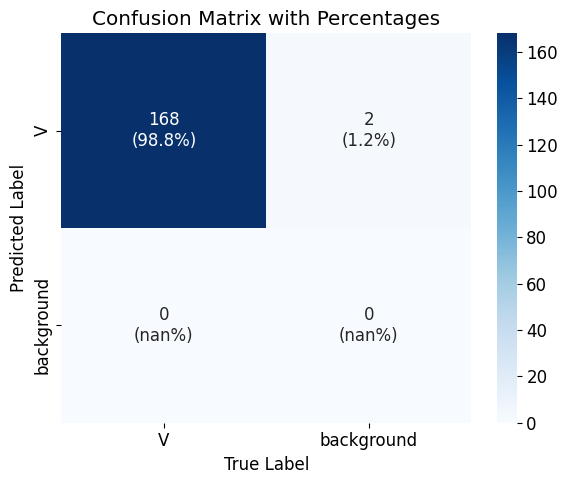


Confusion matrix with percentages saved to: /home/student/Desktop/current_model_ai/PredictedImages/confusion_matrix_percent.png


In [45]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix

# === Paths ===
predict_folder = "/home/student/Desktop/current_model_ai/PredictedImages"
test_images = "/home/student/Desktop/current_model_ai/test/images"
gt_labels = "/home/student/Desktop/current_model_ai/test/labels"

# === Clean old predictions ===
if os.path.exists(predict_folder):
    shutil.rmtree(predict_folder)

# === Load trained model ===
model = YOLO('/home/student/Desktop/current_model_ai/folder_train/folds_retrain/weights/best.pt')

# === Run predictions ===
results = model.predict(
    source=test_images,
    conf=0.4,
    iou=0.4,
    save=True,
    save_txt=True,
    save_conf=True,
    project='/home/student/Desktop/current_model_ai',
    name='PredictedImages'
)

# === Paths after prediction ===
pred_labels = os.path.join(predict_folder, 'labels')

# === Evaluate confusion matrix ===
y_true = []
y_pred = []
background_images = []

print("\nEvaluating confusion matrix:")

for filename in os.listdir(test_images):
    if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    name = os.path.splitext(filename)[0]
    gt_label_file = os.path.join(gt_labels, name + '.txt')
    pred_label_file = os.path.join(pred_labels, name + '.txt')

    gt_has_label = os.path.exists(gt_label_file) and os.path.getsize(gt_label_file) > 0
    pred_has_label = os.path.exists(pred_label_file) and os.path.getsize(pred_label_file) > 0

    if not pred_has_label:
        background_images.append(filename)

    # Labels: 1 = V (fold), 0 = background
    y_true.append(1 if gt_has_label else 0)
    y_pred.append(1 if pred_has_label else 0)

# === Generate confusion matrix ===
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
labels = ['V', 'background']

# === Print background images ===
print("\nImages predicted as background (no detections):")
for bg_img in background_images:
    print(" -", bg_img)

print(f"\nTotal background predictions: {len(background_images)}")

# === Compute percentages ===
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
annot = np.empty_like(cm).astype(str)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        perc = cm_percent[i, j]
        annot[i, j] = f"{count}\n({perc:.1f}%)"

# === Plot confusion matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix with Percentages")
plt.tight_layout()

# === Save confusion matrix ===
output_path = os.path.join(predict_folder, 'confusion_matrix_percent.png')
plt.savefig(output_path)
plt.show()

print(f"\nConfusion matrix with percentages saved to: {output_path}")

In [ ]:
# Paths
test_images_folder = '/home/student/Desktop/current_model_ai/test/images'
predicted_labels_folder = '/home/student/Desktop/current_model_ai/PredictedImages/labels'

# Collect images with no detections
predicted_as_background = []

# Loop through test images
for image_file in os.listdir(test_images_folder):
    if not image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    base = os.path.splitext(image_file)[0]
    predicted_txt = os.path.join(predicted_labels_folder, base + '.txt')

    # If prediction file is missing or empty
    if not os.path.exists(predicted_txt) or os.stat(predicted_txt).st_size == 0:
        predicted_as_background.append(image_file)

# Print result
print(f"Total images predicted as background: {len(predicted_as_background)}\n")
for img in predicted_as_background:
    print(img)


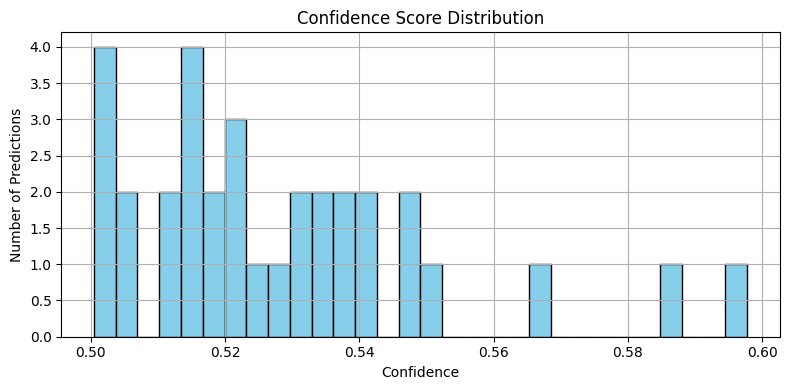

In [14]:
import os
import matplotlib.pyplot as plt

label_dir = "/home/student/Desktop/current_model_ai/PredictedImages/labels"
confidences = []

# Read all .txt files in the label folder
for filename in os.listdir(label_dir):
    if filename.endswith(".txt"):
        with open(os.path.join(label_dir, filename), "r") as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) == 6:  # YOLO format with confidence
                    conf = float(parts[5])
                    confidences.append(conf)

# Plot the histogram
plt.figure(figsize=(8, 4))
plt.hist(confidences, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Confidence")
plt.ylabel("Number of Predictions")
plt.title("Confidence Score Distribution")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Model performance data
data = {
    "Model": ["YOLOv8n", "YOLOv8m", "YOLOv8l", "YOLOv8x", "YOLOv8s"],
    "Precision": [0.928, 0.946, 0.924, 0.916, 0.953],
    "Recall": [0.89, 0.902, 0.904, 0.918, 0.918],
    "mAP50": [0.938, 0.951, 0.951, 0.939, 0.964],
    "mAP50-95": [0.41, 0.419, 0.43, 0.42, 0.428],
}

df = pd.DataFrame(data)

# Normalize the values for consistent comparison
metrics = ["Precision", "Recall", "mAP50", "mAP50-95"]
df[metrics] = df[metrics].apply(lambda x: x / x.max())

# Plotting styles
colors = ['blue', 'green', 'red', 'purple', 'orange']
font_size = 14

# Create a plot for each model
for i, model in enumerate(df["Model"]):
    plt.figure(figsize=(6, 4))
    plt.bar(metrics, df.loc[i, metrics], color=colors[i])
    plt.ylim(0, 1)
    plt.title(model, fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.grid(False)
    plt.box(False)
    plt.tight_layout()

    # Save each plot as image
    plt.savefig(f"/mnt/data/{model}_performance_plot.png")
    plt.close()

# Display file paths
[f"/mnt/data/{model}_performance_plot.png" for model in df["Model"]]


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the data
df = pd.read_csv("/home/student/Desktop/current_model_ai/training_results_v2/model_selection_metrics.csv")

# Create a 'plots' directory if it doesn't exist
plots_dir = "/home/student/Desktop/current_model_ai/training_results_v2/plots_model_selection"
os.makedirs(plots_dir, exist_ok=True)

# Set a global font size
plt.rcParams.update({'font.size': 12})

# Predefined color list
colors = ['skyblue', 'salmon', 'lightgreen', 'plum']

# Plot each metric
metrics = ['Prediction Accuracy', 'Recall Comparison', 'mAP50 Comparison', 'mAP50-95 Comparison']
for i, metric in enumerate(metrics):
    # Sort DataFrame by current metric descending
    sorted_df = df.sort_values(by=metric, ascending=False).copy()
    sorted_df.set_index('Model', inplace=True)

    plt.figure(figsize=(8, 5))
    sorted_df[metric].plot(kind='bar', color=colors[i % len(colors)], zorder=3)
    plt.title(f'Top Models by {metric}')
    plt.ylabel(metric)
    plt.xlabel('Model Version')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', linewidth=0.5, zorder=0)
    plt.gca().set_axisbelow(True)

    # Save the figure
    filename = metric.replace('(', '').replace(')', '').replace('/', '') + ".png"
    filepath = os.path.join(plots_dir, filename)
    plt.savefig(filepath)
    plt.close()


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the data
df = pd.read_csv("/home/student/Desktop/current_model_ai/training_results_v2/augmentation_results.csv")

# Create plots directory if it doesn't exist
plots_dir = "/home/student/Desktop/current_model_ai/training_results_v2/plots_augmentation_selection"
os.makedirs(plots_dir, exist_ok=True)

# Set global font size
plt.rcParams.update({'font.size': 12})

# Predefined colors
colors = ['skyblue', 'salmon', 'lightgreen', 'plum', 'orange']

# Metrics to plot
metrics = ['Prediction Accuracy', 'Recall Comparison', 'mAP50-50 Comparison', 'mAP50-95 Comparison']

for i, metric in enumerate(metrics):
    # Get top 5 configurations by metric
    top5 = df.sort_values(by=metric, ascending=False).head(5).copy()
    top5 = top5.sort_values(by=metric, ascending=False)

    # Assign short labels (M1, M2, ...)
    short_labels = [f'M{j+1}' for j in range(len(top5))]
    top5['ShortLabel'] = short_labels
    top5.set_index('ShortLabel', inplace=True)

    # Plot
    plt.figure(figsize=(8, 5))
    top5[metric].plot(kind='bar', color=colors[i % len(colors)], zorder=3)

    plt.title(f'Top 5 Configurations by {metric}')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', linewidth=0.5, zorder=0)
    plt.gca().set_axisbelow(True)

    # Build legend text block for top-right
    legend_lines = [
        f"{label} = S{row['Shear']}_Sc{row['Scale']}_T{row['Translate']}_D{row['Degrees']}"
        for label, row in top5.iterrows()
    ]
    legend_text = '\n'.join(legend_lines)

    # Add the full config info to top-right of plot
    plt.text(
        0.98, 0.02, legend_text,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.85, edgecolor='gray')
    )

    # Save figure
    filename = metric.replace('(', '').replace(')', '').replace('/', '') + ".png"
    filepath = os.path.join(plots_dir, filename)
    plt.savefig(filepath)
    plt.close()


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the data
df = pd.read_csv("/home/student/Desktop/current_model_ai/training_results_v2/epoch_batch_selection_metrics.csv")

# Create output directory
plots_dir = "/home/student/Desktop/current_model_ai/training_results_v2/plots_epoch_batch"
os.makedirs(plots_dir, exist_ok=True)

# Set global font size
plt.rcParams.update({'font.size': 12})

# Metrics to visualize (must match column names in the CSV)
metrics = [
    'Prediction Accuracy',
    'Recall Comparison',
    'mAP50 Comparison',
    'mAP50-95 Comparison'
]

# Define consistent colors for batch sizes
colors = {
    4: 'royalblue',
    8: 'darkorange',
    16: 'forestgreen',
    32: 'crimson'
}

# Generate plots for each metric
for metric in metrics:
    # Pivot the DataFrame to group by Epochs, with Batch Size as columns
    pivot_df = df.pivot(index='Epochs', columns='Batch Size', values=metric)

    # Sort epochs by best (max) performance across any batch size
    pivot_df['Max'] = pivot_df.max(axis=1)
    pivot_df = pivot_df.sort_values(by='Max', ascending=False).drop(columns='Max')

    # Plot grouped bar chart
    ax = pivot_df.plot(
        kind='bar',
        figsize=(9, 6),
        color=[colors[b] for b in pivot_df.columns]
    )
    plt.title(f"{metric} Across Epoch and Batch Size Combinations")
    plt.ylabel(metric.split()[0])
    plt.xlabel("Epochs (sorted by best to worst)")
    plt.xticks(rotation=0)
    plt.grid(True, axis='y', linestyle='--', linewidth=0.5, zorder=0)
    plt.gca().set_axisbelow(True)
    plt.legend(title="Batch Size")
    plt.tight_layout()

    # Save plot
    filename = metric.lower().replace(' ', '_') + "_epoch_batch_comparison.png"
    filepath = os.path.join(plots_dir, filename)
    plt.savefig(filepath)
    plt.close()



In [ ]:
# Load the data
df = pd.read_csv("/home/student/Desktop/current_model_ai/training_results_v2/epoch_batch_selection_metrics.csv")

# Set the model names as index (optional, for cleaner plots)
df.set_index('Run Name', inplace=True)

# Create a 'plots' directory if it doesn't exist
plots_dir = "/home/student/Desktop/current_model_ai/training_results_v2/plots_epoch_batch"
os.makedirs(plots_dir, exist_ok=True)

# Set a global font size
plt.rcParams.update({'font.size': 12})

# Predefined color list for variation
colors = ['skyblue', 'salmon', 'lightgreen', 'plum']

# Plot each metric and save the figure
metrics = ['Epochs', 'Batch Size', 'Prediction Accuracy', 'Recall Comparison', 'mAP50 Comparison', 'mAP50-95 Comparison']
for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 5))
    df[metric].plot(kind='bar', color=colors[i % len(colors)], zorder=3)
    plt.title('Model Performance Metrics Comparison')
    plt.ylabel(metric)
    plt.xlabel('Epochs and Batch Size')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', linewidth=0.5, zorder=0)
    plt.gca().set_axisbelow(True)  # Ensure grid is behind bars

    # Clean metric name for file naming
    filename = metric.replace('(', '').replace(')', '').replace('/', '') + ".png"
    filepath = os.path.join(plots_dir, filename)
    plt.savefig(filepath)
    plt.close()

In [19]:
# Load the data
df = pd.read_csv("/home/student/Desktop/current_model_ai/training_results_v2/augmentation_results.csv")

# Set the model names as index (optional, for cleaner plots)
df.set_index('Run', inplace=True)

# Create a 'plots' directory if it doesn't exist
plots_dir = "/home/student/Desktop/current_model_ai/training_results_v2/augmentation_resu"
os.makedirs(plots_dir, exist_ok=True)

# Set a global font size
plt.rcParams.update({'font.size': 12})

# Predefined color list for variation
colors = ['skyblue', 'salmon', 'lightgreen', 'plum']

# Plot each metric and save the figure
metrics = ['Shear','Scale','Translate','Degrees', 'Prediction Accuracy', 'Recall Comparison', 'mAP50-50 Comparison', 'mAP50-95 Comparison']
for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 5))
    df[metric].plot(kind='bar', color=colors[i % len(colors)], zorder=3)
    plt.title('Model Performance Metrics Comparison')
    plt.ylabel(metric)
    plt.xlabel('Augmentation Techniques')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', linewidth=0.5, zorder=0)
    plt.gca().set_axisbelow(True)  # Ensure grid is behind bars

    # Clean metric name for file naming
    filename = metric.replace('(', '').replace(')', '').replace('/', '') + ".png"
    filepath = os.path.join(plots_dir, filename)
    plt.savefig(filepath)
    plt.close()